In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable

# Взводим руками рандом сид для воспроизводимости обучения
manualSeed = 333
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  333


In [2]:
# Директория с датасетом покемонов. Внимание!!! Чтобы даталоадер работал, необходимо положить картинки в 
# папку по типу .../pokemon/1/0.png, .../pokemon/1/1.png и т.д. Без этого даталоадер работать не будет
dataroot = "./pokemon/"

# Количество воркеров для даталоадера
workers = 1

# Размер батча для обучения
batch_size = 64

# Размер скрытого вектора z
nz = 100

# Кол-во эпох обучения
num_epochs = 3000

# Размер, в который будут трансформированны все картинки
image_size = 64

# Количество фич дискриминатора
numfd = 64

# Количество фич генератора
numfg = 64

Current device : cuda:0


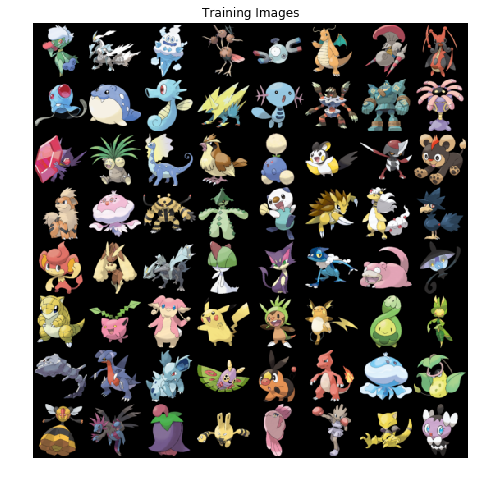

In [3]:
# Создаем даталоадер
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# переключаемся на куду
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Current device : {}".format(device))

# Выведем трейнсет, дабы убедиться, что все завелось
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# функция для инициализации весов из статьи про GAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Генератор

class Generator(nn.Module):
    def __init__(self, nz=nz, numfg=numfg):
        # тут ваш код генератора
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Сеть как в лекции: 4 конволюции, батч нормализация и релу между слоями и tanh в конце
            nn.ConvTranspose2d( nz, numfg * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(numfg * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(numfg * 8, numfg * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(numfg * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( numfg * 4, numfg * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(numfg * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( numfg * 2, numfg, 4, 2, 1, bias=False),
            nn.BatchNorm2d(numfg),
            nn.ReLU(True),
            nn.ConvTranspose2d( numfg, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, inp):
        # тут ваш код дискриминатора
        return self.net(inp)

In [6]:
# Создали генератор
netG = Generator().to(device)

# Инициализировали его
netG.apply(weights_init)

# Вывели модель для отладки
print(netG)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self):
        # тут ваш код генератора
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, numfd, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(numfd, numfd * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(numfd * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(numfd * 2, numfd * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(numfd * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(numfd * 4, numfd * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(numfd * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(numfd * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        # тут ваш код дискриминатора
        output = self.net(input)
        return output.view(-1, 1).squeeze(1)

In [8]:
# Создали дискриминатор
netD = Discriminator().to(device)

# Ининциализировали весе
netD.apply(weights_init)

# Вывели модель для отладки
print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [9]:
criterion = nn.BCELoss()

# Фиксированный шум для мониторинга качества генерации
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Коэффициент обучения
lr = 0.00005

# Оптимизаторы для сеток
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

In [10]:
# код для обучения дискриминатора
def train_D():
    for i in range(5):
        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))
        optimizerD.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        real_score = netD(real_imgs)
        # Generate a batch of images
        fake_imgs = netG(z).detach()
        fake_score = netD(fake_imgs)
        # Adversarial loss
        d_loss = -torch.mean(real_score) + torch.mean(fake_score)

        d_loss.backward()
        optimizerD.step()

        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)
        
        return z, d_loss, real_score, fake_score

In [11]:
# код для обучения генератора
def train_G(z):
    optimizerG.zero_grad()

    # Generate a batch of images
    gen_imgs = netG(z)
    # Adversarial loss
    g_loss = -torch.mean(netD(gen_imgs))

    g_loss.backward()
    optimizerG.step()
    return g_loss

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
clip_value = 0.01

d_episodes = 1

print("Starting Training Loop...")
for epoch in range(num_epochs):

    for i, (imgs, _) in enumerate(dataloader):
       
        # обучаем дискриминатор
        # d_loss = wasserstein loss дискриминатора
        # real_score - оценки дискриминатора для настоящих картинок
        # fake_score - оценки дискриминатора для фейковых картинок
        # помните, что на одну итерацию обучения генератора
        # должно приходиться несколько итераций обучения дискриминатора!
        z, d_loss, real_score, fake_score = train_D()
        
        # обучаем генератор
        # g_loss = critic-loss генератора
        g_loss = train_G(z)
        
        # Выводим стату
        if i % 1 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Сохраняем результат генерации для нашего фиксированного шума( для валидации )
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/3000][0/13]	Loss_D: 0.1971	Loss_G: 0.0074	D(x): 0.5906	D(G(z)): 0.7876
[0/3000][1/13]	Loss_D: -0.0080	Loss_G: -0.0066	D(x): 0.0164	D(G(z)): 0.0084
[0/3000][2/13]	Loss_D: -0.0015	Loss_G: -0.0141	D(x): 0.0186	D(G(z)): 0.0171
[0/3000][3/13]	Loss_D: 0.0034	Loss_G: -0.0194	D(x): 0.0200	D(G(z)): 0.0234
[0/3000][4/13]	Loss_D: 0.0049	Loss_G: -0.0223	D(x): 0.0217	D(G(z)): 0.0266
[0/3000][5/13]	Loss_D: 0.0067	Loss_G: -0.0232	D(x): 0.0211	D(G(z)): 0.0278
[0/3000][6/13]	Loss_D: 0.0050	Loss_G: -0.0234	D(x): 0.0228	D(G(z)): 0.0278
[0/3000][7/13]	Loss_D: 0.0053	Loss_G: -0.0233	D(x): 0.0224	D(G(z)): 0.0277
[0/3000][8/13]	Loss_D: 0.0035	Loss_G: -0.0230	D(x): 0.0236	D(G(z)): 0.0271
[0/3000][9/13]	Loss_D: 0.0035	Loss_G: -0.0223	D(x): 0.0228	D(G(z)): 0.0263
[0/3000][10/13]	Loss_D: 0.0036	Loss_G: -0.0210	D(x): 0.0213	D(G(z)): 0.0250
[0/3000][11/13]	Loss_D: 0.0032	Loss_G: -0.0204	D(x): 0.0209	D(G(z)): 0.0241
[0/3000][12/13]	Loss_D: 0.0010	Loss_G: -0.0198	D(x): 0.0221	D(G(z)): 0.

[8/3000][4/13]	Loss_D: -0.0059	Loss_G: -0.0105	D(x): 0.0174	D(G(z)): 0.0115
[8/3000][5/13]	Loss_D: -0.0052	Loss_G: -0.0103	D(x): 0.0169	D(G(z)): 0.0117
[8/3000][6/13]	Loss_D: -0.0050	Loss_G: -0.0104	D(x): 0.0167	D(G(z)): 0.0117
[8/3000][7/13]	Loss_D: -0.0053	Loss_G: -0.0104	D(x): 0.0169	D(G(z)): 0.0115
[8/3000][8/13]	Loss_D: -0.0047	Loss_G: -0.0101	D(x): 0.0163	D(G(z)): 0.0116
[8/3000][9/13]	Loss_D: -0.0048	Loss_G: -0.0108	D(x): 0.0167	D(G(z)): 0.0119
[8/3000][10/13]	Loss_D: -0.0042	Loss_G: -0.0106	D(x): 0.0159	D(G(z)): 0.0116
[8/3000][11/13]	Loss_D: -0.0047	Loss_G: -0.0110	D(x): 0.0166	D(G(z)): 0.0119
[8/3000][12/13]	Loss_D: -0.0046	Loss_G: -0.0110	D(x): 0.0168	D(G(z)): 0.0122
[9/3000][0/13]	Loss_D: -0.0044	Loss_G: -0.0111	D(x): 0.0167	D(G(z)): 0.0123
[9/3000][1/13]	Loss_D: -0.0042	Loss_G: -0.0107	D(x): 0.0162	D(G(z)): 0.0119
[9/3000][2/13]	Loss_D: -0.0042	Loss_G: -0.0105	D(x): 0.0161	D(G(z)): 0.0119
[9/3000][3/13]	Loss_D: -0.0049	Loss_G: -0.0103	D(x): 0.0164	D(G(z)): 0.0115
[9/3000][

[16/3000][8/13]	Loss_D: -0.0143	Loss_G: -0.0081	D(x): 0.0228	D(G(z)): 0.0086
[16/3000][9/13]	Loss_D: -0.0143	Loss_G: -0.0073	D(x): 0.0242	D(G(z)): 0.0099
[16/3000][10/13]	Loss_D: -0.0137	Loss_G: -0.0061	D(x): 0.0225	D(G(z)): 0.0087
[16/3000][11/13]	Loss_D: -0.0148	Loss_G: -0.0070	D(x): 0.0224	D(G(z)): 0.0077
[16/3000][12/13]	Loss_D: -0.0152	Loss_G: -0.0061	D(x): 0.0239	D(G(z)): 0.0087
[17/3000][0/13]	Loss_D: -0.0140	Loss_G: -0.0063	D(x): 0.0221	D(G(z)): 0.0081
[17/3000][1/13]	Loss_D: -0.0147	Loss_G: -0.0059	D(x): 0.0233	D(G(z)): 0.0086
[17/3000][2/13]	Loss_D: -0.0133	Loss_G: -0.0086	D(x): 0.0214	D(G(z)): 0.0081
[17/3000][3/13]	Loss_D: -0.0131	Loss_G: -0.0069	D(x): 0.0238	D(G(z)): 0.0107
[17/3000][4/13]	Loss_D: -0.0130	Loss_G: -0.0087	D(x): 0.0214	D(G(z)): 0.0084
[17/3000][5/13]	Loss_D: -0.0138	Loss_G: -0.0058	D(x): 0.0243	D(G(z)): 0.0105
[17/3000][6/13]	Loss_D: -0.0145	Loss_G: -0.0082	D(x): 0.0222	D(G(z)): 0.0077
[17/3000][7/13]	Loss_D: -0.0142	Loss_G: -0.0055	D(x): 0.0245	D(G(z)): 0.0

[24/3000][12/13]	Loss_D: -0.0293	Loss_G: 0.0243	D(x): 0.0098	D(G(z)): -0.0195
[25/3000][0/13]	Loss_D: -0.0345	Loss_G: 0.0278	D(x): 0.0157	D(G(z)): -0.0188
[25/3000][1/13]	Loss_D: -0.0386	Loss_G: 0.0215	D(x): 0.0131	D(G(z)): -0.0255
[25/3000][2/13]	Loss_D: -0.0374	Loss_G: 0.0404	D(x): 0.0215	D(G(z)): -0.0159
[25/3000][3/13]	Loss_D: -0.0428	Loss_G: 0.0209	D(x): 0.0071	D(G(z)): -0.0357
[25/3000][4/13]	Loss_D: -0.0463	Loss_G: 0.0384	D(x): 0.0294	D(G(z)): -0.0169
[25/3000][5/13]	Loss_D: -0.0454	Loss_G: 0.0118	D(x): 0.0166	D(G(z)): -0.0288
[25/3000][6/13]	Loss_D: -0.0420	Loss_G: 0.0277	D(x): 0.0373	D(G(z)): -0.0046
[25/3000][7/13]	Loss_D: -0.0336	Loss_G: 0.0175	D(x): 0.0166	D(G(z)): -0.0170
[25/3000][8/13]	Loss_D: -0.0257	Loss_G: 0.0313	D(x): 0.0222	D(G(z)): -0.0035
[25/3000][9/13]	Loss_D: -0.0261	Loss_G: -0.0060	D(x): 0.0032	D(G(z)): -0.0229
[25/3000][10/13]	Loss_D: -0.0282	Loss_G: 0.0193	D(x): 0.0467	D(G(z)): 0.0186
[25/3000][11/13]	Loss_D: -0.0332	Loss_G: 0.0122	D(x): 0.0214	D(G(z)): -0.0

[33/3000][2/13]	Loss_D: -0.1422	Loss_G: 0.1124	D(x): 0.0714	D(G(z)): -0.0708
[33/3000][3/13]	Loss_D: -0.1481	Loss_G: 0.0818	D(x): 0.0544	D(G(z)): -0.0937
[33/3000][4/13]	Loss_D: -0.1485	Loss_G: 0.1327	D(x): 0.1017	D(G(z)): -0.0468
[33/3000][5/13]	Loss_D: -0.1386	Loss_G: 0.0282	D(x): 0.0261	D(G(z)): -0.1125
[33/3000][6/13]	Loss_D: -0.0993	Loss_G: 0.1426	D(x): 0.1301	D(G(z)): 0.0308
[33/3000][7/13]	Loss_D: -0.1115	Loss_G: 0.0710	D(x): -0.0063	D(G(z)): -0.1179
[33/3000][8/13]	Loss_D: -0.0965	Loss_G: 0.1154	D(x): 0.0923	D(G(z)): -0.0042
[33/3000][9/13]	Loss_D: -0.1391	Loss_G: 0.0910	D(x): 0.0503	D(G(z)): -0.0888
[33/3000][10/13]	Loss_D: -0.1416	Loss_G: 0.1318	D(x): 0.0944	D(G(z)): -0.0473
[33/3000][11/13]	Loss_D: -0.1413	Loss_G: 0.0930	D(x): 0.0385	D(G(z)): -0.1028
[33/3000][12/13]	Loss_D: -0.1457	Loss_G: 0.1622	D(x): 0.1112	D(G(z)): -0.0345
[34/3000][0/13]	Loss_D: -0.1288	Loss_G: 0.0645	D(x): -0.0112	D(G(z)): -0.1400
[34/3000][1/13]	Loss_D: -0.1054	Loss_G: 0.1597	D(x): 0.1296	D(G(z)): 0.0

[41/3000][6/13]	Loss_D: -0.2570	Loss_G: 0.1634	D(x): 0.0689	D(G(z)): -0.1881
[41/3000][7/13]	Loss_D: -0.2517	Loss_G: 0.2883	D(x): 0.1769	D(G(z)): -0.0748
[41/3000][8/13]	Loss_D: -0.2628	Loss_G: 0.1650	D(x): -0.0031	D(G(z)): -0.2659
[41/3000][9/13]	Loss_D: -0.2752	Loss_G: 0.2558	D(x): 0.1964	D(G(z)): -0.0788
[41/3000][10/13]	Loss_D: -0.3090	Loss_G: 0.2302	D(x): 0.1041	D(G(z)): -0.2048
[41/3000][11/13]	Loss_D: -0.3180	Loss_G: 0.2500	D(x): 0.1457	D(G(z)): -0.1723
[41/3000][12/13]	Loss_D: -0.3290	Loss_G: 0.2263	D(x): 0.1279	D(G(z)): -0.2010
[42/3000][0/13]	Loss_D: -0.2871	Loss_G: 0.2396	D(x): 0.1372	D(G(z)): -0.1499
[42/3000][1/13]	Loss_D: -0.2685	Loss_G: 0.1935	D(x): 0.0989	D(G(z)): -0.1696
[42/3000][2/13]	Loss_D: -0.2414	Loss_G: 0.2221	D(x): 0.1422	D(G(z)): -0.0992
[42/3000][3/13]	Loss_D: -0.2652	Loss_G: 0.1837	D(x): 0.1089	D(G(z)): -0.1563
[42/3000][4/13]	Loss_D: -0.2841	Loss_G: 0.2428	D(x): 0.1747	D(G(z)): -0.1094
[42/3000][5/13]	Loss_D: -0.3000	Loss_G: 0.1647	D(x): 0.0918	D(G(z)): -0.

[49/3000][10/13]	Loss_D: -0.4050	Loss_G: 0.2000	D(x): 0.0597	D(G(z)): -0.3453
[49/3000][11/13]	Loss_D: -0.4189	Loss_G: 0.3677	D(x): 0.3084	D(G(z)): -0.1105
[49/3000][12/13]	Loss_D: -0.4257	Loss_G: 0.2190	D(x): 0.0717	D(G(z)): -0.3540
[50/3000][0/13]	Loss_D: -0.4381	Loss_G: 0.3727	D(x): 0.3141	D(G(z)): -0.1241
[50/3000][1/13]	Loss_D: -0.4848	Loss_G: 0.2441	D(x): 0.1321	D(G(z)): -0.3527
[50/3000][2/13]	Loss_D: -0.4455	Loss_G: 0.3551	D(x): 0.3138	D(G(z)): -0.1317
[50/3000][3/13]	Loss_D: -0.5105	Loss_G: 0.2280	D(x): 0.1731	D(G(z)): -0.3375
[50/3000][4/13]	Loss_D: -0.4543	Loss_G: 0.3679	D(x): 0.3207	D(G(z)): -0.1336
[50/3000][5/13]	Loss_D: -0.4995	Loss_G: 0.2539	D(x): 0.1592	D(G(z)): -0.3403
[50/3000][6/13]	Loss_D: -0.4761	Loss_G: 0.3672	D(x): 0.3064	D(G(z)): -0.1697
[50/3000][7/13]	Loss_D: -0.4591	Loss_G: 0.2313	D(x): 0.1244	D(G(z)): -0.3348
[50/3000][8/13]	Loss_D: -0.4015	Loss_G: 0.3475	D(x): 0.2913	D(G(z)): -0.1102
[50/3000][9/13]	Loss_D: -0.4200	Loss_G: 0.2084	D(x): 0.1184	D(G(z)): -0.3

[58/3000][0/13]	Loss_D: -0.5538	Loss_G: 0.2545	D(x): 0.1219	D(G(z)): -0.4319
[58/3000][1/13]	Loss_D: -0.5025	Loss_G: 0.4345	D(x): 0.3828	D(G(z)): -0.1197
[58/3000][2/13]	Loss_D: -0.5453	Loss_G: 0.2932	D(x): 0.1285	D(G(z)): -0.4168
[58/3000][3/13]	Loss_D: -0.5206	Loss_G: 0.4112	D(x): 0.3517	D(G(z)): -0.1689
[58/3000][4/13]	Loss_D: -0.5639	Loss_G: 0.2454	D(x): 0.1739	D(G(z)): -0.3900
[58/3000][5/13]	Loss_D: -0.4440	Loss_G: 0.4248	D(x): 0.3708	D(G(z)): -0.0732
[58/3000][6/13]	Loss_D: -0.4220	Loss_G: 0.2889	D(x): 0.0209	D(G(z)): -0.4011
[58/3000][7/13]	Loss_D: -0.4620	Loss_G: 0.3885	D(x): 0.3157	D(G(z)): -0.1463
[58/3000][8/13]	Loss_D: -0.5608	Loss_G: 0.2956	D(x): 0.2069	D(G(z)): -0.3540
[58/3000][9/13]	Loss_D: -0.5036	Loss_G: 0.4301	D(x): 0.3145	D(G(z)): -0.1891
[58/3000][10/13]	Loss_D: -0.5156	Loss_G: 0.2543	D(x): 0.1135	D(G(z)): -0.4021
[58/3000][11/13]	Loss_D: -0.4848	Loss_G: 0.4276	D(x): 0.3428	D(G(z)): -0.1420
[58/3000][12/13]	Loss_D: -0.5260	Loss_G: 0.2443	D(x): 0.1145	D(G(z)): -0.4

[66/3000][4/13]	Loss_D: -0.5344	Loss_G: 0.2766	D(x): 0.0919	D(G(z)): -0.4425
[66/3000][5/13]	Loss_D: -0.5715	Loss_G: 0.4759	D(x): 0.3933	D(G(z)): -0.1782
[66/3000][6/13]	Loss_D: -0.5869	Loss_G: 0.3031	D(x): 0.1218	D(G(z)): -0.4651
[66/3000][7/13]	Loss_D: -0.5840	Loss_G: 0.4851	D(x): 0.3935	D(G(z)): -0.1905
[66/3000][8/13]	Loss_D: -0.6355	Loss_G: 0.3363	D(x): 0.1640	D(G(z)): -0.4714
[66/3000][9/13]	Loss_D: -0.6328	Loss_G: 0.4658	D(x): 0.3894	D(G(z)): -0.2434
[66/3000][10/13]	Loss_D: -0.6699	Loss_G: 0.3459	D(x): 0.2190	D(G(z)): -0.4509
[66/3000][11/13]	Loss_D: -0.6108	Loss_G: 0.4783	D(x): 0.3843	D(G(z)): -0.2265
[66/3000][12/13]	Loss_D: -0.5796	Loss_G: 0.3123	D(x): 0.1169	D(G(z)): -0.4627
[67/3000][0/13]	Loss_D: -0.4996	Loss_G: 0.4704	D(x): 0.3923	D(G(z)): -0.1073
[67/3000][1/13]	Loss_D: -0.5439	Loss_G: 0.3427	D(x): 0.0927	D(G(z)): -0.4512
[67/3000][2/13]	Loss_D: -0.5083	Loss_G: 0.4732	D(x): 0.3648	D(G(z)): -0.1435
[67/3000][3/13]	Loss_D: -0.5363	Loss_G: 0.2618	D(x): 0.0860	D(G(z)): -0.4

[74/3000][8/13]	Loss_D: -0.4723	Loss_G: 0.2033	D(x): 0.0832	D(G(z)): -0.3891
[74/3000][9/13]	Loss_D: -0.3770	Loss_G: 0.4278	D(x): 0.3789	D(G(z)): 0.0019
[74/3000][10/13]	Loss_D: -0.5497	Loss_G: 0.2617	D(x): 0.1606	D(G(z)): -0.3891
[74/3000][11/13]	Loss_D: -0.4553	Loss_G: 0.4475	D(x): 0.3620	D(G(z)): -0.0933
[74/3000][12/13]	Loss_D: -0.5067	Loss_G: 0.2347	D(x): 0.1050	D(G(z)): -0.4017
[75/3000][0/13]	Loss_D: -0.4612	Loss_G: 0.4503	D(x): 0.3560	D(G(z)): -0.1052
[75/3000][1/13]	Loss_D: -0.5715	Loss_G: 0.2223	D(x): 0.1306	D(G(z)): -0.4408
[75/3000][2/13]	Loss_D: -0.4574	Loss_G: 0.4692	D(x): 0.3704	D(G(z)): -0.0870
[75/3000][3/13]	Loss_D: -0.6048	Loss_G: 0.2306	D(x): 0.1460	D(G(z)): -0.4588
[75/3000][4/13]	Loss_D: -0.5041	Loss_G: 0.4847	D(x): 0.4232	D(G(z)): -0.0809
[75/3000][5/13]	Loss_D: -0.5418	Loss_G: 0.2725	D(x): 0.0550	D(G(z)): -0.4868
[75/3000][6/13]	Loss_D: -0.5528	Loss_G: 0.4982	D(x): 0.4198	D(G(z)): -0.1330
[75/3000][7/13]	Loss_D: -0.5792	Loss_G: 0.2796	D(x): 0.1019	D(G(z)): -0.47

[82/3000][12/13]	Loss_D: -0.6841	Loss_G: 0.3403	D(x): 0.2704	D(G(z)): -0.4137
[83/3000][0/13]	Loss_D: -0.6102	Loss_G: 0.4796	D(x): 0.3811	D(G(z)): -0.2291
[83/3000][1/13]	Loss_D: -0.6557	Loss_G: 0.3140	D(x): 0.2064	D(G(z)): -0.4493
[83/3000][2/13]	Loss_D: -0.5608	Loss_G: 0.4926	D(x): 0.3933	D(G(z)): -0.1676
[83/3000][3/13]	Loss_D: -0.5768	Loss_G: 0.2820	D(x): 0.1159	D(G(z)): -0.4609
[83/3000][4/13]	Loss_D: -0.5273	Loss_G: 0.4940	D(x): 0.3976	D(G(z)): -0.1297
[83/3000][5/13]	Loss_D: -0.6473	Loss_G: 0.3180	D(x): 0.1821	D(G(z)): -0.4652
[83/3000][6/13]	Loss_D: -0.6076	Loss_G: 0.5064	D(x): 0.4289	D(G(z)): -0.1787
[83/3000][7/13]	Loss_D: -0.6509	Loss_G: 0.3231	D(x): 0.1657	D(G(z)): -0.4851
[83/3000][8/13]	Loss_D: -0.6293	Loss_G: 0.4979	D(x): 0.4161	D(G(z)): -0.2132
[83/3000][9/13]	Loss_D: -0.5739	Loss_G: 0.2886	D(x): 0.1161	D(G(z)): -0.4578
[83/3000][10/13]	Loss_D: -0.5032	Loss_G: 0.4946	D(x): 0.4009	D(G(z)): -0.1023
[83/3000][11/13]	Loss_D: -0.6126	Loss_G: 0.2824	D(x): 0.1258	D(G(z)): -0.4

[91/3000][2/13]	Loss_D: -0.4814	Loss_G: 0.5224	D(x): 0.4018	D(G(z)): -0.0796
[91/3000][3/13]	Loss_D: -0.5178	Loss_G: 0.2877	D(x): 0.0153	D(G(z)): -0.5026
[91/3000][4/13]	Loss_D: -0.5602	Loss_G: 0.5194	D(x): 0.4075	D(G(z)): -0.1527
[91/3000][5/13]	Loss_D: -0.5343	Loss_G: 0.2816	D(x): 0.0120	D(G(z)): -0.5223
[91/3000][6/13]	Loss_D: -0.5721	Loss_G: 0.5169	D(x): 0.4193	D(G(z)): -0.1528
[91/3000][7/13]	Loss_D: -0.5956	Loss_G: 0.2761	D(x): 0.0818	D(G(z)): -0.5138
[91/3000][8/13]	Loss_D: -0.5407	Loss_G: 0.5136	D(x): 0.4360	D(G(z)): -0.1047
[91/3000][9/13]	Loss_D: -0.5603	Loss_G: 0.3198	D(x): 0.0615	D(G(z)): -0.4987
[91/3000][10/13]	Loss_D: -0.5548	Loss_G: 0.4995	D(x): 0.3906	D(G(z)): -0.1642
[91/3000][11/13]	Loss_D: -0.5706	Loss_G: 0.2770	D(x): 0.0987	D(G(z)): -0.4719
[91/3000][12/13]	Loss_D: -0.5245	Loss_G: 0.5085	D(x): 0.4407	D(G(z)): -0.0838
[92/3000][0/13]	Loss_D: -0.5240	Loss_G: 0.3308	D(x): 0.0521	D(G(z)): -0.4719
[92/3000][1/13]	Loss_D: -0.5507	Loss_G: 0.4650	D(x): 0.3877	D(G(z)): -0.1

[99/3000][6/13]	Loss_D: -0.4528	Loss_G: 0.4674	D(x): 0.3928	D(G(z)): -0.0600
[99/3000][7/13]	Loss_D: -0.6010	Loss_G: 0.2626	D(x): 0.1512	D(G(z)): -0.4498
[99/3000][8/13]	Loss_D: -0.4311	Loss_G: 0.4764	D(x): 0.4064	D(G(z)): -0.0247
[99/3000][9/13]	Loss_D: -0.5355	Loss_G: 0.2547	D(x): 0.0991	D(G(z)): -0.4363
[99/3000][10/13]	Loss_D: -0.4431	Loss_G: 0.4852	D(x): 0.3972	D(G(z)): -0.0459
[99/3000][11/13]	Loss_D: -0.5284	Loss_G: 0.2622	D(x): 0.0697	D(G(z)): -0.4588
[99/3000][12/13]	Loss_D: -0.5208	Loss_G: 0.4845	D(x): 0.3983	D(G(z)): -0.1225
[100/3000][0/13]	Loss_D: -0.5675	Loss_G: 0.3085	D(x): 0.1187	D(G(z)): -0.4488
[100/3000][1/13]	Loss_D: -0.5747	Loss_G: 0.4795	D(x): 0.3940	D(G(z)): -0.1807
[100/3000][2/13]	Loss_D: -0.5866	Loss_G: 0.3285	D(x): 0.1251	D(G(z)): -0.4615
[100/3000][3/13]	Loss_D: -0.5756	Loss_G: 0.4852	D(x): 0.3803	D(G(z)): -0.1953
[100/3000][4/13]	Loss_D: -0.6207	Loss_G: 0.3101	D(x): 0.1579	D(G(z)): -0.4628
[100/3000][5/13]	Loss_D: -0.6005	Loss_G: 0.5059	D(x): 0.4204	D(G(z))

[107/3000][8/13]	Loss_D: -0.6476	Loss_G: 0.4924	D(x): 0.4499	D(G(z)): -0.1977
[107/3000][9/13]	Loss_D: -0.6834	Loss_G: 0.2921	D(x): 0.2202	D(G(z)): -0.4632
[107/3000][10/13]	Loss_D: -0.6317	Loss_G: 0.5082	D(x): 0.4550	D(G(z)): -0.1766
[107/3000][11/13]	Loss_D: -0.6025	Loss_G: 0.2717	D(x): 0.1142	D(G(z)): -0.4883
[107/3000][12/13]	Loss_D: -0.5777	Loss_G: 0.5017	D(x): 0.4653	D(G(z)): -0.1124
[108/3000][0/13]	Loss_D: -0.5928	Loss_G: 0.2218	D(x): 0.1232	D(G(z)): -0.4696
[108/3000][1/13]	Loss_D: -0.4597	Loss_G: 0.4712	D(x): 0.4514	D(G(z)): -0.0083
[108/3000][2/13]	Loss_D: -0.5762	Loss_G: 0.2797	D(x): 0.1347	D(G(z)): -0.4414
[108/3000][3/13]	Loss_D: -0.4880	Loss_G: 0.4679	D(x): 0.3996	D(G(z)): -0.0884
[108/3000][4/13]	Loss_D: -0.5985	Loss_G: 0.2991	D(x): 0.1637	D(G(z)): -0.4348
[108/3000][5/13]	Loss_D: -0.5409	Loss_G: 0.4911	D(x): 0.4016	D(G(z)): -0.1393
[108/3000][6/13]	Loss_D: -0.6127	Loss_G: 0.2818	D(x): 0.1466	D(G(z)): -0.4662
[108/3000][7/13]	Loss_D: -0.5825	Loss_G: 0.4979	D(x): 0.4271	

[115/3000][10/13]	Loss_D: -0.4908	Loss_G: 0.5079	D(x): 0.4690	D(G(z)): -0.0218
[115/3000][11/13]	Loss_D: -0.5951	Loss_G: 0.2610	D(x): 0.1203	D(G(z)): -0.4747
[115/3000][12/13]	Loss_D: -0.5364	Loss_G: 0.4961	D(x): 0.4525	D(G(z)): -0.0839
[116/3000][0/13]	Loss_D: -0.5749	Loss_G: 0.2087	D(x): 0.0890	D(G(z)): -0.4859
[116/3000][1/13]	Loss_D: -0.4078	Loss_G: 0.4842	D(x): 0.4572	D(G(z)): 0.0494
[116/3000][2/13]	Loss_D: -0.5406	Loss_G: 0.2417	D(x): 0.0873	D(G(z)): -0.4533
[116/3000][3/13]	Loss_D: -0.4316	Loss_G: 0.4961	D(x): 0.4065	D(G(z)): -0.0252
[116/3000][4/13]	Loss_D: -0.4979	Loss_G: 0.1901	D(x): 0.0359	D(G(z)): -0.4620
[116/3000][5/13]	Loss_D: -0.3872	Loss_G: 0.4819	D(x): 0.4345	D(G(z)): 0.0473
[116/3000][6/13]	Loss_D: -0.5115	Loss_G: 0.2152	D(x): 0.0567	D(G(z)): -0.4548
[116/3000][7/13]	Loss_D: -0.4354	Loss_G: 0.5007	D(x): 0.4071	D(G(z)): -0.0283
[116/3000][8/13]	Loss_D: -0.5172	Loss_G: 0.2292	D(x): 0.0463	D(G(z)): -0.4709
[116/3000][9/13]	Loss_D: -0.5352	Loss_G: 0.5075	D(x): 0.4283	D(

[123/3000][12/13]	Loss_D: -0.4042	Loss_G: 0.4648	D(x): 0.3619	D(G(z)): -0.0424
[124/3000][0/13]	Loss_D: -0.4757	Loss_G: 0.2266	D(x): 0.0406	D(G(z)): -0.4352
[124/3000][1/13]	Loss_D: -0.3611	Loss_G: 0.4625	D(x): 0.4057	D(G(z)): 0.0447
[124/3000][2/13]	Loss_D: -0.4932	Loss_G: 0.2378	D(x): 0.0534	D(G(z)): -0.4398
[124/3000][3/13]	Loss_D: -0.4407	Loss_G: 0.4658	D(x): 0.4124	D(G(z)): -0.0283
[124/3000][4/13]	Loss_D: -0.4395	Loss_G: 0.2141	D(x): 0.0211	D(G(z)): -0.4184
[124/3000][5/13]	Loss_D: -0.3844	Loss_G: 0.4725	D(x): 0.3985	D(G(z)): 0.0141
[124/3000][6/13]	Loss_D: -0.4606	Loss_G: 0.2332	D(x): 0.0367	D(G(z)): -0.4239
[124/3000][7/13]	Loss_D: -0.4084	Loss_G: 0.4757	D(x): 0.3894	D(G(z)): -0.0190
[124/3000][8/13]	Loss_D: -0.5021	Loss_G: 0.2506	D(x): 0.0667	D(G(z)): -0.4354
[124/3000][9/13]	Loss_D: -0.4247	Loss_G: 0.4605	D(x): 0.3676	D(G(z)): -0.0571
[124/3000][10/13]	Loss_D: -0.5482	Loss_G: 0.2298	D(x): 0.1119	D(G(z)): -0.4363
[124/3000][11/13]	Loss_D: -0.5126	Loss_G: 0.4947	D(x): 0.4522	D(

[132/3000][0/13]	Loss_D: -0.4444	Loss_G: 0.2582	D(x): 0.1165	D(G(z)): -0.3279
[132/3000][1/13]	Loss_D: -0.3027	Loss_G: 0.3685	D(x): 0.2940	D(G(z)): -0.0087
[132/3000][2/13]	Loss_D: -0.3955	Loss_G: 0.2697	D(x): 0.1209	D(G(z)): -0.2746
[132/3000][3/13]	Loss_D: -0.3823	Loss_G: 0.4298	D(x): 0.2718	D(G(z)): -0.1105
[132/3000][4/13]	Loss_D: -0.4989	Loss_G: 0.1671	D(x): 0.1006	D(G(z)): -0.3983
[132/3000][5/13]	Loss_D: -0.4370	Loss_G: 0.4972	D(x): 0.4367	D(G(z)): -0.0003
[132/3000][6/13]	Loss_D: -0.4768	Loss_G: 0.2932	D(x): 0.0046	D(G(z)): -0.4722
[132/3000][7/13]	Loss_D: -0.6020	Loss_G: 0.4637	D(x): 0.3952	D(G(z)): -0.2068
[132/3000][8/13]	Loss_D: -0.6095	Loss_G: 0.2395	D(x): 0.1794	D(G(z)): -0.4301
[132/3000][9/13]	Loss_D: -0.4669	Loss_G: 0.4519	D(x): 0.4243	D(G(z)): -0.0426
[132/3000][10/13]	Loss_D: -0.5821	Loss_G: 0.2556	D(x): 0.1465	D(G(z)): -0.4356
[132/3000][11/13]	Loss_D: -0.5270	Loss_G: 0.4711	D(x): 0.4301	D(G(z)): -0.0969
[132/3000][12/13]	Loss_D: -0.5286	Loss_G: 0.2257	D(x): 0.0874	

[140/3000][2/13]	Loss_D: -0.4344	Loss_G: 0.1693	D(x): 0.0085	D(G(z)): -0.4258
[140/3000][3/13]	Loss_D: -0.3887	Loss_G: 0.4437	D(x): 0.4036	D(G(z)): 0.0149
[140/3000][4/13]	Loss_D: -0.5558	Loss_G: 0.1495	D(x): 0.1341	D(G(z)): -0.4217
[140/3000][5/13]	Loss_D: -0.4413	Loss_G: 0.4757	D(x): 0.4761	D(G(z)): 0.0348
[140/3000][6/13]	Loss_D: -0.4519	Loss_G: 0.2363	D(x): -0.0060	D(G(z)): -0.4579
[140/3000][7/13]	Loss_D: -0.5065	Loss_G: 0.4445	D(x): 0.4093	D(G(z)): -0.0973
[140/3000][8/13]	Loss_D: -0.6253	Loss_G: 0.2682	D(x): 0.1947	D(G(z)): -0.4306
[140/3000][9/13]	Loss_D: -0.5382	Loss_G: 0.4439	D(x): 0.4059	D(G(z)): -0.1323
[140/3000][10/13]	Loss_D: -0.5493	Loss_G: 0.2202	D(x): 0.1363	D(G(z)): -0.4130
[140/3000][11/13]	Loss_D: -0.5149	Loss_G: 0.4988	D(x): 0.4527	D(G(z)): -0.0622
[140/3000][12/13]	Loss_D: -0.5295	Loss_G: 0.1477	D(x): 0.0541	D(G(z)): -0.4754
[141/3000][0/13]	Loss_D: -0.4004	Loss_G: 0.4762	D(x): 0.4589	D(G(z)): 0.0586
[141/3000][1/13]	Loss_D: -0.5843	Loss_G: 0.2452	D(x): 0.1253	D(

[148/3000][4/13]	Loss_D: -0.4666	Loss_G: 0.1264	D(x): 0.0204	D(G(z)): -0.4462
[148/3000][5/13]	Loss_D: -0.3719	Loss_G: 0.4513	D(x): 0.4333	D(G(z)): 0.0614
[148/3000][6/13]	Loss_D: -0.4921	Loss_G: 0.1100	D(x): 0.0688	D(G(z)): -0.4232
[148/3000][7/13]	Loss_D: -0.3663	Loss_G: 0.4899	D(x): 0.4444	D(G(z)): 0.0780
[148/3000][8/13]	Loss_D: -0.4355	Loss_G: 0.2136	D(x): -0.0083	D(G(z)): -0.4437
[148/3000][9/13]	Loss_D: -0.4980	Loss_G: 0.4867	D(x): 0.3903	D(G(z)): -0.1077
[148/3000][10/13]	Loss_D: -0.5169	Loss_G: 0.1663	D(x): 0.0558	D(G(z)): -0.4611
[148/3000][11/13]	Loss_D: -0.4211	Loss_G: 0.4861	D(x): 0.4373	D(G(z)): 0.0162
[148/3000][12/13]	Loss_D: -0.4930	Loss_G: 0.2272	D(x): 0.0264	D(G(z)): -0.4666
[149/3000][0/13]	Loss_D: -0.4826	Loss_G: 0.4714	D(x): 0.4124	D(G(z)): -0.0702
[149/3000][1/13]	Loss_D: -0.4823	Loss_G: 0.1891	D(x): 0.0450	D(G(z)): -0.4372
[149/3000][2/13]	Loss_D: -0.3536	Loss_G: 0.4337	D(x): 0.3835	D(G(z)): 0.0299
[149/3000][3/13]	Loss_D: -0.4439	Loss_G: 0.1883	D(x): 0.0676	D(G

[156/3000][6/13]	Loss_D: -0.4678	Loss_G: 0.4818	D(x): 0.3930	D(G(z)): -0.0748
[156/3000][7/13]	Loss_D: -0.4287	Loss_G: 0.1534	D(x): -0.0187	D(G(z)): -0.4474
[156/3000][8/13]	Loss_D: -0.3855	Loss_G: 0.4613	D(x): 0.3975	D(G(z)): 0.0120
[156/3000][9/13]	Loss_D: -0.4216	Loss_G: 0.1715	D(x): -0.0138	D(G(z)): -0.4354
[156/3000][10/13]	Loss_D: -0.3510	Loss_G: 0.4305	D(x): 0.3736	D(G(z)): 0.0225
[156/3000][11/13]	Loss_D: -0.5217	Loss_G: 0.1996	D(x): 0.1315	D(G(z)): -0.3902
[156/3000][12/13]	Loss_D: -0.4227	Loss_G: 0.4823	D(x): 0.3857	D(G(z)): -0.0370
[157/3000][0/13]	Loss_D: -0.4840	Loss_G: 0.1348	D(x): 0.0377	D(G(z)): -0.4462
[157/3000][1/13]	Loss_D: -0.3527	Loss_G: 0.4705	D(x): 0.4042	D(G(z)): 0.0515
[157/3000][2/13]	Loss_D: -0.4799	Loss_G: 0.1413	D(x): 0.0342	D(G(z)): -0.4457
[157/3000][3/13]	Loss_D: -0.3587	Loss_G: 0.4652	D(x): 0.4501	D(G(z)): 0.0914
[157/3000][4/13]	Loss_D: -0.4648	Loss_G: 0.1555	D(x): 0.0401	D(G(z)): -0.4247
[157/3000][5/13]	Loss_D: -0.3356	Loss_G: 0.3783	D(x): 0.3795	D(

[164/3000][8/13]	Loss_D: -0.3582	Loss_G: 0.4499	D(x): 0.3849	D(G(z)): 0.0267
[164/3000][9/13]	Loss_D: -0.4741	Loss_G: 0.1210	D(x): 0.0727	D(G(z)): -0.4014
[164/3000][10/13]	Loss_D: -0.3331	Loss_G: 0.4358	D(x): 0.4026	D(G(z)): 0.0695
[164/3000][11/13]	Loss_D: -0.4303	Loss_G: 0.1380	D(x): 0.0476	D(G(z)): -0.3827
[164/3000][12/13]	Loss_D: -0.3606	Loss_G: 0.4755	D(x): 0.3946	D(G(z)): 0.0340
[165/3000][0/13]	Loss_D: -0.4111	Loss_G: 0.1456	D(x): -0.0490	D(G(z)): -0.4601
[165/3000][1/13]	Loss_D: -0.3678	Loss_G: 0.4336	D(x): 0.3808	D(G(z)): 0.0130
[165/3000][2/13]	Loss_D: -0.4419	Loss_G: 0.1571	D(x): 0.0422	D(G(z)): -0.3997
[165/3000][3/13]	Loss_D: -0.3743	Loss_G: 0.4238	D(x): 0.3532	D(G(z)): -0.0211
[165/3000][4/13]	Loss_D: -0.4774	Loss_G: 0.1368	D(x): 0.1013	D(G(z)): -0.3761
[165/3000][5/13]	Loss_D: -0.4342	Loss_G: 0.4492	D(x): 0.4051	D(G(z)): -0.0291
[165/3000][6/13]	Loss_D: -0.4803	Loss_G: 0.1541	D(x): 0.0595	D(G(z)): -0.4207
[165/3000][7/13]	Loss_D: -0.3816	Loss_G: 0.4498	D(x): 0.4076	D(G

[172/3000][10/13]	Loss_D: -0.3976	Loss_G: 0.4342	D(x): 0.3471	D(G(z)): -0.0505
[172/3000][11/13]	Loss_D: -0.4208	Loss_G: 0.0429	D(x): 0.0236	D(G(z)): -0.3972
[172/3000][12/13]	Loss_D: -0.3214	Loss_G: 0.4140	D(x): 0.4257	D(G(z)): 0.1042
[173/3000][0/13]	Loss_D: -0.4207	Loss_G: 0.1405	D(x): 0.0652	D(G(z)): -0.3554
[173/3000][1/13]	Loss_D: -0.3930	Loss_G: 0.4380	D(x): 0.3853	D(G(z)): -0.0077
[173/3000][2/13]	Loss_D: -0.4142	Loss_G: 0.0766	D(x): 0.0003	D(G(z)): -0.4140
[173/3000][3/13]	Loss_D: -0.3148	Loss_G: 0.3963	D(x): 0.4093	D(G(z)): 0.0944
[173/3000][4/13]	Loss_D: -0.4317	Loss_G: 0.0788	D(x): 0.0525	D(G(z)): -0.3792
[173/3000][5/13]	Loss_D: -0.2900	Loss_G: 0.4491	D(x): 0.4060	D(G(z)): 0.1160
[173/3000][6/13]	Loss_D: -0.4065	Loss_G: 0.0762	D(x): 0.0072	D(G(z)): -0.3993
[173/3000][7/13]	Loss_D: -0.3844	Loss_G: 0.4502	D(x): 0.3886	D(G(z)): 0.0043
[173/3000][8/13]	Loss_D: -0.3981	Loss_G: 0.0327	D(x): -0.0174	D(G(z)): -0.4154
[173/3000][9/13]	Loss_D: -0.3211	Loss_G: 0.3892	D(x): 0.4072	D(G

[180/3000][11/13]	Loss_D: -0.4072	Loss_G: 0.0537	D(x): 0.0028	D(G(z)): -0.4044
[180/3000][12/13]	Loss_D: -0.3323	Loss_G: 0.4290	D(x): 0.4155	D(G(z)): 0.0831
[181/3000][0/13]	Loss_D: -0.3870	Loss_G: 0.1252	D(x): 0.0001	D(G(z)): -0.3869
[181/3000][1/13]	Loss_D: -0.3915	Loss_G: 0.4364	D(x): 0.3978	D(G(z)): 0.0063
[181/3000][2/13]	Loss_D: -0.3803	Loss_G: 0.1024	D(x): -0.0328	D(G(z)): -0.4131
[181/3000][3/13]	Loss_D: -0.3233	Loss_G: 0.3903	D(x): 0.3757	D(G(z)): 0.0524
[181/3000][4/13]	Loss_D: -0.3987	Loss_G: 0.1096	D(x): 0.0271	D(G(z)): -0.3716
[181/3000][5/13]	Loss_D: -0.3935	Loss_G: 0.4499	D(x): 0.3940	D(G(z)): 0.0005
[181/3000][6/13]	Loss_D: -0.3973	Loss_G: 0.1088	D(x): -0.0333	D(G(z)): -0.4306
[181/3000][7/13]	Loss_D: -0.4032	Loss_G: 0.4438	D(x): 0.4131	D(G(z)): 0.0099
[181/3000][8/13]	Loss_D: -0.4296	Loss_G: 0.1039	D(x): 0.0189	D(G(z)): -0.4107
[181/3000][9/13]	Loss_D: -0.4038	Loss_G: 0.4451	D(x): 0.3983	D(G(z)): -0.0055
[181/3000][10/13]	Loss_D: -0.4027	Loss_G: 0.1102	D(x): -0.0177	D(

[188/3000][12/13]	Loss_D: -0.4256	Loss_G: 0.4356	D(x): 0.3615	D(G(z)): -0.0642
[189/3000][0/13]	Loss_D: -0.4793	Loss_G: 0.1070	D(x): 0.0904	D(G(z)): -0.3888
[189/3000][1/13]	Loss_D: -0.4144	Loss_G: 0.4526	D(x): 0.4200	D(G(z)): 0.0056
[189/3000][2/13]	Loss_D: -0.4350	Loss_G: 0.0576	D(x): 0.0112	D(G(z)): -0.4238
[189/3000][3/13]	Loss_D: -0.3408	Loss_G: 0.4387	D(x): 0.4361	D(G(z)): 0.0954
[189/3000][4/13]	Loss_D: -0.4179	Loss_G: 0.0115	D(x): 0.0064	D(G(z)): -0.4114
[189/3000][5/13]	Loss_D: -0.3245	Loss_G: 0.3940	D(x): 0.4691	D(G(z)): 0.1446
[189/3000][6/13]	Loss_D: -0.4530	Loss_G: 0.1192	D(x): 0.1038	D(G(z)): -0.3492
[189/3000][7/13]	Loss_D: -0.3881	Loss_G: 0.4567	D(x): 0.4017	D(G(z)): 0.0136
[189/3000][8/13]	Loss_D: -0.3850	Loss_G: 0.1573	D(x): -0.0246	D(G(z)): -0.4096
[189/3000][9/13]	Loss_D: -0.3760	Loss_G: 0.4332	D(x): 0.3486	D(G(z)): -0.0274
[189/3000][10/13]	Loss_D: -0.4127	Loss_G: 0.0700	D(x): 0.0184	D(G(z)): -0.3943
[189/3000][11/13]	Loss_D: -0.2935	Loss_G: 0.4189	D(x): 0.3583	D(G

[197/3000][2/13]	Loss_D: -0.3949	Loss_G: 0.0954	D(x): 0.0093	D(G(z)): -0.3857
[197/3000][3/13]	Loss_D: -0.3698	Loss_G: 0.4837	D(x): 0.3865	D(G(z)): 0.0167
[197/3000][4/13]	Loss_D: -0.3966	Loss_G: 0.0912	D(x): -0.0655	D(G(z)): -0.4621
[197/3000][5/13]	Loss_D: -0.3084	Loss_G: 0.3937	D(x): 0.4043	D(G(z)): 0.0958
[197/3000][6/13]	Loss_D: -0.4068	Loss_G: 0.0841	D(x): 0.0567	D(G(z)): -0.3501
[197/3000][7/13]	Loss_D: -0.3308	Loss_G: 0.4192	D(x): 0.3876	D(G(z)): 0.0569
[197/3000][8/13]	Loss_D: -0.4219	Loss_G: 0.0339	D(x): 0.0312	D(G(z)): -0.3907
[197/3000][9/13]	Loss_D: -0.2773	Loss_G: 0.4728	D(x): 0.4303	D(G(z)): 0.1530
[197/3000][10/13]	Loss_D: -0.3882	Loss_G: 0.0696	D(x): -0.0586	D(G(z)): -0.4468
[197/3000][11/13]	Loss_D: -0.3376	Loss_G: 0.4663	D(x): 0.4012	D(G(z)): 0.0636
[197/3000][12/13]	Loss_D: -0.3953	Loss_G: 0.0505	D(x): -0.0299	D(G(z)): -0.4253
[198/3000][0/13]	Loss_D: -0.3232	Loss_G: 0.4266	D(x): 0.3941	D(G(z)): 0.0709
[198/3000][1/13]	Loss_D: -0.3870	Loss_G: 0.1424	D(x): 0.0022	D(G

[205/3000][4/13]	Loss_D: -0.4385	Loss_G: 0.1913	D(x): 0.0561	D(G(z)): -0.3824
[205/3000][5/13]	Loss_D: -0.4356	Loss_G: 0.4411	D(x): 0.3541	D(G(z)): -0.0815
[205/3000][6/13]	Loss_D: -0.4672	Loss_G: 0.1159	D(x): 0.0779	D(G(z)): -0.3893
[205/3000][7/13]	Loss_D: -0.4278	Loss_G: 0.4840	D(x): 0.4257	D(G(z)): -0.0020
[205/3000][8/13]	Loss_D: -0.4222	Loss_G: 0.0998	D(x): -0.0304	D(G(z)): -0.4526
[205/3000][9/13]	Loss_D: -0.3920	Loss_G: 0.4644	D(x): 0.4173	D(G(z)): 0.0253
[205/3000][10/13]	Loss_D: -0.4044	Loss_G: 0.0909	D(x): -0.0329	D(G(z)): -0.4373
[205/3000][11/13]	Loss_D: -0.3618	Loss_G: 0.4545	D(x): 0.4116	D(G(z)): 0.0498
[205/3000][12/13]	Loss_D: -0.4241	Loss_G: 0.0926	D(x): 0.0181	D(G(z)): -0.4060
[206/3000][0/13]	Loss_D: -0.3470	Loss_G: 0.4209	D(x): 0.3731	D(G(z)): 0.0261
[206/3000][1/13]	Loss_D: -0.4087	Loss_G: 0.0856	D(x): 0.0163	D(G(z)): -0.3925
[206/3000][2/13]	Loss_D: -0.3421	Loss_G: 0.4510	D(x): 0.3874	D(G(z)): 0.0453
[206/3000][3/13]	Loss_D: -0.4196	Loss_G: 0.0447	D(x): 0.0136	D(

[213/3000][6/13]	Loss_D: -0.3822	Loss_G: 0.1266	D(x): -0.0502	D(G(z)): -0.4324
[213/3000][7/13]	Loss_D: -0.3673	Loss_G: 0.3995	D(x): 0.3772	D(G(z)): 0.0098
[213/3000][8/13]	Loss_D: -0.3831	Loss_G: 0.0826	D(x): 0.0538	D(G(z)): -0.3293
[213/3000][9/13]	Loss_D: -0.3579	Loss_G: 0.4460	D(x): 0.3850	D(G(z)): 0.0270
[213/3000][10/13]	Loss_D: -0.3774	Loss_G: 0.1148	D(x): -0.0428	D(G(z)): -0.4202
[213/3000][11/13]	Loss_D: -0.3315	Loss_G: 0.3737	D(x): 0.3649	D(G(z)): 0.0335
[213/3000][12/13]	Loss_D: -0.3843	Loss_G: 0.0696	D(x): 0.0455	D(G(z)): -0.3388
[214/3000][0/13]	Loss_D: -0.3222	Loss_G: 0.4006	D(x): 0.3955	D(G(z)): 0.0733
[214/3000][1/13]	Loss_D: -0.3922	Loss_G: 0.1282	D(x): 0.0273	D(G(z)): -0.3649
[214/3000][2/13]	Loss_D: -0.4291	Loss_G: 0.4335	D(x): 0.3596	D(G(z)): -0.0696
[214/3000][3/13]	Loss_D: -0.4356	Loss_G: 0.1481	D(x): 0.0352	D(G(z)): -0.4004
[214/3000][4/13]	Loss_D: -0.4177	Loss_G: 0.4461	D(x): 0.3910	D(G(z)): -0.0267
[214/3000][5/13]	Loss_D: -0.4635	Loss_G: -0.0020	D(x): 0.0303	D

[221/3000][8/13]	Loss_D: -0.3965	Loss_G: 0.0710	D(x): -0.0009	D(G(z)): -0.3975
[221/3000][9/13]	Loss_D: -0.3727	Loss_G: 0.4399	D(x): 0.4228	D(G(z)): 0.0501
[221/3000][10/13]	Loss_D: -0.3836	Loss_G: 0.1673	D(x): -0.0026	D(G(z)): -0.3862
[221/3000][11/13]	Loss_D: -0.3419	Loss_G: 0.3873	D(x): 0.3029	D(G(z)): -0.0389
[221/3000][12/13]	Loss_D: -0.3987	Loss_G: 0.0544	D(x): 0.0621	D(G(z)): -0.3366
[222/3000][0/13]	Loss_D: -0.2888	Loss_G: 0.3968	D(x): 0.3559	D(G(z)): 0.0671
[222/3000][1/13]	Loss_D: -0.3840	Loss_G: 0.1332	D(x): 0.0234	D(G(z)): -0.3606
[222/3000][2/13]	Loss_D: -0.3297	Loss_G: 0.3542	D(x): 0.3328	D(G(z)): 0.0031
[222/3000][3/13]	Loss_D: -0.4186	Loss_G: 0.1917	D(x): 0.1042	D(G(z)): -0.3145
[222/3000][4/13]	Loss_D: -0.3596	Loss_G: 0.3879	D(x): 0.3110	D(G(z)): -0.0486
[222/3000][5/13]	Loss_D: -0.3982	Loss_G: 0.0689	D(x): 0.0410	D(G(z)): -0.3572
[222/3000][6/13]	Loss_D: -0.3325	Loss_G: 0.4307	D(x): 0.3919	D(G(z)): 0.0594
[222/3000][7/13]	Loss_D: -0.4195	Loss_G: 0.1048	D(x): 0.0039	D(

[229/3000][10/13]	Loss_D: -0.3883	Loss_G: 0.1823	D(x): 0.0718	D(G(z)): -0.3166
[229/3000][11/13]	Loss_D: -0.4113	Loss_G: 0.4175	D(x): 0.3109	D(G(z)): -0.1004
[229/3000][12/13]	Loss_D: -0.4039	Loss_G: 0.1466	D(x): 0.0390	D(G(z)): -0.3648
[230/3000][0/13]	Loss_D: -0.4170	Loss_G: 0.4322	D(x): 0.3710	D(G(z)): -0.0460
[230/3000][1/13]	Loss_D: -0.4373	Loss_G: 0.0604	D(x): 0.0444	D(G(z)): -0.3929
[230/3000][2/13]	Loss_D: -0.3501	Loss_G: 0.4290	D(x): 0.4211	D(G(z)): 0.0709
[230/3000][3/13]	Loss_D: -0.4444	Loss_G: -0.0849	D(x): 0.0394	D(G(z)): -0.4049
[230/3000][4/13]	Loss_D: -0.2112	Loss_G: 0.3748	D(x): 0.4533	D(G(z)): 0.2421
[230/3000][5/13]	Loss_D: -0.3614	Loss_G: 0.1405	D(x): 0.0158	D(G(z)): -0.3455
[230/3000][6/13]	Loss_D: -0.3560	Loss_G: 0.4295	D(x): 0.3367	D(G(z)): -0.0193
[230/3000][7/13]	Loss_D: -0.4146	Loss_G: 0.0367	D(x): 0.0067	D(G(z)): -0.4079
[230/3000][8/13]	Loss_D: -0.3582	Loss_G: 0.4731	D(x): 0.4184	D(G(z)): 0.0602
[230/3000][9/13]	Loss_D: -0.3951	Loss_G: 0.0651	D(x): -0.0568	D

[237/3000][12/13]	Loss_D: -0.3724	Loss_G: 0.0807	D(x): -0.0524	D(G(z)): -0.4248
[238/3000][0/13]	Loss_D: -0.3425	Loss_G: 0.4179	D(x): 0.3729	D(G(z)): 0.0304
[238/3000][1/13]	Loss_D: -0.3203	Loss_G: 0.0852	D(x): -0.0450	D(G(z)): -0.3653
[238/3000][2/13]	Loss_D: -0.3656	Loss_G: 0.4470	D(x): 0.3626	D(G(z)): -0.0030
[238/3000][3/13]	Loss_D: -0.3806	Loss_G: -0.0008	D(x): -0.0474	D(G(z)): -0.4280
[238/3000][4/13]	Loss_D: -0.3243	Loss_G: 0.4264	D(x): 0.4260	D(G(z)): 0.1017
[238/3000][5/13]	Loss_D: -0.3823	Loss_G: 0.0324	D(x): -0.0215	D(G(z)): -0.4038
[238/3000][6/13]	Loss_D: -0.3366	Loss_G: 0.4058	D(x): 0.3894	D(G(z)): 0.0528
[238/3000][7/13]	Loss_D: -0.4413	Loss_G: 0.0703	D(x): 0.0520	D(G(z)): -0.3893
[238/3000][8/13]	Loss_D: -0.3969	Loss_G: 0.4686	D(x): 0.4133	D(G(z)): 0.0164
[238/3000][9/13]	Loss_D: -0.4229	Loss_G: 0.0632	D(x): -0.0278	D(G(z)): -0.4507
[238/3000][10/13]	Loss_D: -0.3945	Loss_G: 0.4413	D(x): 0.4015	D(G(z)): 0.0071
[238/3000][11/13]	Loss_D: -0.4959	Loss_G: 0.0024	D(x): 0.0674

[246/3000][0/13]	Loss_D: -0.3837	Loss_G: 0.4450	D(x): 0.3993	D(G(z)): 0.0155
[246/3000][1/13]	Loss_D: -0.4355	Loss_G: 0.0801	D(x): 0.0210	D(G(z)): -0.4145
[246/3000][2/13]	Loss_D: -0.4089	Loss_G: 0.4283	D(x): 0.4172	D(G(z)): 0.0083
[246/3000][3/13]	Loss_D: -0.4187	Loss_G: -0.0788	D(x): 0.0107	D(G(z)): -0.4080
[246/3000][4/13]	Loss_D: -0.2708	Loss_G: 0.3900	D(x): 0.4852	D(G(z)): 0.2144
[246/3000][5/13]	Loss_D: -0.4353	Loss_G: 0.2114	D(x): 0.0886	D(G(z)): -0.3467
[246/3000][6/13]	Loss_D: -0.4240	Loss_G: 0.3811	D(x): 0.3064	D(G(z)): -0.1176
[246/3000][7/13]	Loss_D: -0.4545	Loss_G: 0.1313	D(x): 0.1087	D(G(z)): -0.3458
[246/3000][8/13]	Loss_D: -0.3813	Loss_G: 0.4246	D(x): 0.3629	D(G(z)): -0.0184
[246/3000][9/13]	Loss_D: -0.3983	Loss_G: 0.0872	D(x): 0.0222	D(G(z)): -0.3762
[246/3000][10/13]	Loss_D: -0.3648	Loss_G: 0.4137	D(x): 0.3853	D(G(z)): 0.0205
[246/3000][11/13]	Loss_D: -0.4039	Loss_G: 0.1219	D(x): 0.0130	D(G(z)): -0.3909
[246/3000][12/13]	Loss_D: -0.4023	Loss_G: 0.4696	D(x): 0.3790	D(G

[254/3000][2/13]	Loss_D: -0.4072	Loss_G: 0.4289	D(x): 0.4009	D(G(z)): -0.0063
[254/3000][3/13]	Loss_D: -0.4706	Loss_G: 0.0851	D(x): 0.0632	D(G(z)): -0.4074
[254/3000][4/13]	Loss_D: -0.3947	Loss_G: 0.4269	D(x): 0.3924	D(G(z)): -0.0024
[254/3000][5/13]	Loss_D: -0.4449	Loss_G: 0.0568	D(x): 0.0429	D(G(z)): -0.4021
[254/3000][6/13]	Loss_D: -0.3939	Loss_G: 0.4612	D(x): 0.4443	D(G(z)): 0.0504
[254/3000][7/13]	Loss_D: -0.3798	Loss_G: 0.0918	D(x): -0.0457	D(G(z)): -0.4255
[254/3000][8/13]	Loss_D: -0.3562	Loss_G: 0.4104	D(x): 0.3867	D(G(z)): 0.0304
[254/3000][9/13]	Loss_D: -0.4107	Loss_G: 0.0546	D(x): 0.0319	D(G(z)): -0.3788
[254/3000][10/13]	Loss_D: -0.3856	Loss_G: 0.4684	D(x): 0.4102	D(G(z)): 0.0246
[254/3000][11/13]	Loss_D: -0.4246	Loss_G: 0.0614	D(x): -0.0199	D(G(z)): -0.4444
[254/3000][12/13]	Loss_D: -0.4127	Loss_G: 0.4649	D(x): 0.4265	D(G(z)): 0.0138
[255/3000][0/13]	Loss_D: -0.4601	Loss_G: 0.0175	D(x): 0.0225	D(G(z)): -0.4376
[255/3000][1/13]	Loss_D: -0.3916	Loss_G: 0.4463	D(x): 0.4403	D(

[262/3000][4/13]	Loss_D: -0.4250	Loss_G: 0.4628	D(x): 0.3926	D(G(z)): -0.0324
[262/3000][5/13]	Loss_D: -0.4304	Loss_G: 0.0679	D(x): -0.0204	D(G(z)): -0.4508
[262/3000][6/13]	Loss_D: -0.3872	Loss_G: 0.4137	D(x): 0.4168	D(G(z)): 0.0295
[262/3000][7/13]	Loss_D: -0.4631	Loss_G: 0.0770	D(x): 0.0805	D(G(z)): -0.3826
[262/3000][8/13]	Loss_D: -0.3669	Loss_G: 0.4533	D(x): 0.3808	D(G(z)): 0.0139
[262/3000][9/13]	Loss_D: -0.4174	Loss_G: 0.0639	D(x): -0.0128	D(G(z)): -0.4303
[262/3000][10/13]	Loss_D: -0.3822	Loss_G: 0.4313	D(x): 0.4146	D(G(z)): 0.0324
[262/3000][11/13]	Loss_D: -0.4179	Loss_G: 0.0609	D(x): 0.0060	D(G(z)): -0.4119
[262/3000][12/13]	Loss_D: -0.3722	Loss_G: 0.4456	D(x): 0.4183	D(G(z)): 0.0461
[263/3000][0/13]	Loss_D: -0.4187	Loss_G: 0.0429	D(x): -0.0047	D(G(z)): -0.4233
[263/3000][1/13]	Loss_D: -0.3802	Loss_G: 0.4390	D(x): 0.4312	D(G(z)): 0.0510
[263/3000][2/13]	Loss_D: -0.4546	Loss_G: 0.1017	D(x): 0.0284	D(G(z)): -0.4263
[263/3000][3/13]	Loss_D: -0.4256	Loss_G: 0.4580	D(x): 0.4355	D(

[270/3000][6/13]	Loss_D: -0.4632	Loss_G: 0.0541	D(x): 0.0465	D(G(z)): -0.4167
[270/3000][7/13]	Loss_D: -0.3375	Loss_G: 0.4372	D(x): 0.4213	D(G(z)): 0.0838
[270/3000][8/13]	Loss_D: -0.4623	Loss_G: 0.1564	D(x): 0.0505	D(G(z)): -0.4119
[270/3000][9/13]	Loss_D: -0.4725	Loss_G: 0.4428	D(x): 0.3769	D(G(z)): -0.0956
[270/3000][10/13]	Loss_D: -0.4007	Loss_G: 0.1072	D(x): -0.0308	D(G(z)): -0.4315
[270/3000][11/13]	Loss_D: -0.4137	Loss_G: 0.4498	D(x): 0.4037	D(G(z)): -0.0100
[270/3000][12/13]	Loss_D: -0.4826	Loss_G: 0.0505	D(x): 0.0471	D(G(z)): -0.4355
[271/3000][0/13]	Loss_D: -0.4152	Loss_G: 0.4627	D(x): 0.4364	D(G(z)): 0.0212
[271/3000][1/13]	Loss_D: -0.4433	Loss_G: 0.0581	D(x): -0.0076	D(G(z)): -0.4509
[271/3000][2/13]	Loss_D: -0.4326	Loss_G: 0.4732	D(x): 0.4358	D(G(z)): 0.0031
[271/3000][3/13]	Loss_D: -0.4459	Loss_G: -0.0079	D(x): -0.0000	D(G(z)): -0.4459
[271/3000][4/13]	Loss_D: -0.3279	Loss_G: 0.4343	D(x): 0.4447	D(G(z)): 0.1168
[271/3000][5/13]	Loss_D: -0.4785	Loss_G: -0.0151	D(x): 0.0550

[278/3000][8/13]	Loss_D: -0.5033	Loss_G: 0.0942	D(x): 0.0629	D(G(z)): -0.4404
[278/3000][9/13]	Loss_D: -0.4179	Loss_G: 0.4485	D(x): 0.4322	D(G(z)): 0.0143
[278/3000][10/13]	Loss_D: -0.3914	Loss_G: 0.0165	D(x): -0.0400	D(G(z)): -0.4314
[278/3000][11/13]	Loss_D: -0.4081	Loss_G: 0.4288	D(x): 0.4402	D(G(z)): 0.0321
[278/3000][12/13]	Loss_D: -0.4897	Loss_G: 0.1461	D(x): 0.0904	D(G(z)): -0.3993
[279/3000][0/13]	Loss_D: -0.4957	Loss_G: 0.4712	D(x): 0.4032	D(G(z)): -0.0925
[279/3000][1/13]	Loss_D: -0.4481	Loss_G: 0.1107	D(x): 0.0014	D(G(z)): -0.4467
[279/3000][2/13]	Loss_D: -0.4728	Loss_G: 0.4709	D(x): 0.4178	D(G(z)): -0.0550
[279/3000][3/13]	Loss_D: -0.4623	Loss_G: 0.1017	D(x): 0.0263	D(G(z)): -0.4359
[279/3000][4/13]	Loss_D: -0.4475	Loss_G: 0.4522	D(x): 0.4181	D(G(z)): -0.0294
[279/3000][5/13]	Loss_D: -0.4660	Loss_G: 0.0528	D(x): 0.0240	D(G(z)): -0.4420
[279/3000][6/13]	Loss_D: -0.4457	Loss_G: 0.4672	D(x): 0.4622	D(G(z)): 0.0165
[279/3000][7/13]	Loss_D: -0.4812	Loss_G: 0.1264	D(x): 0.0410	D(

[286/3000][10/13]	Loss_D: -0.4975	Loss_G: 0.0906	D(x): 0.0807	D(G(z)): -0.4169
[286/3000][11/13]	Loss_D: -0.4478	Loss_G: 0.4590	D(x): 0.4325	D(G(z)): -0.0153
[286/3000][12/13]	Loss_D: -0.3840	Loss_G: 0.0955	D(x): -0.0583	D(G(z)): -0.4423
[287/3000][0/13]	Loss_D: -0.4656	Loss_G: 0.4566	D(x): 0.4144	D(G(z)): -0.0512
[287/3000][1/13]	Loss_D: -0.4958	Loss_G: 0.0966	D(x): 0.0740	D(G(z)): -0.4218
[287/3000][2/13]	Loss_D: -0.4409	Loss_G: 0.4615	D(x): 0.4195	D(G(z)): -0.0215
[287/3000][3/13]	Loss_D: -0.4212	Loss_G: 0.0869	D(x): -0.0221	D(G(z)): -0.4433
[287/3000][4/13]	Loss_D: -0.4760	Loss_G: 0.4637	D(x): 0.4423	D(G(z)): -0.0337
[287/3000][5/13]	Loss_D: -0.4597	Loss_G: 0.0876	D(x): 0.0140	D(G(z)): -0.4456
[287/3000][6/13]	Loss_D: -0.4585	Loss_G: 0.4510	D(x): 0.4407	D(G(z)): -0.0178
[287/3000][7/13]	Loss_D: -0.5016	Loss_G: 0.0519	D(x): 0.0717	D(G(z)): -0.4299
[287/3000][8/13]	Loss_D: -0.4623	Loss_G: 0.4719	D(x): 0.4594	D(G(z)): -0.0029
[287/3000][9/13]	Loss_D: -0.4105	Loss_G: 0.0678	D(x): -0.04

[294/3000][11/13]	Loss_D: -0.3637	Loss_G: 0.4218	D(x): 0.4654	D(G(z)): 0.1018
[294/3000][12/13]	Loss_D: -0.4483	Loss_G: 0.1212	D(x): 0.0535	D(G(z)): -0.3948
[295/3000][0/13]	Loss_D: -0.4459	Loss_G: 0.4554	D(x): 0.3715	D(G(z)): -0.0744
[295/3000][1/13]	Loss_D: -0.4797	Loss_G: 0.0457	D(x): 0.0399	D(G(z)): -0.4398
[295/3000][2/13]	Loss_D: -0.4334	Loss_G: 0.4481	D(x): 0.4370	D(G(z)): 0.0036
[295/3000][3/13]	Loss_D: -0.5072	Loss_G: 0.0664	D(x): 0.0749	D(G(z)): -0.4323
[295/3000][4/13]	Loss_D: -0.4155	Loss_G: 0.4536	D(x): 0.4122	D(G(z)): -0.0033
[295/3000][5/13]	Loss_D: -0.4495	Loss_G: 0.0501	D(x): 0.0132	D(G(z)): -0.4363
[295/3000][6/13]	Loss_D: -0.3899	Loss_G: 0.4013	D(x): 0.4084	D(G(z)): 0.0185
[295/3000][7/13]	Loss_D: -0.4901	Loss_G: 0.1083	D(x): 0.1214	D(G(z)): -0.3687
[295/3000][8/13]	Loss_D: -0.4408	Loss_G: 0.4513	D(x): 0.3791	D(G(z)): -0.0617
[295/3000][9/13]	Loss_D: -0.5308	Loss_G: 0.0756	D(x): 0.0992	D(G(z)): -0.4316
[295/3000][10/13]	Loss_D: -0.4733	Loss_G: 0.4568	D(x): 0.4291	D(G

[302/3000][12/13]	Loss_D: -0.4469	Loss_G: 0.0494	D(x): 0.0223	D(G(z)): -0.4245
[303/3000][0/13]	Loss_D: -0.4509	Loss_G: 0.4800	D(x): 0.4487	D(G(z)): -0.0022
[303/3000][1/13]	Loss_D: -0.4398	Loss_G: 0.0144	D(x): -0.0317	D(G(z)): -0.4715
[303/3000][2/13]	Loss_D: -0.4257	Loss_G: 0.4333	D(x): 0.4657	D(G(z)): 0.0401
[303/3000][3/13]	Loss_D: -0.4609	Loss_G: 0.1262	D(x): 0.0571	D(G(z)): -0.4038
[303/3000][4/13]	Loss_D: -0.4195	Loss_G: 0.4357	D(x): 0.3600	D(G(z)): -0.0595
[303/3000][5/13]	Loss_D: -0.4882	Loss_G: 0.0748	D(x): 0.0765	D(G(z)): -0.4117
[303/3000][6/13]	Loss_D: -0.4164	Loss_G: 0.4442	D(x): 0.4150	D(G(z)): -0.0013
[303/3000][7/13]	Loss_D: -0.4760	Loss_G: 0.1065	D(x): 0.0551	D(G(z)): -0.4210
[303/3000][8/13]	Loss_D: -0.4743	Loss_G: 0.4579	D(x): 0.4253	D(G(z)): -0.0490
[303/3000][9/13]	Loss_D: -0.4439	Loss_G: -0.0027	D(x): 0.0107	D(G(z)): -0.4332
[303/3000][10/13]	Loss_D: -0.3817	Loss_G: 0.4171	D(x): 0.4796	D(G(z)): 0.0978
[303/3000][11/13]	Loss_D: -0.4533	Loss_G: 0.1733	D(x): 0.0741	

[311/3000][0/13]	Loss_D: -0.4621	Loss_G: 0.4709	D(x): 0.4858	D(G(z)): 0.0237
[311/3000][1/13]	Loss_D: -0.4816	Loss_G: 0.1406	D(x): 0.0384	D(G(z)): -0.4432
[311/3000][2/13]	Loss_D: -0.5045	Loss_G: 0.4614	D(x): 0.4119	D(G(z)): -0.0926
[311/3000][3/13]	Loss_D: -0.4504	Loss_G: 0.0158	D(x): 0.0109	D(G(z)): -0.4395
[311/3000][4/13]	Loss_D: -0.3810	Loss_G: 0.4255	D(x): 0.4434	D(G(z)): 0.0624
[311/3000][5/13]	Loss_D: -0.5005	Loss_G: 0.0211	D(x): 0.0949	D(G(z)): -0.4056
[311/3000][6/13]	Loss_D: -0.3973	Loss_G: 0.4162	D(x): 0.4382	D(G(z)): 0.0409
[311/3000][7/13]	Loss_D: -0.4781	Loss_G: 0.0802	D(x): 0.1002	D(G(z)): -0.3779
[311/3000][8/13]	Loss_D: -0.4231	Loss_G: 0.4847	D(x): 0.4130	D(G(z)): -0.0102
[311/3000][9/13]	Loss_D: -0.4451	Loss_G: -0.0309	D(x): -0.0180	D(G(z)): -0.4631
[311/3000][10/13]	Loss_D: -0.3460	Loss_G: 0.4242	D(x): 0.4774	D(G(z)): 0.1314
[311/3000][11/13]	Loss_D: -0.4653	Loss_G: 0.0643	D(x): 0.0511	D(G(z)): -0.4142
[311/3000][12/13]	Loss_D: -0.4125	Loss_G: 0.4779	D(x): 0.4127	D(

[319/3000][2/13]	Loss_D: -0.4583	Loss_G: 0.4559	D(x): 0.4001	D(G(z)): -0.0582
[319/3000][3/13]	Loss_D: -0.5051	Loss_G: 0.0320	D(x): 0.0832	D(G(z)): -0.4219
[319/3000][4/13]	Loss_D: -0.4171	Loss_G: 0.4357	D(x): 0.4362	D(G(z)): 0.0191
[319/3000][5/13]	Loss_D: -0.4300	Loss_G: 0.1187	D(x): 0.0335	D(G(z)): -0.3965
[319/3000][6/13]	Loss_D: -0.4615	Loss_G: 0.4142	D(x): 0.3825	D(G(z)): -0.0790
[319/3000][7/13]	Loss_D: -0.4904	Loss_G: 0.0244	D(x): 0.1230	D(G(z)): -0.3674
[319/3000][8/13]	Loss_D: -0.4074	Loss_G: 0.4803	D(x): 0.4526	D(G(z)): 0.0452
[319/3000][9/13]	Loss_D: -0.4612	Loss_G: 0.0881	D(x): -0.0087	D(G(z)): -0.4699
[319/3000][10/13]	Loss_D: -0.4065	Loss_G: 0.4300	D(x): 0.4021	D(G(z)): -0.0043
[319/3000][11/13]	Loss_D: -0.5256	Loss_G: 0.1326	D(x): 0.1192	D(G(z)): -0.4064
[319/3000][12/13]	Loss_D: -0.4775	Loss_G: 0.4199	D(x): 0.3885	D(G(z)): -0.0890
[320/3000][0/13]	Loss_D: -0.5306	Loss_G: 0.1557	D(x): 0.1370	D(G(z)): -0.3935
[320/3000][1/13]	Loss_D: -0.5086	Loss_G: 0.4620	D(x): 0.4203	D

[327/3000][4/13]	Loss_D: -0.4554	Loss_G: 0.4229	D(x): 0.4403	D(G(z)): -0.0151
[327/3000][5/13]	Loss_D: -0.4902	Loss_G: 0.1149	D(x): 0.0918	D(G(z)): -0.3984
[327/3000][6/13]	Loss_D: -0.5069	Loss_G: 0.4533	D(x): 0.4412	D(G(z)): -0.0657
[327/3000][7/13]	Loss_D: -0.4610	Loss_G: 0.1070	D(x): 0.0401	D(G(z)): -0.4209
[327/3000][8/13]	Loss_D: -0.5089	Loss_G: 0.4649	D(x): 0.4331	D(G(z)): -0.0758
[327/3000][9/13]	Loss_D: -0.4276	Loss_G: 0.1351	D(x): 0.0129	D(G(z)): -0.4147
[327/3000][10/13]	Loss_D: -0.5237	Loss_G: 0.4484	D(x): 0.4349	D(G(z)): -0.0888
[327/3000][11/13]	Loss_D: -0.5256	Loss_G: 0.1465	D(x): 0.0933	D(G(z)): -0.4324
[327/3000][12/13]	Loss_D: -0.4565	Loss_G: 0.4166	D(x): 0.3971	D(G(z)): -0.0594
[328/3000][0/13]	Loss_D: -0.5332	Loss_G: 0.0991	D(x): 0.1404	D(G(z)): -0.3927
[328/3000][1/13]	Loss_D: -0.4521	Loss_G: 0.4254	D(x): 0.4089	D(G(z)): -0.0433
[328/3000][2/13]	Loss_D: -0.4451	Loss_G: 0.0982	D(x): 0.0460	D(G(z)): -0.3991
[328/3000][3/13]	Loss_D: -0.4534	Loss_G: 0.4295	D(x): 0.4265	

[335/3000][6/13]	Loss_D: -0.4210	Loss_G: 0.4167	D(x): 0.4296	D(G(z)): 0.0086
[335/3000][7/13]	Loss_D: -0.4559	Loss_G: 0.0920	D(x): 0.0541	D(G(z)): -0.4017
[335/3000][8/13]	Loss_D: -0.4861	Loss_G: 0.4506	D(x): 0.4424	D(G(z)): -0.0438
[335/3000][9/13]	Loss_D: -0.4687	Loss_G: 0.0252	D(x): 0.0461	D(G(z)): -0.4226
[335/3000][10/13]	Loss_D: -0.3858	Loss_G: 0.4302	D(x): 0.4170	D(G(z)): 0.0312
[335/3000][11/13]	Loss_D: -0.4934	Loss_G: 0.0839	D(x): 0.1023	D(G(z)): -0.3910
[335/3000][12/13]	Loss_D: -0.4446	Loss_G: 0.3860	D(x): 0.4229	D(G(z)): -0.0216
[336/3000][0/13]	Loss_D: -0.5098	Loss_G: 0.1635	D(x): 0.1431	D(G(z)): -0.3667
[336/3000][1/13]	Loss_D: -0.4705	Loss_G: 0.4576	D(x): 0.3588	D(G(z)): -0.1117
[336/3000][2/13]	Loss_D: -0.4565	Loss_G: 0.0402	D(x): 0.0233	D(G(z)): -0.4333
[336/3000][3/13]	Loss_D: -0.4631	Loss_G: 0.4548	D(x): 0.4611	D(G(z)): -0.0019
[336/3000][4/13]	Loss_D: -0.4908	Loss_G: 0.0444	D(x): 0.0702	D(G(z)): -0.4206
[336/3000][5/13]	Loss_D: -0.4387	Loss_G: 0.4013	D(x): 0.4543	D(

[343/3000][8/13]	Loss_D: -0.5369	Loss_G: 0.3173	D(x): 0.2433	D(G(z)): -0.2936
[343/3000][9/13]	Loss_D: -0.5499	Loss_G: 0.3678	D(x): 0.3114	D(G(z)): -0.2385
[343/3000][10/13]	Loss_D: -0.4860	Loss_G: 0.0955	D(x): 0.1464	D(G(z)): -0.3396
[343/3000][11/13]	Loss_D: -0.4630	Loss_G: 0.4494	D(x): 0.4262	D(G(z)): -0.0368
[343/3000][12/13]	Loss_D: -0.5398	Loss_G: 0.0397	D(x): 0.1051	D(G(z)): -0.4347
[344/3000][0/13]	Loss_D: -0.4288	Loss_G: 0.4279	D(x): 0.4581	D(G(z)): 0.0293
[344/3000][1/13]	Loss_D: -0.4212	Loss_G: -0.0371	D(x): 0.0190	D(G(z)): -0.4022
[344/3000][2/13]	Loss_D: -0.3269	Loss_G: 0.4222	D(x): 0.4175	D(G(z)): 0.0906
[344/3000][3/13]	Loss_D: -0.5736	Loss_G: 0.1175	D(x): 0.1789	D(G(z)): -0.3947
[344/3000][4/13]	Loss_D: -0.4671	Loss_G: 0.4619	D(x): 0.4212	D(G(z)): -0.0460
[344/3000][5/13]	Loss_D: -0.4574	Loss_G: 0.0282	D(x): 0.0095	D(G(z)): -0.4480
[344/3000][6/13]	Loss_D: -0.3977	Loss_G: 0.4591	D(x): 0.4558	D(G(z)): 0.0581
[344/3000][7/13]	Loss_D: -0.4676	Loss_G: 0.0622	D(x): 0.0266	D(

[351/3000][10/13]	Loss_D: -0.4929	Loss_G: 0.0749	D(x): 0.0802	D(G(z)): -0.4127
[351/3000][11/13]	Loss_D: -0.5137	Loss_G: 0.4598	D(x): 0.4540	D(G(z)): -0.0597
[351/3000][12/13]	Loss_D: -0.4522	Loss_G: 0.0859	D(x): 0.0354	D(G(z)): -0.4167
[352/3000][0/13]	Loss_D: -0.4691	Loss_G: 0.4306	D(x): 0.4210	D(G(z)): -0.0481
[352/3000][1/13]	Loss_D: -0.4979	Loss_G: 0.0247	D(x): 0.1017	D(G(z)): -0.3962
[352/3000][2/13]	Loss_D: -0.3930	Loss_G: 0.4148	D(x): 0.4332	D(G(z)): 0.0402
[352/3000][3/13]	Loss_D: -0.5169	Loss_G: 0.1402	D(x): 0.1316	D(G(z)): -0.3852
[352/3000][4/13]	Loss_D: -0.4965	Loss_G: 0.4404	D(x): 0.3808	D(G(z)): -0.1158
[352/3000][5/13]	Loss_D: -0.4596	Loss_G: 0.0513	D(x): 0.0588	D(G(z)): -0.4008
[352/3000][6/13]	Loss_D: -0.4809	Loss_G: 0.4877	D(x): 0.4645	D(G(z)): -0.0164
[352/3000][7/13]	Loss_D: -0.4370	Loss_G: 0.0865	D(x): -0.0250	D(G(z)): -0.4621
[352/3000][8/13]	Loss_D: -0.4974	Loss_G: 0.4602	D(x): 0.4486	D(G(z)): -0.0488
[352/3000][9/13]	Loss_D: -0.4866	Loss_G: 0.0309	D(x): 0.0587	

[359/3000][12/13]	Loss_D: -0.4771	Loss_G: -0.0264	D(x): 0.0566	D(G(z)): -0.4205
[360/3000][0/13]	Loss_D: -0.3941	Loss_G: 0.4048	D(x): 0.4496	D(G(z)): 0.0555
[360/3000][1/13]	Loss_D: -0.5051	Loss_G: 0.1015	D(x): 0.1442	D(G(z)): -0.3609
[360/3000][2/13]	Loss_D: -0.5264	Loss_G: 0.4671	D(x): 0.4387	D(G(z)): -0.0877
[360/3000][3/13]	Loss_D: -0.4702	Loss_G: 0.0707	D(x): 0.0226	D(G(z)): -0.4476
[360/3000][4/13]	Loss_D: -0.4562	Loss_G: 0.4315	D(x): 0.4486	D(G(z)): -0.0076
[360/3000][5/13]	Loss_D: -0.4578	Loss_G: 0.0350	D(x): 0.0428	D(G(z)): -0.4150
[360/3000][6/13]	Loss_D: -0.4772	Loss_G: 0.4180	D(x): 0.4664	D(G(z)): -0.0108
[360/3000][7/13]	Loss_D: -0.4838	Loss_G: 0.1616	D(x): 0.1064	D(G(z)): -0.3774
[360/3000][8/13]	Loss_D: -0.4977	Loss_G: 0.4474	D(x): 0.3750	D(G(z)): -0.1228
[360/3000][9/13]	Loss_D: -0.4766	Loss_G: 0.0667	D(x): 0.0422	D(G(z)): -0.4344
[360/3000][10/13]	Loss_D: -0.4504	Loss_G: 0.4449	D(x): 0.4335	D(G(z)): -0.0169
[360/3000][11/13]	Loss_D: -0.5103	Loss_G: 0.0761	D(x): 0.0831	

[368/3000][0/13]	Loss_D: -0.4540	Loss_G: 0.4426	D(x): 0.4526	D(G(z)): -0.0014
[368/3000][1/13]	Loss_D: -0.4792	Loss_G: 0.0740	D(x): 0.0601	D(G(z)): -0.4191
[368/3000][2/13]	Loss_D: -0.4658	Loss_G: 0.4402	D(x): 0.4510	D(G(z)): -0.0148
[368/3000][3/13]	Loss_D: -0.5228	Loss_G: 0.0683	D(x): 0.1056	D(G(z)): -0.4171
[368/3000][4/13]	Loss_D: -0.4751	Loss_G: 0.4197	D(x): 0.4480	D(G(z)): -0.0271
[368/3000][5/13]	Loss_D: -0.4911	Loss_G: 0.0898	D(x): 0.0790	D(G(z)): -0.4121
[368/3000][6/13]	Loss_D: -0.4376	Loss_G: 0.4347	D(x): 0.3948	D(G(z)): -0.0428
[368/3000][7/13]	Loss_D: -0.4962	Loss_G: 0.0614	D(x): 0.0950	D(G(z)): -0.4012
[368/3000][8/13]	Loss_D: -0.4465	Loss_G: 0.4590	D(x): 0.4515	D(G(z)): 0.0051
[368/3000][9/13]	Loss_D: -0.4235	Loss_G: -0.0516	D(x): -0.0138	D(G(z)): -0.4373
[368/3000][10/13]	Loss_D: -0.3618	Loss_G: 0.3804	D(x): 0.4685	D(G(z)): 0.1067
[368/3000][11/13]	Loss_D: -0.4973	Loss_G: 0.2594	D(x): 0.1562	D(G(z)): -0.3411
[368/3000][12/13]	Loss_D: -0.5051	Loss_G: 0.4212	D(x): 0.3125	

[376/3000][2/13]	Loss_D: -0.4197	Loss_G: 0.4011	D(x): 0.4635	D(G(z)): 0.0437
[376/3000][3/13]	Loss_D: -0.4885	Loss_G: 0.1312	D(x): 0.1040	D(G(z)): -0.3845
[376/3000][4/13]	Loss_D: -0.4908	Loss_G: 0.4906	D(x): 0.4234	D(G(z)): -0.0674
[376/3000][5/13]	Loss_D: -0.4415	Loss_G: -0.0649	D(x): -0.0247	D(G(z)): -0.4662
[376/3000][6/13]	Loss_D: -0.3677	Loss_G: 0.3506	D(x): 0.4748	D(G(z)): 0.1070
[376/3000][7/13]	Loss_D: -0.4975	Loss_G: 0.2559	D(x): 0.1871	D(G(z)): -0.3104
[376/3000][8/13]	Loss_D: -0.5036	Loss_G: 0.3751	D(x): 0.3015	D(G(z)): -0.2020
[376/3000][9/13]	Loss_D: -0.5370	Loss_G: 0.1928	D(x): 0.1899	D(G(z)): -0.3471
[376/3000][10/13]	Loss_D: -0.5204	Loss_G: 0.3928	D(x): 0.3540	D(G(z)): -0.1664
[376/3000][11/13]	Loss_D: -0.5138	Loss_G: 0.1021	D(x): 0.1495	D(G(z)): -0.3643
[376/3000][12/13]	Loss_D: -0.4275	Loss_G: 0.4223	D(x): 0.4096	D(G(z)): -0.0179
[377/3000][0/13]	Loss_D: -0.5526	Loss_G: 0.0937	D(x): 0.1446	D(G(z)): -0.4080
[377/3000][1/13]	Loss_D: -0.4700	Loss_G: 0.4318	D(x): 0.4430	

[384/3000][4/13]	Loss_D: -0.4086	Loss_G: 0.4116	D(x): 0.4239	D(G(z)): 0.0153
[384/3000][5/13]	Loss_D: -0.5456	Loss_G: 0.1198	D(x): 0.1583	D(G(z)): -0.3873
[384/3000][6/13]	Loss_D: -0.5067	Loss_G: 0.4384	D(x): 0.4178	D(G(z)): -0.0889
[384/3000][7/13]	Loss_D: -0.5371	Loss_G: 0.0903	D(x): 0.1347	D(G(z)): -0.4024
[384/3000][8/13]	Loss_D: -0.4788	Loss_G: 0.4486	D(x): 0.4468	D(G(z)): -0.0320
[384/3000][9/13]	Loss_D: -0.4704	Loss_G: 0.0826	D(x): 0.0558	D(G(z)): -0.4146
[384/3000][10/13]	Loss_D: -0.4886	Loss_G: 0.4348	D(x): 0.4314	D(G(z)): -0.0572
[384/3000][11/13]	Loss_D: -0.4667	Loss_G: 0.0829	D(x): 0.0535	D(G(z)): -0.4132
[384/3000][12/13]	Loss_D: -0.4516	Loss_G: 0.4464	D(x): 0.4360	D(G(z)): -0.0156
[385/3000][0/13]	Loss_D: -0.4914	Loss_G: 0.0084	D(x): 0.0548	D(G(z)): -0.4366
[385/3000][1/13]	Loss_D: -0.3838	Loss_G: 0.4265	D(x): 0.4615	D(G(z)): 0.0777
[385/3000][2/13]	Loss_D: -0.5352	Loss_G: 0.1159	D(x): 0.1279	D(G(z)): -0.4073
[385/3000][3/13]	Loss_D: -0.5050	Loss_G: 0.4517	D(x): 0.4384	D(

[392/3000][6/13]	Loss_D: -0.4600	Loss_G: 0.4438	D(x): 0.4669	D(G(z)): 0.0069
[392/3000][7/13]	Loss_D: -0.5508	Loss_G: 0.1204	D(x): 0.1273	D(G(z)): -0.4235
[392/3000][8/13]	Loss_D: -0.4714	Loss_G: 0.4527	D(x): 0.4356	D(G(z)): -0.0358
[392/3000][9/13]	Loss_D: -0.5096	Loss_G: 0.0863	D(x): 0.0744	D(G(z)): -0.4352
[392/3000][10/13]	Loss_D: -0.4763	Loss_G: 0.4240	D(x): 0.4443	D(G(z)): -0.0320
[392/3000][11/13]	Loss_D: -0.4900	Loss_G: 0.0846	D(x): 0.0822	D(G(z)): -0.4078
[392/3000][12/13]	Loss_D: -0.4284	Loss_G: 0.3914	D(x): 0.4232	D(G(z)): -0.0053
[393/3000][0/13]	Loss_D: -0.4950	Loss_G: 0.0097	D(x): 0.1129	D(G(z)): -0.3821
[393/3000][1/13]	Loss_D: -0.4657	Loss_G: 0.4422	D(x): 0.4936	D(G(z)): 0.0279
[393/3000][2/13]	Loss_D: -0.4162	Loss_G: -0.0340	D(x): 0.0079	D(G(z)): -0.4083
[393/3000][3/13]	Loss_D: -0.3238	Loss_G: 0.4442	D(x): 0.4342	D(G(z)): 0.1104
[393/3000][4/13]	Loss_D: -0.4400	Loss_G: 0.0142	D(x): 0.0481	D(G(z)): -0.3919
[393/3000][5/13]	Loss_D: -0.4027	Loss_G: 0.4695	D(x): 0.4488	D(

[400/3000][8/13]	Loss_D: -0.4358	Loss_G: 0.4527	D(x): 0.4552	D(G(z)): 0.0194
[400/3000][9/13]	Loss_D: -0.5366	Loss_G: -0.0013	D(x): 0.1053	D(G(z)): -0.4313
[400/3000][10/13]	Loss_D: -0.3649	Loss_G: 0.3588	D(x): 0.4513	D(G(z)): 0.0864
[400/3000][11/13]	Loss_D: -0.5221	Loss_G: 0.1596	D(x): 0.1737	D(G(z)): -0.3484
[400/3000][12/13]	Loss_D: -0.5101	Loss_G: 0.4699	D(x): 0.4020	D(G(z)): -0.1081
[401/3000][0/13]	Loss_D: -0.4279	Loss_G: 0.0712	D(x): -0.0340	D(G(z)): -0.4619
[401/3000][1/13]	Loss_D: -0.4955	Loss_G: 0.4364	D(x): 0.4541	D(G(z)): -0.0414
[401/3000][2/13]	Loss_D: -0.4432	Loss_G: 0.1072	D(x): 0.0539	D(G(z)): -0.3892
[401/3000][3/13]	Loss_D: -0.4941	Loss_G: 0.4566	D(x): 0.4274	D(G(z)): -0.0666
[401/3000][4/13]	Loss_D: -0.5325	Loss_G: 0.0736	D(x): 0.0971	D(G(z)): -0.4354
[401/3000][5/13]	Loss_D: -0.4820	Loss_G: 0.4308	D(x): 0.4529	D(G(z)): -0.0291
[401/3000][6/13]	Loss_D: -0.4982	Loss_G: 0.1299	D(x): 0.1070	D(G(z)): -0.3912
[401/3000][7/13]	Loss_D: -0.5081	Loss_G: 0.4418	D(x): 0.4164	

[408/3000][9/13]	Loss_D: -0.4450	Loss_G: 0.0604	D(x): 0.0056	D(G(z)): -0.4395
[408/3000][10/13]	Loss_D: -0.4883	Loss_G: 0.4557	D(x): 0.4704	D(G(z)): -0.0179
[408/3000][11/13]	Loss_D: -0.4867	Loss_G: 0.0999	D(x): 0.0448	D(G(z)): -0.4419
[408/3000][12/13]	Loss_D: -0.4906	Loss_G: 0.4455	D(x): 0.4467	D(G(z)): -0.0438
[409/3000][0/13]	Loss_D: -0.4738	Loss_G: 0.0211	D(x): 0.0821	D(G(z)): -0.3917
[409/3000][1/13]	Loss_D: -0.3761	Loss_G: 0.4004	D(x): 0.4669	D(G(z)): 0.0908
[409/3000][2/13]	Loss_D: -0.4639	Loss_G: 0.0673	D(x): 0.0673	D(G(z)): -0.3966
[409/3000][3/13]	Loss_D: -0.4509	Loss_G: 0.4788	D(x): 0.4509	D(G(z)): 0.0000
[409/3000][4/13]	Loss_D: -0.4662	Loss_G: -0.1532	D(x): 0.0067	D(G(z)): -0.4595
[409/3000][5/13]	Loss_D: -0.2746	Loss_G: 0.3711	D(x): 0.5059	D(G(z)): 0.2313
[409/3000][6/13]	Loss_D: -0.4748	Loss_G: 0.1744	D(x): 0.1385	D(G(z)): -0.3363
[409/3000][7/13]	Loss_D: -0.4938	Loss_G: 0.4358	D(x): 0.3779	D(G(z)): -0.1158
[409/3000][8/13]	Loss_D: -0.4560	Loss_G: 0.0578	D(x): 0.0412	D(

[416/3000][10/13]	Loss_D: -0.5097	Loss_G: 0.4353	D(x): 0.4367	D(G(z)): -0.0730
[416/3000][11/13]	Loss_D: -0.4442	Loss_G: 0.0792	D(x): 0.0527	D(G(z)): -0.3916
[416/3000][12/13]	Loss_D: -0.4756	Loss_G: 0.4456	D(x): 0.4611	D(G(z)): -0.0145
[417/3000][0/13]	Loss_D: -0.4328	Loss_G: 0.0531	D(x): 0.0100	D(G(z)): -0.4228
[417/3000][1/13]	Loss_D: -0.4835	Loss_G: 0.4198	D(x): 0.4513	D(G(z)): -0.0323
[417/3000][2/13]	Loss_D: -0.4490	Loss_G: 0.0881	D(x): 0.0632	D(G(z)): -0.3858
[417/3000][3/13]	Loss_D: -0.4181	Loss_G: 0.3996	D(x): 0.3992	D(G(z)): -0.0189
[417/3000][4/13]	Loss_D: -0.5088	Loss_G: 0.0942	D(x): 0.1364	D(G(z)): -0.3724
[417/3000][5/13]	Loss_D: -0.4744	Loss_G: 0.4022	D(x): 0.4210	D(G(z)): -0.0534
[417/3000][6/13]	Loss_D: -0.4949	Loss_G: 0.1191	D(x): 0.1175	D(G(z)): -0.3773
[417/3000][7/13]	Loss_D: -0.4984	Loss_G: 0.4674	D(x): 0.4370	D(G(z)): -0.0614
[417/3000][8/13]	Loss_D: -0.3732	Loss_G: 0.0078	D(x): -0.0784	D(G(z)): -0.4517
[417/3000][9/13]	Loss_D: -0.3681	Loss_G: 0.4062	D(x): 0.4354

[424/3000][12/13]	Loss_D: -0.4934	Loss_G: 0.4217	D(x): 0.4666	D(G(z)): -0.0267
[425/3000][0/13]	Loss_D: -0.4784	Loss_G: 0.1223	D(x): 0.0923	D(G(z)): -0.3861
[425/3000][1/13]	Loss_D: -0.4979	Loss_G: 0.4477	D(x): 0.4101	D(G(z)): -0.0878
[425/3000][2/13]	Loss_D: -0.4717	Loss_G: 0.0334	D(x): 0.0494	D(G(z)): -0.4223
[425/3000][3/13]	Loss_D: -0.4724	Loss_G: 0.4226	D(x): 0.4553	D(G(z)): -0.0171
[425/3000][4/13]	Loss_D: -0.4649	Loss_G: 0.0728	D(x): 0.0822	D(G(z)): -0.3827
[425/3000][5/13]	Loss_D: -0.4734	Loss_G: 0.4353	D(x): 0.4365	D(G(z)): -0.0369
[425/3000][6/13]	Loss_D: -0.4771	Loss_G: 0.0325	D(x): 0.0642	D(G(z)): -0.4129
[425/3000][7/13]	Loss_D: -0.4198	Loss_G: 0.4120	D(x): 0.4415	D(G(z)): 0.0217
[425/3000][8/13]	Loss_D: -0.4286	Loss_G: 0.0426	D(x): 0.0390	D(G(z)): -0.3895
[425/3000][9/13]	Loss_D: -0.4493	Loss_G: 0.4243	D(x): 0.4510	D(G(z)): 0.0017
[425/3000][10/13]	Loss_D: -0.4597	Loss_G: 0.0173	D(x): 0.0517	D(G(z)): -0.4080
[425/3000][11/13]	Loss_D: -0.4317	Loss_G: 0.4403	D(x): 0.4651	D(

[433/3000][0/13]	Loss_D: -0.4889	Loss_G: 0.4342	D(x): 0.4503	D(G(z)): -0.0386
[433/3000][1/13]	Loss_D: -0.4886	Loss_G: 0.0913	D(x): 0.0797	D(G(z)): -0.4090
[433/3000][2/13]	Loss_D: -0.4647	Loss_G: 0.4323	D(x): 0.4269	D(G(z)): -0.0378
[433/3000][3/13]	Loss_D: -0.4831	Loss_G: 0.0230	D(x): 0.0836	D(G(z)): -0.3995
[433/3000][4/13]	Loss_D: -0.4047	Loss_G: 0.3601	D(x): 0.4238	D(G(z)): 0.0191
[433/3000][5/13]	Loss_D: -0.5061	Loss_G: 0.1851	D(x): 0.1934	D(G(z)): -0.3126
[433/3000][6/13]	Loss_D: -0.4679	Loss_G: 0.4121	D(x): 0.3351	D(G(z)): -0.1328
[433/3000][7/13]	Loss_D: -0.4985	Loss_G: 0.0780	D(x): 0.1152	D(G(z)): -0.3833
[433/3000][8/13]	Loss_D: -0.4738	Loss_G: 0.4186	D(x): 0.4369	D(G(z)): -0.0369
[433/3000][9/13]	Loss_D: -0.4806	Loss_G: 0.0908	D(x): 0.0965	D(G(z)): -0.3841
[433/3000][10/13]	Loss_D: -0.4950	Loss_G: 0.4234	D(x): 0.4340	D(G(z)): -0.0610
[433/3000][11/13]	Loss_D: -0.4939	Loss_G: 0.0527	D(x): 0.0932	D(G(z)): -0.4007
[433/3000][12/13]	Loss_D: -0.4505	Loss_G: 0.4280	D(x): 0.4339	D

[441/3000][2/13]	Loss_D: -0.4601	Loss_G: 0.4336	D(x): 0.4843	D(G(z)): 0.0243
[441/3000][3/13]	Loss_D: -0.4501	Loss_G: 0.0365	D(x): 0.0565	D(G(z)): -0.3936
[441/3000][4/13]	Loss_D: -0.4174	Loss_G: 0.4393	D(x): 0.4357	D(G(z)): 0.0183
[441/3000][5/13]	Loss_D: -0.4842	Loss_G: 0.0423	D(x): 0.0618	D(G(z)): -0.4224
[441/3000][6/13]	Loss_D: -0.4521	Loss_G: 0.4184	D(x): 0.4641	D(G(z)): 0.0120
[441/3000][7/13]	Loss_D: -0.4403	Loss_G: 0.1634	D(x): 0.0653	D(G(z)): -0.3750
[441/3000][8/13]	Loss_D: -0.5105	Loss_G: 0.4228	D(x): 0.3773	D(G(z)): -0.1333
[441/3000][9/13]	Loss_D: -0.4914	Loss_G: 0.0892	D(x): 0.0924	D(G(z)): -0.3990
[441/3000][10/13]	Loss_D: -0.5244	Loss_G: 0.4647	D(x): 0.4607	D(G(z)): -0.0637
[441/3000][11/13]	Loss_D: -0.4427	Loss_G: 0.0566	D(x): 0.0080	D(G(z)): -0.4348
[441/3000][12/13]	Loss_D: -0.4513	Loss_G: 0.4253	D(x): 0.4555	D(G(z)): 0.0042
[442/3000][0/13]	Loss_D: -0.4350	Loss_G: 0.0784	D(x): 0.0360	D(G(z)): -0.3991
[442/3000][1/13]	Loss_D: -0.5017	Loss_G: 0.4506	D(x): 0.4687	D(G(

[449/3000][4/13]	Loss_D: -0.4901	Loss_G: 0.0265	D(x): 0.0641	D(G(z)): -0.4260
[449/3000][5/13]	Loss_D: -0.4460	Loss_G: 0.4125	D(x): 0.4531	D(G(z)): 0.0071
[449/3000][6/13]	Loss_D: -0.4866	Loss_G: 0.1326	D(x): 0.1118	D(G(z)): -0.3748
[449/3000][7/13]	Loss_D: -0.4973	Loss_G: 0.4489	D(x): 0.4135	D(G(z)): -0.0838
[449/3000][8/13]	Loss_D: -0.4629	Loss_G: 0.0049	D(x): 0.0364	D(G(z)): -0.4265
[449/3000][9/13]	Loss_D: -0.3957	Loss_G: 0.4147	D(x): 0.4436	D(G(z)): 0.0478
[449/3000][10/13]	Loss_D: -0.4915	Loss_G: 0.1182	D(x): 0.1041	D(G(z)): -0.3873
[449/3000][11/13]	Loss_D: -0.4674	Loss_G: 0.4402	D(x): 0.4017	D(G(z)): -0.0657
[449/3000][12/13]	Loss_D: -0.5033	Loss_G: 0.0666	D(x): 0.0977	D(G(z)): -0.4057
[450/3000][0/13]	Loss_D: -0.4528	Loss_G: 0.4219	D(x): 0.4532	D(G(z)): 0.0004
[450/3000][1/13]	Loss_D: -0.4993	Loss_G: 0.1201	D(x): 0.1058	D(G(z)): -0.3935
[450/3000][2/13]	Loss_D: -0.4943	Loss_G: 0.4276	D(x): 0.4011	D(G(z)): -0.0932
[450/3000][3/13]	Loss_D: -0.4849	Loss_G: 0.0941	D(x): 0.0896	D(G

[457/3000][6/13]	Loss_D: -0.4673	Loss_G: -0.0361	D(x): 0.1054	D(G(z)): -0.3619
[457/3000][7/13]	Loss_D: -0.3382	Loss_G: 0.4413	D(x): 0.4663	D(G(z)): 0.1281
[457/3000][8/13]	Loss_D: -0.4259	Loss_G: 0.0317	D(x): 0.0258	D(G(z)): -0.4000
[457/3000][9/13]	Loss_D: -0.3990	Loss_G: 0.4694	D(x): 0.4330	D(G(z)): 0.0340
[457/3000][10/13]	Loss_D: -0.4486	Loss_G: 0.0550	D(x): -0.0136	D(G(z)): -0.4621
[457/3000][11/13]	Loss_D: -0.4417	Loss_G: 0.4561	D(x): 0.4497	D(G(z)): 0.0080
[457/3000][12/13]	Loss_D: -0.4583	Loss_G: 0.0619	D(x): 0.0406	D(G(z)): -0.4177
[458/3000][0/13]	Loss_D: -0.4735	Loss_G: 0.4318	D(x): 0.4548	D(G(z)): -0.0186
[458/3000][1/13]	Loss_D: -0.4029	Loss_G: 0.0466	D(x): -0.0024	D(G(z)): -0.4053
[458/3000][2/13]	Loss_D: -0.4363	Loss_G: 0.4280	D(x): 0.4463	D(G(z)): 0.0099
[458/3000][3/13]	Loss_D: -0.4847	Loss_G: 0.0642	D(x): 0.0921	D(G(z)): -0.3926
[458/3000][4/13]	Loss_D: -0.4486	Loss_G: 0.4159	D(x): 0.4382	D(G(z)): -0.0105
[458/3000][5/13]	Loss_D: -0.5045	Loss_G: 0.0736	D(x): 0.0887	D

[465/3000][8/13]	Loss_D: -0.4618	Loss_G: 0.0098	D(x): 0.0451	D(G(z)): -0.4167
[465/3000][9/13]	Loss_D: -0.4174	Loss_G: 0.4001	D(x): 0.4417	D(G(z)): 0.0243
[465/3000][10/13]	Loss_D: -0.4750	Loss_G: 0.1326	D(x): 0.1023	D(G(z)): -0.3727
[465/3000][11/13]	Loss_D: -0.4534	Loss_G: 0.4056	D(x): 0.3630	D(G(z)): -0.0904
[465/3000][12/13]	Loss_D: -0.4528	Loss_G: 0.0384	D(x): 0.0843	D(G(z)): -0.3685
[466/3000][0/13]	Loss_D: -0.4227	Loss_G: 0.4335	D(x): 0.4739	D(G(z)): 0.0512
[466/3000][1/13]	Loss_D: -0.4538	Loss_G: 0.1007	D(x): 0.0319	D(G(z)): -0.4218
[466/3000][2/13]	Loss_D: -0.5063	Loss_G: 0.4309	D(x): 0.4377	D(G(z)): -0.0686
[466/3000][3/13]	Loss_D: -0.4598	Loss_G: 0.0752	D(x): 0.0622	D(G(z)): -0.3975
[466/3000][4/13]	Loss_D: -0.4769	Loss_G: 0.4317	D(x): 0.4292	D(G(z)): -0.0478
[466/3000][5/13]	Loss_D: -0.4943	Loss_G: 0.1210	D(x): 0.1175	D(G(z)): -0.3768
[466/3000][6/13]	Loss_D: -0.5252	Loss_G: 0.4176	D(x): 0.4113	D(G(z)): -0.1139
[466/3000][7/13]	Loss_D: -0.4339	Loss_G: 0.0752	D(x): 0.0299	D(

[473/3000][9/13]	Loss_D: -0.4429	Loss_G: 0.4551	D(x): 0.4450	D(G(z)): 0.0022
[473/3000][10/13]	Loss_D: -0.4916	Loss_G: 0.0474	D(x): 0.0563	D(G(z)): -0.4353
[473/3000][11/13]	Loss_D: -0.4558	Loss_G: 0.4417	D(x): 0.4624	D(G(z)): 0.0067
[473/3000][12/13]	Loss_D: -0.4109	Loss_G: 0.0830	D(x): -0.0173	D(G(z)): -0.4282
[474/3000][0/13]	Loss_D: -0.4489	Loss_G: 0.4284	D(x): 0.4392	D(G(z)): -0.0097
[474/3000][1/13]	Loss_D: -0.4834	Loss_G: 0.1026	D(x): 0.0798	D(G(z)): -0.4036
[474/3000][2/13]	Loss_D: -0.5077	Loss_G: 0.4199	D(x): 0.4273	D(G(z)): -0.0804
[474/3000][3/13]	Loss_D: -0.4562	Loss_G: 0.0954	D(x): 0.0771	D(G(z)): -0.3791
[474/3000][4/13]	Loss_D: -0.5005	Loss_G: 0.4518	D(x): 0.4451	D(G(z)): -0.0553
[474/3000][5/13]	Loss_D: -0.4829	Loss_G: 0.0409	D(x): 0.0555	D(G(z)): -0.4274
[474/3000][6/13]	Loss_D: -0.4595	Loss_G: 0.4315	D(x): 0.4575	D(G(z)): -0.0020
[474/3000][7/13]	Loss_D: -0.4234	Loss_G: 0.0446	D(x): 0.0231	D(G(z)): -0.4004
[474/3000][8/13]	Loss_D: -0.4693	Loss_G: 0.4603	D(x): 0.4608	D

[481/3000][10/13]	Loss_D: -0.5214	Loss_G: 0.1471	D(x): 0.2012	D(G(z)): -0.3203
[481/3000][11/13]	Loss_D: -0.5054	Loss_G: 0.4412	D(x): 0.3984	D(G(z)): -0.1069
[481/3000][12/13]	Loss_D: -0.4332	Loss_G: 0.0577	D(x): 0.0247	D(G(z)): -0.4085
[482/3000][0/13]	Loss_D: -0.4416	Loss_G: 0.3747	D(x): 0.4483	D(G(z)): 0.0067
[482/3000][1/13]	Loss_D: -0.4598	Loss_G: 0.1619	D(x): 0.1425	D(G(z)): -0.3174
[482/3000][2/13]	Loss_D: -0.5023	Loss_G: 0.4551	D(x): 0.3836	D(G(z)): -0.1187
[482/3000][3/13]	Loss_D: -0.4754	Loss_G: 0.0259	D(x): 0.0522	D(G(z)): -0.4231
[482/3000][4/13]	Loss_D: -0.4240	Loss_G: 0.4062	D(x): 0.4532	D(G(z)): 0.0292
[482/3000][5/13]	Loss_D: -0.5185	Loss_G: 0.1161	D(x): 0.1460	D(G(z)): -0.3726
[482/3000][6/13]	Loss_D: -0.4852	Loss_G: 0.4345	D(x): 0.4187	D(G(z)): -0.0664
[482/3000][7/13]	Loss_D: -0.5063	Loss_G: 0.0655	D(x): 0.0972	D(G(z)): -0.4091
[482/3000][8/13]	Loss_D: -0.5010	Loss_G: 0.4549	D(x): 0.4672	D(G(z)): -0.0338
[482/3000][9/13]	Loss_D: -0.4519	Loss_G: 0.0546	D(x): 0.0156	D(

[489/3000][11/13]	Loss_D: -0.3766	Loss_G: 0.4209	D(x): 0.4449	D(G(z)): 0.0684
[489/3000][12/13]	Loss_D: -0.4727	Loss_G: -0.0129	D(x): 0.0698	D(G(z)): -0.4028
[490/3000][0/13]	Loss_D: -0.4159	Loss_G: 0.4338	D(x): 0.4620	D(G(z)): 0.0461
[490/3000][1/13]	Loss_D: -0.4241	Loss_G: 0.0493	D(x): 0.0319	D(G(z)): -0.3923
[490/3000][2/13]	Loss_D: -0.4412	Loss_G: 0.4409	D(x): 0.4335	D(G(z)): -0.0077
[490/3000][3/13]	Loss_D: -0.4442	Loss_G: 0.0017	D(x): 0.0291	D(G(z)): -0.4150
[490/3000][4/13]	Loss_D: -0.4393	Loss_G: 0.4227	D(x): 0.4641	D(G(z)): 0.0249
[490/3000][5/13]	Loss_D: -0.4651	Loss_G: 0.0952	D(x): 0.0686	D(G(z)): -0.3965
[490/3000][6/13]	Loss_D: -0.4494	Loss_G: 0.4046	D(x): 0.4053	D(G(z)): -0.0441
[490/3000][7/13]	Loss_D: -0.5535	Loss_G: 0.1193	D(x): 0.1593	D(G(z)): -0.3942
[490/3000][8/13]	Loss_D: -0.4623	Loss_G: 0.4229	D(x): 0.4272	D(G(z)): -0.0350
[490/3000][9/13]	Loss_D: -0.4899	Loss_G: 0.1363	D(x): 0.0757	D(G(z)): -0.4142
[490/3000][10/13]	Loss_D: -0.5005	Loss_G: 0.4046	D(x): 0.4139	D(

[497/3000][12/13]	Loss_D: -0.4836	Loss_G: 0.0849	D(x): 0.0859	D(G(z)): -0.3976
[498/3000][0/13]	Loss_D: -0.4649	Loss_G: 0.4051	D(x): 0.4379	D(G(z)): -0.0270
[498/3000][1/13]	Loss_D: -0.5076	Loss_G: 0.0843	D(x): 0.1290	D(G(z)): -0.3786
[498/3000][2/13]	Loss_D: -0.4452	Loss_G: 0.3962	D(x): 0.4232	D(G(z)): -0.0220
[498/3000][3/13]	Loss_D: -0.4862	Loss_G: 0.1179	D(x): 0.1124	D(G(z)): -0.3738
[498/3000][4/13]	Loss_D: -0.4969	Loss_G: 0.4578	D(x): 0.4452	D(G(z)): -0.0517
[498/3000][5/13]	Loss_D: -0.4840	Loss_G: 0.0497	D(x): 0.0480	D(G(z)): -0.4360
[498/3000][6/13]	Loss_D: -0.4942	Loss_G: 0.4485	D(x): 0.4721	D(G(z)): -0.0221
[498/3000][7/13]	Loss_D: -0.4459	Loss_G: 0.0750	D(x): 0.0399	D(G(z)): -0.4060
[498/3000][8/13]	Loss_D: -0.4269	Loss_G: 0.3990	D(x): 0.3906	D(G(z)): -0.0362
[498/3000][9/13]	Loss_D: -0.5510	Loss_G: 0.1602	D(x): 0.1749	D(G(z)): -0.3762
[498/3000][10/13]	Loss_D: -0.4960	Loss_G: 0.4013	D(x): 0.3903	D(G(z)): -0.1058
[498/3000][11/13]	Loss_D: -0.5306	Loss_G: 0.1090	D(x): 0.1538	

[506/3000][0/13]	Loss_D: -0.5064	Loss_G: 0.4239	D(x): 0.4268	D(G(z)): -0.0795
[506/3000][1/13]	Loss_D: -0.4702	Loss_G: 0.0291	D(x): 0.0600	D(G(z)): -0.4102
[506/3000][2/13]	Loss_D: -0.4424	Loss_G: 0.4022	D(x): 0.4841	D(G(z)): 0.0417
[506/3000][3/13]	Loss_D: -0.4705	Loss_G: 0.1019	D(x): 0.0871	D(G(z)): -0.3834
[506/3000][4/13]	Loss_D: -0.4266	Loss_G: 0.4113	D(x): 0.4205	D(G(z)): -0.0061
[506/3000][5/13]	Loss_D: -0.4999	Loss_G: 0.0452	D(x): 0.1160	D(G(z)): -0.3839
[506/3000][6/13]	Loss_D: -0.4556	Loss_G: 0.4194	D(x): 0.4552	D(G(z)): -0.0004
[506/3000][7/13]	Loss_D: -0.4595	Loss_G: 0.0337	D(x): 0.0819	D(G(z)): -0.3775
[506/3000][8/13]	Loss_D: -0.3411	Loss_G: 0.4045	D(x): 0.4084	D(G(z)): 0.0673
[506/3000][9/13]	Loss_D: -0.5074	Loss_G: -0.0177	D(x): 0.1121	D(G(z)): -0.3953
[506/3000][10/13]	Loss_D: -0.4049	Loss_G: 0.4552	D(x): 0.4729	D(G(z)): 0.0680
[506/3000][11/13]	Loss_D: -0.4160	Loss_G: 0.0514	D(x): -0.0048	D(G(z)): -0.4208
[506/3000][12/13]	Loss_D: -0.3959	Loss_G: 0.4407	D(x): 0.4289	D

[514/3000][2/13]	Loss_D: -0.5085	Loss_G: 0.4380	D(x): 0.3840	D(G(z)): -0.1245
[514/3000][3/13]	Loss_D: -0.4610	Loss_G: 0.0625	D(x): 0.0472	D(G(z)): -0.4137
[514/3000][4/13]	Loss_D: -0.4971	Loss_G: 0.4108	D(x): 0.4464	D(G(z)): -0.0507
[514/3000][5/13]	Loss_D: -0.5015	Loss_G: 0.0897	D(x): 0.1441	D(G(z)): -0.3574
[514/3000][6/13]	Loss_D: -0.4866	Loss_G: 0.4402	D(x): 0.4230	D(G(z)): -0.0636
[514/3000][7/13]	Loss_D: -0.4563	Loss_G: 0.0785	D(x): 0.0704	D(G(z)): -0.3859
[514/3000][8/13]	Loss_D: -0.4622	Loss_G: 0.4096	D(x): 0.4207	D(G(z)): -0.0415
[514/3000][9/13]	Loss_D: -0.4988	Loss_G: 0.1329	D(x): 0.1187	D(G(z)): -0.3801
[514/3000][10/13]	Loss_D: -0.4843	Loss_G: 0.4234	D(x): 0.4088	D(G(z)): -0.0754
[514/3000][11/13]	Loss_D: -0.5154	Loss_G: 0.0220	D(x): 0.1102	D(G(z)): -0.4051
[514/3000][12/13]	Loss_D: -0.4478	Loss_G: 0.4015	D(x): 0.4576	D(G(z)): 0.0099
[515/3000][0/13]	Loss_D: -0.4510	Loss_G: 0.1352	D(x): 0.0958	D(G(z)): -0.3552
[515/3000][1/13]	Loss_D: -0.5008	Loss_G: 0.4197	D(x): 0.4011	D

[522/3000][3/13]	Loss_D: -0.5367	Loss_G: 0.0748	D(x): 0.1386	D(G(z)): -0.3981
[522/3000][4/13]	Loss_D: -0.4956	Loss_G: 0.4369	D(x): 0.4448	D(G(z)): -0.0507
[522/3000][5/13]	Loss_D: -0.4807	Loss_G: 0.0797	D(x): 0.0706	D(G(z)): -0.4101
[522/3000][6/13]	Loss_D: -0.4657	Loss_G: 0.4151	D(x): 0.4594	D(G(z)): -0.0063
[522/3000][7/13]	Loss_D: -0.4533	Loss_G: 0.0998	D(x): 0.0602	D(G(z)): -0.3931
[522/3000][8/13]	Loss_D: -0.4905	Loss_G: 0.4311	D(x): 0.4547	D(G(z)): -0.0358
[522/3000][9/13]	Loss_D: -0.4881	Loss_G: 0.1111	D(x): 0.0918	D(G(z)): -0.3964
[522/3000][10/13]	Loss_D: -0.5077	Loss_G: 0.4209	D(x): 0.4446	D(G(z)): -0.0631
[522/3000][11/13]	Loss_D: -0.5045	Loss_G: 0.0415	D(x): 0.1163	D(G(z)): -0.3882
[522/3000][12/13]	Loss_D: -0.4146	Loss_G: 0.3557	D(x): 0.4288	D(G(z)): 0.0142
[523/3000][0/13]	Loss_D: -0.4803	Loss_G: 0.1654	D(x): 0.1499	D(G(z)): -0.3304
[523/3000][1/13]	Loss_D: -0.5232	Loss_G: 0.4150	D(x): 0.3934	D(G(z)): -0.1298
[523/3000][2/13]	Loss_D: -0.5334	Loss_G: 0.0452	D(x): 0.1292	D

[530/3000][4/13]	Loss_D: -0.4357	Loss_G: 0.0665	D(x): 0.0358	D(G(z)): -0.3999
[530/3000][5/13]	Loss_D: -0.4509	Loss_G: 0.4159	D(x): 0.4213	D(G(z)): -0.0296
[530/3000][6/13]	Loss_D: -0.4892	Loss_G: 0.0270	D(x): 0.1065	D(G(z)): -0.3826
[530/3000][7/13]	Loss_D: -0.4565	Loss_G: 0.4179	D(x): 0.4831	D(G(z)): 0.0265
[530/3000][8/13]	Loss_D: -0.5016	Loss_G: 0.0285	D(x): 0.0954	D(G(z)): -0.4062
[530/3000][9/13]	Loss_D: -0.4550	Loss_G: 0.4622	D(x): 0.4741	D(G(z)): 0.0191
[530/3000][10/13]	Loss_D: -0.4282	Loss_G: 0.0852	D(x): -0.0243	D(G(z)): -0.4525
[530/3000][11/13]	Loss_D: -0.4748	Loss_G: 0.4191	D(x): 0.4257	D(G(z)): -0.0491
[530/3000][12/13]	Loss_D: -0.4704	Loss_G: 0.0686	D(x): 0.0706	D(G(z)): -0.3998
[531/3000][0/13]	Loss_D: -0.4812	Loss_G: 0.4797	D(x): 0.4574	D(G(z)): -0.0238
[531/3000][1/13]	Loss_D: -0.4375	Loss_G: 0.0661	D(x): -0.0086	D(G(z)): -0.4460
[531/3000][2/13]	Loss_D: -0.4665	Loss_G: 0.4121	D(x): 0.4596	D(G(z)): -0.0069
[531/3000][3/13]	Loss_D: -0.3999	Loss_G: 0.0137	D(x): 0.0145	

[538/3000][6/13]	Loss_D: -0.4532	Loss_G: 0.4238	D(x): 0.4507	D(G(z)): -0.0025
[538/3000][7/13]	Loss_D: -0.4771	Loss_G: 0.0640	D(x): 0.0816	D(G(z)): -0.3956
[538/3000][8/13]	Loss_D: -0.4891	Loss_G: 0.4369	D(x): 0.4624	D(G(z)): -0.0267
[538/3000][9/13]	Loss_D: -0.4696	Loss_G: 0.1039	D(x): 0.0678	D(G(z)): -0.4019
[538/3000][10/13]	Loss_D: -0.4956	Loss_G: 0.4175	D(x): 0.4262	D(G(z)): -0.0694
[538/3000][11/13]	Loss_D: -0.4616	Loss_G: 0.0320	D(x): 0.0688	D(G(z)): -0.3928
[538/3000][12/13]	Loss_D: -0.4338	Loss_G: 0.3965	D(x): 0.4739	D(G(z)): 0.0402
[539/3000][0/13]	Loss_D: -0.4567	Loss_G: 0.0735	D(x): 0.0732	D(G(z)): -0.3835
[539/3000][1/13]	Loss_D: -0.4553	Loss_G: 0.4226	D(x): 0.4266	D(G(z)): -0.0288
[539/3000][2/13]	Loss_D: -0.4581	Loss_G: 0.0304	D(x): 0.0716	D(G(z)): -0.3865
[539/3000][3/13]	Loss_D: -0.4176	Loss_G: 0.4017	D(x): 0.4386	D(G(z)): 0.0211
[539/3000][4/13]	Loss_D: -0.4696	Loss_G: 0.0246	D(x): 0.0856	D(G(z)): -0.3840
[539/3000][5/13]	Loss_D: -0.4394	Loss_G: 0.4691	D(x): 0.4696	D(

[546/3000][8/13]	Loss_D: -0.4850	Loss_G: 0.4349	D(x): 0.4046	D(G(z)): -0.0804
[546/3000][9/13]	Loss_D: -0.4716	Loss_G: 0.0767	D(x): 0.0816	D(G(z)): -0.3900
[546/3000][10/13]	Loss_D: -0.4700	Loss_G: 0.4181	D(x): 0.4323	D(G(z)): -0.0377
[546/3000][11/13]	Loss_D: -0.4608	Loss_G: 0.0676	D(x): 0.0557	D(G(z)): -0.4050
[546/3000][12/13]	Loss_D: -0.4810	Loss_G: 0.4423	D(x): 0.4488	D(G(z)): -0.0322
[547/3000][0/13]	Loss_D: -0.4725	Loss_G: 0.0857	D(x): 0.0580	D(G(z)): -0.4145
[547/3000][1/13]	Loss_D: -0.4499	Loss_G: 0.3829	D(x): 0.4190	D(G(z)): -0.0309
[547/3000][2/13]	Loss_D: -0.4783	Loss_G: 0.1091	D(x): 0.1328	D(G(z)): -0.3455
[547/3000][3/13]	Loss_D: -0.5114	Loss_G: 0.4559	D(x): 0.4283	D(G(z)): -0.0831
[547/3000][4/13]	Loss_D: -0.4313	Loss_G: 0.0484	D(x): 0.0096	D(G(z)): -0.4216
[547/3000][5/13]	Loss_D: -0.4387	Loss_G: 0.4046	D(x): 0.4270	D(G(z)): -0.0117
[547/3000][6/13]	Loss_D: -0.4864	Loss_G: 0.0793	D(x): 0.1245	D(G(z)): -0.3619
[547/3000][7/13]	Loss_D: -0.4619	Loss_G: 0.4087	D(x): 0.4303	

[554/3000][10/13]	Loss_D: -0.4573	Loss_G: 0.4304	D(x): 0.4373	D(G(z)): -0.0200
[554/3000][11/13]	Loss_D: -0.4972	Loss_G: 0.1292	D(x): 0.0818	D(G(z)): -0.4154
[554/3000][12/13]	Loss_D: -0.5013	Loss_G: 0.3905	D(x): 0.4322	D(G(z)): -0.0690
[555/3000][0/13]	Loss_D: -0.4501	Loss_G: 0.1110	D(x): 0.0949	D(G(z)): -0.3552
[555/3000][1/13]	Loss_D: -0.5215	Loss_G: 0.4289	D(x): 0.4480	D(G(z)): -0.0736
[555/3000][2/13]	Loss_D: -0.4748	Loss_G: 0.0303	D(x): 0.0670	D(G(z)): -0.4078
[555/3000][3/13]	Loss_D: -0.4449	Loss_G: 0.4078	D(x): 0.4440	D(G(z)): -0.0010
[555/3000][4/13]	Loss_D: -0.4457	Loss_G: 0.0979	D(x): 0.0675	D(G(z)): -0.3782
[555/3000][5/13]	Loss_D: -0.4841	Loss_G: 0.4310	D(x): 0.4505	D(G(z)): -0.0336
[555/3000][6/13]	Loss_D: -0.4424	Loss_G: 0.0774	D(x): 0.0336	D(G(z)): -0.4088
[555/3000][7/13]	Loss_D: -0.5043	Loss_G: 0.4597	D(x): 0.4599	D(G(z)): -0.0445
[555/3000][8/13]	Loss_D: -0.4616	Loss_G: 0.1160	D(x): 0.0316	D(G(z)): -0.4300
[555/3000][9/13]	Loss_D: -0.4439	Loss_G: 0.3879	D(x): 0.4027	

[562/3000][12/13]	Loss_D: -0.4806	Loss_G: 0.4163	D(x): 0.3958	D(G(z)): -0.0848
[563/3000][0/13]	Loss_D: -0.4926	Loss_G: 0.0582	D(x): 0.1076	D(G(z)): -0.3850
[563/3000][1/13]	Loss_D: -0.4756	Loss_G: 0.4013	D(x): 0.4423	D(G(z)): -0.0333
[563/3000][2/13]	Loss_D: -0.4730	Loss_G: 0.0971	D(x): 0.1039	D(G(z)): -0.3692
[563/3000][3/13]	Loss_D: -0.4823	Loss_G: 0.4468	D(x): 0.4240	D(G(z)): -0.0583
[563/3000][4/13]	Loss_D: -0.4732	Loss_G: -0.0395	D(x): 0.0542	D(G(z)): -0.4190
[563/3000][5/13]	Loss_D: -0.3872	Loss_G: 0.3692	D(x): 0.4974	D(G(z)): 0.1102
[563/3000][6/13]	Loss_D: -0.4717	Loss_G: 0.1486	D(x): 0.1333	D(G(z)): -0.3383
[563/3000][7/13]	Loss_D: -0.5086	Loss_G: 0.4420	D(x): 0.3884	D(G(z)): -0.1202
[563/3000][8/13]	Loss_D: -0.4314	Loss_G: 0.0404	D(x): 0.0138	D(G(z)): -0.4176
[563/3000][9/13]	Loss_D: -0.4379	Loss_G: 0.4261	D(x): 0.4457	D(G(z)): 0.0079
[563/3000][10/13]	Loss_D: -0.5182	Loss_G: 0.0818	D(x): 0.1202	D(G(z)): -0.3980
[563/3000][11/13]	Loss_D: -0.4512	Loss_G: 0.4235	D(x): 0.4414	D

[571/3000][0/13]	Loss_D: -0.4685	Loss_G: 0.4096	D(x): 0.4059	D(G(z)): -0.0626
[571/3000][1/13]	Loss_D: -0.5140	Loss_G: 0.1216	D(x): 0.1166	D(G(z)): -0.3974
[571/3000][2/13]	Loss_D: -0.5449	Loss_G: 0.4558	D(x): 0.4588	D(G(z)): -0.0861
[571/3000][3/13]	Loss_D: -0.4742	Loss_G: 0.0048	D(x): 0.0569	D(G(z)): -0.4173
[571/3000][4/13]	Loss_D: -0.4120	Loss_G: 0.3883	D(x): 0.4579	D(G(z)): 0.0458
[571/3000][5/13]	Loss_D: -0.4858	Loss_G: 0.1717	D(x): 0.1248	D(G(z)): -0.3610
[571/3000][6/13]	Loss_D: -0.5112	Loss_G: 0.4082	D(x): 0.3763	D(G(z)): -0.1349
[571/3000][7/13]	Loss_D: -0.4818	Loss_G: 0.0940	D(x): 0.1133	D(G(z)): -0.3685
[571/3000][8/13]	Loss_D: -0.4899	Loss_G: 0.4412	D(x): 0.4312	D(G(z)): -0.0587
[571/3000][9/13]	Loss_D: -0.4611	Loss_G: 0.0397	D(x): 0.0512	D(G(z)): -0.4099
[571/3000][10/13]	Loss_D: -0.4459	Loss_G: 0.4158	D(x): 0.4657	D(G(z)): 0.0198
[571/3000][11/13]	Loss_D: -0.4596	Loss_G: 0.1328	D(x): 0.0755	D(G(z)): -0.3841
[571/3000][12/13]	Loss_D: -0.4869	Loss_G: 0.3734	D(x): 0.3839	D(

[579/3000][2/13]	Loss_D: -0.4266	Loss_G: 0.3969	D(x): 0.4592	D(G(z)): 0.0326
[579/3000][3/13]	Loss_D: -0.4713	Loss_G: 0.0785	D(x): 0.0983	D(G(z)): -0.3730
[579/3000][4/13]	Loss_D: -0.4930	Loss_G: 0.4162	D(x): 0.4215	D(G(z)): -0.0714
[579/3000][5/13]	Loss_D: -0.5159	Loss_G: 0.0613	D(x): 0.1506	D(G(z)): -0.3654
[579/3000][6/13]	Loss_D: -0.4138	Loss_G: 0.3805	D(x): 0.4251	D(G(z)): 0.0113
[579/3000][7/13]	Loss_D: -0.4933	Loss_G: 0.1241	D(x): 0.1374	D(G(z)): -0.3558
[579/3000][8/13]	Loss_D: -0.4961	Loss_G: 0.4363	D(x): 0.4186	D(G(z)): -0.0775
[579/3000][9/13]	Loss_D: -0.4679	Loss_G: 0.0298	D(x): 0.0278	D(G(z)): -0.4402
[579/3000][10/13]	Loss_D: -0.4448	Loss_G: 0.4129	D(x): 0.4636	D(G(z)): 0.0189
[579/3000][11/13]	Loss_D: -0.4926	Loss_G: 0.0967	D(x): 0.1116	D(G(z)): -0.3810
[579/3000][12/13]	Loss_D: -0.4748	Loss_G: 0.4119	D(x): 0.4235	D(G(z)): -0.0513
[580/3000][0/13]	Loss_D: -0.4994	Loss_G: 0.0753	D(x): 0.1192	D(G(z)): -0.3803
[580/3000][1/13]	Loss_D: -0.4926	Loss_G: 0.4437	D(x): 0.4706	D(G

[587/3000][4/13]	Loss_D: -0.4538	Loss_G: 0.4399	D(x): 0.4611	D(G(z)): 0.0074
[587/3000][5/13]	Loss_D: -0.4594	Loss_G: 0.0852	D(x): 0.0556	D(G(z)): -0.4038
[587/3000][6/13]	Loss_D: -0.4716	Loss_G: 0.4350	D(x): 0.4471	D(G(z)): -0.0244
[587/3000][7/13]	Loss_D: -0.4838	Loss_G: 0.0941	D(x): 0.0845	D(G(z)): -0.3993
[587/3000][8/13]	Loss_D: -0.4693	Loss_G: 0.4413	D(x): 0.4219	D(G(z)): -0.0474
[587/3000][9/13]	Loss_D: -0.4687	Loss_G: 0.0675	D(x): 0.0576	D(G(z)): -0.4110
[587/3000][10/13]	Loss_D: -0.4438	Loss_G: 0.3786	D(x): 0.4520	D(G(z)): 0.0082
[587/3000][11/13]	Loss_D: -0.4557	Loss_G: 0.1316	D(x): 0.1171	D(G(z)): -0.3386
[587/3000][12/13]	Loss_D: -0.4812	Loss_G: 0.3763	D(x): 0.3952	D(G(z)): -0.0861
[588/3000][0/13]	Loss_D: -0.5409	Loss_G: 0.1395	D(x): 0.2078	D(G(z)): -0.3331
[588/3000][1/13]	Loss_D: -0.4621	Loss_G: 0.4098	D(x): 0.4041	D(G(z)): -0.0580
[588/3000][2/13]	Loss_D: -0.4216	Loss_G: 0.1063	D(x): 0.0381	D(G(z)): -0.3835
[588/3000][3/13]	Loss_D: -0.4651	Loss_G: 0.4150	D(x): 0.4221	D(

[595/3000][6/13]	Loss_D: -0.4345	Loss_G: 0.1132	D(x): 0.0271	D(G(z)): -0.4074
[595/3000][7/13]	Loss_D: -0.4944	Loss_G: 0.4003	D(x): 0.4028	D(G(z)): -0.0917
[595/3000][8/13]	Loss_D: -0.5607	Loss_G: 0.1166	D(x): 0.1915	D(G(z)): -0.3691
[595/3000][9/13]	Loss_D: -0.4885	Loss_G: 0.4335	D(x): 0.4309	D(G(z)): -0.0577
[595/3000][10/13]	Loss_D: -0.4697	Loss_G: 0.0139	D(x): 0.0494	D(G(z)): -0.4203
[595/3000][11/13]	Loss_D: -0.4370	Loss_G: 0.3873	D(x): 0.4523	D(G(z)): 0.0153
[595/3000][12/13]	Loss_D: -0.4833	Loss_G: 0.1447	D(x): 0.1033	D(G(z)): -0.3800
[596/3000][0/13]	Loss_D: -0.4887	Loss_G: 0.4329	D(x): 0.4134	D(G(z)): -0.0753
[596/3000][1/13]	Loss_D: -0.4910	Loss_G: 0.0315	D(x): 0.0808	D(G(z)): -0.4102
[596/3000][2/13]	Loss_D: -0.4659	Loss_G: 0.4211	D(x): 0.4701	D(G(z)): 0.0042
[596/3000][3/13]	Loss_D: -0.4654	Loss_G: 0.0579	D(x): 0.0719	D(G(z)): -0.3935
[596/3000][4/13]	Loss_D: -0.4557	Loss_G: 0.4424	D(x): 0.4477	D(G(z)): -0.0080
[596/3000][5/13]	Loss_D: -0.4711	Loss_G: 0.0749	D(x): 0.0452	D(

[603/3000][8/13]	Loss_D: -0.4647	Loss_G: 0.1401	D(x): 0.1242	D(G(z)): -0.3404
[603/3000][9/13]	Loss_D: -0.5126	Loss_G: 0.4516	D(x): 0.4175	D(G(z)): -0.0951
[603/3000][10/13]	Loss_D: -0.4467	Loss_G: 0.0269	D(x): 0.0194	D(G(z)): -0.4273
[603/3000][11/13]	Loss_D: -0.4666	Loss_G: 0.4229	D(x): 0.4695	D(G(z)): 0.0029
[603/3000][12/13]	Loss_D: -0.4760	Loss_G: 0.1016	D(x): 0.0829	D(G(z)): -0.3931
[604/3000][0/13]	Loss_D: -0.4675	Loss_G: 0.4431	D(x): 0.4300	D(G(z)): -0.0375
[604/3000][1/13]	Loss_D: -0.4894	Loss_G: 0.0337	D(x): 0.0665	D(G(z)): -0.4228
[604/3000][2/13]	Loss_D: -0.5048	Loss_G: 0.4496	D(x): 0.4926	D(G(z)): -0.0122
[604/3000][3/13]	Loss_D: -0.4646	Loss_G: 0.0440	D(x): 0.0248	D(G(z)): -0.4398
[604/3000][4/13]	Loss_D: -0.4445	Loss_G: 0.3896	D(x): 0.4653	D(G(z)): 0.0208
[604/3000][5/13]	Loss_D: -0.4574	Loss_G: 0.0635	D(x): 0.1187	D(G(z)): -0.3387
[604/3000][6/13]	Loss_D: -0.4400	Loss_G: 0.4304	D(x): 0.4074	D(G(z)): -0.0326
[604/3000][7/13]	Loss_D: -0.4431	Loss_G: 0.0279	D(x): 0.0467	D(

[611/3000][10/13]	Loss_D: -0.4660	Loss_G: 0.0929	D(x): 0.0639	D(G(z)): -0.4021
[611/3000][11/13]	Loss_D: -0.4987	Loss_G: 0.4355	D(x): 0.4520	D(G(z)): -0.0467
[611/3000][12/13]	Loss_D: -0.4798	Loss_G: 0.0475	D(x): 0.0544	D(G(z)): -0.4254
[612/3000][0/13]	Loss_D: -0.4237	Loss_G: 0.4015	D(x): 0.4425	D(G(z)): 0.0188
[612/3000][1/13]	Loss_D: -0.5396	Loss_G: 0.1033	D(x): 0.1505	D(G(z)): -0.3891
[612/3000][2/13]	Loss_D: -0.4640	Loss_G: 0.4050	D(x): 0.4216	D(G(z)): -0.0424
[612/3000][3/13]	Loss_D: -0.4674	Loss_G: 0.1030	D(x): 0.0819	D(G(z)): -0.3855
[612/3000][4/13]	Loss_D: -0.4977	Loss_G: 0.4116	D(x): 0.4401	D(G(z)): -0.0575
[612/3000][5/13]	Loss_D: -0.5420	Loss_G: 0.0941	D(x): 0.1483	D(G(z)): -0.3938
[612/3000][6/13]	Loss_D: -0.4631	Loss_G: 0.4418	D(x): 0.4589	D(G(z)): -0.0042
[612/3000][7/13]	Loss_D: -0.4846	Loss_G: 0.0540	D(x): 0.0744	D(G(z)): -0.4102
[612/3000][8/13]	Loss_D: -0.4509	Loss_G: 0.3961	D(x): 0.4474	D(G(z)): -0.0035
[612/3000][9/13]	Loss_D: -0.5168	Loss_G: 0.0345	D(x): 0.1477	D

[619/3000][11/13]	Loss_D: -0.4512	Loss_G: 0.4171	D(x): 0.4305	D(G(z)): -0.0207
[619/3000][12/13]	Loss_D: -0.4690	Loss_G: 0.0060	D(x): 0.0840	D(G(z)): -0.3850
[620/3000][0/13]	Loss_D: -0.4139	Loss_G: 0.4289	D(x): 0.4715	D(G(z)): 0.0576
[620/3000][1/13]	Loss_D: -0.4274	Loss_G: 0.1845	D(x): 0.0234	D(G(z)): -0.4040
[620/3000][2/13]	Loss_D: -0.5441	Loss_G: 0.4378	D(x): 0.3873	D(G(z)): -0.1568
[620/3000][3/13]	Loss_D: -0.4750	Loss_G: 0.0524	D(x): 0.0818	D(G(z)): -0.3932
[620/3000][4/13]	Loss_D: -0.4831	Loss_G: 0.4184	D(x): 0.4433	D(G(z)): -0.0398
[620/3000][5/13]	Loss_D: -0.5073	Loss_G: 0.1070	D(x): 0.1331	D(G(z)): -0.3742
[620/3000][6/13]	Loss_D: -0.5049	Loss_G: 0.4277	D(x): 0.4315	D(G(z)): -0.0734
[620/3000][7/13]	Loss_D: -0.4759	Loss_G: -0.0064	D(x): 0.0666	D(G(z)): -0.4092
[620/3000][8/13]	Loss_D: -0.4012	Loss_G: 0.3416	D(x): 0.4655	D(G(z)): 0.0643
[620/3000][9/13]	Loss_D: -0.4506	Loss_G: 0.2511	D(x): 0.1302	D(G(z)): -0.3205
[620/3000][10/13]	Loss_D: -0.5586	Loss_G: 0.3669	D(x): 0.3444	D

[628/3000][0/13]	Loss_D: -0.4598	Loss_G: 0.1236	D(x): 0.0713	D(G(z)): -0.3885
[628/3000][1/13]	Loss_D: -0.5306	Loss_G: 0.4288	D(x): 0.4206	D(G(z)): -0.1101
[628/3000][2/13]	Loss_D: -0.4797	Loss_G: 0.0682	D(x): 0.0843	D(G(z)): -0.3954
[628/3000][3/13]	Loss_D: -0.4668	Loss_G: 0.4366	D(x): 0.4626	D(G(z)): -0.0042
[628/3000][4/13]	Loss_D: -0.4284	Loss_G: 0.0762	D(x): 0.0431	D(G(z)): -0.3853
[628/3000][5/13]	Loss_D: -0.4380	Loss_G: 0.4076	D(x): 0.4084	D(G(z)): -0.0297
[628/3000][6/13]	Loss_D: -0.5015	Loss_G: 0.1100	D(x): 0.1283	D(G(z)): -0.3732
[628/3000][7/13]	Loss_D: -0.4881	Loss_G: 0.4279	D(x): 0.4185	D(G(z)): -0.0697
[628/3000][8/13]	Loss_D: -0.4836	Loss_G: 0.1014	D(x): 0.1126	D(G(z)): -0.3710
[628/3000][9/13]	Loss_D: -0.4764	Loss_G: 0.4082	D(x): 0.4155	D(G(z)): -0.0609
[628/3000][10/13]	Loss_D: -0.5088	Loss_G: 0.1054	D(x): 0.1215	D(G(z)): -0.3873
[628/3000][11/13]	Loss_D: -0.5042	Loss_G: 0.4520	D(x): 0.4467	D(G(z)): -0.0574
[628/3000][12/13]	Loss_D: -0.4806	Loss_G: 0.0691	D(x): 0.0660	

[636/3000][2/13]	Loss_D: -0.5030	Loss_G: 0.3989	D(x): 0.2994	D(G(z)): -0.2037
[636/3000][3/13]	Loss_D: -0.5427	Loss_G: 0.1050	D(x): 0.1739	D(G(z)): -0.3689
[636/3000][4/13]	Loss_D: -0.4793	Loss_G: 0.4457	D(x): 0.4447	D(G(z)): -0.0346
[636/3000][5/13]	Loss_D: -0.4392	Loss_G: 0.0328	D(x): 0.0230	D(G(z)): -0.4162
[636/3000][6/13]	Loss_D: -0.4544	Loss_G: 0.4057	D(x): 0.4676	D(G(z)): 0.0132
[636/3000][7/13]	Loss_D: -0.4358	Loss_G: 0.1325	D(x): 0.0845	D(G(z)): -0.3513
[636/3000][8/13]	Loss_D: -0.5051	Loss_G: 0.4221	D(x): 0.4078	D(G(z)): -0.0973
[636/3000][9/13]	Loss_D: -0.4884	Loss_G: 0.0291	D(x): 0.0709	D(G(z)): -0.4175
[636/3000][10/13]	Loss_D: -0.4152	Loss_G: 0.4076	D(x): 0.4733	D(G(z)): 0.0580
[636/3000][11/13]	Loss_D: -0.4593	Loss_G: 0.1180	D(x): 0.0723	D(G(z)): -0.3870
[636/3000][12/13]	Loss_D: -0.5327	Loss_G: 0.4481	D(x): 0.4416	D(G(z)): -0.0910
[637/3000][0/13]	Loss_D: -0.4926	Loss_G: 0.0458	D(x): 0.0770	D(G(z)): -0.4156
[637/3000][1/13]	Loss_D: -0.4459	Loss_G: 0.3478	D(x): 0.4331	D(

[644/3000][4/13]	Loss_D: -0.4776	Loss_G: 0.4373	D(x): 0.4573	D(G(z)): -0.0203
[644/3000][5/13]	Loss_D: -0.4845	Loss_G: 0.0533	D(x): 0.0732	D(G(z)): -0.4113
[644/3000][6/13]	Loss_D: -0.4564	Loss_G: 0.4379	D(x): 0.4442	D(G(z)): -0.0122
[644/3000][7/13]	Loss_D: -0.4761	Loss_G: 0.0245	D(x): 0.0540	D(G(z)): -0.4221
[644/3000][8/13]	Loss_D: -0.4556	Loss_G: 0.4130	D(x): 0.4769	D(G(z)): 0.0212
[644/3000][9/13]	Loss_D: -0.4687	Loss_G: 0.1318	D(x): 0.0944	D(G(z)): -0.3743
[644/3000][10/13]	Loss_D: -0.5092	Loss_G: 0.3897	D(x): 0.3996	D(G(z)): -0.1097
[644/3000][11/13]	Loss_D: -0.5355	Loss_G: 0.1111	D(x): 0.1586	D(G(z)): -0.3769
[644/3000][12/13]	Loss_D: -0.5051	Loss_G: 0.4290	D(x): 0.4281	D(G(z)): -0.0769
[645/3000][0/13]	Loss_D: -0.5017	Loss_G: 0.0641	D(x): 0.0960	D(G(z)): -0.4057
[645/3000][1/13]	Loss_D: -0.4678	Loss_G: 0.4251	D(x): 0.4571	D(G(z)): -0.0107
[645/3000][2/13]	Loss_D: -0.5373	Loss_G: 0.0268	D(x): 0.1343	D(G(z)): -0.4030
[645/3000][3/13]	Loss_D: -0.4296	Loss_G: 0.3762	D(x): 0.4807	D

[652/3000][6/13]	Loss_D: -0.5223	Loss_G: 0.1134	D(x): 0.1503	D(G(z)): -0.3720
[652/3000][7/13]	Loss_D: -0.4982	Loss_G: 0.4042	D(x): 0.4164	D(G(z)): -0.0818
[652/3000][8/13]	Loss_D: -0.5485	Loss_G: 0.0514	D(x): 0.1721	D(G(z)): -0.3764
[652/3000][9/13]	Loss_D: -0.4286	Loss_G: 0.3091	D(x): 0.4483	D(G(z)): 0.0197
[652/3000][10/13]	Loss_D: -0.4366	Loss_G: 0.2856	D(x): 0.1562	D(G(z)): -0.2804
[652/3000][11/13]	Loss_D: -0.5553	Loss_G: 0.3479	D(x): 0.3053	D(G(z)): -0.2500
[652/3000][12/13]	Loss_D: -0.5208	Loss_G: 0.2078	D(x): 0.2185	D(G(z)): -0.3024
[653/3000][0/13]	Loss_D: -0.5113	Loss_G: 0.3601	D(x): 0.3554	D(G(z)): -0.1559
[653/3000][1/13]	Loss_D: -0.5701	Loss_G: 0.2178	D(x): 0.2587	D(G(z)): -0.3115
[653/3000][2/13]	Loss_D: -0.5481	Loss_G: 0.3930	D(x): 0.3668	D(G(z)): -0.1813
[653/3000][3/13]	Loss_D: -0.4824	Loss_G: 0.1440	D(x): 0.1415	D(G(z)): -0.3408
[653/3000][4/13]	Loss_D: -0.5121	Loss_G: 0.4167	D(x): 0.4113	D(G(z)): -0.1007
[653/3000][5/13]	Loss_D: -0.5036	Loss_G: 0.0298	D(x): 0.1238	D

[660/3000][8/13]	Loss_D: -0.4295	Loss_G: 0.3589	D(x): 0.4296	D(G(z)): 0.0001
[660/3000][9/13]	Loss_D: -0.4342	Loss_G: 0.1416	D(x): 0.1132	D(G(z)): -0.3210
[660/3000][10/13]	Loss_D: -0.5121	Loss_G: 0.4228	D(x): 0.3906	D(G(z)): -0.1215
[660/3000][11/13]	Loss_D: -0.5076	Loss_G: 0.0493	D(x): 0.1197	D(G(z)): -0.3879
[660/3000][12/13]	Loss_D: -0.4548	Loss_G: 0.4131	D(x): 0.4415	D(G(z)): -0.0132
[661/3000][0/13]	Loss_D: -0.4845	Loss_G: 0.1449	D(x): 0.1106	D(G(z)): -0.3739
[661/3000][1/13]	Loss_D: -0.4698	Loss_G: 0.4402	D(x): 0.4173	D(G(z)): -0.0526
[661/3000][2/13]	Loss_D: -0.5149	Loss_G: 0.0158	D(x): 0.1006	D(G(z)): -0.4143
[661/3000][3/13]	Loss_D: -0.4290	Loss_G: 0.3671	D(x): 0.4360	D(G(z)): 0.0070
[661/3000][4/13]	Loss_D: -0.4886	Loss_G: 0.2090	D(x): 0.1550	D(G(z)): -0.3335
[661/3000][5/13]	Loss_D: -0.4904	Loss_G: 0.3741	D(x): 0.3422	D(G(z)): -0.1482
[661/3000][6/13]	Loss_D: -0.5368	Loss_G: 0.1688	D(x): 0.1849	D(G(z)): -0.3520
[661/3000][7/13]	Loss_D: -0.5075	Loss_G: 0.3983	D(x): 0.3944	D(

[668/3000][10/13]	Loss_D: -0.5056	Loss_G: 0.3889	D(x): 0.3911	D(G(z)): -0.1145
[668/3000][11/13]	Loss_D: -0.4965	Loss_G: 0.1121	D(x): 0.1357	D(G(z)): -0.3608
[668/3000][12/13]	Loss_D: -0.4851	Loss_G: 0.3987	D(x): 0.4184	D(G(z)): -0.0667
[669/3000][0/13]	Loss_D: -0.5370	Loss_G: 0.0750	D(x): 0.1749	D(G(z)): -0.3620
[669/3000][1/13]	Loss_D: -0.4719	Loss_G: 0.4234	D(x): 0.4537	D(G(z)): -0.0181
[669/3000][2/13]	Loss_D: -0.4732	Loss_G: 0.0724	D(x): 0.0726	D(G(z)): -0.4006
[669/3000][3/13]	Loss_D: -0.5089	Loss_G: 0.4657	D(x): 0.4666	D(G(z)): -0.0423
[669/3000][4/13]	Loss_D: -0.4999	Loss_G: 0.0924	D(x): 0.0523	D(G(z)): -0.4476
[669/3000][5/13]	Loss_D: -0.4539	Loss_G: 0.3819	D(x): 0.4170	D(G(z)): -0.0369
[669/3000][6/13]	Loss_D: -0.5467	Loss_G: 0.1757	D(x): 0.2170	D(G(z)): -0.3298
[669/3000][7/13]	Loss_D: -0.4931	Loss_G: 0.3790	D(x): 0.3752	D(G(z)): -0.1179
[669/3000][8/13]	Loss_D: -0.5515	Loss_G: 0.1375	D(x): 0.1809	D(G(z)): -0.3706
[669/3000][9/13]	Loss_D: -0.5312	Loss_G: 0.4456	D(x): 0.4350	

[676/3000][12/13]	Loss_D: -0.4538	Loss_G: 0.0482	D(x): 0.0452	D(G(z)): -0.4085
[677/3000][0/13]	Loss_D: -0.4812	Loss_G: 0.4367	D(x): 0.4773	D(G(z)): -0.0039
[677/3000][1/13]	Loss_D: -0.4835	Loss_G: 0.0494	D(x): 0.0710	D(G(z)): -0.4125
[677/3000][2/13]	Loss_D: -0.4396	Loss_G: 0.4290	D(x): 0.4591	D(G(z)): 0.0195
[677/3000][3/13]	Loss_D: -0.4956	Loss_G: 0.1038	D(x): 0.0947	D(G(z)): -0.4010
[677/3000][4/13]	Loss_D: -0.5116	Loss_G: 0.4467	D(x): 0.4448	D(G(z)): -0.0668
[677/3000][5/13]	Loss_D: -0.5025	Loss_G: 0.0309	D(x): 0.0797	D(G(z)): -0.4229
[677/3000][6/13]	Loss_D: -0.4323	Loss_G: 0.4104	D(x): 0.4618	D(G(z)): 0.0295
[677/3000][7/13]	Loss_D: -0.4694	Loss_G: 0.1429	D(x): 0.0983	D(G(z)): -0.3712
[677/3000][8/13]	Loss_D: -0.5228	Loss_G: 0.4257	D(x): 0.4280	D(G(z)): -0.0947
[677/3000][9/13]	Loss_D: -0.5081	Loss_G: 0.0577	D(x): 0.1104	D(G(z)): -0.3978
[677/3000][10/13]	Loss_D: -0.4738	Loss_G: 0.4385	D(x): 0.4527	D(G(z)): -0.0210
[677/3000][11/13]	Loss_D: -0.4592	Loss_G: 0.1114	D(x): 0.0580	D(

[685/3000][0/13]	Loss_D: -0.5100	Loss_G: 0.4257	D(x): 0.4352	D(G(z)): -0.0749
[685/3000][1/13]	Loss_D: -0.4936	Loss_G: 0.0615	D(x): 0.0951	D(G(z)): -0.3985
[685/3000][2/13]	Loss_D: -0.4769	Loss_G: 0.4339	D(x): 0.4727	D(G(z)): -0.0042
[685/3000][3/13]	Loss_D: -0.5436	Loss_G: 0.0884	D(x): 0.1271	D(G(z)): -0.4166
[685/3000][4/13]	Loss_D: -0.4171	Loss_G: 0.3618	D(x): 0.4128	D(G(z)): -0.0043
[685/3000][5/13]	Loss_D: -0.4810	Loss_G: 0.1861	D(x): 0.1660	D(G(z)): -0.3150
[685/3000][6/13]	Loss_D: -0.5426	Loss_G: 0.4094	D(x): 0.4006	D(G(z)): -0.1420
[685/3000][7/13]	Loss_D: -0.5019	Loss_G: 0.0693	D(x): 0.1214	D(G(z)): -0.3804
[685/3000][8/13]	Loss_D: -0.4170	Loss_G: 0.3532	D(x): 0.4319	D(G(z)): 0.0149
[685/3000][9/13]	Loss_D: -0.5215	Loss_G: 0.1815	D(x): 0.1887	D(G(z)): -0.3328
[685/3000][10/13]	Loss_D: -0.5109	Loss_G: 0.4315	D(x): 0.4002	D(G(z)): -0.1107
[685/3000][11/13]	Loss_D: -0.4922	Loss_G: 0.0579	D(x): 0.0889	D(G(z)): -0.4034
[685/3000][12/13]	Loss_D: -0.4826	Loss_G: 0.4203	D(x): 0.4453	D

[693/3000][2/13]	Loss_D: -0.4386	Loss_G: 0.0720	D(x): 0.0553	D(G(z)): -0.3833
[693/3000][3/13]	Loss_D: -0.4329	Loss_G: 0.4018	D(x): 0.4285	D(G(z)): -0.0044
[693/3000][4/13]	Loss_D: -0.5403	Loss_G: 0.0220	D(x): 0.1627	D(G(z)): -0.3776
[693/3000][5/13]	Loss_D: -0.3929	Loss_G: 0.3697	D(x): 0.4469	D(G(z)): 0.0540
[693/3000][6/13]	Loss_D: -0.4749	Loss_G: 0.1589	D(x): 0.1436	D(G(z)): -0.3313
[693/3000][7/13]	Loss_D: -0.4685	Loss_G: 0.4346	D(x): 0.3610	D(G(z)): -0.1076
[693/3000][8/13]	Loss_D: -0.4512	Loss_G: 0.0425	D(x): 0.0422	D(G(z)): -0.4090
[693/3000][9/13]	Loss_D: -0.4627	Loss_G: 0.4256	D(x): 0.4596	D(G(z)): -0.0031
[693/3000][10/13]	Loss_D: -0.5138	Loss_G: 0.1128	D(x): 0.1181	D(G(z)): -0.3957
[693/3000][11/13]	Loss_D: -0.5152	Loss_G: 0.4342	D(x): 0.4363	D(G(z)): -0.0789
[693/3000][12/13]	Loss_D: -0.4635	Loss_G: 0.1066	D(x): 0.0730	D(G(z)): -0.3905
[694/3000][0/13]	Loss_D: -0.5337	Loss_G: 0.4422	D(x): 0.4357	D(G(z)): -0.0980
[694/3000][1/13]	Loss_D: -0.5098	Loss_G: 0.0638	D(x): 0.1094	D

[701/3000][4/13]	Loss_D: -0.4693	Loss_G: 0.4203	D(x): 0.4341	D(G(z)): -0.0352
[701/3000][5/13]	Loss_D: -0.5316	Loss_G: 0.1138	D(x): 0.1438	D(G(z)): -0.3878
[701/3000][6/13]	Loss_D: -0.4875	Loss_G: 0.4486	D(x): 0.4450	D(G(z)): -0.0424
[701/3000][7/13]	Loss_D: -0.4628	Loss_G: -0.0013	D(x): 0.0498	D(G(z)): -0.4130
[701/3000][8/13]	Loss_D: -0.4233	Loss_G: 0.3847	D(x): 0.4547	D(G(z)): 0.0314
[701/3000][9/13]	Loss_D: -0.5454	Loss_G: 0.1691	D(x): 0.1933	D(G(z)): -0.3520
[701/3000][10/13]	Loss_D: -0.5124	Loss_G: 0.4197	D(x): 0.3798	D(G(z)): -0.1326
[701/3000][11/13]	Loss_D: -0.5416	Loss_G: 0.1204	D(x): 0.1631	D(G(z)): -0.3786
[701/3000][12/13]	Loss_D: -0.4871	Loss_G: 0.4115	D(x): 0.4278	D(G(z)): -0.0593
[702/3000][0/13]	Loss_D: -0.5483	Loss_G: 0.1198	D(x): 0.1726	D(G(z)): -0.3757
[702/3000][1/13]	Loss_D: -0.5058	Loss_G: 0.4514	D(x): 0.4262	D(G(z)): -0.0796
[702/3000][2/13]	Loss_D: -0.4866	Loss_G: -0.0083	D(x): 0.0580	D(G(z)): -0.4287
[702/3000][3/13]	Loss_D: -0.3851	Loss_G: 0.3528	D(x): 0.4566

[709/3000][6/13]	Loss_D: -0.5096	Loss_G: 0.3694	D(x): 0.3448	D(G(z)): -0.1648
[709/3000][7/13]	Loss_D: -0.5638	Loss_G: 0.1567	D(x): 0.2321	D(G(z)): -0.3316
[709/3000][8/13]	Loss_D: -0.5265	Loss_G: 0.3867	D(x): 0.4010	D(G(z)): -0.1255
[709/3000][9/13]	Loss_D: -0.5601	Loss_G: 0.1383	D(x): 0.1987	D(G(z)): -0.3614
[709/3000][10/13]	Loss_D: -0.4940	Loss_G: 0.3860	D(x): 0.4051	D(G(z)): -0.0888
[709/3000][11/13]	Loss_D: -0.5596	Loss_G: 0.1439	D(x): 0.2015	D(G(z)): -0.3581
[709/3000][12/13]	Loss_D: -0.4755	Loss_G: 0.4093	D(x): 0.3987	D(G(z)): -0.0769
[710/3000][0/13]	Loss_D: -0.4927	Loss_G: 0.0726	D(x): 0.1155	D(G(z)): -0.3772
[710/3000][1/13]	Loss_D: -0.4700	Loss_G: 0.4357	D(x): 0.4575	D(G(z)): -0.0126
[710/3000][2/13]	Loss_D: -0.5032	Loss_G: 0.0822	D(x): 0.1024	D(G(z)): -0.4008
[710/3000][3/13]	Loss_D: -0.4847	Loss_G: 0.4263	D(x): 0.4512	D(G(z)): -0.0336
[710/3000][4/13]	Loss_D: -0.5207	Loss_G: 0.1142	D(x): 0.1271	D(G(z)): -0.3936
[710/3000][5/13]	Loss_D: -0.4938	Loss_G: 0.4473	D(x): 0.4485	

[717/3000][8/13]	Loss_D: -0.5245	Loss_G: 0.4538	D(x): 0.4524	D(G(z)): -0.0720
[717/3000][9/13]	Loss_D: -0.4706	Loss_G: 0.0792	D(x): 0.0437	D(G(z)): -0.4269
[717/3000][10/13]	Loss_D: -0.4449	Loss_G: 0.4127	D(x): 0.4345	D(G(z)): -0.0104
[717/3000][11/13]	Loss_D: -0.5023	Loss_G: 0.1162	D(x): 0.1108	D(G(z)): -0.3915
[717/3000][12/13]	Loss_D: -0.4950	Loss_G: 0.4107	D(x): 0.4382	D(G(z)): -0.0567
[718/3000][0/13]	Loss_D: -0.5257	Loss_G: 0.1561	D(x): 0.1557	D(G(z)): -0.3700
[718/3000][1/13]	Loss_D: -0.5644	Loss_G: 0.4323	D(x): 0.4348	D(G(z)): -0.1296
[718/3000][2/13]	Loss_D: -0.4845	Loss_G: 0.0637	D(x): 0.0928	D(G(z)): -0.3917
[718/3000][3/13]	Loss_D: -0.4975	Loss_G: 0.4515	D(x): 0.4748	D(G(z)): -0.0227
[718/3000][4/13]	Loss_D: -0.5207	Loss_G: 0.1138	D(x): 0.1094	D(G(z)): -0.4113
[718/3000][5/13]	Loss_D: -0.4911	Loss_G: 0.4058	D(x): 0.4212	D(G(z)): -0.0699
[718/3000][6/13]	Loss_D: -0.5254	Loss_G: 0.0913	D(x): 0.1512	D(G(z)): -0.3742
[718/3000][7/13]	Loss_D: -0.4652	Loss_G: 0.3896	D(x): 0.4349	

[725/3000][9/13]	Loss_D: -0.5446	Loss_G: 0.1861	D(x): 0.2240	D(G(z)): -0.3206
[725/3000][10/13]	Loss_D: -0.5216	Loss_G: 0.4303	D(x): 0.4045	D(G(z)): -0.1172
[725/3000][11/13]	Loss_D: -0.4692	Loss_G: 0.0712	D(x): 0.0691	D(G(z)): -0.4002
[725/3000][12/13]	Loss_D: -0.4650	Loss_G: 0.4226	D(x): 0.4361	D(G(z)): -0.0289
[726/3000][0/13]	Loss_D: -0.5306	Loss_G: 0.0634	D(x): 0.1263	D(G(z)): -0.4043
[726/3000][1/13]	Loss_D: -0.4968	Loss_G: 0.4427	D(x): 0.4690	D(G(z)): -0.0278
[726/3000][2/13]	Loss_D: -0.4516	Loss_G: 0.1100	D(x): 0.0525	D(G(z)): -0.3991
[726/3000][3/13]	Loss_D: -0.5119	Loss_G: 0.4244	D(x): 0.4526	D(G(z)): -0.0593
[726/3000][4/13]	Loss_D: -0.4823	Loss_G: 0.0598	D(x): 0.0871	D(G(z)): -0.3953
[726/3000][5/13]	Loss_D: -0.4123	Loss_G: 0.3944	D(x): 0.4374	D(G(z)): 0.0252
[726/3000][6/13]	Loss_D: -0.4467	Loss_G: -0.0646	D(x): 0.0856	D(G(z)): -0.3610
[726/3000][7/13]	Loss_D: -0.3281	Loss_G: 0.4395	D(x): 0.4466	D(G(z)): 0.1185
[726/3000][8/13]	Loss_D: -0.4633	Loss_G: -0.0135	D(x): 0.0472	

[733/3000][10/13]	Loss_D: -0.5256	Loss_G: 0.3513	D(x): 0.3269	D(G(z)): -0.1987
[733/3000][11/13]	Loss_D: -0.5511	Loss_G: 0.2097	D(x): 0.2474	D(G(z)): -0.3038
[733/3000][12/13]	Loss_D: -0.5640	Loss_G: 0.4136	D(x): 0.4109	D(G(z)): -0.1531
[734/3000][0/13]	Loss_D: -0.5417	Loss_G: 0.1261	D(x): 0.1603	D(G(z)): -0.3815
[734/3000][1/13]	Loss_D: -0.5165	Loss_G: 0.4308	D(x): 0.4483	D(G(z)): -0.0682
[734/3000][2/13]	Loss_D: -0.5090	Loss_G: 0.0560	D(x): 0.1004	D(G(z)): -0.4086
[734/3000][3/13]	Loss_D: -0.4823	Loss_G: 0.4371	D(x): 0.4741	D(G(z)): -0.0083
[734/3000][4/13]	Loss_D: -0.5022	Loss_G: 0.0719	D(x): 0.1043	D(G(z)): -0.3979
[734/3000][5/13]	Loss_D: -0.4639	Loss_G: 0.4187	D(x): 0.4470	D(G(z)): -0.0169
[734/3000][6/13]	Loss_D: -0.5172	Loss_G: 0.0826	D(x): 0.1263	D(G(z)): -0.3909
[734/3000][7/13]	Loss_D: -0.5061	Loss_G: 0.4401	D(x): 0.4451	D(G(z)): -0.0610
[734/3000][8/13]	Loss_D: -0.4790	Loss_G: 0.1087	D(x): 0.0834	D(G(z)): -0.3956
[734/3000][9/13]	Loss_D: -0.4964	Loss_G: 0.4242	D(x): 0.4415	

[741/3000][12/13]	Loss_D: -0.5121	Loss_G: 0.4362	D(x): 0.4342	D(G(z)): -0.0779
[742/3000][0/13]	Loss_D: -0.4886	Loss_G: 0.0400	D(x): 0.0722	D(G(z)): -0.4164
[742/3000][1/13]	Loss_D: -0.4811	Loss_G: 0.4400	D(x): 0.4832	D(G(z)): 0.0021
[742/3000][2/13]	Loss_D: -0.5029	Loss_G: 0.1217	D(x): 0.0942	D(G(z)): -0.4087
[742/3000][3/13]	Loss_D: -0.5134	Loss_G: 0.4458	D(x): 0.4472	D(G(z)): -0.0662
[742/3000][4/13]	Loss_D: -0.5129	Loss_G: 0.0884	D(x): 0.1007	D(G(z)): -0.4122
[742/3000][5/13]	Loss_D: -0.4897	Loss_G: 0.4273	D(x): 0.4598	D(G(z)): -0.0299
[742/3000][6/13]	Loss_D: -0.5158	Loss_G: 0.0988	D(x): 0.1170	D(G(z)): -0.3989
[742/3000][7/13]	Loss_D: -0.4510	Loss_G: 0.4120	D(x): 0.4325	D(G(z)): -0.0185
[742/3000][8/13]	Loss_D: -0.5327	Loss_G: 0.1339	D(x): 0.1628	D(G(z)): -0.3699
[742/3000][9/13]	Loss_D: -0.5089	Loss_G: 0.4125	D(x): 0.4244	D(G(z)): -0.0844
[742/3000][10/13]	Loss_D: -0.5044	Loss_G: 0.1185	D(x): 0.1172	D(G(z)): -0.3872
[742/3000][11/13]	Loss_D: -0.5427	Loss_G: 0.4374	D(x): 0.4567	D

[750/3000][0/13]	Loss_D: -0.4424	Loss_G: 0.3544	D(x): 0.4634	D(G(z)): 0.0209
[750/3000][1/13]	Loss_D: -0.4632	Loss_G: 0.2172	D(x): 0.1284	D(G(z)): -0.3348
[750/3000][2/13]	Loss_D: -0.4879	Loss_G: 0.4164	D(x): 0.3238	D(G(z)): -0.1641
[750/3000][3/13]	Loss_D: -0.5024	Loss_G: 0.0666	D(x): 0.1236	D(G(z)): -0.3788
[750/3000][4/13]	Loss_D: -0.4899	Loss_G: 0.4166	D(x): 0.4747	D(G(z)): -0.0151
[750/3000][5/13]	Loss_D: -0.5183	Loss_G: 0.1534	D(x): 0.1166	D(G(z)): -0.4017
[750/3000][6/13]	Loss_D: -0.4999	Loss_G: 0.4061	D(x): 0.4067	D(G(z)): -0.0932
[750/3000][7/13]	Loss_D: -0.5477	Loss_G: 0.1373	D(x): 0.1821	D(G(z)): -0.3656
[750/3000][8/13]	Loss_D: -0.4975	Loss_G: 0.4201	D(x): 0.4222	D(G(z)): -0.0753
[750/3000][9/13]	Loss_D: -0.5240	Loss_G: 0.1092	D(x): 0.1373	D(G(z)): -0.3867
[750/3000][10/13]	Loss_D: -0.5273	Loss_G: 0.4389	D(x): 0.4456	D(G(z)): -0.0817
[750/3000][11/13]	Loss_D: -0.5374	Loss_G: 0.1178	D(x): 0.1452	D(G(z)): -0.3921
[750/3000][12/13]	Loss_D: -0.5292	Loss_G: 0.4292	D(x): 0.4459	D

[758/3000][2/13]	Loss_D: -0.4905	Loss_G: 0.4313	D(x): 0.4562	D(G(z)): -0.0343
[758/3000][3/13]	Loss_D: -0.4905	Loss_G: 0.1152	D(x): 0.1022	D(G(z)): -0.3883
[758/3000][4/13]	Loss_D: -0.4749	Loss_G: 0.4194	D(x): 0.3897	D(G(z)): -0.0852
[758/3000][5/13]	Loss_D: -0.5166	Loss_G: 0.0888	D(x): 0.1186	D(G(z)): -0.3980
[758/3000][6/13]	Loss_D: -0.4964	Loss_G: 0.4198	D(x): 0.4603	D(G(z)): -0.0361
[758/3000][7/13]	Loss_D: -0.5142	Loss_G: 0.1051	D(x): 0.1170	D(G(z)): -0.3972
[758/3000][8/13]	Loss_D: -0.5356	Loss_G: 0.4454	D(x): 0.4668	D(G(z)): -0.0688
[758/3000][9/13]	Loss_D: -0.5066	Loss_G: 0.0371	D(x): 0.0915	D(G(z)): -0.4151
[758/3000][10/13]	Loss_D: -0.4722	Loss_G: 0.4184	D(x): 0.4758	D(G(z)): 0.0036
[758/3000][11/13]	Loss_D: -0.4816	Loss_G: 0.1061	D(x): 0.1011	D(G(z)): -0.3805
[758/3000][12/13]	Loss_D: -0.4852	Loss_G: 0.4160	D(x): 0.4246	D(G(z)): -0.0607
[759/3000][0/13]	Loss_D: -0.5026	Loss_G: 0.0954	D(x): 0.1101	D(G(z)): -0.3926
[759/3000][1/13]	Loss_D: -0.4979	Loss_G: 0.4428	D(x): 0.4718	D

[766/3000][4/13]	Loss_D: -0.5674	Loss_G: 0.2961	D(x): 0.3029	D(G(z)): -0.2646
[766/3000][5/13]	Loss_D: -0.5736	Loss_G: 0.3120	D(x): 0.3341	D(G(z)): -0.2395
[766/3000][6/13]	Loss_D: -0.5845	Loss_G: 0.2993	D(x): 0.3090	D(G(z)): -0.2755
[766/3000][7/13]	Loss_D: -0.5682	Loss_G: 0.2889	D(x): 0.3176	D(G(z)): -0.2507
[766/3000][8/13]	Loss_D: -0.5653	Loss_G: 0.2808	D(x): 0.2941	D(G(z)): -0.2712
[766/3000][9/13]	Loss_D: -0.5509	Loss_G: 0.3162	D(x): 0.3442	D(G(z)): -0.2068
[766/3000][10/13]	Loss_D: -0.5386	Loss_G: 0.2859	D(x): 0.2572	D(G(z)): -0.2814
[766/3000][11/13]	Loss_D: -0.5772	Loss_G: 0.3052	D(x): 0.3301	D(G(z)): -0.2471
[766/3000][12/13]	Loss_D: -0.5621	Loss_G: 0.2893	D(x): 0.3064	D(G(z)): -0.2556
[767/3000][0/13]	Loss_D: -0.6243	Loss_G: 0.3681	D(x): 0.3491	D(G(z)): -0.2752
[767/3000][1/13]	Loss_D: -0.5864	Loss_G: 0.1684	D(x): 0.2582	D(G(z)): -0.3281
[767/3000][2/13]	Loss_D: -0.5244	Loss_G: 0.4506	D(x): 0.4236	D(G(z)): -0.1008
[767/3000][3/13]	Loss_D: -0.5094	Loss_G: 0.0819	D(x): 0.0943	

[774/3000][6/13]	Loss_D: -0.5242	Loss_G: 0.1113	D(x): 0.1101	D(G(z)): -0.4141
[774/3000][7/13]	Loss_D: -0.5070	Loss_G: 0.4178	D(x): 0.4566	D(G(z)): -0.0504
[774/3000][8/13]	Loss_D: -0.5204	Loss_G: 0.1317	D(x): 0.1363	D(G(z)): -0.3841
[774/3000][9/13]	Loss_D: -0.5222	Loss_G: 0.4411	D(x): 0.4270	D(G(z)): -0.0952
[774/3000][10/13]	Loss_D: -0.4777	Loss_G: -0.0382	D(x): 0.0741	D(G(z)): -0.4036
[774/3000][11/13]	Loss_D: -0.2951	Loss_G: 0.1974	D(x): 0.4538	D(G(z)): 0.1587
[774/3000][12/13]	Loss_D: -0.4892	Loss_G: 0.4046	D(x): 0.3276	D(G(z)): -0.1617
[775/3000][0/13]	Loss_D: -0.5534	Loss_G: 0.1100	D(x): 0.1724	D(G(z)): -0.3809
[775/3000][1/13]	Loss_D: -0.4995	Loss_G: 0.4338	D(x): 0.4331	D(G(z)): -0.0663
[775/3000][2/13]	Loss_D: -0.4830	Loss_G: 0.1201	D(x): 0.0939	D(G(z)): -0.3890
[775/3000][3/13]	Loss_D: -0.5172	Loss_G: 0.4173	D(x): 0.4341	D(G(z)): -0.0831
[775/3000][4/13]	Loss_D: -0.5087	Loss_G: 0.1284	D(x): 0.1278	D(G(z)): -0.3810
[775/3000][5/13]	Loss_D: -0.5399	Loss_G: 0.4418	D(x): 0.4373	

[782/3000][8/13]	Loss_D: -0.4441	Loss_G: 0.4502	D(x): 0.4322	D(G(z)): -0.0119
[782/3000][9/13]	Loss_D: -0.4755	Loss_G: 0.1110	D(x): 0.0503	D(G(z)): -0.4253
[782/3000][10/13]	Loss_D: -0.5075	Loss_G: 0.4405	D(x): 0.4523	D(G(z)): -0.0552
[782/3000][11/13]	Loss_D: -0.5067	Loss_G: 0.1031	D(x): 0.0778	D(G(z)): -0.4289
[782/3000][12/13]	Loss_D: -0.5203	Loss_G: 0.4223	D(x): 0.4491	D(G(z)): -0.0712
[783/3000][0/13]	Loss_D: -0.5175	Loss_G: 0.1052	D(x): 0.1225	D(G(z)): -0.3951
[783/3000][1/13]	Loss_D: -0.5110	Loss_G: 0.4373	D(x): 0.4471	D(G(z)): -0.0640
[783/3000][2/13]	Loss_D: -0.5306	Loss_G: 0.1225	D(x): 0.1259	D(G(z)): -0.4047
[783/3000][3/13]	Loss_D: -0.4963	Loss_G: 0.4041	D(x): 0.4373	D(G(z)): -0.0590
[783/3000][4/13]	Loss_D: -0.5302	Loss_G: 0.0940	D(x): 0.1538	D(G(z)): -0.3764
[783/3000][5/13]	Loss_D: -0.4769	Loss_G: 0.4134	D(x): 0.4662	D(G(z)): -0.0107
[783/3000][6/13]	Loss_D: -0.5296	Loss_G: 0.1606	D(x): 0.1519	D(G(z)): -0.3777
[783/3000][7/13]	Loss_D: -0.4811	Loss_G: 0.4228	D(x): 0.3732	

[790/3000][9/13]	Loss_D: -0.5122	Loss_G: 0.4525	D(x): 0.4761	D(G(z)): -0.0361
[790/3000][10/13]	Loss_D: -0.4432	Loss_G: 0.0326	D(x): 0.0292	D(G(z)): -0.4139
[790/3000][11/13]	Loss_D: -0.4865	Loss_G: 0.4298	D(x): 0.4878	D(G(z)): 0.0013
[790/3000][12/13]	Loss_D: -0.4779	Loss_G: 0.1452	D(x): 0.0733	D(G(z)): -0.4046
[791/3000][0/13]	Loss_D: -0.5211	Loss_G: 0.4219	D(x): 0.4273	D(G(z)): -0.0938
[791/3000][1/13]	Loss_D: -0.5258	Loss_G: 0.0485	D(x): 0.1317	D(G(z)): -0.3940
[791/3000][2/13]	Loss_D: -0.4904	Loss_G: 0.4465	D(x): 0.4866	D(G(z)): -0.0039
[791/3000][3/13]	Loss_D: -0.5165	Loss_G: 0.1080	D(x): 0.0991	D(G(z)): -0.4174
[791/3000][4/13]	Loss_D: -0.5113	Loss_G: 0.4377	D(x): 0.4435	D(G(z)): -0.0678
[791/3000][5/13]	Loss_D: -0.5120	Loss_G: 0.1008	D(x): 0.1142	D(G(z)): -0.3978
[791/3000][6/13]	Loss_D: -0.4835	Loss_G: 0.4569	D(x): 0.4477	D(G(z)): -0.0358
[791/3000][7/13]	Loss_D: -0.4884	Loss_G: 0.0651	D(x): 0.0597	D(G(z)): -0.4287
[791/3000][8/13]	Loss_D: -0.4861	Loss_G: 0.4277	D(x): 0.4554	D

[798/3000][10/13]	Loss_D: -0.5106	Loss_G: 0.4409	D(x): 0.4750	D(G(z)): -0.0355
[798/3000][11/13]	Loss_D: -0.4866	Loss_G: 0.1606	D(x): 0.0764	D(G(z)): -0.4101
[798/3000][12/13]	Loss_D: -0.5211	Loss_G: 0.3954	D(x): 0.4127	D(G(z)): -0.1085
[799/3000][0/13]	Loss_D: -0.5681	Loss_G: 0.1378	D(x): 0.2044	D(G(z)): -0.3637
[799/3000][1/13]	Loss_D: -0.5262	Loss_G: 0.4402	D(x): 0.4632	D(G(z)): -0.0630
[799/3000][2/13]	Loss_D: -0.5132	Loss_G: 0.0769	D(x): 0.0998	D(G(z)): -0.4134
[799/3000][3/13]	Loss_D: -0.5304	Loss_G: 0.4581	D(x): 0.4622	D(G(z)): -0.0682
[799/3000][4/13]	Loss_D: -0.5254	Loss_G: 0.0766	D(x): 0.1092	D(G(z)): -0.4162
[799/3000][5/13]	Loss_D: -0.4881	Loss_G: 0.4180	D(x): 0.4479	D(G(z)): -0.0402
[799/3000][6/13]	Loss_D: -0.5122	Loss_G: 0.1252	D(x): 0.1382	D(G(z)): -0.3740
[799/3000][7/13]	Loss_D: -0.5215	Loss_G: 0.4080	D(x): 0.4378	D(G(z)): -0.0837
[799/3000][8/13]	Loss_D: -0.5219	Loss_G: 0.1326	D(x): 0.1294	D(G(z)): -0.3925
[799/3000][9/13]	Loss_D: -0.5299	Loss_G: 0.4335	D(x): 0.4450	

[806/3000][12/13]	Loss_D: -0.5337	Loss_G: 0.4463	D(x): 0.4289	D(G(z)): -0.1048
[807/3000][0/13]	Loss_D: -0.5011	Loss_G: 0.0543	D(x): 0.0840	D(G(z)): -0.4171
[807/3000][1/13]	Loss_D: -0.4677	Loss_G: 0.4255	D(x): 0.4939	D(G(z)): 0.0262
[807/3000][2/13]	Loss_D: -0.5046	Loss_G: 0.1297	D(x): 0.0923	D(G(z)): -0.4123
[807/3000][3/13]	Loss_D: -0.5162	Loss_G: 0.4356	D(x): 0.4547	D(G(z)): -0.0616
[807/3000][4/13]	Loss_D: -0.5219	Loss_G: 0.0182	D(x): 0.1087	D(G(z)): -0.4132
[807/3000][5/13]	Loss_D: -0.3915	Loss_G: 0.2261	D(x): 0.4367	D(G(z)): 0.0452
[807/3000][6/13]	Loss_D: -0.4579	Loss_G: 0.3999	D(x): 0.2965	D(G(z)): -0.1615
[807/3000][7/13]	Loss_D: -0.5400	Loss_G: 0.1135	D(x): 0.1895	D(G(z)): -0.3505
[807/3000][8/13]	Loss_D: -0.5062	Loss_G: 0.4275	D(x): 0.4171	D(G(z)): -0.0891
[807/3000][9/13]	Loss_D: -0.5489	Loss_G: 0.1131	D(x): 0.1398	D(G(z)): -0.4091
[807/3000][10/13]	Loss_D: -0.4873	Loss_G: 0.4547	D(x): 0.4333	D(G(z)): -0.0540
[807/3000][11/13]	Loss_D: -0.4897	Loss_G: 0.0817	D(x): 0.0727	D(

[815/3000][0/13]	Loss_D: -0.5090	Loss_G: 0.4291	D(x): 0.4588	D(G(z)): -0.0502
[815/3000][1/13]	Loss_D: -0.5325	Loss_G: 0.1491	D(x): 0.1437	D(G(z)): -0.3888
[815/3000][2/13]	Loss_D: -0.5035	Loss_G: 0.4140	D(x): 0.3987	D(G(z)): -0.1048
[815/3000][3/13]	Loss_D: -0.5183	Loss_G: 0.0280	D(x): 0.1332	D(G(z)): -0.3852
[815/3000][4/13]	Loss_D: -0.3945	Loss_G: 0.3000	D(x): 0.4511	D(G(z)): 0.0566
[815/3000][5/13]	Loss_D: -0.4955	Loss_G: 0.3292	D(x): 0.2321	D(G(z)): -0.2634
[815/3000][6/13]	Loss_D: -0.5567	Loss_G: 0.2383	D(x): 0.2584	D(G(z)): -0.2983
[815/3000][7/13]	Loss_D: -0.5855	Loss_G: 0.4010	D(x): 0.3994	D(G(z)): -0.1861
[815/3000][8/13]	Loss_D: -0.5905	Loss_G: 0.1347	D(x): 0.2107	D(G(z)): -0.3798
[815/3000][9/13]	Loss_D: -0.4890	Loss_G: 0.3801	D(x): 0.4055	D(G(z)): -0.0835
[815/3000][10/13]	Loss_D: -0.5170	Loss_G: 0.1653	D(x): 0.1613	D(G(z)): -0.3558
[815/3000][11/13]	Loss_D: -0.5524	Loss_G: 0.4444	D(x): 0.4310	D(G(z)): -0.1214
[815/3000][12/13]	Loss_D: -0.5253	Loss_G: 0.0726	D(x): 0.1146	D

[823/3000][2/13]	Loss_D: -0.4665	Loss_G: 0.4106	D(x): 0.4604	D(G(z)): -0.0061
[823/3000][3/13]	Loss_D: -0.4894	Loss_G: 0.1541	D(x): 0.1198	D(G(z)): -0.3696
[823/3000][4/13]	Loss_D: -0.5385	Loss_G: 0.4354	D(x): 0.4087	D(G(z)): -0.1298
[823/3000][5/13]	Loss_D: -0.5510	Loss_G: 0.1026	D(x): 0.1533	D(G(z)): -0.3977
[823/3000][6/13]	Loss_D: -0.5034	Loss_G: 0.4373	D(x): 0.4502	D(G(z)): -0.0531
[823/3000][7/13]	Loss_D: -0.5777	Loss_G: 0.1631	D(x): 0.1798	D(G(z)): -0.3979
[823/3000][8/13]	Loss_D: -0.5140	Loss_G: 0.4034	D(x): 0.4112	D(G(z)): -0.1028
[823/3000][9/13]	Loss_D: -0.5844	Loss_G: 0.1314	D(x): 0.1946	D(G(z)): -0.3898
[823/3000][10/13]	Loss_D: -0.5144	Loss_G: 0.3915	D(x): 0.4357	D(G(z)): -0.0787
[823/3000][11/13]	Loss_D: -0.5105	Loss_G: 0.1274	D(x): 0.1538	D(G(z)): -0.3567
[823/3000][12/13]	Loss_D: -0.4763	Loss_G: 0.4126	D(x): 0.3956	D(G(z)): -0.0808
[824/3000][0/13]	Loss_D: -0.5716	Loss_G: 0.1322	D(x): 0.1900	D(G(z)): -0.3816
[824/3000][1/13]	Loss_D: -0.5573	Loss_G: 0.4201	D(x): 0.4344	

[831/3000][4/13]	Loss_D: -0.5049	Loss_G: 0.4072	D(x): 0.4497	D(G(z)): -0.0552
[831/3000][5/13]	Loss_D: -0.5840	Loss_G: 0.0778	D(x): 0.2003	D(G(z)): -0.3838
[831/3000][6/13]	Loss_D: -0.4413	Loss_G: 0.3536	D(x): 0.4653	D(G(z)): 0.0240
[831/3000][7/13]	Loss_D: -0.5025	Loss_G: 0.2201	D(x): 0.1712	D(G(z)): -0.3313
[831/3000][8/13]	Loss_D: -0.5305	Loss_G: 0.4039	D(x): 0.3544	D(G(z)): -0.1761
[831/3000][9/13]	Loss_D: -0.5334	Loss_G: -0.0037	D(x): 0.1586	D(G(z)): -0.3748
[831/3000][10/13]	Loss_D: -0.3977	Loss_G: 0.3346	D(x): 0.4594	D(G(z)): 0.0617
[831/3000][11/13]	Loss_D: -0.4448	Loss_G: 0.2762	D(x): 0.1481	D(G(z)): -0.2968
[831/3000][12/13]	Loss_D: -0.5431	Loss_G: 0.3622	D(x): 0.3274	D(G(z)): -0.2157
[832/3000][0/13]	Loss_D: -0.5939	Loss_G: 0.2219	D(x): 0.2662	D(G(z)): -0.3277
[832/3000][1/13]	Loss_D: -0.5670	Loss_G: 0.4204	D(x): 0.3906	D(G(z)): -0.1764
[832/3000][2/13]	Loss_D: -0.4929	Loss_G: 0.0709	D(x): 0.1149	D(G(z)): -0.3780
[832/3000][3/13]	Loss_D: -0.4886	Loss_G: 0.4225	D(x): 0.4531	D

[839/3000][6/13]	Loss_D: -0.4864	Loss_G: 0.4069	D(x): 0.4140	D(G(z)): -0.0723
[839/3000][7/13]	Loss_D: -0.5626	Loss_G: 0.1056	D(x): 0.1671	D(G(z)): -0.3955
[839/3000][8/13]	Loss_D: -0.5206	Loss_G: 0.4434	D(x): 0.4591	D(G(z)): -0.0615
[839/3000][9/13]	Loss_D: -0.5167	Loss_G: 0.1309	D(x): 0.0995	D(G(z)): -0.4172
[839/3000][10/13]	Loss_D: -0.5471	Loss_G: 0.4425	D(x): 0.4622	D(G(z)): -0.0850
[839/3000][11/13]	Loss_D: -0.5169	Loss_G: 0.0880	D(x): 0.1093	D(G(z)): -0.4077
[839/3000][12/13]	Loss_D: -0.4763	Loss_G: 0.3891	D(x): 0.4496	D(G(z)): -0.0266
[840/3000][0/13]	Loss_D: -0.5576	Loss_G: 0.2583	D(x): 0.2258	D(G(z)): -0.3318
[840/3000][1/13]	Loss_D: -0.5916	Loss_G: 0.3494	D(x): 0.3591	D(G(z)): -0.2325
[840/3000][2/13]	Loss_D: -0.6014	Loss_G: 0.2593	D(x): 0.2913	D(G(z)): -0.3101
[840/3000][3/13]	Loss_D: -0.5978	Loss_G: 0.3900	D(x): 0.3768	D(G(z)): -0.2210
[840/3000][4/13]	Loss_D: -0.5351	Loss_G: 0.1636	D(x): 0.2132	D(G(z)): -0.3219
[840/3000][5/13]	Loss_D: -0.5431	Loss_G: 0.4101	D(x): 0.4114	

[847/3000][7/13]	Loss_D: -0.5205	Loss_G: 0.4200	D(x): 0.4114	D(G(z)): -0.1090
[847/3000][8/13]	Loss_D: -0.5492	Loss_G: 0.1677	D(x): 0.1681	D(G(z)): -0.3811
[847/3000][9/13]	Loss_D: -0.4999	Loss_G: 0.4164	D(x): 0.4136	D(G(z)): -0.0863
[847/3000][10/13]	Loss_D: -0.5309	Loss_G: 0.0898	D(x): 0.1430	D(G(z)): -0.3880
[847/3000][11/13]	Loss_D: -0.4750	Loss_G: 0.3709	D(x): 0.4367	D(G(z)): -0.0383
[847/3000][12/13]	Loss_D: -0.5272	Loss_G: 0.2074	D(x): 0.1999	D(G(z)): -0.3273
[848/3000][0/13]	Loss_D: -0.5831	Loss_G: 0.4142	D(x): 0.4004	D(G(z)): -0.1827
[848/3000][1/13]	Loss_D: -0.5667	Loss_G: 0.1654	D(x): 0.2047	D(G(z)): -0.3620
[848/3000][2/13]	Loss_D: -0.5721	Loss_G: 0.4338	D(x): 0.4443	D(G(z)): -0.1278
[848/3000][3/13]	Loss_D: -0.5341	Loss_G: 0.0961	D(x): 0.1336	D(G(z)): -0.4005
[848/3000][4/13]	Loss_D: -0.5307	Loss_G: 0.4450	D(x): 0.4623	D(G(z)): -0.0684
[848/3000][5/13]	Loss_D: -0.5342	Loss_G: 0.1036	D(x): 0.1320	D(G(z)): -0.4022
[848/3000][6/13]	Loss_D: -0.5001	Loss_G: 0.4261	D(x): 0.4725	

[855/3000][8/13]	Loss_D: -0.5160	Loss_G: 0.0980	D(x): 0.1326	D(G(z)): -0.3834
[855/3000][9/13]	Loss_D: -0.5179	Loss_G: 0.4537	D(x): 0.4557	D(G(z)): -0.0622
[855/3000][10/13]	Loss_D: -0.4990	Loss_G: 0.0364	D(x): 0.0702	D(G(z)): -0.4288
[855/3000][11/13]	Loss_D: -0.4580	Loss_G: 0.3707	D(x): 0.4733	D(G(z)): 0.0153
[855/3000][12/13]	Loss_D: -0.4930	Loss_G: 0.2099	D(x): 0.1730	D(G(z)): -0.3200
[856/3000][0/13]	Loss_D: -0.5658	Loss_G: 0.4366	D(x): 0.3957	D(G(z)): -0.1701
[856/3000][1/13]	Loss_D: -0.5164	Loss_G: 0.0748	D(x): 0.1029	D(G(z)): -0.4134
[856/3000][2/13]	Loss_D: -0.5059	Loss_G: 0.4417	D(x): 0.4849	D(G(z)): -0.0210
[856/3000][3/13]	Loss_D: -0.5125	Loss_G: 0.0465	D(x): 0.0806	D(G(z)): -0.4319
[856/3000][4/13]	Loss_D: -0.5114	Loss_G: 0.4451	D(x): 0.4906	D(G(z)): -0.0208
[856/3000][5/13]	Loss_D: -0.5135	Loss_G: 0.1375	D(x): 0.0953	D(G(z)): -0.4182
[856/3000][6/13]	Loss_D: -0.5361	Loss_G: 0.4370	D(x): 0.4572	D(G(z)): -0.0789
[856/3000][7/13]	Loss_D: -0.5271	Loss_G: 0.1135	D(x): 0.1098	D

[863/3000][10/13]	Loss_D: -0.5264	Loss_G: 0.1401	D(x): 0.1248	D(G(z)): -0.4016
[863/3000][11/13]	Loss_D: -0.5264	Loss_G: 0.3924	D(x): 0.4398	D(G(z)): -0.0867
[863/3000][12/13]	Loss_D: -0.5386	Loss_G: 0.1298	D(x): 0.1777	D(G(z)): -0.3609
[864/3000][0/13]	Loss_D: -0.5508	Loss_G: 0.4569	D(x): 0.4663	D(G(z)): -0.0845
[864/3000][1/13]	Loss_D: -0.5021	Loss_G: 0.0822	D(x): 0.0872	D(G(z)): -0.4149
[864/3000][2/13]	Loss_D: -0.5002	Loss_G: 0.4434	D(x): 0.4468	D(G(z)): -0.0533
[864/3000][3/13]	Loss_D: -0.4897	Loss_G: 0.0296	D(x): 0.0866	D(G(z)): -0.4031
[864/3000][4/13]	Loss_D: -0.4619	Loss_G: 0.3907	D(x): 0.4732	D(G(z)): 0.0112
[864/3000][5/13]	Loss_D: -0.5196	Loss_G: 0.1982	D(x): 0.1596	D(G(z)): -0.3600
[864/3000][6/13]	Loss_D: -0.5529	Loss_G: 0.4190	D(x): 0.3901	D(G(z)): -0.1628
[864/3000][7/13]	Loss_D: -0.5687	Loss_G: 0.1403	D(x): 0.1916	D(G(z)): -0.3771
[864/3000][8/13]	Loss_D: -0.5289	Loss_G: 0.4178	D(x): 0.4283	D(G(z)): -0.1007
[864/3000][9/13]	Loss_D: -0.5400	Loss_G: 0.1466	D(x): 0.1365	D

[871/3000][12/13]	Loss_D: -0.4930	Loss_G: 0.0271	D(x): 0.0780	D(G(z)): -0.4150
[872/3000][0/13]	Loss_D: -0.4514	Loss_G: 0.4209	D(x): 0.4997	D(G(z)): 0.0483
[872/3000][1/13]	Loss_D: -0.4893	Loss_G: 0.1344	D(x): 0.0977	D(G(z)): -0.3916
[872/3000][2/13]	Loss_D: -0.5058	Loss_G: 0.4255	D(x): 0.4302	D(G(z)): -0.0756
[872/3000][3/13]	Loss_D: -0.5078	Loss_G: -0.0401	D(x): 0.1163	D(G(z)): -0.3916
[872/3000][4/13]	Loss_D: -0.3656	Loss_G: 0.3552	D(x): 0.4743	D(G(z)): 0.1087
[872/3000][5/13]	Loss_D: -0.5408	Loss_G: 0.2739	D(x): 0.2380	D(G(z)): -0.3028
[872/3000][6/13]	Loss_D: -0.5219	Loss_G: 0.3666	D(x): 0.2966	D(G(z)): -0.2252
[872/3000][7/13]	Loss_D: -0.5730	Loss_G: 0.2050	D(x): 0.2312	D(G(z)): -0.3418
[872/3000][8/13]	Loss_D: -0.5587	Loss_G: 0.4062	D(x): 0.3904	D(G(z)): -0.1683
[872/3000][9/13]	Loss_D: -0.5826	Loss_G: 0.1413	D(x): 0.1923	D(G(z)): -0.3902
[872/3000][10/13]	Loss_D: -0.5360	Loss_G: 0.4452	D(x): 0.4529	D(G(z)): -0.0831
[872/3000][11/13]	Loss_D: -0.5105	Loss_G: 0.0499	D(x): 0.1028	D

[880/3000][0/13]	Loss_D: -0.4767	Loss_G: 0.3939	D(x): 0.4665	D(G(z)): -0.0102
[880/3000][1/13]	Loss_D: -0.5092	Loss_G: 0.1834	D(x): 0.1520	D(G(z)): -0.3572
[880/3000][2/13]	Loss_D: -0.5590	Loss_G: 0.4286	D(x): 0.4025	D(G(z)): -0.1565
[880/3000][3/13]	Loss_D: -0.5050	Loss_G: 0.0913	D(x): 0.1206	D(G(z)): -0.3844
[880/3000][4/13]	Loss_D: -0.5241	Loss_G: 0.4197	D(x): 0.4549	D(G(z)): -0.0692
[880/3000][5/13]	Loss_D: -0.5924	Loss_G: 0.1776	D(x): 0.2229	D(G(z)): -0.3695
[880/3000][6/13]	Loss_D: -0.5745	Loss_G: 0.4156	D(x): 0.4131	D(G(z)): -0.1614
[880/3000][7/13]	Loss_D: -0.5743	Loss_G: 0.1302	D(x): 0.1853	D(G(z)): -0.3891
[880/3000][8/13]	Loss_D: -0.5374	Loss_G: 0.4525	D(x): 0.4727	D(G(z)): -0.0646
[880/3000][9/13]	Loss_D: -0.5356	Loss_G: 0.1259	D(x): 0.1246	D(G(z)): -0.4109
[880/3000][10/13]	Loss_D: -0.5669	Loss_G: 0.4472	D(x): 0.4665	D(G(z)): -0.1003
[880/3000][11/13]	Loss_D: -0.5323	Loss_G: 0.1346	D(x): 0.1110	D(G(z)): -0.4214
[880/3000][12/13]	Loss_D: -0.4990	Loss_G: 0.4227	D(x): 0.4368	

[888/3000][2/13]	Loss_D: -0.5461	Loss_G: 0.0953	D(x): 0.1571	D(G(z)): -0.3890
[888/3000][3/13]	Loss_D: -0.4783	Loss_G: 0.3226	D(x): 0.4526	D(G(z)): -0.0257
[888/3000][4/13]	Loss_D: -0.5070	Loss_G: 0.2899	D(x): 0.2079	D(G(z)): -0.2991
[888/3000][5/13]	Loss_D: -0.5580	Loss_G: 0.3674	D(x): 0.3366	D(G(z)): -0.2215
[888/3000][6/13]	Loss_D: -0.5666	Loss_G: 0.2439	D(x): 0.2399	D(G(z)): -0.3267
[888/3000][7/13]	Loss_D: -0.5616	Loss_G: 0.3563	D(x): 0.3516	D(G(z)): -0.2100
[888/3000][8/13]	Loss_D: -0.5918	Loss_G: 0.2135	D(x): 0.2663	D(G(z)): -0.3255
[888/3000][9/13]	Loss_D: -0.5808	Loss_G: 0.4085	D(x): 0.4100	D(G(z)): -0.1708
[888/3000][10/13]	Loss_D: -0.5807	Loss_G: 0.1601	D(x): 0.2054	D(G(z)): -0.3753
[888/3000][11/13]	Loss_D: -0.5495	Loss_G: 0.4095	D(x): 0.4256	D(G(z)): -0.1239
[888/3000][12/13]	Loss_D: -0.5184	Loss_G: 0.0999	D(x): 0.1453	D(G(z)): -0.3730
[889/3000][0/13]	Loss_D: -0.5308	Loss_G: 0.4463	D(x): 0.4654	D(G(z)): -0.0654
[889/3000][1/13]	Loss_D: -0.5106	Loss_G: 0.1321	D(x): 0.1071	

[896/3000][4/13]	Loss_D: -0.4828	Loss_G: 0.1091	D(x): 0.0455	D(G(z)): -0.4374
[896/3000][5/13]	Loss_D: -0.5085	Loss_G: 0.4244	D(x): 0.4469	D(G(z)): -0.0616
[896/3000][6/13]	Loss_D: -0.5290	Loss_G: 0.0371	D(x): 0.1200	D(G(z)): -0.4090
[896/3000][7/13]	Loss_D: -0.4608	Loss_G: 0.3980	D(x): 0.4806	D(G(z)): 0.0198
[896/3000][8/13]	Loss_D: -0.5067	Loss_G: 0.1537	D(x): 0.1366	D(G(z)): -0.3702
[896/3000][9/13]	Loss_D: -0.5374	Loss_G: 0.4579	D(x): 0.4347	D(G(z)): -0.1027
[896/3000][10/13]	Loss_D: -0.5032	Loss_G: 0.0786	D(x): 0.0767	D(G(z)): -0.4265
[896/3000][11/13]	Loss_D: -0.5043	Loss_G: 0.4310	D(x): 0.4506	D(G(z)): -0.0537
[896/3000][12/13]	Loss_D: -0.5094	Loss_G: 0.1549	D(x): 0.1225	D(G(z)): -0.3870
[897/3000][0/13]	Loss_D: -0.5235	Loss_G: 0.4271	D(x): 0.4338	D(G(z)): -0.0897
[897/3000][1/13]	Loss_D: -0.5390	Loss_G: 0.1226	D(x): 0.1385	D(G(z)): -0.4005
[897/3000][2/13]	Loss_D: -0.5235	Loss_G: 0.3813	D(x): 0.4630	D(G(z)): -0.0606
[897/3000][3/13]	Loss_D: -0.5378	Loss_G: 0.2142	D(x): 0.1782	D

[904/3000][6/13]	Loss_D: -0.5015	Loss_G: 0.4094	D(x): 0.4735	D(G(z)): -0.0280
[904/3000][7/13]	Loss_D: -0.5570	Loss_G: 0.2031	D(x): 0.1896	D(G(z)): -0.3675
[904/3000][8/13]	Loss_D: -0.5446	Loss_G: 0.4125	D(x): 0.3979	D(G(z)): -0.1467
[904/3000][9/13]	Loss_D: -0.5644	Loss_G: 0.1200	D(x): 0.1697	D(G(z)): -0.3947
[904/3000][10/13]	Loss_D: -0.5169	Loss_G: 0.4279	D(x): 0.4663	D(G(z)): -0.0506
[904/3000][11/13]	Loss_D: -0.5348	Loss_G: 0.1428	D(x): 0.1356	D(G(z)): -0.3992
[904/3000][12/13]	Loss_D: -0.5259	Loss_G: 0.4321	D(x): 0.4393	D(G(z)): -0.0866
[905/3000][0/13]	Loss_D: -0.5626	Loss_G: 0.1079	D(x): 0.1521	D(G(z)): -0.4106
[905/3000][1/13]	Loss_D: -0.5162	Loss_G: 0.4385	D(x): 0.4620	D(G(z)): -0.0542
[905/3000][2/13]	Loss_D: -0.5248	Loss_G: 0.1369	D(x): 0.1057	D(G(z)): -0.4190
[905/3000][3/13]	Loss_D: -0.5336	Loss_G: 0.4281	D(x): 0.4486	D(G(z)): -0.0851
[905/3000][4/13]	Loss_D: -0.5246	Loss_G: 0.1272	D(x): 0.1427	D(G(z)): -0.3819
[905/3000][5/13]	Loss_D: -0.5484	Loss_G: 0.4478	D(x): 0.4611	

[912/3000][8/13]	Loss_D: -0.4636	Loss_G: 0.1101	D(x): 0.0606	D(G(z)): -0.4030
[912/3000][9/13]	Loss_D: -0.5354	Loss_G: 0.4231	D(x): 0.4653	D(G(z)): -0.0701
[912/3000][10/13]	Loss_D: -0.5313	Loss_G: 0.1431	D(x): 0.1384	D(G(z)): -0.3929
[912/3000][11/13]	Loss_D: -0.5464	Loss_G: 0.4264	D(x): 0.4419	D(G(z)): -0.1045
[912/3000][12/13]	Loss_D: -0.5265	Loss_G: 0.1465	D(x): 0.1284	D(G(z)): -0.3981
[913/3000][0/13]	Loss_D: -0.5540	Loss_G: 0.4140	D(x): 0.4408	D(G(z)): -0.1132
[913/3000][1/13]	Loss_D: -0.5847	Loss_G: 0.1353	D(x): 0.2012	D(G(z)): -0.3834
[913/3000][2/13]	Loss_D: -0.5021	Loss_G: 0.3953	D(x): 0.4515	D(G(z)): -0.0506
[913/3000][3/13]	Loss_D: -0.5522	Loss_G: 0.1758	D(x): 0.1735	D(G(z)): -0.3786
[913/3000][4/13]	Loss_D: -0.5378	Loss_G: 0.4037	D(x): 0.4100	D(G(z)): -0.1278
[913/3000][5/13]	Loss_D: -0.5747	Loss_G: 0.1869	D(x): 0.2181	D(G(z)): -0.3566
[913/3000][6/13]	Loss_D: -0.5579	Loss_G: 0.4276	D(x): 0.4199	D(G(z)): -0.1380
[913/3000][7/13]	Loss_D: -0.5445	Loss_G: 0.1425	D(x): 0.1546	

[920/3000][10/13]	Loss_D: -0.5070	Loss_G: 0.4287	D(x): 0.4420	D(G(z)): -0.0650
[920/3000][11/13]	Loss_D: -0.5636	Loss_G: 0.1677	D(x): 0.1663	D(G(z)): -0.3973
[920/3000][12/13]	Loss_D: -0.5411	Loss_G: 0.4164	D(x): 0.4337	D(G(z)): -0.1074
[921/3000][0/13]	Loss_D: -0.5765	Loss_G: 0.2188	D(x): 0.1892	D(G(z)): -0.3873
[921/3000][1/13]	Loss_D: -0.6003	Loss_G: 0.3954	D(x): 0.4282	D(G(z)): -0.1721
[921/3000][2/13]	Loss_D: -0.5723	Loss_G: 0.1645	D(x): 0.2101	D(G(z)): -0.3622
[921/3000][3/13]	Loss_D: -0.5525	Loss_G: 0.4447	D(x): 0.4259	D(G(z)): -0.1266
[921/3000][4/13]	Loss_D: -0.5257	Loss_G: 0.0845	D(x): 0.1240	D(G(z)): -0.4017
[921/3000][5/13]	Loss_D: -0.5212	Loss_G: 0.4256	D(x): 0.4612	D(G(z)): -0.0600
[921/3000][6/13]	Loss_D: -0.5342	Loss_G: 0.1624	D(x): 0.1285	D(G(z)): -0.4057
[921/3000][7/13]	Loss_D: -0.5394	Loss_G: 0.4275	D(x): 0.4293	D(G(z)): -0.1101
[921/3000][8/13]	Loss_D: -0.5970	Loss_G: 0.0978	D(x): 0.1874	D(G(z)): -0.4096
[921/3000][9/13]	Loss_D: -0.5213	Loss_G: 0.4382	D(x): 0.4679	

[928/3000][12/13]	Loss_D: -0.5535	Loss_G: 0.4031	D(x): 0.4081	D(G(z)): -0.1454
[929/3000][0/13]	Loss_D: -0.5659	Loss_G: 0.1427	D(x): 0.1875	D(G(z)): -0.3784
[929/3000][1/13]	Loss_D: -0.5394	Loss_G: 0.4345	D(x): 0.4590	D(G(z)): -0.0804
[929/3000][2/13]	Loss_D: -0.5240	Loss_G: 0.1020	D(x): 0.1228	D(G(z)): -0.4012
[929/3000][3/13]	Loss_D: -0.5088	Loss_G: 0.4449	D(x): 0.4651	D(G(z)): -0.0437
[929/3000][4/13]	Loss_D: -0.5989	Loss_G: 0.1266	D(x): 0.1871	D(G(z)): -0.4118
[929/3000][5/13]	Loss_D: -0.5317	Loss_G: 0.4425	D(x): 0.4474	D(G(z)): -0.0843
[929/3000][6/13]	Loss_D: -0.5383	Loss_G: 0.1436	D(x): 0.1393	D(G(z)): -0.3990
[929/3000][7/13]	Loss_D: -0.5344	Loss_G: 0.4206	D(x): 0.4243	D(G(z)): -0.1101
[929/3000][8/13]	Loss_D: -0.5540	Loss_G: 0.1305	D(x): 0.1597	D(G(z)): -0.3943
[929/3000][9/13]	Loss_D: -0.5358	Loss_G: 0.4187	D(x): 0.4688	D(G(z)): -0.0670
[929/3000][10/13]	Loss_D: -0.5384	Loss_G: 0.1885	D(x): 0.1706	D(G(z)): -0.3678
[929/3000][11/13]	Loss_D: -0.5710	Loss_G: 0.3988	D(x): 0.3984	

[937/3000][0/13]	Loss_D: -0.5574	Loss_G: 0.1039	D(x): 0.1538	D(G(z)): -0.4036
[937/3000][1/13]	Loss_D: -0.5400	Loss_G: 0.4340	D(x): 0.4720	D(G(z)): -0.0679
[937/3000][2/13]	Loss_D: -0.5069	Loss_G: 0.0658	D(x): 0.1139	D(G(z)): -0.3930
[937/3000][3/13]	Loss_D: -0.5093	Loss_G: 0.4309	D(x): 0.4677	D(G(z)): -0.0415
[937/3000][4/13]	Loss_D: -0.5360	Loss_G: 0.1333	D(x): 0.1361	D(G(z)): -0.3999
[937/3000][5/13]	Loss_D: -0.5464	Loss_G: 0.4401	D(x): 0.4518	D(G(z)): -0.0946
[937/3000][6/13]	Loss_D: -0.5550	Loss_G: 0.1175	D(x): 0.1497	D(G(z)): -0.4053
[937/3000][7/13]	Loss_D: -0.5501	Loss_G: 0.4360	D(x): 0.4556	D(G(z)): -0.0944
[937/3000][8/13]	Loss_D: -0.5454	Loss_G: 0.1235	D(x): 0.1429	D(G(z)): -0.4025
[937/3000][9/13]	Loss_D: -0.5245	Loss_G: 0.4494	D(x): 0.4538	D(G(z)): -0.0707
[937/3000][10/13]	Loss_D: -0.5244	Loss_G: 0.1235	D(x): 0.1224	D(G(z)): -0.4021
[937/3000][11/13]	Loss_D: -0.5289	Loss_G: 0.4411	D(x): 0.4505	D(G(z)): -0.0784
[937/3000][12/13]	Loss_D: -0.5099	Loss_G: 0.1236	D(x): 0.1114	

[945/3000][2/13]	Loss_D: -0.5632	Loss_G: 0.1707	D(x): 0.1674	D(G(z)): -0.3958
[945/3000][3/13]	Loss_D: -0.5595	Loss_G: 0.4653	D(x): 0.4543	D(G(z)): -0.1052
[945/3000][4/13]	Loss_D: -0.5106	Loss_G: 0.0695	D(x): 0.0838	D(G(z)): -0.4269
[945/3000][5/13]	Loss_D: -0.5163	Loss_G: 0.4136	D(x): 0.4721	D(G(z)): -0.0442
[945/3000][6/13]	Loss_D: -0.5597	Loss_G: 0.1805	D(x): 0.1708	D(G(z)): -0.3888
[945/3000][7/13]	Loss_D: -0.5484	Loss_G: 0.4219	D(x): 0.4308	D(G(z)): -0.1176
[945/3000][8/13]	Loss_D: -0.5195	Loss_G: 0.0777	D(x): 0.1253	D(G(z)): -0.3943
[945/3000][9/13]	Loss_D: -0.5065	Loss_G: 0.4242	D(x): 0.4632	D(G(z)): -0.0433
[945/3000][10/13]	Loss_D: -0.5239	Loss_G: 0.1890	D(x): 0.1411	D(G(z)): -0.3828
[945/3000][11/13]	Loss_D: -0.5863	Loss_G: 0.4433	D(x): 0.4368	D(G(z)): -0.1495
[945/3000][12/13]	Loss_D: -0.5204	Loss_G: 0.0947	D(x): 0.1092	D(G(z)): -0.4112
[946/3000][0/13]	Loss_D: -0.5503	Loss_G: 0.4385	D(x): 0.4806	D(G(z)): -0.0697
[946/3000][1/13]	Loss_D: -0.5755	Loss_G: 0.1536	D(x): 0.1691	

[953/3000][4/13]	Loss_D: -0.5830	Loss_G: 0.3493	D(x): 0.3266	D(G(z)): -0.2564
[953/3000][5/13]	Loss_D: -0.5837	Loss_G: 0.2373	D(x): 0.2635	D(G(z)): -0.3202
[953/3000][6/13]	Loss_D: -0.5826	Loss_G: 0.4115	D(x): 0.3813	D(G(z)): -0.2013
[953/3000][7/13]	Loss_D: -0.5538	Loss_G: 0.1338	D(x): 0.1877	D(G(z)): -0.3661
[953/3000][8/13]	Loss_D: -0.5319	Loss_G: 0.4341	D(x): 0.4494	D(G(z)): -0.0825
[953/3000][9/13]	Loss_D: -0.5604	Loss_G: 0.1336	D(x): 0.1414	D(G(z)): -0.4190
[953/3000][10/13]	Loss_D: -0.5229	Loss_G: 0.4249	D(x): 0.4657	D(G(z)): -0.0572
[953/3000][11/13]	Loss_D: -0.5462	Loss_G: 0.1259	D(x): 0.1520	D(G(z)): -0.3942
[953/3000][12/13]	Loss_D: -0.5267	Loss_G: 0.4204	D(x): 0.4317	D(G(z)): -0.0950
[954/3000][0/13]	Loss_D: -0.6177	Loss_G: 0.1709	D(x): 0.2380	D(G(z)): -0.3796
[954/3000][1/13]	Loss_D: -0.5478	Loss_G: 0.4507	D(x): 0.4453	D(G(z)): -0.1025
[954/3000][2/13]	Loss_D: -0.5402	Loss_G: 0.1246	D(x): 0.1174	D(G(z)): -0.4228
[954/3000][3/13]	Loss_D: -0.5651	Loss_G: 0.4588	D(x): 0.4790	

[961/3000][6/13]	Loss_D: -0.5431	Loss_G: 0.0724	D(x): 0.1192	D(G(z)): -0.4239
[961/3000][7/13]	Loss_D: -0.5072	Loss_G: 0.4411	D(x): 0.4736	D(G(z)): -0.0336
[961/3000][8/13]	Loss_D: -0.5548	Loss_G: 0.1733	D(x): 0.1463	D(G(z)): -0.4084
[961/3000][9/13]	Loss_D: -0.5562	Loss_G: 0.4158	D(x): 0.4364	D(G(z)): -0.1198
[961/3000][10/13]	Loss_D: -0.5399	Loss_G: 0.1368	D(x): 0.1541	D(G(z)): -0.3859
[961/3000][11/13]	Loss_D: -0.5258	Loss_G: 0.4612	D(x): 0.4752	D(G(z)): -0.0506
[961/3000][12/13]	Loss_D: -0.5035	Loss_G: 0.1308	D(x): 0.0766	D(G(z)): -0.4269
[962/3000][0/13]	Loss_D: -0.5472	Loss_G: 0.4315	D(x): 0.4682	D(G(z)): -0.0790
[962/3000][1/13]	Loss_D: -0.5595	Loss_G: 0.1731	D(x): 0.1543	D(G(z)): -0.4051
[962/3000][2/13]	Loss_D: -0.5662	Loss_G: 0.4148	D(x): 0.4385	D(G(z)): -0.1278
[962/3000][3/13]	Loss_D: -0.5688	Loss_G: 0.1858	D(x): 0.1914	D(G(z)): -0.3774
[962/3000][4/13]	Loss_D: -0.5821	Loss_G: 0.4343	D(x): 0.4115	D(G(z)): -0.1706
[962/3000][5/13]	Loss_D: -0.6008	Loss_G: 0.1796	D(x): 0.2212	

[969/3000][8/13]	Loss_D: -0.4623	Loss_G: 0.4011	D(x): 0.4884	D(G(z)): 0.0260
[969/3000][9/13]	Loss_D: -0.5025	Loss_G: 0.1677	D(x): 0.1495	D(G(z)): -0.3530
[969/3000][10/13]	Loss_D: -0.5545	Loss_G: 0.4319	D(x): 0.4117	D(G(z)): -0.1428
[969/3000][11/13]	Loss_D: -0.5450	Loss_G: 0.1153	D(x): 0.1361	D(G(z)): -0.4089
[969/3000][12/13]	Loss_D: -0.5100	Loss_G: 0.3691	D(x): 0.4573	D(G(z)): -0.0527
[970/3000][0/13]	Loss_D: -0.5440	Loss_G: 0.2872	D(x): 0.2034	D(G(z)): -0.3406
[970/3000][1/13]	Loss_D: -0.5954	Loss_G: 0.3965	D(x): 0.3784	D(G(z)): -0.2170
[970/3000][2/13]	Loss_D: -0.5858	Loss_G: 0.1473	D(x): 0.2196	D(G(z)): -0.3662
[970/3000][3/13]	Loss_D: -0.5577	Loss_G: 0.4300	D(x): 0.4499	D(G(z)): -0.1078
[970/3000][4/13]	Loss_D: -0.5574	Loss_G: 0.1481	D(x): 0.1587	D(G(z)): -0.3987
[970/3000][5/13]	Loss_D: -0.5142	Loss_G: 0.4230	D(x): 0.4283	D(G(z)): -0.0859
[970/3000][6/13]	Loss_D: -0.5483	Loss_G: 0.1769	D(x): 0.1656	D(G(z)): -0.3827
[970/3000][7/13]	Loss_D: -0.5623	Loss_G: 0.4308	D(x): 0.4269	D

[977/3000][10/13]	Loss_D: -0.5201	Loss_G: 0.3628	D(x): 0.4058	D(G(z)): -0.1143
[977/3000][11/13]	Loss_D: -0.5571	Loss_G: 0.2526	D(x): 0.2374	D(G(z)): -0.3196
[977/3000][12/13]	Loss_D: -0.5892	Loss_G: 0.3962	D(x): 0.3919	D(G(z)): -0.1973
[978/3000][0/13]	Loss_D: -0.6241	Loss_G: 0.1954	D(x): 0.2572	D(G(z)): -0.3669
[978/3000][1/13]	Loss_D: -0.6032	Loss_G: 0.4513	D(x): 0.4559	D(G(z)): -0.1473
[978/3000][2/13]	Loss_D: -0.5608	Loss_G: 0.1104	D(x): 0.1515	D(G(z)): -0.4093
[978/3000][3/13]	Loss_D: -0.5321	Loss_G: 0.4309	D(x): 0.4564	D(G(z)): -0.0757
[978/3000][4/13]	Loss_D: -0.5066	Loss_G: 0.1739	D(x): 0.1049	D(G(z)): -0.4017
[978/3000][5/13]	Loss_D: -0.5454	Loss_G: 0.3964	D(x): 0.4033	D(G(z)): -0.1420
[978/3000][6/13]	Loss_D: -0.5783	Loss_G: 0.1440	D(x): 0.2368	D(G(z)): -0.3415
[978/3000][7/13]	Loss_D: -0.5680	Loss_G: 0.4385	D(x): 0.4596	D(G(z)): -0.1083
[978/3000][8/13]	Loss_D: -0.5297	Loss_G: 0.1162	D(x): 0.1120	D(G(z)): -0.4177
[978/3000][9/13]	Loss_D: -0.5091	Loss_G: 0.4241	D(x): 0.4518	

[985/3000][12/13]	Loss_D: -0.5417	Loss_G: 0.4097	D(x): 0.4103	D(G(z)): -0.1314
[986/3000][0/13]	Loss_D: -0.6306	Loss_G: 0.1744	D(x): 0.2386	D(G(z)): -0.3919
[986/3000][1/13]	Loss_D: -0.5785	Loss_G: 0.4307	D(x): 0.4581	D(G(z)): -0.1203
[986/3000][2/13]	Loss_D: -0.5732	Loss_G: 0.1269	D(x): 0.1718	D(G(z)): -0.4014
[986/3000][3/13]	Loss_D: -0.5211	Loss_G: 0.4238	D(x): 0.4702	D(G(z)): -0.0509
[986/3000][4/13]	Loss_D: -0.5541	Loss_G: 0.1986	D(x): 0.1656	D(G(z)): -0.3885
[986/3000][5/13]	Loss_D: -0.5723	Loss_G: 0.4173	D(x): 0.4213	D(G(z)): -0.1510
[986/3000][6/13]	Loss_D: -0.5708	Loss_G: 0.0810	D(x): 0.1753	D(G(z)): -0.3955
[986/3000][7/13]	Loss_D: -0.4638	Loss_G: 0.3952	D(x): 0.4804	D(G(z)): 0.0166
[986/3000][8/13]	Loss_D: -0.4984	Loss_G: 0.2490	D(x): 0.1287	D(G(z)): -0.3697
[986/3000][9/13]	Loss_D: -0.5452	Loss_G: 0.3927	D(x): 0.3564	D(G(z)): -0.1887
[986/3000][10/13]	Loss_D: -0.5941	Loss_G: 0.1854	D(x): 0.2402	D(G(z)): -0.3539
[986/3000][11/13]	Loss_D: -0.5744	Loss_G: 0.4193	D(x): 0.4326	D

[994/3000][0/13]	Loss_D: -0.5697	Loss_G: 0.1588	D(x): 0.1836	D(G(z)): -0.3861
[994/3000][1/13]	Loss_D: -0.5950	Loss_G: 0.4290	D(x): 0.4550	D(G(z)): -0.1399
[994/3000][2/13]	Loss_D: -0.5777	Loss_G: 0.1379	D(x): 0.1727	D(G(z)): -0.4050
[994/3000][3/13]	Loss_D: -0.5433	Loss_G: 0.4276	D(x): 0.4699	D(G(z)): -0.0734
[994/3000][4/13]	Loss_D: -0.5703	Loss_G: 0.2003	D(x): 0.1818	D(G(z)): -0.3885
[994/3000][5/13]	Loss_D: -0.5948	Loss_G: 0.4364	D(x): 0.4259	D(G(z)): -0.1689
[994/3000][6/13]	Loss_D: -0.5627	Loss_G: 0.1268	D(x): 0.1517	D(G(z)): -0.4109
[994/3000][7/13]	Loss_D: -0.5426	Loss_G: 0.4528	D(x): 0.4740	D(G(z)): -0.0686
[994/3000][8/13]	Loss_D: -0.5214	Loss_G: 0.1062	D(x): 0.1036	D(G(z)): -0.4178
[994/3000][9/13]	Loss_D: -0.5004	Loss_G: 0.4360	D(x): 0.4418	D(G(z)): -0.0586
[994/3000][10/13]	Loss_D: -0.5527	Loss_G: 0.1597	D(x): 0.1608	D(G(z)): -0.3920
[994/3000][11/13]	Loss_D: -0.5446	Loss_G: 0.4308	D(x): 0.4492	D(G(z)): -0.0955
[994/3000][12/13]	Loss_D: -0.6163	Loss_G: 0.1259	D(x): 0.2111	

[1002/3000][2/13]	Loss_D: -0.5497	Loss_G: 0.4363	D(x): 0.4580	D(G(z)): -0.0916
[1002/3000][3/13]	Loss_D: -0.5629	Loss_G: 0.1174	D(x): 0.1576	D(G(z)): -0.4052
[1002/3000][4/13]	Loss_D: -0.5397	Loss_G: 0.4494	D(x): 0.4774	D(G(z)): -0.0623
[1002/3000][5/13]	Loss_D: -0.5441	Loss_G: 0.0903	D(x): 0.1224	D(G(z)): -0.4217
[1002/3000][6/13]	Loss_D: -0.5294	Loss_G: 0.4324	D(x): 0.4697	D(G(z)): -0.0597
[1002/3000][7/13]	Loss_D: -0.5192	Loss_G: 0.1815	D(x): 0.1144	D(G(z)): -0.4048
[1002/3000][8/13]	Loss_D: -0.5561	Loss_G: 0.4051	D(x): 0.4207	D(G(z)): -0.1354
[1002/3000][9/13]	Loss_D: -0.5641	Loss_G: 0.1080	D(x): 0.1814	D(G(z)): -0.3827
[1002/3000][10/13]	Loss_D: -0.5005	Loss_G: 0.4275	D(x): 0.4864	D(G(z)): -0.0141
[1002/3000][11/13]	Loss_D: -0.5128	Loss_G: 0.2061	D(x): 0.1270	D(G(z)): -0.3858
[1002/3000][12/13]	Loss_D: -0.5696	Loss_G: 0.4209	D(x): 0.4137	D(G(z)): -0.1559
[1003/3000][0/13]	Loss_D: -0.5648	Loss_G: 0.1231	D(x): 0.1646	D(G(z)): -0.4003
[1003/3000][1/13]	Loss_D: -0.5499	Loss_G: 0.4441	

[1010/3000][3/13]	Loss_D: -0.5303	Loss_G: 0.2559	D(x): 0.1892	D(G(z)): -0.3410
[1010/3000][4/13]	Loss_D: -0.5671	Loss_G: 0.4181	D(x): 0.3720	D(G(z)): -0.1951
[1010/3000][5/13]	Loss_D: -0.5824	Loss_G: 0.1457	D(x): 0.1864	D(G(z)): -0.3960
[1010/3000][6/13]	Loss_D: -0.5776	Loss_G: 0.4410	D(x): 0.4614	D(G(z)): -0.1163
[1010/3000][7/13]	Loss_D: -0.5285	Loss_G: 0.1678	D(x): 0.1221	D(G(z)): -0.4063
[1010/3000][8/13]	Loss_D: -0.5678	Loss_G: 0.4480	D(x): 0.4476	D(G(z)): -0.1202
[1010/3000][9/13]	Loss_D: -0.5479	Loss_G: 0.0753	D(x): 0.1305	D(G(z)): -0.4174
[1010/3000][10/13]	Loss_D: -0.5122	Loss_G: 0.3880	D(x): 0.4957	D(G(z)): -0.0165
[1010/3000][11/13]	Loss_D: -0.5275	Loss_G: 0.2263	D(x): 0.1767	D(G(z)): -0.3508
[1010/3000][12/13]	Loss_D: -0.5921	Loss_G: 0.4396	D(x): 0.4093	D(G(z)): -0.1828
[1011/3000][0/13]	Loss_D: -0.5803	Loss_G: 0.0821	D(x): 0.1629	D(G(z)): -0.4174
[1011/3000][1/13]	Loss_D: -0.4876	Loss_G: 0.4147	D(x): 0.4912	D(G(z)): 0.0036
[1011/3000][2/13]	Loss_D: -0.4830	Loss_G: 0.1874	D

[1018/3000][4/13]	Loss_D: -0.5997	Loss_G: 0.1740	D(x): 0.2128	D(G(z)): -0.3868
[1018/3000][5/13]	Loss_D: -0.5703	Loss_G: 0.4240	D(x): 0.4627	D(G(z)): -0.1076
[1018/3000][6/13]	Loss_D: -0.5245	Loss_G: 0.1462	D(x): 0.1372	D(G(z)): -0.3873
[1018/3000][7/13]	Loss_D: -0.5511	Loss_G: 0.4377	D(x): 0.4464	D(G(z)): -0.1047
[1018/3000][8/13]	Loss_D: -0.5630	Loss_G: 0.1340	D(x): 0.1527	D(G(z)): -0.4103
[1018/3000][9/13]	Loss_D: -0.5828	Loss_G: 0.4433	D(x): 0.4676	D(G(z)): -0.1152
[1018/3000][10/13]	Loss_D: -0.5708	Loss_G: 0.1252	D(x): 0.1652	D(G(z)): -0.4056
[1018/3000][11/13]	Loss_D: -0.5196	Loss_G: 0.4394	D(x): 0.4528	D(G(z)): -0.0668
[1018/3000][12/13]	Loss_D: -0.5617	Loss_G: 0.1331	D(x): 0.1495	D(G(z)): -0.4122
[1019/3000][0/13]	Loss_D: -0.5472	Loss_G: 0.4249	D(x): 0.4723	D(G(z)): -0.0749
[1019/3000][1/13]	Loss_D: -0.5613	Loss_G: 0.1743	D(x): 0.1743	D(G(z)): -0.3870
[1019/3000][2/13]	Loss_D: -0.6032	Loss_G: 0.4484	D(x): 0.4510	D(G(z)): -0.1522
[1019/3000][3/13]	Loss_D: -0.5573	Loss_G: 0.1070	

[1026/3000][4/13]	Loss_D: -0.5756	Loss_G: 0.1920	D(x): 0.1866	D(G(z)): -0.3890
[1026/3000][5/13]	Loss_D: -0.6060	Loss_G: 0.4303	D(x): 0.4373	D(G(z)): -0.1687
[1026/3000][6/13]	Loss_D: -0.5772	Loss_G: 0.1205	D(x): 0.1894	D(G(z)): -0.3878
[1026/3000][7/13]	Loss_D: -0.5663	Loss_G: 0.4426	D(x): 0.4469	D(G(z)): -0.1194
[1026/3000][8/13]	Loss_D: -0.5596	Loss_G: 0.1537	D(x): 0.1513	D(G(z)): -0.4083
[1026/3000][9/13]	Loss_D: -0.5537	Loss_G: 0.4402	D(x): 0.4630	D(G(z)): -0.0907
[1026/3000][10/13]	Loss_D: -0.5728	Loss_G: 0.1145	D(x): 0.1561	D(G(z)): -0.4166
[1026/3000][11/13]	Loss_D: -0.5179	Loss_G: 0.4379	D(x): 0.4648	D(G(z)): -0.0531
[1026/3000][12/13]	Loss_D: -0.5292	Loss_G: 0.1209	D(x): 0.1249	D(G(z)): -0.4043
[1027/3000][0/13]	Loss_D: -0.5236	Loss_G: 0.4238	D(x): 0.4647	D(G(z)): -0.0590
[1027/3000][1/13]	Loss_D: -0.5976	Loss_G: 0.1331	D(x): 0.1941	D(G(z)): -0.4035
[1027/3000][2/13]	Loss_D: -0.5611	Loss_G: 0.4522	D(x): 0.4755	D(G(z)): -0.0857
[1027/3000][3/13]	Loss_D: -0.5583	Loss_G: 0.1235	

[1034/3000][4/13]	Loss_D: -0.5416	Loss_G: 0.1155	D(x): 0.1409	D(G(z)): -0.4007
[1034/3000][5/13]	Loss_D: -0.5474	Loss_G: 0.4411	D(x): 0.4762	D(G(z)): -0.0713
[1034/3000][6/13]	Loss_D: -0.5658	Loss_G: 0.1510	D(x): 0.1669	D(G(z)): -0.3989
[1034/3000][7/13]	Loss_D: -0.5228	Loss_G: 0.4088	D(x): 0.4234	D(G(z)): -0.0994
[1034/3000][8/13]	Loss_D: -0.5625	Loss_G: 0.2042	D(x): 0.1772	D(G(z)): -0.3853
[1034/3000][9/13]	Loss_D: -0.5688	Loss_G: 0.4238	D(x): 0.4102	D(G(z)): -0.1586
[1034/3000][10/13]	Loss_D: -0.6052	Loss_G: 0.1487	D(x): 0.2164	D(G(z)): -0.3889
[1034/3000][11/13]	Loss_D: -0.5479	Loss_G: 0.4180	D(x): 0.4511	D(G(z)): -0.0968
[1034/3000][12/13]	Loss_D: -0.5306	Loss_G: 0.1322	D(x): 0.1392	D(G(z)): -0.3915
[1035/3000][0/13]	Loss_D: -0.5289	Loss_G: 0.3989	D(x): 0.4570	D(G(z)): -0.0719
[1035/3000][1/13]	Loss_D: -0.6093	Loss_G: 0.1658	D(x): 0.2336	D(G(z)): -0.3756
[1035/3000][2/13]	Loss_D: -0.5392	Loss_G: 0.4189	D(x): 0.4387	D(G(z)): -0.1006
[1035/3000][3/13]	Loss_D: -0.5240	Loss_G: 0.0575	

[1042/3000][4/13]	Loss_D: -0.5936	Loss_G: 0.2427	D(x): 0.2571	D(G(z)): -0.3365
[1042/3000][5/13]	Loss_D: -0.6184	Loss_G: 0.4116	D(x): 0.4152	D(G(z)): -0.2032
[1042/3000][6/13]	Loss_D: -0.5748	Loss_G: 0.1811	D(x): 0.2100	D(G(z)): -0.3648
[1042/3000][7/13]	Loss_D: -0.6020	Loss_G: 0.4374	D(x): 0.4484	D(G(z)): -0.1535
[1042/3000][8/13]	Loss_D: -0.5715	Loss_G: 0.1319	D(x): 0.1645	D(G(z)): -0.4069
[1042/3000][9/13]	Loss_D: -0.5620	Loss_G: 0.4495	D(x): 0.4689	D(G(z)): -0.0930
[1042/3000][10/13]	Loss_D: -0.5515	Loss_G: 0.1206	D(x): 0.1350	D(G(z)): -0.4164
[1042/3000][11/13]	Loss_D: -0.5404	Loss_G: 0.4401	D(x): 0.4584	D(G(z)): -0.0821
[1042/3000][12/13]	Loss_D: -0.5539	Loss_G: 0.1377	D(x): 0.1565	D(G(z)): -0.3973
[1043/3000][0/13]	Loss_D: -0.5328	Loss_G: 0.4309	D(x): 0.4593	D(G(z)): -0.0735
[1043/3000][1/13]	Loss_D: -0.5806	Loss_G: 0.1740	D(x): 0.1840	D(G(z)): -0.3966
[1043/3000][2/13]	Loss_D: -0.5662	Loss_G: 0.4301	D(x): 0.4569	D(G(z)): -0.1093
[1043/3000][3/13]	Loss_D: -0.5842	Loss_G: 0.1741	

[1050/3000][4/13]	Loss_D: -0.6173	Loss_G: 0.4110	D(x): 0.4079	D(G(z)): -0.2094
[1050/3000][5/13]	Loss_D: -0.5961	Loss_G: 0.1598	D(x): 0.2078	D(G(z)): -0.3883
[1050/3000][6/13]	Loss_D: -0.5534	Loss_G: 0.4420	D(x): 0.4566	D(G(z)): -0.0968
[1050/3000][7/13]	Loss_D: -0.5158	Loss_G: 0.1145	D(x): 0.0992	D(G(z)): -0.4166
[1050/3000][8/13]	Loss_D: -0.5251	Loss_G: 0.4321	D(x): 0.4812	D(G(z)): -0.0439
[1050/3000][9/13]	Loss_D: -0.5066	Loss_G: 0.1954	D(x): 0.1074	D(G(z)): -0.3992
[1050/3000][10/13]	Loss_D: -0.5804	Loss_G: 0.4046	D(x): 0.4226	D(G(z)): -0.1578
[1050/3000][11/13]	Loss_D: -0.5653	Loss_G: 0.1923	D(x): 0.2256	D(G(z)): -0.3397
[1050/3000][12/13]	Loss_D: -0.6043	Loss_G: 0.4298	D(x): 0.4396	D(G(z)): -0.1647
[1051/3000][0/13]	Loss_D: -0.5690	Loss_G: 0.1162	D(x): 0.1695	D(G(z)): -0.3995
[1051/3000][1/13]	Loss_D: -0.5470	Loss_G: 0.4736	D(x): 0.4832	D(G(z)): -0.0639
[1051/3000][2/13]	Loss_D: -0.5028	Loss_G: 0.0875	D(x): 0.0690	D(G(z)): -0.4338
[1051/3000][3/13]	Loss_D: -0.5577	Loss_G: 0.4464	

[1058/3000][4/13]	Loss_D: -0.5990	Loss_G: 0.3183	D(x): 0.3176	D(G(z)): -0.2813
[1058/3000][5/13]	Loss_D: -0.6624	Loss_G: 0.3559	D(x): 0.3675	D(G(z)): -0.2949
[1058/3000][6/13]	Loss_D: -0.6142	Loss_G: 0.3098	D(x): 0.3097	D(G(z)): -0.3045
[1058/3000][7/13]	Loss_D: -0.6019	Loss_G: 0.3752	D(x): 0.3519	D(G(z)): -0.2500
[1058/3000][8/13]	Loss_D: -0.6358	Loss_G: 0.2481	D(x): 0.2939	D(G(z)): -0.3419
[1058/3000][9/13]	Loss_D: -0.5945	Loss_G: 0.4217	D(x): 0.4052	D(G(z)): -0.1893
[1058/3000][10/13]	Loss_D: -0.5992	Loss_G: 0.1803	D(x): 0.2060	D(G(z)): -0.3932
[1058/3000][11/13]	Loss_D: -0.5529	Loss_G: 0.4323	D(x): 0.4394	D(G(z)): -0.1135
[1058/3000][12/13]	Loss_D: -0.5441	Loss_G: 0.0898	D(x): 0.1439	D(G(z)): -0.4002
[1059/3000][0/13]	Loss_D: -0.5179	Loss_G: 0.4062	D(x): 0.4976	D(G(z)): -0.0204
[1059/3000][1/13]	Loss_D: -0.5568	Loss_G: 0.2802	D(x): 0.1750	D(G(z)): -0.3818
[1059/3000][2/13]	Loss_D: -0.5845	Loss_G: 0.3676	D(x): 0.3773	D(G(z)): -0.2072
[1059/3000][3/13]	Loss_D: -0.6053	Loss_G: 0.2124	

[1066/3000][4/13]	Loss_D: -0.5493	Loss_G: 0.4099	D(x): 0.4461	D(G(z)): -0.1033
[1066/3000][5/13]	Loss_D: -0.5817	Loss_G: 0.1877	D(x): 0.2059	D(G(z)): -0.3757
[1066/3000][6/13]	Loss_D: -0.5755	Loss_G: 0.4303	D(x): 0.4216	D(G(z)): -0.1539
[1066/3000][7/13]	Loss_D: -0.5576	Loss_G: 0.1782	D(x): 0.1799	D(G(z)): -0.3777
[1066/3000][8/13]	Loss_D: -0.5854	Loss_G: 0.4080	D(x): 0.4414	D(G(z)): -0.1440
[1066/3000][9/13]	Loss_D: -0.5604	Loss_G: 0.1795	D(x): 0.1855	D(G(z)): -0.3749
[1066/3000][10/13]	Loss_D: -0.5819	Loss_G: 0.4399	D(x): 0.4474	D(G(z)): -0.1345
[1066/3000][11/13]	Loss_D: -0.5673	Loss_G: 0.1398	D(x): 0.1721	D(G(z)): -0.3952
[1066/3000][12/13]	Loss_D: -0.5138	Loss_G: 0.3963	D(x): 0.4297	D(G(z)): -0.0841
[1067/3000][0/13]	Loss_D: -0.6016	Loss_G: 0.2003	D(x): 0.2416	D(G(z)): -0.3600
[1067/3000][1/13]	Loss_D: -0.5544	Loss_G: 0.4022	D(x): 0.4167	D(G(z)): -0.1377
[1067/3000][2/13]	Loss_D: -0.5348	Loss_G: 0.1625	D(x): 0.1614	D(G(z)): -0.3734
[1067/3000][3/13]	Loss_D: -0.5665	Loss_G: 0.4351	

[1074/3000][4/13]	Loss_D: -0.5473	Loss_G: 0.4322	D(x): 0.4499	D(G(z)): -0.0974
[1074/3000][5/13]	Loss_D: -0.5684	Loss_G: 0.1389	D(x): 0.1750	D(G(z)): -0.3934
[1074/3000][6/13]	Loss_D: -0.5721	Loss_G: 0.4502	D(x): 0.4572	D(G(z)): -0.1149
[1074/3000][7/13]	Loss_D: -0.5810	Loss_G: 0.1399	D(x): 0.1551	D(G(z)): -0.4259
[1074/3000][8/13]	Loss_D: -0.5471	Loss_G: 0.4389	D(x): 0.4594	D(G(z)): -0.0878
[1074/3000][9/13]	Loss_D: -0.5490	Loss_G: 0.1612	D(x): 0.1494	D(G(z)): -0.3996
[1074/3000][10/13]	Loss_D: -0.5611	Loss_G: 0.4365	D(x): 0.4488	D(G(z)): -0.1124
[1074/3000][11/13]	Loss_D: -0.6091	Loss_G: 0.1103	D(x): 0.2002	D(G(z)): -0.4089
[1074/3000][12/13]	Loss_D: -0.5424	Loss_G: 0.4334	D(x): 0.4622	D(G(z)): -0.0803
[1075/3000][0/13]	Loss_D: -0.5202	Loss_G: 0.2041	D(x): 0.1504	D(G(z)): -0.3697
[1075/3000][1/13]	Loss_D: -0.5625	Loss_G: 0.4124	D(x): 0.3971	D(G(z)): -0.1654
[1075/3000][2/13]	Loss_D: -0.5843	Loss_G: 0.0734	D(x): 0.1924	D(G(z)): -0.3919
[1075/3000][3/13]	Loss_D: -0.4675	Loss_G: 0.4023	

[1082/3000][4/13]	Loss_D: -0.5612	Loss_G: 0.1345	D(x): 0.1388	D(G(z)): -0.4225
[1082/3000][5/13]	Loss_D: -0.5335	Loss_G: 0.4635	D(x): 0.4654	D(G(z)): -0.0681
[1082/3000][6/13]	Loss_D: -0.5365	Loss_G: 0.1116	D(x): 0.0974	D(G(z)): -0.4391
[1082/3000][7/13]	Loss_D: -0.5451	Loss_G: 0.4410	D(x): 0.4846	D(G(z)): -0.0604
[1082/3000][8/13]	Loss_D: -0.5814	Loss_G: 0.1712	D(x): 0.1739	D(G(z)): -0.4075
[1082/3000][9/13]	Loss_D: -0.5625	Loss_G: 0.4298	D(x): 0.4508	D(G(z)): -0.1117
[1082/3000][10/13]	Loss_D: -0.5480	Loss_G: 0.1217	D(x): 0.1427	D(G(z)): -0.4053
[1082/3000][11/13]	Loss_D: -0.5361	Loss_G: 0.4355	D(x): 0.4616	D(G(z)): -0.0745
[1082/3000][12/13]	Loss_D: -0.5541	Loss_G: 0.2055	D(x): 0.1481	D(G(z)): -0.4060
[1083/3000][0/13]	Loss_D: -0.5674	Loss_G: 0.4038	D(x): 0.4158	D(G(z)): -0.1516
[1083/3000][1/13]	Loss_D: -0.6186	Loss_G: 0.2109	D(x): 0.2419	D(G(z)): -0.3767
[1083/3000][2/13]	Loss_D: -0.6002	Loss_G: 0.4341	D(x): 0.4383	D(G(z)): -0.1619
[1083/3000][3/13]	Loss_D: -0.5888	Loss_G: 0.1879	

[1090/3000][4/13]	Loss_D: -0.5588	Loss_G: 0.1510	D(x): 0.1455	D(G(z)): -0.4133
[1090/3000][5/13]	Loss_D: -0.6003	Loss_G: 0.4888	D(x): 0.4989	D(G(z)): -0.1014
[1090/3000][6/13]	Loss_D: -0.5149	Loss_G: 0.0792	D(x): 0.0564	D(G(z)): -0.4585
[1090/3000][7/13]	Loss_D: -0.5082	Loss_G: 0.4177	D(x): 0.4725	D(G(z)): -0.0356
[1090/3000][8/13]	Loss_D: -0.5516	Loss_G: 0.1725	D(x): 0.1899	D(G(z)): -0.3617
[1090/3000][9/13]	Loss_D: -0.5621	Loss_G: 0.4465	D(x): 0.4349	D(G(z)): -0.1272
[1090/3000][10/13]	Loss_D: -0.5211	Loss_G: 0.1427	D(x): 0.1051	D(G(z)): -0.4159
[1090/3000][11/13]	Loss_D: -0.5440	Loss_G: 0.4090	D(x): 0.4546	D(G(z)): -0.0894
[1090/3000][12/13]	Loss_D: -0.5749	Loss_G: 0.1978	D(x): 0.1985	D(G(z)): -0.3764
[1091/3000][0/13]	Loss_D: -0.5629	Loss_G: 0.4311	D(x): 0.4044	D(G(z)): -0.1586
[1091/3000][1/13]	Loss_D: -0.5549	Loss_G: 0.1222	D(x): 0.1671	D(G(z)): -0.3877
[1091/3000][2/13]	Loss_D: -0.5523	Loss_G: 0.4516	D(x): 0.4981	D(G(z)): -0.0542
[1091/3000][3/13]	Loss_D: -0.5161	Loss_G: 0.1175	

[1098/3000][5/13]	Loss_D: -0.5560	Loss_G: 0.4530	D(x): 0.4900	D(G(z)): -0.0660
[1098/3000][6/13]	Loss_D: -0.5469	Loss_G: 0.1495	D(x): 0.1337	D(G(z)): -0.4132
[1098/3000][7/13]	Loss_D: -0.5426	Loss_G: 0.4509	D(x): 0.4467	D(G(z)): -0.0959
[1098/3000][8/13]	Loss_D: -0.5557	Loss_G: 0.1063	D(x): 0.1403	D(G(z)): -0.4154
[1098/3000][9/13]	Loss_D: -0.5649	Loss_G: 0.4600	D(x): 0.4886	D(G(z)): -0.0762
[1098/3000][10/13]	Loss_D: -0.5558	Loss_G: 0.0736	D(x): 0.1190	D(G(z)): -0.4368
[1098/3000][11/13]	Loss_D: -0.4838	Loss_G: 0.3623	D(x): 0.4862	D(G(z)): 0.0024
[1098/3000][12/13]	Loss_D: -0.5190	Loss_G: 0.3120	D(x): 0.2214	D(G(z)): -0.2976
[1099/3000][0/13]	Loss_D: -0.6111	Loss_G: 0.3497	D(x): 0.3333	D(G(z)): -0.2777
[1099/3000][1/13]	Loss_D: -0.5839	Loss_G: 0.2660	D(x): 0.2839	D(G(z)): -0.2999
[1099/3000][2/13]	Loss_D: -0.5885	Loss_G: 0.3730	D(x): 0.3625	D(G(z)): -0.2260
[1099/3000][3/13]	Loss_D: -0.6254	Loss_G: 0.2783	D(x): 0.2925	D(G(z)): -0.3329
[1099/3000][4/13]	Loss_D: -0.6269	Loss_G: 0.4221	D

[1106/3000][6/13]	Loss_D: -0.5153	Loss_G: 0.4434	D(x): 0.4701	D(G(z)): -0.0452
[1106/3000][7/13]	Loss_D: -0.5359	Loss_G: 0.1127	D(x): 0.1261	D(G(z)): -0.4098
[1106/3000][8/13]	Loss_D: -0.5337	Loss_G: 0.4569	D(x): 0.4743	D(G(z)): -0.0594
[1106/3000][9/13]	Loss_D: -0.5237	Loss_G: 0.1409	D(x): 0.0965	D(G(z)): -0.4272
[1106/3000][10/13]	Loss_D: -0.5665	Loss_G: 0.4472	D(x): 0.4573	D(G(z)): -0.1092
[1106/3000][11/13]	Loss_D: -0.5684	Loss_G: 0.1234	D(x): 0.1482	D(G(z)): -0.4202
[1106/3000][12/13]	Loss_D: -0.5286	Loss_G: 0.4239	D(x): 0.4669	D(G(z)): -0.0617
[1107/3000][0/13]	Loss_D: -0.5858	Loss_G: 0.1842	D(x): 0.1877	D(G(z)): -0.3980
[1107/3000][1/13]	Loss_D: -0.5573	Loss_G: 0.4208	D(x): 0.4331	D(G(z)): -0.1242
[1107/3000][2/13]	Loss_D: -0.5487	Loss_G: 0.1019	D(x): 0.1544	D(G(z)): -0.3943
[1107/3000][3/13]	Loss_D: -0.5310	Loss_G: 0.4327	D(x): 0.4742	D(G(z)): -0.0568
[1107/3000][4/13]	Loss_D: -0.5438	Loss_G: 0.1502	D(x): 0.1565	D(G(z)): -0.3873
[1107/3000][5/13]	Loss_D: -0.5682	Loss_G: 0.4589	

[1114/3000][6/13]	Loss_D: -0.5285	Loss_G: 0.4321	D(x): 0.4346	D(G(z)): -0.0939
[1114/3000][7/13]	Loss_D: -0.5341	Loss_G: 0.1894	D(x): 0.1364	D(G(z)): -0.3976
[1114/3000][8/13]	Loss_D: -0.5553	Loss_G: 0.4062	D(x): 0.4008	D(G(z)): -0.1546
[1114/3000][9/13]	Loss_D: -0.6265	Loss_G: 0.1125	D(x): 0.2371	D(G(z)): -0.3895
[1114/3000][10/13]	Loss_D: -0.4935	Loss_G: 0.3777	D(x): 0.4602	D(G(z)): -0.0333
[1114/3000][11/13]	Loss_D: -0.5674	Loss_G: 0.2949	D(x): 0.2391	D(G(z)): -0.3283
[1114/3000][12/13]	Loss_D: -0.5658	Loss_G: 0.3257	D(x): 0.3131	D(G(z)): -0.2528
[1115/3000][0/13]	Loss_D: -0.6263	Loss_G: 0.3484	D(x): 0.3462	D(G(z)): -0.2801
[1115/3000][1/13]	Loss_D: -0.6087	Loss_G: 0.2892	D(x): 0.3024	D(G(z)): -0.3064
[1115/3000][2/13]	Loss_D: -0.6436	Loss_G: 0.3763	D(x): 0.3869	D(G(z)): -0.2567
[1115/3000][3/13]	Loss_D: -0.6168	Loss_G: 0.2356	D(x): 0.2744	D(G(z)): -0.3424
[1115/3000][4/13]	Loss_D: -0.6348	Loss_G: 0.4440	D(x): 0.4330	D(G(z)): -0.2018
[1115/3000][5/13]	Loss_D: -0.5767	Loss_G: 0.0900	

[1122/3000][6/13]	Loss_D: -0.6287	Loss_G: 0.3279	D(x): 0.3446	D(G(z)): -0.2841
[1122/3000][7/13]	Loss_D: -0.6212	Loss_G: 0.3377	D(x): 0.3446	D(G(z)): -0.2766
[1122/3000][8/13]	Loss_D: -0.6296	Loss_G: 0.3124	D(x): 0.3212	D(G(z)): -0.3084
[1122/3000][9/13]	Loss_D: -0.6225	Loss_G: 0.3220	D(x): 0.3503	D(G(z)): -0.2722
[1122/3000][10/13]	Loss_D: -0.6176	Loss_G: 0.3436	D(x): 0.3440	D(G(z)): -0.2736
[1122/3000][11/13]	Loss_D: -0.6394	Loss_G: 0.3073	D(x): 0.3371	D(G(z)): -0.3023
[1122/3000][12/13]	Loss_D: -0.6426	Loss_G: 0.3473	D(x): 0.3731	D(G(z)): -0.2694
[1123/3000][0/13]	Loss_D: -0.6294	Loss_G: 0.3028	D(x): 0.3252	D(G(z)): -0.3042
[1123/3000][1/13]	Loss_D: -0.6202	Loss_G: 0.3597	D(x): 0.3629	D(G(z)): -0.2573
[1123/3000][2/13]	Loss_D: -0.6561	Loss_G: 0.2618	D(x): 0.3171	D(G(z)): -0.3390
[1123/3000][3/13]	Loss_D: -0.6122	Loss_G: 0.4339	D(x): 0.4149	D(G(z)): -0.1974
[1123/3000][4/13]	Loss_D: -0.6361	Loss_G: 0.1487	D(x): 0.2311	D(G(z)): -0.4051
[1123/3000][5/13]	Loss_D: -0.5398	Loss_G: 0.4102	

[1130/3000][7/13]	Loss_D: -0.5795	Loss_G: 0.1681	D(x): 0.1691	D(G(z)): -0.4104
[1130/3000][8/13]	Loss_D: -0.5705	Loss_G: 0.4328	D(x): 0.4551	D(G(z)): -0.1153
[1130/3000][9/13]	Loss_D: -0.5765	Loss_G: 0.1462	D(x): 0.1676	D(G(z)): -0.4090
[1130/3000][10/13]	Loss_D: -0.5663	Loss_G: 0.4721	D(x): 0.4669	D(G(z)): -0.0995
[1130/3000][11/13]	Loss_D: -0.4607	Loss_G: 0.1552	D(x): 0.0238	D(G(z)): -0.4369
[1130/3000][12/13]	Loss_D: -0.5394	Loss_G: 0.3480	D(x): 0.4272	D(G(z)): -0.1122
[1131/3000][0/13]	Loss_D: -0.5884	Loss_G: 0.3267	D(x): 0.2914	D(G(z)): -0.2970
[1131/3000][1/13]	Loss_D: -0.6143	Loss_G: 0.3357	D(x): 0.3373	D(G(z)): -0.2769
[1131/3000][2/13]	Loss_D: -0.6138	Loss_G: 0.3264	D(x): 0.3335	D(G(z)): -0.2803
[1131/3000][3/13]	Loss_D: -0.6259	Loss_G: 0.2929	D(x): 0.3385	D(G(z)): -0.2874
[1131/3000][4/13]	Loss_D: -0.6221	Loss_G: 0.3585	D(x): 0.3705	D(G(z)): -0.2516
[1131/3000][5/13]	Loss_D: -0.6256	Loss_G: 0.2864	D(x): 0.3063	D(G(z)): -0.3194
[1131/3000][6/13]	Loss_D: -0.6199	Loss_G: 0.3598	

[1138/3000][8/13]	Loss_D: -0.5469	Loss_G: 0.4388	D(x): 0.4861	D(G(z)): -0.0607
[1138/3000][9/13]	Loss_D: -0.6023	Loss_G: 0.1668	D(x): 0.1971	D(G(z)): -0.4052
[1138/3000][10/13]	Loss_D: -0.5724	Loss_G: 0.4351	D(x): 0.4414	D(G(z)): -0.1311
[1138/3000][11/13]	Loss_D: -0.6065	Loss_G: 0.1556	D(x): 0.1993	D(G(z)): -0.4072
[1138/3000][12/13]	Loss_D: -0.5515	Loss_G: 0.4120	D(x): 0.4616	D(G(z)): -0.0899
[1139/3000][0/13]	Loss_D: -0.5390	Loss_G: 0.2518	D(x): 0.1770	D(G(z)): -0.3620
[1139/3000][1/13]	Loss_D: -0.5903	Loss_G: 0.4383	D(x): 0.3931	D(G(z)): -0.1971
[1139/3000][2/13]	Loss_D: -0.5893	Loss_G: 0.1465	D(x): 0.2002	D(G(z)): -0.3891
[1139/3000][3/13]	Loss_D: -0.6031	Loss_G: 0.4594	D(x): 0.4742	D(G(z)): -0.1289
[1139/3000][4/13]	Loss_D: -0.5431	Loss_G: 0.1605	D(x): 0.1295	D(G(z)): -0.4136
[1139/3000][5/13]	Loss_D: -0.5633	Loss_G: 0.4282	D(x): 0.4263	D(G(z)): -0.1370
[1139/3000][6/13]	Loss_D: -0.5733	Loss_G: 0.2147	D(x): 0.2025	D(G(z)): -0.3708
[1139/3000][7/13]	Loss_D: -0.5672	Loss_G: 0.4135	

[1146/3000][9/13]	Loss_D: -0.5139	Loss_G: 0.4421	D(x): 0.4890	D(G(z)): -0.0249
[1146/3000][10/13]	Loss_D: -0.5624	Loss_G: 0.1464	D(x): 0.1514	D(G(z)): -0.4110
[1146/3000][11/13]	Loss_D: -0.5578	Loss_G: 0.4742	D(x): 0.4697	D(G(z)): -0.0881
[1146/3000][12/13]	Loss_D: -0.5293	Loss_G: 0.1110	D(x): 0.1014	D(G(z)): -0.4279
[1147/3000][0/13]	Loss_D: -0.5366	Loss_G: 0.4564	D(x): 0.4808	D(G(z)): -0.0558
[1147/3000][1/13]	Loss_D: -0.5514	Loss_G: 0.1696	D(x): 0.1164	D(G(z)): -0.4350
[1147/3000][2/13]	Loss_D: -0.6009	Loss_G: 0.4503	D(x): 0.4517	D(G(z)): -0.1492
[1147/3000][3/13]	Loss_D: -0.5926	Loss_G: 0.1422	D(x): 0.1882	D(G(z)): -0.4044
[1147/3000][4/13]	Loss_D: -0.5887	Loss_G: 0.4329	D(x): 0.4668	D(G(z)): -0.1219
[1147/3000][5/13]	Loss_D: -0.5673	Loss_G: 0.1446	D(x): 0.1614	D(G(z)): -0.4059
[1147/3000][6/13]	Loss_D: -0.5697	Loss_G: 0.4568	D(x): 0.4580	D(G(z)): -0.1117
[1147/3000][7/13]	Loss_D: -0.5747	Loss_G: 0.1457	D(x): 0.1581	D(G(z)): -0.4166
[1147/3000][8/13]	Loss_D: -0.5745	Loss_G: 0.4393	

[1154/3000][10/13]	Loss_D: -0.5357	Loss_G: 0.4008	D(x): 0.4458	D(G(z)): -0.0900
[1154/3000][11/13]	Loss_D: -0.5956	Loss_G: 0.2235	D(x): 0.2216	D(G(z)): -0.3740
[1154/3000][12/13]	Loss_D: -0.6129	Loss_G: 0.4419	D(x): 0.4334	D(G(z)): -0.1795
[1155/3000][0/13]	Loss_D: -0.5821	Loss_G: 0.1286	D(x): 0.1816	D(G(z)): -0.4005
[1155/3000][1/13]	Loss_D: -0.5655	Loss_G: 0.4548	D(x): 0.4701	D(G(z)): -0.0954
[1155/3000][2/13]	Loss_D: -0.5776	Loss_G: 0.1613	D(x): 0.1612	D(G(z)): -0.4164
[1155/3000][3/13]	Loss_D: -0.5983	Loss_G: 0.4353	D(x): 0.4578	D(G(z)): -0.1405
[1155/3000][4/13]	Loss_D: -0.6010	Loss_G: 0.1638	D(x): 0.1934	D(G(z)): -0.4076
[1155/3000][5/13]	Loss_D: -0.5819	Loss_G: 0.4529	D(x): 0.4662	D(G(z)): -0.1158
[1155/3000][6/13]	Loss_D: -0.6017	Loss_G: 0.1482	D(x): 0.1771	D(G(z)): -0.4247
[1155/3000][7/13]	Loss_D: -0.5735	Loss_G: 0.4474	D(x): 0.4747	D(G(z)): -0.0988
[1155/3000][8/13]	Loss_D: -0.5393	Loss_G: 0.1710	D(x): 0.1257	D(G(z)): -0.4136
[1155/3000][9/13]	Loss_D: -0.5378	Loss_G: 0.3821	

[1162/3000][10/13]	Loss_D: -0.5087	Loss_G: 0.0934	D(x): 0.1163	D(G(z)): -0.3924
[1162/3000][11/13]	Loss_D: -0.4805	Loss_G: 0.4632	D(x): 0.4308	D(G(z)): -0.0497
[1162/3000][12/13]	Loss_D: -0.4886	Loss_G: 0.1057	D(x): 0.0653	D(G(z)): -0.4233
[1163/3000][0/13]	Loss_D: -0.5170	Loss_G: 0.4609	D(x): 0.4525	D(G(z)): -0.0645
[1163/3000][1/13]	Loss_D: -0.5170	Loss_G: 0.1750	D(x): 0.0933	D(G(z)): -0.4237
[1163/3000][2/13]	Loss_D: -0.5891	Loss_G: 0.4579	D(x): 0.4539	D(G(z)): -0.1352
[1163/3000][3/13]	Loss_D: -0.5624	Loss_G: 0.1019	D(x): 0.1337	D(G(z)): -0.4287
[1163/3000][4/13]	Loss_D: -0.5448	Loss_G: 0.4430	D(x): 0.4937	D(G(z)): -0.0512
[1163/3000][5/13]	Loss_D: -0.5577	Loss_G: 0.1387	D(x): 0.1578	D(G(z)): -0.3999
[1163/3000][6/13]	Loss_D: -0.5300	Loss_G: 0.4353	D(x): 0.4633	D(G(z)): -0.0668
[1163/3000][7/13]	Loss_D: -0.5630	Loss_G: 0.1409	D(x): 0.1428	D(G(z)): -0.4202
[1163/3000][8/13]	Loss_D: -0.5346	Loss_G: 0.4548	D(x): 0.4581	D(G(z)): -0.0765
[1163/3000][9/13]	Loss_D: -0.5721	Loss_G: 0.1067	

[1170/3000][10/13]	Loss_D: -0.5723	Loss_G: 0.4527	D(x): 0.4572	D(G(z)): -0.1151
[1170/3000][11/13]	Loss_D: -0.5867	Loss_G: 0.1270	D(x): 0.1739	D(G(z)): -0.4128
[1170/3000][12/13]	Loss_D: -0.5157	Loss_G: 0.3653	D(x): 0.4389	D(G(z)): -0.0768
[1171/3000][0/13]	Loss_D: -0.5903	Loss_G: 0.3026	D(x): 0.2564	D(G(z)): -0.3339
[1171/3000][1/13]	Loss_D: -0.6506	Loss_G: 0.4076	D(x): 0.3893	D(G(z)): -0.2613
[1171/3000][2/13]	Loss_D: -0.6379	Loss_G: 0.2368	D(x): 0.2646	D(G(z)): -0.3733
[1171/3000][3/13]	Loss_D: -0.5860	Loss_G: 0.4112	D(x): 0.4057	D(G(z)): -0.1803
[1171/3000][4/13]	Loss_D: -0.6158	Loss_G: 0.2248	D(x): 0.2378	D(G(z)): -0.3779
[1171/3000][5/13]	Loss_D: -0.6121	Loss_G: 0.4333	D(x): 0.4284	D(G(z)): -0.1838
[1171/3000][6/13]	Loss_D: -0.5821	Loss_G: 0.1393	D(x): 0.1776	D(G(z)): -0.4044
[1171/3000][7/13]	Loss_D: -0.5389	Loss_G: 0.4352	D(x): 0.4691	D(G(z)): -0.0698
[1171/3000][8/13]	Loss_D: -0.5744	Loss_G: 0.1553	D(x): 0.1606	D(G(z)): -0.4138
[1171/3000][9/13]	Loss_D: -0.5485	Loss_G: 0.4509	

[1178/3000][10/13]	Loss_D: -0.5408	Loss_G: 0.1539	D(x): 0.1424	D(G(z)): -0.3984
[1178/3000][11/13]	Loss_D: -0.5392	Loss_G: 0.4322	D(x): 0.4721	D(G(z)): -0.0672
[1178/3000][12/13]	Loss_D: -0.5898	Loss_G: 0.1554	D(x): 0.1855	D(G(z)): -0.4043
[1179/3000][0/13]	Loss_D: -0.5234	Loss_G: 0.4308	D(x): 0.4435	D(G(z)): -0.0799
[1179/3000][1/13]	Loss_D: -0.6161	Loss_G: 0.1426	D(x): 0.2097	D(G(z)): -0.4064
[1179/3000][2/13]	Loss_D: -0.5640	Loss_G: 0.4337	D(x): 0.4885	D(G(z)): -0.0755
[1179/3000][3/13]	Loss_D: -0.5551	Loss_G: 0.2014	D(x): 0.1532	D(G(z)): -0.4019
[1179/3000][4/13]	Loss_D: -0.5880	Loss_G: 0.4387	D(x): 0.4422	D(G(z)): -0.1458
[1179/3000][5/13]	Loss_D: -0.5727	Loss_G: 0.1240	D(x): 0.1750	D(G(z)): -0.3977
[1179/3000][6/13]	Loss_D: -0.5628	Loss_G: 0.4424	D(x): 0.4603	D(G(z)): -0.1025
[1179/3000][7/13]	Loss_D: -0.5512	Loss_G: 0.1605	D(x): 0.1513	D(G(z)): -0.3999
[1179/3000][8/13]	Loss_D: -0.5806	Loss_G: 0.4588	D(x): 0.4508	D(G(z)): -0.1297
[1179/3000][9/13]	Loss_D: -0.5685	Loss_G: 0.1520	

[1186/3000][11/13]	Loss_D: -0.5793	Loss_G: 0.4659	D(x): 0.4810	D(G(z)): -0.0983
[1186/3000][12/13]	Loss_D: -0.5393	Loss_G: 0.1249	D(x): 0.1124	D(G(z)): -0.4269
[1187/3000][0/13]	Loss_D: -0.5539	Loss_G: 0.4572	D(x): 0.4708	D(G(z)): -0.0830
[1187/3000][1/13]	Loss_D: -0.5595	Loss_G: 0.0900	D(x): 0.1332	D(G(z)): -0.4263
[1187/3000][2/13]	Loss_D: -0.5442	Loss_G: 0.4485	D(x): 0.4910	D(G(z)): -0.0532
[1187/3000][3/13]	Loss_D: -0.5796	Loss_G: 0.1855	D(x): 0.1563	D(G(z)): -0.4234
[1187/3000][4/13]	Loss_D: -0.5715	Loss_G: 0.4485	D(x): 0.4391	D(G(z)): -0.1324
[1187/3000][5/13]	Loss_D: -0.5570	Loss_G: 0.1391	D(x): 0.1528	D(G(z)): -0.4042
[1187/3000][6/13]	Loss_D: -0.5492	Loss_G: 0.4039	D(x): 0.4493	D(G(z)): -0.0998
[1187/3000][7/13]	Loss_D: -0.5720	Loss_G: 0.2372	D(x): 0.2034	D(G(z)): -0.3685
[1187/3000][8/13]	Loss_D: -0.6153	Loss_G: 0.4302	D(x): 0.4179	D(G(z)): -0.1973
[1187/3000][9/13]	Loss_D: -0.6165	Loss_G: 0.1477	D(x): 0.2177	D(G(z)): -0.3988
[1187/3000][10/13]	Loss_D: -0.5636	Loss_G: 0.4366	

[1194/3000][12/13]	Loss_D: -0.5625	Loss_G: 0.2373	D(x): 0.1739	D(G(z)): -0.3886
[1195/3000][0/13]	Loss_D: -0.6055	Loss_G: 0.4032	D(x): 0.4282	D(G(z)): -0.1774
[1195/3000][1/13]	Loss_D: -0.6324	Loss_G: 0.2306	D(x): 0.2610	D(G(z)): -0.3714
[1195/3000][2/13]	Loss_D: -0.6213	Loss_G: 0.4253	D(x): 0.4327	D(G(z)): -0.1886
[1195/3000][3/13]	Loss_D: -0.6330	Loss_G: 0.1938	D(x): 0.2430	D(G(z)): -0.3901
[1195/3000][4/13]	Loss_D: -0.5820	Loss_G: 0.4246	D(x): 0.4393	D(G(z)): -0.1427
[1195/3000][5/13]	Loss_D: -0.5884	Loss_G: 0.1979	D(x): 0.1981	D(G(z)): -0.3902
[1195/3000][6/13]	Loss_D: -0.6123	Loss_G: 0.4364	D(x): 0.4493	D(G(z)): -0.1629
[1195/3000][7/13]	Loss_D: -0.6045	Loss_G: 0.1824	D(x): 0.2006	D(G(z)): -0.4039
[1195/3000][8/13]	Loss_D: -0.5778	Loss_G: 0.4040	D(x): 0.4411	D(G(z)): -0.1367
[1195/3000][9/13]	Loss_D: -0.5781	Loss_G: 0.2142	D(x): 0.2090	D(G(z)): -0.3691
[1195/3000][10/13]	Loss_D: -0.5538	Loss_G: 0.3948	D(x): 0.3817	D(G(z)): -0.1721
[1195/3000][11/13]	Loss_D: -0.5986	Loss_G: 0.1904	

[1202/3000][12/13]	Loss_D: -0.5449	Loss_G: 0.4536	D(x): 0.4204	D(G(z)): -0.1245
[1203/3000][0/13]	Loss_D: -0.5532	Loss_G: 0.1160	D(x): 0.1341	D(G(z)): -0.4191
[1203/3000][1/13]	Loss_D: -0.5829	Loss_G: 0.4545	D(x): 0.4917	D(G(z)): -0.0912
[1203/3000][2/13]	Loss_D: -0.5441	Loss_G: 0.1803	D(x): 0.1173	D(G(z)): -0.4268
[1203/3000][3/13]	Loss_D: -0.6051	Loss_G: 0.4331	D(x): 0.4630	D(G(z)): -0.1421
[1203/3000][4/13]	Loss_D: -0.5810	Loss_G: 0.1812	D(x): 0.1877	D(G(z)): -0.3933
[1203/3000][5/13]	Loss_D: -0.6019	Loss_G: 0.4526	D(x): 0.4566	D(G(z)): -0.1453
[1203/3000][6/13]	Loss_D: -0.5841	Loss_G: 0.1522	D(x): 0.1611	D(G(z)): -0.4231
[1203/3000][7/13]	Loss_D: -0.5489	Loss_G: 0.4422	D(x): 0.4662	D(G(z)): -0.0827
[1203/3000][8/13]	Loss_D: -0.5752	Loss_G: 0.1340	D(x): 0.1628	D(G(z)): -0.4124
[1203/3000][9/13]	Loss_D: -0.5555	Loss_G: 0.4285	D(x): 0.4724	D(G(z)): -0.0831
[1203/3000][10/13]	Loss_D: -0.5412	Loss_G: 0.1624	D(x): 0.1438	D(G(z)): -0.3974
[1203/3000][11/13]	Loss_D: -0.5651	Loss_G: 0.4340	

[1211/3000][0/13]	Loss_D: -0.6780	Loss_G: 0.3353	D(x): 0.3475	D(G(z)): -0.3305
[1211/3000][1/13]	Loss_D: -0.6492	Loss_G: 0.3384	D(x): 0.3524	D(G(z)): -0.2968
[1211/3000][2/13]	Loss_D: -0.6442	Loss_G: 0.2998	D(x): 0.3424	D(G(z)): -0.3019
[1211/3000][3/13]	Loss_D: -0.6627	Loss_G: 0.3720	D(x): 0.3807	D(G(z)): -0.2820
[1211/3000][4/13]	Loss_D: -0.6359	Loss_G: 0.2974	D(x): 0.3242	D(G(z)): -0.3118
[1211/3000][5/13]	Loss_D: -0.6016	Loss_G: 0.3948	D(x): 0.3611	D(G(z)): -0.2404
[1211/3000][6/13]	Loss_D: -0.6234	Loss_G: 0.2338	D(x): 0.2658	D(G(z)): -0.3576
[1211/3000][7/13]	Loss_D: -0.5858	Loss_G: 0.4038	D(x): 0.3969	D(G(z)): -0.1890
[1211/3000][8/13]	Loss_D: -0.6082	Loss_G: 0.1824	D(x): 0.2496	D(G(z)): -0.3586
[1211/3000][9/13]	Loss_D: -0.5889	Loss_G: 0.4549	D(x): 0.4669	D(G(z)): -0.1220
[1211/3000][10/13]	Loss_D: -0.5201	Loss_G: 0.0997	D(x): 0.0950	D(G(z)): -0.4251
[1211/3000][11/13]	Loss_D: -0.5098	Loss_G: 0.4549	D(x): 0.4603	D(G(z)): -0.0495
[1211/3000][12/13]	Loss_D: -0.5388	Loss_G: 0.0272	

[1219/3000][0/13]	Loss_D: -0.6112	Loss_G: 0.1799	D(x): 0.2013	D(G(z)): -0.4098
[1219/3000][1/13]	Loss_D: -0.5757	Loss_G: 0.4260	D(x): 0.4555	D(G(z)): -0.1201
[1219/3000][2/13]	Loss_D: -0.6181	Loss_G: 0.1759	D(x): 0.2263	D(G(z)): -0.3917
[1219/3000][3/13]	Loss_D: -0.5906	Loss_G: 0.4412	D(x): 0.4569	D(G(z)): -0.1337
[1219/3000][4/13]	Loss_D: -0.6157	Loss_G: 0.1868	D(x): 0.2027	D(G(z)): -0.4130
[1219/3000][5/13]	Loss_D: -0.6010	Loss_G: 0.4458	D(x): 0.4663	D(G(z)): -0.1346
[1219/3000][6/13]	Loss_D: -0.5451	Loss_G: 0.1400	D(x): 0.1403	D(G(z)): -0.4048
[1219/3000][7/13]	Loss_D: -0.5389	Loss_G: 0.3759	D(x): 0.4676	D(G(z)): -0.0714
[1219/3000][8/13]	Loss_D: -0.5234	Loss_G: 0.2795	D(x): 0.1995	D(G(z)): -0.3239
[1219/3000][9/13]	Loss_D: -0.5944	Loss_G: 0.3662	D(x): 0.3563	D(G(z)): -0.2381
[1219/3000][10/13]	Loss_D: -0.6310	Loss_G: 0.2794	D(x): 0.3048	D(G(z)): -0.3261
[1219/3000][11/13]	Loss_D: -0.6126	Loss_G: 0.3917	D(x): 0.3864	D(G(z)): -0.2262
[1219/3000][12/13]	Loss_D: -0.6449	Loss_G: 0.2408	

[1227/3000][0/13]	Loss_D: -0.6572	Loss_G: 0.3835	D(x): 0.3811	D(G(z)): -0.2761
[1227/3000][1/13]	Loss_D: -0.6408	Loss_G: 0.2611	D(x): 0.2970	D(G(z)): -0.3438
[1227/3000][2/13]	Loss_D: -0.6367	Loss_G: 0.4453	D(x): 0.4267	D(G(z)): -0.2100
[1227/3000][3/13]	Loss_D: -0.5875	Loss_G: 0.1481	D(x): 0.1724	D(G(z)): -0.4151
[1227/3000][4/13]	Loss_D: -0.5753	Loss_G: 0.4645	D(x): 0.4820	D(G(z)): -0.0933
[1227/3000][5/13]	Loss_D: -0.5693	Loss_G: 0.1400	D(x): 0.1325	D(G(z)): -0.4368
[1227/3000][6/13]	Loss_D: -0.5535	Loss_G: 0.4318	D(x): 0.4761	D(G(z)): -0.0774
[1227/3000][7/13]	Loss_D: -0.5731	Loss_G: 0.1841	D(x): 0.1704	D(G(z)): -0.4027
[1227/3000][8/13]	Loss_D: -0.5677	Loss_G: 0.4264	D(x): 0.4221	D(G(z)): -0.1456
[1227/3000][9/13]	Loss_D: -0.5923	Loss_G: 0.1312	D(x): 0.2087	D(G(z)): -0.3836
[1227/3000][10/13]	Loss_D: -0.5311	Loss_G: 0.4047	D(x): 0.4537	D(G(z)): -0.0774
[1227/3000][11/13]	Loss_D: -0.5462	Loss_G: 0.2216	D(x): 0.1865	D(G(z)): -0.3597
[1227/3000][12/13]	Loss_D: -0.5983	Loss_G: 0.4447	

[1235/3000][0/13]	Loss_D: -0.5433	Loss_G: 0.4515	D(x): 0.4884	D(G(z)): -0.0549
[1235/3000][1/13]	Loss_D: -0.5826	Loss_G: 0.1713	D(x): 0.1543	D(G(z)): -0.4283
[1235/3000][2/13]	Loss_D: -0.5689	Loss_G: 0.4776	D(x): 0.4743	D(G(z)): -0.0946
[1235/3000][3/13]	Loss_D: -0.5394	Loss_G: 0.1444	D(x): 0.0929	D(G(z)): -0.4465
[1235/3000][4/13]	Loss_D: -0.5286	Loss_G: 0.3782	D(x): 0.4406	D(G(z)): -0.0880
[1235/3000][5/13]	Loss_D: -0.5709	Loss_G: 0.2331	D(x): 0.2330	D(G(z)): -0.3379
[1235/3000][6/13]	Loss_D: -0.5936	Loss_G: 0.4435	D(x): 0.4195	D(G(z)): -0.1741
[1235/3000][7/13]	Loss_D: -0.5574	Loss_G: 0.1419	D(x): 0.1484	D(G(z)): -0.4090
[1235/3000][8/13]	Loss_D: -0.5526	Loss_G: 0.4454	D(x): 0.4668	D(G(z)): -0.0858
[1235/3000][9/13]	Loss_D: -0.5619	Loss_G: 0.1908	D(x): 0.1468	D(G(z)): -0.4151
[1235/3000][10/13]	Loss_D: -0.5991	Loss_G: 0.4463	D(x): 0.4623	D(G(z)): -0.1367
[1235/3000][11/13]	Loss_D: -0.5784	Loss_G: 0.1019	D(x): 0.1584	D(G(z)): -0.4200
[1235/3000][12/13]	Loss_D: -0.5419	Loss_G: 0.4440	

[1243/3000][0/13]	Loss_D: -0.6410	Loss_G: 0.1881	D(x): 0.2474	D(G(z)): -0.3935
[1243/3000][1/13]	Loss_D: -0.5955	Loss_G: 0.4477	D(x): 0.4681	D(G(z)): -0.1274
[1243/3000][2/13]	Loss_D: -0.6014	Loss_G: 0.1890	D(x): 0.1858	D(G(z)): -0.4156
[1243/3000][3/13]	Loss_D: -0.5787	Loss_G: 0.4169	D(x): 0.4261	D(G(z)): -0.1525
[1243/3000][4/13]	Loss_D: -0.6125	Loss_G: 0.2048	D(x): 0.2344	D(G(z)): -0.3781
[1243/3000][5/13]	Loss_D: -0.6263	Loss_G: 0.4498	D(x): 0.4548	D(G(z)): -0.1715
[1243/3000][6/13]	Loss_D: -0.5879	Loss_G: 0.1462	D(x): 0.1647	D(G(z)): -0.4232
[1243/3000][7/13]	Loss_D: -0.5663	Loss_G: 0.4552	D(x): 0.4806	D(G(z)): -0.0857
[1243/3000][8/13]	Loss_D: -0.5852	Loss_G: 0.1664	D(x): 0.1630	D(G(z)): -0.4222
[1243/3000][9/13]	Loss_D: -0.5964	Loss_G: 0.4453	D(x): 0.4582	D(G(z)): -0.1382
[1243/3000][10/13]	Loss_D: -0.6022	Loss_G: 0.1820	D(x): 0.1922	D(G(z)): -0.4101
[1243/3000][11/13]	Loss_D: -0.6026	Loss_G: 0.4435	D(x): 0.4546	D(G(z)): -0.1480
[1243/3000][12/13]	Loss_D: -0.5851	Loss_G: 0.1671	

[1251/3000][0/13]	Loss_D: -0.5820	Loss_G: 0.1515	D(x): 0.1655	D(G(z)): -0.4165
[1251/3000][1/13]	Loss_D: -0.5880	Loss_G: 0.4538	D(x): 0.4902	D(G(z)): -0.0978
[1251/3000][2/13]	Loss_D: -0.5517	Loss_G: 0.1977	D(x): 0.1443	D(G(z)): -0.4074
[1251/3000][3/13]	Loss_D: -0.5450	Loss_G: 0.4217	D(x): 0.4173	D(G(z)): -0.1277
[1251/3000][4/13]	Loss_D: -0.5862	Loss_G: 0.1868	D(x): 0.1877	D(G(z)): -0.3985
[1251/3000][5/13]	Loss_D: -0.5780	Loss_G: 0.4386	D(x): 0.4571	D(G(z)): -0.1209
[1251/3000][6/13]	Loss_D: -0.5971	Loss_G: 0.1647	D(x): 0.2035	D(G(z)): -0.3936
[1251/3000][7/13]	Loss_D: -0.5542	Loss_G: 0.3879	D(x): 0.4448	D(G(z)): -0.1094
[1251/3000][8/13]	Loss_D: -0.5842	Loss_G: 0.2982	D(x): 0.2380	D(G(z)): -0.3463
[1251/3000][9/13]	Loss_D: -0.5898	Loss_G: 0.3709	D(x): 0.3575	D(G(z)): -0.2323
[1251/3000][10/13]	Loss_D: -0.6306	Loss_G: 0.2835	D(x): 0.2922	D(G(z)): -0.3384
[1251/3000][11/13]	Loss_D: -0.6200	Loss_G: 0.3676	D(x): 0.3837	D(G(z)): -0.2363
[1251/3000][12/13]	Loss_D: -0.6565	Loss_G: 0.3005	

[1259/3000][0/13]	Loss_D: -0.6235	Loss_G: 0.1783	D(x): 0.2151	D(G(z)): -0.4084
[1259/3000][1/13]	Loss_D: -0.5888	Loss_G: 0.4285	D(x): 0.4541	D(G(z)): -0.1347
[1259/3000][2/13]	Loss_D: -0.6169	Loss_G: 0.1771	D(x): 0.2162	D(G(z)): -0.4007
[1259/3000][3/13]	Loss_D: -0.5932	Loss_G: 0.4522	D(x): 0.4590	D(G(z)): -0.1341
[1259/3000][4/13]	Loss_D: -0.5860	Loss_G: 0.1591	D(x): 0.1753	D(G(z)): -0.4107
[1259/3000][5/13]	Loss_D: -0.5713	Loss_G: 0.4441	D(x): 0.4532	D(G(z)): -0.1181
[1259/3000][6/13]	Loss_D: -0.6017	Loss_G: 0.1610	D(x): 0.1903	D(G(z)): -0.4114
[1259/3000][7/13]	Loss_D: -0.5949	Loss_G: 0.4599	D(x): 0.4739	D(G(z)): -0.1210
[1259/3000][8/13]	Loss_D: -0.5667	Loss_G: 0.0829	D(x): 0.1441	D(G(z)): -0.4226
[1259/3000][9/13]	Loss_D: -0.5258	Loss_G: 0.4629	D(x): 0.5107	D(G(z)): -0.0151
[1259/3000][10/13]	Loss_D: -0.4683	Loss_G: 0.1700	D(x): 0.0252	D(G(z)): -0.4431
[1259/3000][11/13]	Loss_D: -0.5502	Loss_G: 0.4270	D(x): 0.4587	D(G(z)): -0.0916
[1259/3000][12/13]	Loss_D: -0.5879	Loss_G: 0.1914	

[1267/3000][0/13]	Loss_D: -0.6147	Loss_G: 0.2242	D(x): 0.2264	D(G(z)): -0.3884
[1267/3000][1/13]	Loss_D: -0.5890	Loss_G: 0.3962	D(x): 0.4142	D(G(z)): -0.1748
[1267/3000][2/13]	Loss_D: -0.6292	Loss_G: 0.2411	D(x): 0.2615	D(G(z)): -0.3677
[1267/3000][3/13]	Loss_D: -0.6336	Loss_G: 0.4345	D(x): 0.4354	D(G(z)): -0.1982
[1267/3000][4/13]	Loss_D: -0.6516	Loss_G: 0.2183	D(x): 0.2489	D(G(z)): -0.4027
[1267/3000][5/13]	Loss_D: -0.6196	Loss_G: 0.4247	D(x): 0.4448	D(G(z)): -0.1748
[1267/3000][6/13]	Loss_D: -0.6427	Loss_G: 0.2194	D(x): 0.2506	D(G(z)): -0.3921
[1267/3000][7/13]	Loss_D: -0.6025	Loss_G: 0.4189	D(x): 0.4272	D(G(z)): -0.1753
[1267/3000][8/13]	Loss_D: -0.6148	Loss_G: 0.2020	D(x): 0.2329	D(G(z)): -0.3819
[1267/3000][9/13]	Loss_D: -0.6075	Loss_G: 0.4363	D(x): 0.4399	D(G(z)): -0.1676
[1267/3000][10/13]	Loss_D: -0.6170	Loss_G: 0.1442	D(x): 0.2104	D(G(z)): -0.4066
[1267/3000][11/13]	Loss_D: -0.5315	Loss_G: 0.3781	D(x): 0.4586	D(G(z)): -0.0729
[1267/3000][12/13]	Loss_D: -0.5780	Loss_G: 0.2758	

[1275/3000][0/13]	Loss_D: -0.6099	Loss_G: 0.2300	D(x): 0.2396	D(G(z)): -0.3703
[1275/3000][1/13]	Loss_D: -0.6516	Loss_G: 0.4376	D(x): 0.4496	D(G(z)): -0.2020
[1275/3000][2/13]	Loss_D: -0.5984	Loss_G: 0.1479	D(x): 0.1966	D(G(z)): -0.4018
[1275/3000][3/13]	Loss_D: -0.5401	Loss_G: 0.4170	D(x): 0.4478	D(G(z)): -0.0924
[1275/3000][4/13]	Loss_D: -0.6070	Loss_G: 0.1911	D(x): 0.2035	D(G(z)): -0.4035
[1275/3000][5/13]	Loss_D: -0.5805	Loss_G: 0.4265	D(x): 0.4532	D(G(z)): -0.1273
[1275/3000][6/13]	Loss_D: -0.6216	Loss_G: 0.1850	D(x): 0.2191	D(G(z)): -0.4025
[1275/3000][7/13]	Loss_D: -0.6241	Loss_G: 0.4645	D(x): 0.4869	D(G(z)): -0.1373
[1275/3000][8/13]	Loss_D: -0.5748	Loss_G: 0.1550	D(x): 0.1430	D(G(z)): -0.4318
[1275/3000][9/13]	Loss_D: -0.5786	Loss_G: 0.4163	D(x): 0.4759	D(G(z)): -0.1027
[1275/3000][10/13]	Loss_D: -0.6011	Loss_G: 0.2493	D(x): 0.2117	D(G(z)): -0.3894
[1275/3000][11/13]	Loss_D: -0.6027	Loss_G: 0.3845	D(x): 0.3976	D(G(z)): -0.2051
[1275/3000][12/13]	Loss_D: -0.6359	Loss_G: 0.2501	

[1283/3000][0/13]	Loss_D: -0.6292	Loss_G: 0.1969	D(x): 0.2280	D(G(z)): -0.4012
[1283/3000][1/13]	Loss_D: -0.5740	Loss_G: 0.4227	D(x): 0.4351	D(G(z)): -0.1389
[1283/3000][2/13]	Loss_D: -0.5917	Loss_G: 0.1807	D(x): 0.1867	D(G(z)): -0.4049
[1283/3000][3/13]	Loss_D: -0.6071	Loss_G: 0.4717	D(x): 0.4827	D(G(z)): -0.1243
[1283/3000][4/13]	Loss_D: -0.5383	Loss_G: 0.1774	D(x): 0.0942	D(G(z)): -0.4441
[1283/3000][5/13]	Loss_D: -0.5763	Loss_G: 0.3880	D(x): 0.4557	D(G(z)): -0.1206
[1283/3000][6/13]	Loss_D: -0.5833	Loss_G: 0.2315	D(x): 0.2367	D(G(z)): -0.3466
[1283/3000][7/13]	Loss_D: -0.6236	Loss_G: 0.4137	D(x): 0.4205	D(G(z)): -0.2031
[1283/3000][8/13]	Loss_D: -0.6134	Loss_G: 0.1881	D(x): 0.2304	D(G(z)): -0.3830
[1283/3000][9/13]	Loss_D: -0.6048	Loss_G: 0.4427	D(x): 0.4617	D(G(z)): -0.1431
[1283/3000][10/13]	Loss_D: -0.5879	Loss_G: 0.1440	D(x): 0.1827	D(G(z)): -0.4052
[1283/3000][11/13]	Loss_D: -0.5786	Loss_G: 0.4403	D(x): 0.4691	D(G(z)): -0.1094
[1283/3000][12/13]	Loss_D: -0.5915	Loss_G: 0.1826	

[1291/3000][0/13]	Loss_D: -0.5977	Loss_G: 0.2317	D(x): 0.2274	D(G(z)): -0.3702
[1291/3000][1/13]	Loss_D: -0.6002	Loss_G: 0.3749	D(x): 0.4095	D(G(z)): -0.1906
[1291/3000][2/13]	Loss_D: -0.6314	Loss_G: 0.2791	D(x): 0.2945	D(G(z)): -0.3369
[1291/3000][3/13]	Loss_D: -0.6385	Loss_G: 0.3602	D(x): 0.3955	D(G(z)): -0.2431
[1291/3000][4/13]	Loss_D: -0.6484	Loss_G: 0.3165	D(x): 0.3293	D(G(z)): -0.3190
[1291/3000][5/13]	Loss_D: -0.6481	Loss_G: 0.3413	D(x): 0.3648	D(G(z)): -0.2833
[1291/3000][6/13]	Loss_D: -0.6367	Loss_G: 0.3643	D(x): 0.3503	D(G(z)): -0.2864
[1291/3000][7/13]	Loss_D: -0.6377	Loss_G: 0.2960	D(x): 0.3246	D(G(z)): -0.3131
[1291/3000][8/13]	Loss_D: -0.6298	Loss_G: 0.3915	D(x): 0.3898	D(G(z)): -0.2400
[1291/3000][9/13]	Loss_D: -0.6731	Loss_G: 0.2856	D(x): 0.3081	D(G(z)): -0.3650
[1291/3000][10/13]	Loss_D: -0.6394	Loss_G: 0.4015	D(x): 0.4042	D(G(z)): -0.2352
[1291/3000][11/13]	Loss_D: -0.6199	Loss_G: 0.1934	D(x): 0.2454	D(G(z)): -0.3745
[1291/3000][12/13]	Loss_D: -0.5831	Loss_G: 0.4494	

[1299/3000][0/13]	Loss_D: -0.6087	Loss_G: 0.4463	D(x): 0.4533	D(G(z)): -0.1554
[1299/3000][1/13]	Loss_D: -0.6024	Loss_G: 0.1729	D(x): 0.1804	D(G(z)): -0.4220
[1299/3000][2/13]	Loss_D: -0.5876	Loss_G: 0.4517	D(x): 0.4615	D(G(z)): -0.1261
[1299/3000][3/13]	Loss_D: -0.6134	Loss_G: 0.1813	D(x): 0.2060	D(G(z)): -0.4074
[1299/3000][4/13]	Loss_D: -0.5875	Loss_G: 0.4100	D(x): 0.4522	D(G(z)): -0.1353
[1299/3000][5/13]	Loss_D: -0.5886	Loss_G: 0.2221	D(x): 0.2189	D(G(z)): -0.3697
[1299/3000][6/13]	Loss_D: -0.6051	Loss_G: 0.4487	D(x): 0.4395	D(G(z)): -0.1656
[1299/3000][7/13]	Loss_D: -0.5819	Loss_G: 0.1325	D(x): 0.1596	D(G(z)): -0.4223
[1299/3000][8/13]	Loss_D: -0.5650	Loss_G: 0.4376	D(x): 0.4922	D(G(z)): -0.0727
[1299/3000][9/13]	Loss_D: -0.6148	Loss_G: 0.2184	D(x): 0.2021	D(G(z)): -0.4127
[1299/3000][10/13]	Loss_D: -0.6160	Loss_G: 0.4286	D(x): 0.4254	D(G(z)): -0.1906
[1299/3000][11/13]	Loss_D: -0.5983	Loss_G: 0.1356	D(x): 0.2133	D(G(z)): -0.3849
[1299/3000][12/13]	Loss_D: -0.5768	Loss_G: 0.4524	

[1307/3000][0/13]	Loss_D: -0.6099	Loss_G: 0.1551	D(x): 0.2264	D(G(z)): -0.3835
[1307/3000][1/13]	Loss_D: -0.5810	Loss_G: 0.4236	D(x): 0.4896	D(G(z)): -0.0914
[1307/3000][2/13]	Loss_D: -0.5966	Loss_G: 0.2465	D(x): 0.1990	D(G(z)): -0.3976
[1307/3000][3/13]	Loss_D: -0.5994	Loss_G: 0.4269	D(x): 0.4192	D(G(z)): -0.1802
[1307/3000][4/13]	Loss_D: -0.5779	Loss_G: 0.1294	D(x): 0.1818	D(G(z)): -0.3960
[1307/3000][5/13]	Loss_D: -0.5681	Loss_G: 0.4190	D(x): 0.4885	D(G(z)): -0.0796
[1307/3000][6/13]	Loss_D: -0.5491	Loss_G: 0.2555	D(x): 0.1737	D(G(z)): -0.3753
[1307/3000][7/13]	Loss_D: -0.5865	Loss_G: 0.4201	D(x): 0.3825	D(G(z)): -0.2040
[1307/3000][8/13]	Loss_D: -0.6033	Loss_G: 0.1689	D(x): 0.2210	D(G(z)): -0.3823
[1307/3000][9/13]	Loss_D: -0.5707	Loss_G: 0.3883	D(x): 0.4466	D(G(z)): -0.1240
[1307/3000][10/13]	Loss_D: -0.5937	Loss_G: 0.2677	D(x): 0.2481	D(G(z)): -0.3456
[1307/3000][11/13]	Loss_D: -0.6113	Loss_G: 0.4279	D(x): 0.4030	D(G(z)): -0.2083
[1307/3000][12/13]	Loss_D: -0.6158	Loss_G: 0.1822	

[1315/3000][0/13]	Loss_D: -0.5932	Loss_G: 0.1283	D(x): 0.1715	D(G(z)): -0.4217
[1315/3000][1/13]	Loss_D: -0.5517	Loss_G: 0.4445	D(x): 0.4732	D(G(z)): -0.0785
[1315/3000][2/13]	Loss_D: -0.5743	Loss_G: 0.1925	D(x): 0.1619	D(G(z)): -0.4123
[1315/3000][3/13]	Loss_D: -0.6339	Loss_G: 0.4555	D(x): 0.4795	D(G(z)): -0.1543
[1315/3000][4/13]	Loss_D: -0.5609	Loss_G: 0.1518	D(x): 0.1561	D(G(z)): -0.4048
[1315/3000][5/13]	Loss_D: -0.5624	Loss_G: 0.4365	D(x): 0.4642	D(G(z)): -0.0981
[1315/3000][6/13]	Loss_D: -0.6199	Loss_G: 0.1691	D(x): 0.2072	D(G(z)): -0.4126
[1315/3000][7/13]	Loss_D: -0.5775	Loss_G: 0.4092	D(x): 0.4546	D(G(z)): -0.1229
[1315/3000][8/13]	Loss_D: -0.6059	Loss_G: 0.2661	D(x): 0.2458	D(G(z)): -0.3601
[1315/3000][9/13]	Loss_D: -0.6041	Loss_G: 0.3992	D(x): 0.3838	D(G(z)): -0.2204
[1315/3000][10/13]	Loss_D: -0.6284	Loss_G: 0.2525	D(x): 0.2654	D(G(z)): -0.3630
[1315/3000][11/13]	Loss_D: -0.6205	Loss_G: 0.4140	D(x): 0.4166	D(G(z)): -0.2038
[1315/3000][12/13]	Loss_D: -0.6114	Loss_G: 0.2358	

[1323/3000][0/13]	Loss_D: -0.5968	Loss_G: 0.4488	D(x): 0.4636	D(G(z)): -0.1332
[1323/3000][1/13]	Loss_D: -0.5700	Loss_G: 0.1452	D(x): 0.1392	D(G(z)): -0.4308
[1323/3000][2/13]	Loss_D: -0.5784	Loss_G: 0.4664	D(x): 0.4823	D(G(z)): -0.0961
[1323/3000][3/13]	Loss_D: -0.5551	Loss_G: 0.1376	D(x): 0.1282	D(G(z)): -0.4269
[1323/3000][4/13]	Loss_D: -0.5979	Loss_G: 0.4716	D(x): 0.4869	D(G(z)): -0.1111
[1323/3000][5/13]	Loss_D: -0.5725	Loss_G: 0.1555	D(x): 0.1398	D(G(z)): -0.4328
[1323/3000][6/13]	Loss_D: -0.5710	Loss_G: 0.4303	D(x): 0.4769	D(G(z)): -0.0941
[1323/3000][7/13]	Loss_D: -0.5971	Loss_G: 0.1995	D(x): 0.1858	D(G(z)): -0.4114
[1323/3000][8/13]	Loss_D: -0.5988	Loss_G: 0.4613	D(x): 0.4554	D(G(z)): -0.1434
[1323/3000][9/13]	Loss_D: -0.5100	Loss_G: 0.1234	D(x): 0.0974	D(G(z)): -0.4127
[1323/3000][10/13]	Loss_D: -0.5731	Loss_G: 0.4526	D(x): 0.4836	D(G(z)): -0.0895
[1323/3000][11/13]	Loss_D: -0.5605	Loss_G: 0.1806	D(x): 0.1394	D(G(z)): -0.4210
[1323/3000][12/13]	Loss_D: -0.5643	Loss_G: 0.4324	

[1331/3000][0/13]	Loss_D: -0.6172	Loss_G: 0.1620	D(x): 0.1794	D(G(z)): -0.4378
[1331/3000][1/13]	Loss_D: -0.6030	Loss_G: 0.4435	D(x): 0.4783	D(G(z)): -0.1247
[1331/3000][2/13]	Loss_D: -0.6232	Loss_G: 0.1992	D(x): 0.2149	D(G(z)): -0.4083
[1331/3000][3/13]	Loss_D: -0.6021	Loss_G: 0.4248	D(x): 0.4274	D(G(z)): -0.1746
[1331/3000][4/13]	Loss_D: -0.6233	Loss_G: 0.1987	D(x): 0.2313	D(G(z)): -0.3920
[1331/3000][5/13]	Loss_D: -0.5908	Loss_G: 0.4350	D(x): 0.4627	D(G(z)): -0.1280
[1331/3000][6/13]	Loss_D: -0.5875	Loss_G: 0.1162	D(x): 0.1874	D(G(z)): -0.4001
[1331/3000][7/13]	Loss_D: -0.4704	Loss_G: 0.3553	D(x): 0.4563	D(G(z)): -0.0140
[1331/3000][8/13]	Loss_D: -0.5796	Loss_G: 0.3180	D(x): 0.2608	D(G(z)): -0.3187
[1331/3000][9/13]	Loss_D: -0.6200	Loss_G: 0.3561	D(x): 0.3253	D(G(z)): -0.2947
[1331/3000][10/13]	Loss_D: -0.6309	Loss_G: 0.3105	D(x): 0.3183	D(G(z)): -0.3126
[1331/3000][11/13]	Loss_D: -0.6575	Loss_G: 0.3763	D(x): 0.3855	D(G(z)): -0.2720
[1331/3000][12/13]	Loss_D: -0.6300	Loss_G: 0.3015	

[1339/3000][0/13]	Loss_D: -0.6404	Loss_G: 0.2365	D(x): 0.2636	D(G(z)): -0.3768
[1339/3000][1/13]	Loss_D: -0.6059	Loss_G: 0.3828	D(x): 0.4016	D(G(z)): -0.2042
[1339/3000][2/13]	Loss_D: -0.6302	Loss_G: 0.2949	D(x): 0.2888	D(G(z)): -0.3414
[1339/3000][3/13]	Loss_D: -0.6390	Loss_G: 0.3974	D(x): 0.3914	D(G(z)): -0.2476
[1339/3000][4/13]	Loss_D: -0.6366	Loss_G: 0.2164	D(x): 0.2764	D(G(z)): -0.3603
[1339/3000][5/13]	Loss_D: -0.6004	Loss_G: 0.4265	D(x): 0.4425	D(G(z)): -0.1580
[1339/3000][6/13]	Loss_D: -0.5701	Loss_G: 0.1680	D(x): 0.1674	D(G(z)): -0.4027
[1339/3000][7/13]	Loss_D: -0.5832	Loss_G: 0.4452	D(x): 0.4612	D(G(z)): -0.1219
[1339/3000][8/13]	Loss_D: -0.5719	Loss_G: 0.1751	D(x): 0.1603	D(G(z)): -0.4116
[1339/3000][9/13]	Loss_D: -0.5842	Loss_G: 0.4415	D(x): 0.4601	D(G(z)): -0.1241
[1339/3000][10/13]	Loss_D: -0.6269	Loss_G: 0.1909	D(x): 0.2145	D(G(z)): -0.4124
[1339/3000][11/13]	Loss_D: -0.6056	Loss_G: 0.4241	D(x): 0.4562	D(G(z)): -0.1494
[1339/3000][12/13]	Loss_D: -0.5999	Loss_G: 0.1868	

[1347/3000][0/13]	Loss_D: -0.5764	Loss_G: 0.2572	D(x): 0.2129	D(G(z)): -0.3635
[1347/3000][1/13]	Loss_D: -0.5946	Loss_G: 0.3868	D(x): 0.3784	D(G(z)): -0.2162
[1347/3000][2/13]	Loss_D: -0.6651	Loss_G: 0.2852	D(x): 0.3244	D(G(z)): -0.3407
[1347/3000][3/13]	Loss_D: -0.6341	Loss_G: 0.3993	D(x): 0.4150	D(G(z)): -0.2192
[1347/3000][4/13]	Loss_D: -0.6318	Loss_G: 0.1981	D(x): 0.2401	D(G(z)): -0.3917
[1347/3000][5/13]	Loss_D: -0.5689	Loss_G: 0.4191	D(x): 0.4452	D(G(z)): -0.1237
[1347/3000][6/13]	Loss_D: -0.6374	Loss_G: 0.2241	D(x): 0.2484	D(G(z)): -0.3890
[1347/3000][7/13]	Loss_D: -0.6399	Loss_G: 0.4622	D(x): 0.4651	D(G(z)): -0.1747
[1347/3000][8/13]	Loss_D: -0.5516	Loss_G: 0.1733	D(x): 0.1297	D(G(z)): -0.4220
[1347/3000][9/13]	Loss_D: -0.5699	Loss_G: 0.4167	D(x): 0.4558	D(G(z)): -0.1142
[1347/3000][10/13]	Loss_D: -0.5408	Loss_G: 0.1697	D(x): 0.1693	D(G(z)): -0.3715
[1347/3000][11/13]	Loss_D: -0.5416	Loss_G: 0.4024	D(x): 0.3963	D(G(z)): -0.1453
[1347/3000][12/13]	Loss_D: -0.6009	Loss_G: 0.1989	

[1355/3000][0/13]	Loss_D: -0.5819	Loss_G: 0.1164	D(x): 0.1795	D(G(z)): -0.4024
[1355/3000][1/13]	Loss_D: -0.5814	Loss_G: 0.4131	D(x): 0.5163	D(G(z)): -0.0651
[1355/3000][2/13]	Loss_D: -0.5560	Loss_G: 0.2783	D(x): 0.1830	D(G(z)): -0.3729
[1355/3000][3/13]	Loss_D: -0.6034	Loss_G: 0.4061	D(x): 0.3685	D(G(z)): -0.2349
[1355/3000][4/13]	Loss_D: -0.6141	Loss_G: 0.2239	D(x): 0.2446	D(G(z)): -0.3695
[1355/3000][5/13]	Loss_D: -0.6241	Loss_G: 0.4358	D(x): 0.4392	D(G(z)): -0.1848
[1355/3000][6/13]	Loss_D: -0.5890	Loss_G: 0.1748	D(x): 0.1880	D(G(z)): -0.4009
[1355/3000][7/13]	Loss_D: -0.5784	Loss_G: 0.4378	D(x): 0.4487	D(G(z)): -0.1297
[1355/3000][8/13]	Loss_D: -0.6754	Loss_G: 0.1934	D(x): 0.2599	D(G(z)): -0.4156
[1355/3000][9/13]	Loss_D: -0.5608	Loss_G: 0.4297	D(x): 0.4514	D(G(z)): -0.1094
[1355/3000][10/13]	Loss_D: -0.5709	Loss_G: 0.1869	D(x): 0.1655	D(G(z)): -0.4054
[1355/3000][11/13]	Loss_D: -0.5774	Loss_G: 0.4290	D(x): 0.4341	D(G(z)): -0.1432
[1355/3000][12/13]	Loss_D: -0.6136	Loss_G: 0.1718	

[1363/3000][0/13]	Loss_D: -0.5635	Loss_G: 0.4440	D(x): 0.4734	D(G(z)): -0.0901
[1363/3000][1/13]	Loss_D: -0.6186	Loss_G: 0.1735	D(x): 0.2051	D(G(z)): -0.4135
[1363/3000][2/13]	Loss_D: -0.5691	Loss_G: 0.4300	D(x): 0.4527	D(G(z)): -0.1164
[1363/3000][3/13]	Loss_D: -0.6056	Loss_G: 0.1819	D(x): 0.2048	D(G(z)): -0.4008
[1363/3000][4/13]	Loss_D: -0.5873	Loss_G: 0.4319	D(x): 0.4534	D(G(z)): -0.1340
[1363/3000][5/13]	Loss_D: -0.5838	Loss_G: 0.1811	D(x): 0.1879	D(G(z)): -0.3959
[1363/3000][6/13]	Loss_D: -0.6129	Loss_G: 0.4479	D(x): 0.4500	D(G(z)): -0.1629
[1363/3000][7/13]	Loss_D: -0.5872	Loss_G: 0.1062	D(x): 0.1724	D(G(z)): -0.4149
[1363/3000][8/13]	Loss_D: -0.4900	Loss_G: 0.3649	D(x): 0.4699	D(G(z)): -0.0202
[1363/3000][9/13]	Loss_D: -0.5746	Loss_G: 0.3018	D(x): 0.2399	D(G(z)): -0.3347
[1363/3000][10/13]	Loss_D: -0.6045	Loss_G: 0.3739	D(x): 0.3308	D(G(z)): -0.2737
[1363/3000][11/13]	Loss_D: -0.5986	Loss_G: 0.2093	D(x): 0.2697	D(G(z)): -0.3289
[1363/3000][12/13]	Loss_D: -0.6216	Loss_G: 0.4434	

[1371/3000][0/13]	Loss_D: -0.6318	Loss_G: 0.4460	D(x): 0.4477	D(G(z)): -0.1841
[1371/3000][1/13]	Loss_D: -0.5958	Loss_G: 0.1939	D(x): 0.1790	D(G(z)): -0.4168
[1371/3000][2/13]	Loss_D: -0.5734	Loss_G: 0.4255	D(x): 0.4520	D(G(z)): -0.1215
[1371/3000][3/13]	Loss_D: -0.6481	Loss_G: 0.1401	D(x): 0.2467	D(G(z)): -0.4014
[1371/3000][4/13]	Loss_D: -0.5013	Loss_G: 0.3030	D(x): 0.4562	D(G(z)): -0.0451
[1371/3000][5/13]	Loss_D: -0.5204	Loss_G: 0.3704	D(x): 0.2503	D(G(z)): -0.2702
[1371/3000][6/13]	Loss_D: -0.5924	Loss_G: 0.2836	D(x): 0.2692	D(G(z)): -0.3232
[1371/3000][7/13]	Loss_D: -0.6130	Loss_G: 0.3740	D(x): 0.3797	D(G(z)): -0.2333
[1371/3000][8/13]	Loss_D: -0.6189	Loss_G: 0.2673	D(x): 0.2894	D(G(z)): -0.3296
[1371/3000][9/13]	Loss_D: -0.6123	Loss_G: 0.4061	D(x): 0.4041	D(G(z)): -0.2083
[1371/3000][10/13]	Loss_D: -0.6341	Loss_G: 0.2058	D(x): 0.2512	D(G(z)): -0.3829
[1371/3000][11/13]	Loss_D: -0.5704	Loss_G: 0.4339	D(x): 0.4398	D(G(z)): -0.1305
[1371/3000][12/13]	Loss_D: -0.5677	Loss_G: 0.1068	

[1379/3000][0/13]	Loss_D: -0.5712	Loss_G: 0.1140	D(x): 0.1519	D(G(z)): -0.4193
[1379/3000][1/13]	Loss_D: -0.5322	Loss_G: 0.4083	D(x): 0.4789	D(G(z)): -0.0533
[1379/3000][2/13]	Loss_D: -0.5604	Loss_G: 0.2666	D(x): 0.1996	D(G(z)): -0.3608
[1379/3000][3/13]	Loss_D: -0.6211	Loss_G: 0.4220	D(x): 0.4037	D(G(z)): -0.2174
[1379/3000][4/13]	Loss_D: -0.6382	Loss_G: 0.2024	D(x): 0.2449	D(G(z)): -0.3933
[1379/3000][5/13]	Loss_D: -0.6173	Loss_G: 0.4538	D(x): 0.4565	D(G(z)): -0.1608
[1379/3000][6/13]	Loss_D: -0.6068	Loss_G: 0.2133	D(x): 0.2058	D(G(z)): -0.4010
[1379/3000][7/13]	Loss_D: -0.6081	Loss_G: 0.4065	D(x): 0.4374	D(G(z)): -0.1707
[1379/3000][8/13]	Loss_D: -0.6145	Loss_G: 0.2287	D(x): 0.2355	D(G(z)): -0.3790
[1379/3000][9/13]	Loss_D: -0.6167	Loss_G: 0.4390	D(x): 0.4556	D(G(z)): -0.1611
[1379/3000][10/13]	Loss_D: -0.5976	Loss_G: 0.1557	D(x): 0.1891	D(G(z)): -0.4086
[1379/3000][11/13]	Loss_D: -0.5831	Loss_G: 0.4429	D(x): 0.4752	D(G(z)): -0.1079
[1379/3000][12/13]	Loss_D: -0.6181	Loss_G: 0.2136	

[1387/3000][0/13]	Loss_D: -0.6128	Loss_G: 0.4171	D(x): 0.4281	D(G(z)): -0.1846
[1387/3000][1/13]	Loss_D: -0.6552	Loss_G: 0.2036	D(x): 0.2581	D(G(z)): -0.3971
[1387/3000][2/13]	Loss_D: -0.6210	Loss_G: 0.4661	D(x): 0.4677	D(G(z)): -0.1533
[1387/3000][3/13]	Loss_D: -0.5694	Loss_G: 0.1173	D(x): 0.1286	D(G(z)): -0.4408
[1387/3000][4/13]	Loss_D: -0.5671	Loss_G: 0.4602	D(x): 0.5004	D(G(z)): -0.0667
[1387/3000][5/13]	Loss_D: -0.5698	Loss_G: 0.1143	D(x): 0.1409	D(G(z)): -0.4289
[1387/3000][6/13]	Loss_D: -0.5805	Loss_G: 0.4628	D(x): 0.4961	D(G(z)): -0.0844
[1387/3000][7/13]	Loss_D: -0.5906	Loss_G: 0.1425	D(x): 0.1532	D(G(z)): -0.4374
[1387/3000][8/13]	Loss_D: -0.5554	Loss_G: 0.4561	D(x): 0.4744	D(G(z)): -0.0810
[1387/3000][9/13]	Loss_D: -0.5753	Loss_G: 0.1635	D(x): 0.1623	D(G(z)): -0.4130
[1387/3000][10/13]	Loss_D: -0.5553	Loss_G: 0.3911	D(x): 0.4272	D(G(z)): -0.1281
[1387/3000][11/13]	Loss_D: -0.6475	Loss_G: 0.2819	D(x): 0.2871	D(G(z)): -0.3604
[1387/3000][12/13]	Loss_D: -0.6695	Loss_G: 0.4355	

[1395/3000][0/13]	Loss_D: -0.5980	Loss_G: 0.4150	D(x): 0.4526	D(G(z)): -0.1455
[1395/3000][1/13]	Loss_D: -0.5515	Loss_G: 0.2164	D(x): 0.1787	D(G(z)): -0.3727
[1395/3000][2/13]	Loss_D: -0.5760	Loss_G: 0.4366	D(x): 0.4362	D(G(z)): -0.1399
[1395/3000][3/13]	Loss_D: -0.5959	Loss_G: 0.1613	D(x): 0.1923	D(G(z)): -0.4036
[1395/3000][4/13]	Loss_D: -0.5918	Loss_G: 0.4416	D(x): 0.4715	D(G(z)): -0.1203
[1395/3000][5/13]	Loss_D: -0.6451	Loss_G: 0.2018	D(x): 0.2234	D(G(z)): -0.4217
[1395/3000][6/13]	Loss_D: -0.6138	Loss_G: 0.4552	D(x): 0.4581	D(G(z)): -0.1556
[1395/3000][7/13]	Loss_D: -0.6225	Loss_G: 0.1836	D(x): 0.2024	D(G(z)): -0.4201
[1395/3000][8/13]	Loss_D: -0.5894	Loss_G: 0.4210	D(x): 0.4566	D(G(z)): -0.1328
[1395/3000][9/13]	Loss_D: -0.5418	Loss_G: 0.1799	D(x): 0.1497	D(G(z)): -0.3921
[1395/3000][10/13]	Loss_D: -0.5864	Loss_G: 0.4256	D(x): 0.4490	D(G(z)): -0.1374
[1395/3000][11/13]	Loss_D: -0.6105	Loss_G: 0.1546	D(x): 0.2250	D(G(z)): -0.3855
[1395/3000][12/13]	Loss_D: -0.5821	Loss_G: 0.4640	

[1403/3000][0/13]	Loss_D: -0.6306	Loss_G: 0.4438	D(x): 0.4773	D(G(z)): -0.1533
[1403/3000][1/13]	Loss_D: -0.6030	Loss_G: 0.1763	D(x): 0.2008	D(G(z)): -0.4022
[1403/3000][2/13]	Loss_D: -0.5995	Loss_G: 0.4312	D(x): 0.4682	D(G(z)): -0.1314
[1403/3000][3/13]	Loss_D: -0.6091	Loss_G: 0.1944	D(x): 0.2075	D(G(z)): -0.4017
[1403/3000][4/13]	Loss_D: -0.6096	Loss_G: 0.4310	D(x): 0.4623	D(G(z)): -0.1473
[1403/3000][5/13]	Loss_D: -0.6036	Loss_G: 0.2132	D(x): 0.2130	D(G(z)): -0.3906
[1403/3000][6/13]	Loss_D: -0.6197	Loss_G: 0.4510	D(x): 0.4593	D(G(z)): -0.1604
[1403/3000][7/13]	Loss_D: -0.5604	Loss_G: 0.1192	D(x): 0.1367	D(G(z)): -0.4237
[1403/3000][8/13]	Loss_D: -0.5581	Loss_G: 0.4388	D(x): 0.4741	D(G(z)): -0.0840
[1403/3000][9/13]	Loss_D: -0.5887	Loss_G: 0.1353	D(x): 0.1897	D(G(z)): -0.3990
[1403/3000][10/13]	Loss_D: -0.5699	Loss_G: 0.3831	D(x): 0.4605	D(G(z)): -0.1094
[1403/3000][11/13]	Loss_D: -0.5578	Loss_G: 0.2845	D(x): 0.2425	D(G(z)): -0.3154
[1403/3000][12/13]	Loss_D: -0.5899	Loss_G: 0.3687	

[1411/3000][0/13]	Loss_D: -0.5968	Loss_G: 0.4537	D(x): 0.4836	D(G(z)): -0.1132
[1411/3000][1/13]	Loss_D: -0.5834	Loss_G: 0.1420	D(x): 0.1562	D(G(z)): -0.4272
[1411/3000][2/13]	Loss_D: -0.5531	Loss_G: 0.4144	D(x): 0.4735	D(G(z)): -0.0796
[1411/3000][3/13]	Loss_D: -0.5802	Loss_G: 0.2888	D(x): 0.2210	D(G(z)): -0.3593
[1411/3000][4/13]	Loss_D: -0.6417	Loss_G: 0.4048	D(x): 0.3986	D(G(z)): -0.2431
[1411/3000][5/13]	Loss_D: -0.6588	Loss_G: 0.2341	D(x): 0.2938	D(G(z)): -0.3650
[1411/3000][6/13]	Loss_D: -0.6206	Loss_G: 0.4229	D(x): 0.4218	D(G(z)): -0.1988
[1411/3000][7/13]	Loss_D: -0.6165	Loss_G: 0.2086	D(x): 0.2359	D(G(z)): -0.3806
[1411/3000][8/13]	Loss_D: -0.6045	Loss_G: 0.4047	D(x): 0.4318	D(G(z)): -0.1727
[1411/3000][9/13]	Loss_D: -0.6326	Loss_G: 0.2512	D(x): 0.2678	D(G(z)): -0.3648
[1411/3000][10/13]	Loss_D: -0.6245	Loss_G: 0.4158	D(x): 0.3974	D(G(z)): -0.2271
[1411/3000][11/13]	Loss_D: -0.6499	Loss_G: 0.2275	D(x): 0.2711	D(G(z)): -0.3789
[1411/3000][12/13]	Loss_D: -0.6152	Loss_G: 0.4340	

[1419/3000][0/13]	Loss_D: -0.5716	Loss_G: 0.1769	D(x): 0.1592	D(G(z)): -0.4124
[1419/3000][1/13]	Loss_D: -0.5910	Loss_G: 0.4500	D(x): 0.4738	D(G(z)): -0.1173
[1419/3000][2/13]	Loss_D: -0.6051	Loss_G: 0.1437	D(x): 0.1785	D(G(z)): -0.4266
[1419/3000][3/13]	Loss_D: -0.5821	Loss_G: 0.4404	D(x): 0.4919	D(G(z)): -0.0902
[1419/3000][4/13]	Loss_D: -0.6129	Loss_G: 0.2046	D(x): 0.1982	D(G(z)): -0.4148
[1419/3000][5/13]	Loss_D: -0.6235	Loss_G: 0.4462	D(x): 0.4609	D(G(z)): -0.1625
[1419/3000][6/13]	Loss_D: -0.6000	Loss_G: 0.1721	D(x): 0.1800	D(G(z)): -0.4200
[1419/3000][7/13]	Loss_D: -0.5847	Loss_G: 0.4333	D(x): 0.4578	D(G(z)): -0.1269
[1419/3000][8/13]	Loss_D: -0.6272	Loss_G: 0.2011	D(x): 0.2359	D(G(z)): -0.3914
[1419/3000][9/13]	Loss_D: -0.6077	Loss_G: 0.4418	D(x): 0.4610	D(G(z)): -0.1466
[1419/3000][10/13]	Loss_D: -0.5795	Loss_G: 0.1766	D(x): 0.1566	D(G(z)): -0.4229
[1419/3000][11/13]	Loss_D: -0.5867	Loss_G: 0.4165	D(x): 0.4457	D(G(z)): -0.1409
[1419/3000][12/13]	Loss_D: -0.6620	Loss_G: 0.2716	

[1427/3000][0/13]	Loss_D: -0.5708	Loss_G: 0.1378	D(x): 0.1524	D(G(z)): -0.4184
[1427/3000][1/13]	Loss_D: -0.5606	Loss_G: 0.4293	D(x): 0.4659	D(G(z)): -0.0947
[1427/3000][2/13]	Loss_D: -0.6303	Loss_G: 0.2010	D(x): 0.2377	D(G(z)): -0.3926
[1427/3000][3/13]	Loss_D: -0.5793	Loss_G: 0.4203	D(x): 0.4412	D(G(z)): -0.1381
[1427/3000][4/13]	Loss_D: -0.5934	Loss_G: 0.1854	D(x): 0.1997	D(G(z)): -0.3937
[1427/3000][5/13]	Loss_D: -0.6007	Loss_G: 0.4531	D(x): 0.4516	D(G(z)): -0.1491
[1427/3000][6/13]	Loss_D: -0.6113	Loss_G: 0.1937	D(x): 0.1978	D(G(z)): -0.4136
[1427/3000][7/13]	Loss_D: -0.6045	Loss_G: 0.4436	D(x): 0.4591	D(G(z)): -0.1453
[1427/3000][8/13]	Loss_D: -0.5811	Loss_G: 0.1527	D(x): 0.1634	D(G(z)): -0.4177
[1427/3000][9/13]	Loss_D: -0.5874	Loss_G: 0.4589	D(x): 0.4961	D(G(z)): -0.0912
[1427/3000][10/13]	Loss_D: -0.6059	Loss_G: 0.1702	D(x): 0.1697	D(G(z)): -0.4362
[1427/3000][11/13]	Loss_D: -0.5989	Loss_G: 0.4422	D(x): 0.4824	D(G(z)): -0.1164
[1427/3000][12/13]	Loss_D: -0.5835	Loss_G: 0.1785	

[1435/3000][0/13]	Loss_D: -0.6479	Loss_G: 0.2348	D(x): 0.2436	D(G(z)): -0.4043
[1435/3000][1/13]	Loss_D: -0.6266	Loss_G: 0.4406	D(x): 0.4470	D(G(z)): -0.1796
[1435/3000][2/13]	Loss_D: -0.5955	Loss_G: 0.1542	D(x): 0.1930	D(G(z)): -0.4024
[1435/3000][3/13]	Loss_D: -0.5757	Loss_G: 0.4455	D(x): 0.4588	D(G(z)): -0.1169
[1435/3000][4/13]	Loss_D: -0.6081	Loss_G: 0.1840	D(x): 0.1989	D(G(z)): -0.4091
[1435/3000][5/13]	Loss_D: -0.5896	Loss_G: 0.4243	D(x): 0.4588	D(G(z)): -0.1307
[1435/3000][6/13]	Loss_D: -0.5983	Loss_G: 0.2274	D(x): 0.2091	D(G(z)): -0.3893
[1435/3000][7/13]	Loss_D: -0.6103	Loss_G: 0.4165	D(x): 0.4135	D(G(z)): -0.1968
[1435/3000][8/13]	Loss_D: -0.6554	Loss_G: 0.2026	D(x): 0.2754	D(G(z)): -0.3800
[1435/3000][9/13]	Loss_D: -0.6102	Loss_G: 0.4523	D(x): 0.4694	D(G(z)): -0.1408
[1435/3000][10/13]	Loss_D: -0.6117	Loss_G: 0.1631	D(x): 0.1902	D(G(z)): -0.4216
[1435/3000][11/13]	Loss_D: -0.5503	Loss_G: 0.3907	D(x): 0.4644	D(G(z)): -0.0858
[1435/3000][12/13]	Loss_D: -0.5652	Loss_G: 0.2378	

[1443/3000][0/13]	Loss_D: -0.6216	Loss_G: 0.4336	D(x): 0.4155	D(G(z)): -0.2061
[1443/3000][1/13]	Loss_D: -0.6422	Loss_G: 0.1842	D(x): 0.2397	D(G(z)): -0.4025
[1443/3000][2/13]	Loss_D: -0.6007	Loss_G: 0.4628	D(x): 0.4690	D(G(z)): -0.1317
[1443/3000][3/13]	Loss_D: -0.6092	Loss_G: 0.1643	D(x): 0.1710	D(G(z)): -0.4382
[1443/3000][4/13]	Loss_D: -0.5847	Loss_G: 0.4680	D(x): 0.4883	D(G(z)): -0.0964
[1443/3000][5/13]	Loss_D: -0.5893	Loss_G: 0.1658	D(x): 0.1451	D(G(z)): -0.4442
[1443/3000][6/13]	Loss_D: -0.5687	Loss_G: 0.4474	D(x): 0.4666	D(G(z)): -0.1020
[1443/3000][7/13]	Loss_D: -0.5796	Loss_G: 0.1181	D(x): 0.1662	D(G(z)): -0.4134
[1443/3000][8/13]	Loss_D: -0.5456	Loss_G: 0.4443	D(x): 0.4880	D(G(z)): -0.0576
[1443/3000][9/13]	Loss_D: -0.5383	Loss_G: 0.2027	D(x): 0.1416	D(G(z)): -0.3967
[1443/3000][10/13]	Loss_D: -0.5919	Loss_G: 0.4312	D(x): 0.4279	D(G(z)): -0.1640
[1443/3000][11/13]	Loss_D: -0.5762	Loss_G: 0.1853	D(x): 0.1888	D(G(z)): -0.3874
[1443/3000][12/13]	Loss_D: -0.5727	Loss_G: 0.4336	

[1451/3000][0/13]	Loss_D: -0.6513	Loss_G: 0.4726	D(x): 0.4888	D(G(z)): -0.1625
[1451/3000][1/13]	Loss_D: -0.6179	Loss_G: 0.1355	D(x): 0.1780	D(G(z)): -0.4398
[1451/3000][2/13]	Loss_D: -0.5019	Loss_G: 0.3812	D(x): 0.4637	D(G(z)): -0.0383
[1451/3000][3/13]	Loss_D: -0.6064	Loss_G: 0.3176	D(x): 0.2627	D(G(z)): -0.3437
[1451/3000][4/13]	Loss_D: -0.6467	Loss_G: 0.4024	D(x): 0.3800	D(G(z)): -0.2667
[1451/3000][5/13]	Loss_D: -0.6339	Loss_G: 0.2254	D(x): 0.2598	D(G(z)): -0.3741
[1451/3000][6/13]	Loss_D: -0.6104	Loss_G: 0.4342	D(x): 0.4494	D(G(z)): -0.1610
[1451/3000][7/13]	Loss_D: -0.6364	Loss_G: 0.2106	D(x): 0.2332	D(G(z)): -0.4032
[1451/3000][8/13]	Loss_D: -0.5917	Loss_G: 0.4526	D(x): 0.4568	D(G(z)): -0.1348
[1451/3000][9/13]	Loss_D: -0.5730	Loss_G: 0.1183	D(x): 0.1428	D(G(z)): -0.4302
[1451/3000][10/13]	Loss_D: -0.5528	Loss_G: 0.4553	D(x): 0.5019	D(G(z)): -0.0508
[1451/3000][11/13]	Loss_D: -0.5302	Loss_G: 0.1488	D(x): 0.1156	D(G(z)): -0.4146
[1451/3000][12/13]	Loss_D: -0.5533	Loss_G: 0.4397	

[1459/3000][0/13]	Loss_D: -0.5938	Loss_G: 0.4455	D(x): 0.4702	D(G(z)): -0.1237
[1459/3000][1/13]	Loss_D: -0.6134	Loss_G: 0.1875	D(x): 0.2018	D(G(z)): -0.4116
[1459/3000][2/13]	Loss_D: -0.6025	Loss_G: 0.4494	D(x): 0.4633	D(G(z)): -0.1392
[1459/3000][3/13]	Loss_D: -0.6171	Loss_G: 0.1866	D(x): 0.1975	D(G(z)): -0.4196
[1459/3000][4/13]	Loss_D: -0.5948	Loss_G: 0.4250	D(x): 0.4583	D(G(z)): -0.1366
[1459/3000][5/13]	Loss_D: -0.6163	Loss_G: 0.2188	D(x): 0.2390	D(G(z)): -0.3773
[1459/3000][6/13]	Loss_D: -0.6083	Loss_G: 0.4228	D(x): 0.4259	D(G(z)): -0.1824
[1459/3000][7/13]	Loss_D: -0.6003	Loss_G: 0.1755	D(x): 0.2275	D(G(z)): -0.3729
[1459/3000][8/13]	Loss_D: -0.5927	Loss_G: 0.4332	D(x): 0.4509	D(G(z)): -0.1418
[1459/3000][9/13]	Loss_D: -0.6167	Loss_G: 0.1812	D(x): 0.2192	D(G(z)): -0.3975
[1459/3000][10/13]	Loss_D: -0.6252	Loss_G: 0.4106	D(x): 0.4713	D(G(z)): -0.1539
[1459/3000][11/13]	Loss_D: -0.6041	Loss_G: 0.2131	D(x): 0.2236	D(G(z)): -0.3805
[1459/3000][12/13]	Loss_D: -0.5835	Loss_G: 0.4325	

[1467/3000][0/13]	Loss_D: -0.6311	Loss_G: 0.4260	D(x): 0.4276	D(G(z)): -0.2035
[1467/3000][1/13]	Loss_D: -0.6004	Loss_G: 0.1863	D(x): 0.2113	D(G(z)): -0.3891
[1467/3000][2/13]	Loss_D: -0.6127	Loss_G: 0.4595	D(x): 0.4655	D(G(z)): -0.1472
[1467/3000][3/13]	Loss_D: -0.5715	Loss_G: 0.1386	D(x): 0.1610	D(G(z)): -0.4105
[1467/3000][4/13]	Loss_D: -0.5841	Loss_G: 0.4479	D(x): 0.4794	D(G(z)): -0.1047
[1467/3000][5/13]	Loss_D: -0.5863	Loss_G: 0.1835	D(x): 0.1813	D(G(z)): -0.4050
[1467/3000][6/13]	Loss_D: -0.5795	Loss_G: 0.4520	D(x): 0.4510	D(G(z)): -0.1286
[1467/3000][7/13]	Loss_D: -0.6103	Loss_G: 0.1476	D(x): 0.1934	D(G(z)): -0.4169
[1467/3000][8/13]	Loss_D: -0.5434	Loss_G: 0.4106	D(x): 0.4666	D(G(z)): -0.0769
[1467/3000][9/13]	Loss_D: -0.5622	Loss_G: 0.2493	D(x): 0.1969	D(G(z)): -0.3653
[1467/3000][10/13]	Loss_D: -0.6539	Loss_G: 0.4349	D(x): 0.4421	D(G(z)): -0.2118
[1467/3000][11/13]	Loss_D: -0.5919	Loss_G: 0.1631	D(x): 0.1872	D(G(z)): -0.4047
[1467/3000][12/13]	Loss_D: -0.6045	Loss_G: 0.4596	

[1475/3000][0/13]	Loss_D: -0.5810	Loss_G: 0.4393	D(x): 0.4846	D(G(z)): -0.0964
[1475/3000][1/13]	Loss_D: -0.6062	Loss_G: 0.2023	D(x): 0.1910	D(G(z)): -0.4152
[1475/3000][2/13]	Loss_D: -0.5908	Loss_G: 0.4391	D(x): 0.4432	D(G(z)): -0.1476
[1475/3000][3/13]	Loss_D: -0.6340	Loss_G: 0.1957	D(x): 0.2235	D(G(z)): -0.4105
[1475/3000][4/13]	Loss_D: -0.6134	Loss_G: 0.4351	D(x): 0.4558	D(G(z)): -0.1576
[1475/3000][5/13]	Loss_D: -0.5856	Loss_G: 0.1603	D(x): 0.1820	D(G(z)): -0.4036
[1475/3000][6/13]	Loss_D: -0.5905	Loss_G: 0.4637	D(x): 0.4727	D(G(z)): -0.1179
[1475/3000][7/13]	Loss_D: -0.5781	Loss_G: 0.1273	D(x): 0.1545	D(G(z)): -0.4236
[1475/3000][8/13]	Loss_D: -0.5690	Loss_G: 0.4428	D(x): 0.4859	D(G(z)): -0.0832
[1475/3000][9/13]	Loss_D: -0.6228	Loss_G: 0.1766	D(x): 0.1986	D(G(z)): -0.4243
[1475/3000][10/13]	Loss_D: -0.5673	Loss_G: 0.4508	D(x): 0.4711	D(G(z)): -0.0963
[1475/3000][11/13]	Loss_D: -0.5819	Loss_G: 0.1205	D(x): 0.1557	D(G(z)): -0.4262
[1475/3000][12/13]	Loss_D: -0.5601	Loss_G: 0.4398	

[1483/3000][0/13]	Loss_D: -0.5725	Loss_G: 0.4531	D(x): 0.4852	D(G(z)): -0.0873
[1483/3000][1/13]	Loss_D: -0.5758	Loss_G: 0.1448	D(x): 0.1440	D(G(z)): -0.4318
[1483/3000][2/13]	Loss_D: -0.5972	Loss_G: 0.4442	D(x): 0.4948	D(G(z)): -0.1024
[1483/3000][3/13]	Loss_D: -0.6067	Loss_G: 0.1401	D(x): 0.2048	D(G(z)): -0.4019
[1483/3000][4/13]	Loss_D: -0.5817	Loss_G: 0.3801	D(x): 0.4702	D(G(z)): -0.1115
[1483/3000][5/13]	Loss_D: -0.5710	Loss_G: 0.2853	D(x): 0.2208	D(G(z)): -0.3502
[1483/3000][6/13]	Loss_D: -0.6188	Loss_G: 0.4061	D(x): 0.3907	D(G(z)): -0.2281
[1483/3000][7/13]	Loss_D: -0.6330	Loss_G: 0.2050	D(x): 0.2537	D(G(z)): -0.3793
[1483/3000][8/13]	Loss_D: -0.6066	Loss_G: 0.4427	D(x): 0.4425	D(G(z)): -0.1641
[1483/3000][9/13]	Loss_D: -0.6032	Loss_G: 0.1778	D(x): 0.1887	D(G(z)): -0.4144
[1483/3000][10/13]	Loss_D: -0.5915	Loss_G: 0.4303	D(x): 0.4673	D(G(z)): -0.1242
[1483/3000][11/13]	Loss_D: -0.5871	Loss_G: 0.1779	D(x): 0.1848	D(G(z)): -0.4023
[1483/3000][12/13]	Loss_D: -0.6006	Loss_G: 0.4507	

[1491/3000][0/13]	Loss_D: -0.6127	Loss_G: 0.4355	D(x): 0.4303	D(G(z)): -0.1824
[1491/3000][1/13]	Loss_D: -0.5876	Loss_G: 0.1291	D(x): 0.1601	D(G(z)): -0.4275
[1491/3000][2/13]	Loss_D: -0.5626	Loss_G: 0.4711	D(x): 0.5025	D(G(z)): -0.0601
[1491/3000][3/13]	Loss_D: -0.5767	Loss_G: 0.1533	D(x): 0.1344	D(G(z)): -0.4423
[1491/3000][4/13]	Loss_D: -0.5937	Loss_G: 0.4425	D(x): 0.4735	D(G(z)): -0.1202
[1491/3000][5/13]	Loss_D: -0.6305	Loss_G: 0.2121	D(x): 0.2089	D(G(z)): -0.4216
[1491/3000][6/13]	Loss_D: -0.6044	Loss_G: 0.4391	D(x): 0.4531	D(G(z)): -0.1513
[1491/3000][7/13]	Loss_D: -0.5891	Loss_G: 0.1968	D(x): 0.1951	D(G(z)): -0.3940
[1491/3000][8/13]	Loss_D: -0.6065	Loss_G: 0.4537	D(x): 0.4542	D(G(z)): -0.1523
[1491/3000][9/13]	Loss_D: -0.6368	Loss_G: 0.1654	D(x): 0.2061	D(G(z)): -0.4308
[1491/3000][10/13]	Loss_D: -0.5973	Loss_G: 0.4603	D(x): 0.4748	D(G(z)): -0.1225
[1491/3000][11/13]	Loss_D: -0.5847	Loss_G: 0.1696	D(x): 0.1592	D(G(z)): -0.4255
[1491/3000][12/13]	Loss_D: -0.5881	Loss_G: 0.4425	

[1499/3000][0/13]	Loss_D: -0.6771	Loss_G: 0.3123	D(x): 0.3363	D(G(z)): -0.3407
[1499/3000][1/13]	Loss_D: -0.6462	Loss_G: 0.3730	D(x): 0.3851	D(G(z)): -0.2612
[1499/3000][2/13]	Loss_D: -0.6422	Loss_G: 0.2876	D(x): 0.3050	D(G(z)): -0.3372
[1499/3000][3/13]	Loss_D: -0.6563	Loss_G: 0.3995	D(x): 0.4064	D(G(z)): -0.2499
[1499/3000][4/13]	Loss_D: -0.6337	Loss_G: 0.2059	D(x): 0.2740	D(G(z)): -0.3597
[1499/3000][5/13]	Loss_D: -0.6133	Loss_G: 0.4683	D(x): 0.4647	D(G(z)): -0.1486
[1499/3000][6/13]	Loss_D: -0.5814	Loss_G: 0.1558	D(x): 0.1375	D(G(z)): -0.4439
[1499/3000][7/13]	Loss_D: -0.5996	Loss_G: 0.4875	D(x): 0.4935	D(G(z)): -0.1061
[1499/3000][8/13]	Loss_D: -0.5777	Loss_G: 0.1126	D(x): 0.1289	D(G(z)): -0.4488
[1499/3000][9/13]	Loss_D: -0.5098	Loss_G: 0.4413	D(x): 0.4750	D(G(z)): -0.0348
[1499/3000][10/13]	Loss_D: -0.5522	Loss_G: 0.1439	D(x): 0.1634	D(G(z)): -0.3888
[1499/3000][11/13]	Loss_D: -0.5243	Loss_G: 0.4733	D(x): 0.4531	D(G(z)): -0.0713
[1499/3000][12/13]	Loss_D: -0.5257	Loss_G: 0.0740	

[1507/3000][0/13]	Loss_D: -0.5471	Loss_G: 0.4337	D(x): 0.4986	D(G(z)): -0.0485
[1507/3000][1/13]	Loss_D: -0.5842	Loss_G: 0.1686	D(x): 0.1706	D(G(z)): -0.4136
[1507/3000][2/13]	Loss_D: -0.5900	Loss_G: 0.4609	D(x): 0.4779	D(G(z)): -0.1121
[1507/3000][3/13]	Loss_D: -0.5418	Loss_G: 0.1312	D(x): 0.1054	D(G(z)): -0.4364
[1507/3000][4/13]	Loss_D: -0.5488	Loss_G: 0.4475	D(x): 0.4674	D(G(z)): -0.0814
[1507/3000][5/13]	Loss_D: -0.5594	Loss_G: 0.1108	D(x): 0.1555	D(G(z)): -0.4039
[1507/3000][6/13]	Loss_D: -0.5167	Loss_G: 0.4220	D(x): 0.4636	D(G(z)): -0.0531
[1507/3000][7/13]	Loss_D: -0.5723	Loss_G: 0.1870	D(x): 0.1916	D(G(z)): -0.3808
[1507/3000][8/13]	Loss_D: -0.5216	Loss_G: 0.4385	D(x): 0.4180	D(G(z)): -0.1036
[1507/3000][9/13]	Loss_D: -0.5793	Loss_G: 0.1787	D(x): 0.1629	D(G(z)): -0.4164
[1507/3000][10/13]	Loss_D: -0.5689	Loss_G: 0.4507	D(x): 0.4525	D(G(z)): -0.1164
[1507/3000][11/13]	Loss_D: -0.5802	Loss_G: 0.1519	D(x): 0.1601	D(G(z)): -0.4201
[1507/3000][12/13]	Loss_D: -0.5985	Loss_G: 0.4489	

[1515/3000][0/13]	Loss_D: -0.6264	Loss_G: 0.3902	D(x): 0.3855	D(G(z)): -0.2409
[1515/3000][1/13]	Loss_D: -0.6580	Loss_G: 0.2986	D(x): 0.3309	D(G(z)): -0.3271
[1515/3000][2/13]	Loss_D: -0.6363	Loss_G: 0.3733	D(x): 0.3800	D(G(z)): -0.2563
[1515/3000][3/13]	Loss_D: -0.6296	Loss_G: 0.2811	D(x): 0.3023	D(G(z)): -0.3274
[1515/3000][4/13]	Loss_D: -0.6267	Loss_G: 0.3920	D(x): 0.3909	D(G(z)): -0.2358
[1515/3000][5/13]	Loss_D: -0.6375	Loss_G: 0.2420	D(x): 0.2834	D(G(z)): -0.3540
[1515/3000][6/13]	Loss_D: -0.6215	Loss_G: 0.4436	D(x): 0.4319	D(G(z)): -0.1896
[1515/3000][7/13]	Loss_D: -0.6055	Loss_G: 0.1376	D(x): 0.1961	D(G(z)): -0.4094
[1515/3000][8/13]	Loss_D: -0.5832	Loss_G: 0.4690	D(x): 0.4837	D(G(z)): -0.0995
[1515/3000][9/13]	Loss_D: -0.6022	Loss_G: 0.1109	D(x): 0.1575	D(G(z)): -0.4448
[1515/3000][10/13]	Loss_D: -0.5585	Loss_G: 0.4810	D(x): 0.4940	D(G(z)): -0.0645
[1515/3000][11/13]	Loss_D: -0.5727	Loss_G: 0.1237	D(x): 0.1211	D(G(z)): -0.4515
[1515/3000][12/13]	Loss_D: -0.5588	Loss_G: 0.4475	

[1523/3000][0/13]	Loss_D: -0.5748	Loss_G: 0.4162	D(x): 0.4681	D(G(z)): -0.1067
[1523/3000][1/13]	Loss_D: -0.5994	Loss_G: 0.2702	D(x): 0.2352	D(G(z)): -0.3641
[1523/3000][2/13]	Loss_D: -0.6309	Loss_G: 0.3851	D(x): 0.3918	D(G(z)): -0.2391
[1523/3000][3/13]	Loss_D: -0.6339	Loss_G: 0.2808	D(x): 0.2899	D(G(z)): -0.3440
[1523/3000][4/13]	Loss_D: -0.6352	Loss_G: 0.3906	D(x): 0.3961	D(G(z)): -0.2391
[1523/3000][5/13]	Loss_D: -0.6798	Loss_G: 0.2986	D(x): 0.3333	D(G(z)): -0.3465
[1523/3000][6/13]	Loss_D: -0.6356	Loss_G: 0.3759	D(x): 0.3749	D(G(z)): -0.2607
[1523/3000][7/13]	Loss_D: -0.6719	Loss_G: 0.2948	D(x): 0.3411	D(G(z)): -0.3308
[1523/3000][8/13]	Loss_D: -0.6369	Loss_G: 0.3907	D(x): 0.3813	D(G(z)): -0.2557
[1523/3000][9/13]	Loss_D: -0.6421	Loss_G: 0.2331	D(x): 0.2846	D(G(z)): -0.3575
[1523/3000][10/13]	Loss_D: -0.6090	Loss_G: 0.4225	D(x): 0.4355	D(G(z)): -0.1735
[1523/3000][11/13]	Loss_D: -0.6145	Loss_G: 0.1919	D(x): 0.2198	D(G(z)): -0.3947
[1523/3000][12/13]	Loss_D: -0.5962	Loss_G: 0.4422	

[1531/3000][0/13]	Loss_D: -0.6548	Loss_G: 0.3871	D(x): 0.3916	D(G(z)): -0.2631
[1531/3000][1/13]	Loss_D: -0.6407	Loss_G: 0.2536	D(x): 0.2976	D(G(z)): -0.3431
[1531/3000][2/13]	Loss_D: -0.6411	Loss_G: 0.4275	D(x): 0.4307	D(G(z)): -0.2104
[1531/3000][3/13]	Loss_D: -0.6381	Loss_G: 0.1952	D(x): 0.2464	D(G(z)): -0.3917
[1531/3000][4/13]	Loss_D: -0.6284	Loss_G: 0.4584	D(x): 0.4702	D(G(z)): -0.1582
[1531/3000][5/13]	Loss_D: -0.6118	Loss_G: 0.1891	D(x): 0.1911	D(G(z)): -0.4206
[1531/3000][6/13]	Loss_D: -0.6291	Loss_G: 0.4449	D(x): 0.4730	D(G(z)): -0.1561
[1531/3000][7/13]	Loss_D: -0.5874	Loss_G: 0.1914	D(x): 0.1897	D(G(z)): -0.3977
[1531/3000][8/13]	Loss_D: -0.5674	Loss_G: 0.4409	D(x): 0.4450	D(G(z)): -0.1224
[1531/3000][9/13]	Loss_D: -0.5965	Loss_G: 0.1703	D(x): 0.1930	D(G(z)): -0.4035
[1531/3000][10/13]	Loss_D: -0.5841	Loss_G: 0.4446	D(x): 0.4702	D(G(z)): -0.1139
[1531/3000][11/13]	Loss_D: -0.5699	Loss_G: 0.1757	D(x): 0.1553	D(G(z)): -0.4146
[1531/3000][12/13]	Loss_D: -0.6125	Loss_G: 0.4529	

[1539/3000][0/13]	Loss_D: -0.6644	Loss_G: 0.2273	D(x): 0.2899	D(G(z)): -0.3745
[1539/3000][1/13]	Loss_D: -0.6234	Loss_G: 0.4312	D(x): 0.4565	D(G(z)): -0.1669
[1539/3000][2/13]	Loss_D: -0.5908	Loss_G: 0.2016	D(x): 0.1913	D(G(z)): -0.3995
[1539/3000][3/13]	Loss_D: -0.5762	Loss_G: 0.4223	D(x): 0.4177	D(G(z)): -0.1586
[1539/3000][4/13]	Loss_D: -0.6391	Loss_G: 0.2325	D(x): 0.2538	D(G(z)): -0.3853
[1539/3000][5/13]	Loss_D: -0.6371	Loss_G: 0.4185	D(x): 0.4502	D(G(z)): -0.1870
[1539/3000][6/13]	Loss_D: -0.6300	Loss_G: 0.2010	D(x): 0.2412	D(G(z)): -0.3888
[1539/3000][7/13]	Loss_D: -0.6000	Loss_G: 0.4476	D(x): 0.4560	D(G(z)): -0.1440
[1539/3000][8/13]	Loss_D: -0.6319	Loss_G: 0.1817	D(x): 0.2118	D(G(z)): -0.4202
[1539/3000][9/13]	Loss_D: -0.5997	Loss_G: 0.4508	D(x): 0.4655	D(G(z)): -0.1342
[1539/3000][10/13]	Loss_D: -0.5936	Loss_G: 0.1941	D(x): 0.1708	D(G(z)): -0.4228
[1539/3000][11/13]	Loss_D: -0.5739	Loss_G: 0.4078	D(x): 0.4427	D(G(z)): -0.1312
[1539/3000][12/13]	Loss_D: -0.5924	Loss_G: 0.2170	

[1547/3000][0/13]	Loss_D: -0.6007	Loss_G: 0.1326	D(x): 0.1970	D(G(z)): -0.4036
[1547/3000][1/13]	Loss_D: -0.5639	Loss_G: 0.4169	D(x): 0.4791	D(G(z)): -0.0848
[1547/3000][2/13]	Loss_D: -0.5797	Loss_G: 0.2243	D(x): 0.2002	D(G(z)): -0.3795
[1547/3000][3/13]	Loss_D: -0.5993	Loss_G: 0.4212	D(x): 0.4337	D(G(z)): -0.1657
[1547/3000][4/13]	Loss_D: -0.5936	Loss_G: 0.1783	D(x): 0.1947	D(G(z)): -0.3989
[1547/3000][5/13]	Loss_D: -0.5868	Loss_G: 0.4556	D(x): 0.4520	D(G(z)): -0.1348
[1547/3000][6/13]	Loss_D: -0.5492	Loss_G: 0.1116	D(x): 0.1218	D(G(z)): -0.4274
[1547/3000][7/13]	Loss_D: -0.5474	Loss_G: 0.4418	D(x): 0.4924	D(G(z)): -0.0550
[1547/3000][8/13]	Loss_D: -0.5872	Loss_G: 0.1160	D(x): 0.1657	D(G(z)): -0.4214
[1547/3000][9/13]	Loss_D: -0.5529	Loss_G: 0.4474	D(x): 0.4796	D(G(z)): -0.0733
[1547/3000][10/13]	Loss_D: -0.5592	Loss_G: 0.2001	D(x): 0.1586	D(G(z)): -0.4006
[1547/3000][11/13]	Loss_D: -0.5924	Loss_G: 0.4285	D(x): 0.4414	D(G(z)): -0.1510
[1547/3000][12/13]	Loss_D: -0.5887	Loss_G: 0.1512	

[1555/3000][0/13]	Loss_D: -0.6523	Loss_G: 0.2008	D(x): 0.2557	D(G(z)): -0.3967
[1555/3000][1/13]	Loss_D: -0.6390	Loss_G: 0.4388	D(x): 0.4687	D(G(z)): -0.1703
[1555/3000][2/13]	Loss_D: -0.6065	Loss_G: 0.1861	D(x): 0.2110	D(G(z)): -0.3955
[1555/3000][3/13]	Loss_D: -0.5909	Loss_G: 0.4649	D(x): 0.4646	D(G(z)): -0.1263
[1555/3000][4/13]	Loss_D: -0.5670	Loss_G: 0.1595	D(x): 0.1321	D(G(z)): -0.4349
[1555/3000][5/13]	Loss_D: -0.5862	Loss_G: 0.4309	D(x): 0.4721	D(G(z)): -0.1141
[1555/3000][6/13]	Loss_D: -0.5755	Loss_G: 0.1769	D(x): 0.1897	D(G(z)): -0.3858
[1555/3000][7/13]	Loss_D: -0.6056	Loss_G: 0.4589	D(x): 0.4750	D(G(z)): -0.1306
[1555/3000][8/13]	Loss_D: -0.5694	Loss_G: 0.1275	D(x): 0.1295	D(G(z)): -0.4399
[1555/3000][9/13]	Loss_D: -0.5464	Loss_G: 0.3860	D(x): 0.4763	D(G(z)): -0.0701
[1555/3000][10/13]	Loss_D: -0.5719	Loss_G: 0.2599	D(x): 0.2294	D(G(z)): -0.3425
[1555/3000][11/13]	Loss_D: -0.6198	Loss_G: 0.4270	D(x): 0.4145	D(G(z)): -0.2054
[1555/3000][12/13]	Loss_D: -0.6364	Loss_G: 0.2329	

[1563/3000][0/13]	Loss_D: -0.5966	Loss_G: 0.4531	D(x): 0.4629	D(G(z)): -0.1337
[1563/3000][1/13]	Loss_D: -0.6139	Loss_G: 0.1961	D(x): 0.1967	D(G(z)): -0.4172
[1563/3000][2/13]	Loss_D: -0.6025	Loss_G: 0.4501	D(x): 0.4523	D(G(z)): -0.1501
[1563/3000][3/13]	Loss_D: -0.6057	Loss_G: 0.1395	D(x): 0.1887	D(G(z)): -0.4170
[1563/3000][4/13]	Loss_D: -0.5953	Loss_G: 0.4319	D(x): 0.4983	D(G(z)): -0.0971
[1563/3000][5/13]	Loss_D: -0.5984	Loss_G: 0.2142	D(x): 0.1965	D(G(z)): -0.4019
[1563/3000][6/13]	Loss_D: -0.6130	Loss_G: 0.4198	D(x): 0.4459	D(G(z)): -0.1671
[1563/3000][7/13]	Loss_D: -0.6291	Loss_G: 0.2242	D(x): 0.2452	D(G(z)): -0.3839
[1563/3000][8/13]	Loss_D: -0.6228	Loss_G: 0.4335	D(x): 0.4364	D(G(z)): -0.1864
[1563/3000][9/13]	Loss_D: -0.6254	Loss_G: 0.1948	D(x): 0.2350	D(G(z)): -0.3904
[1563/3000][10/13]	Loss_D: -0.6247	Loss_G: 0.4573	D(x): 0.4545	D(G(z)): -0.1702
[1563/3000][11/13]	Loss_D: -0.6092	Loss_G: 0.1430	D(x): 0.1815	D(G(z)): -0.4277
[1563/3000][12/13]	Loss_D: -0.5457	Loss_G: 0.3911	

[1571/3000][0/13]	Loss_D: -0.6048	Loss_G: 0.1664	D(x): 0.1928	D(G(z)): -0.4120
[1571/3000][1/13]	Loss_D: -0.5734	Loss_G: 0.4493	D(x): 0.4800	D(G(z)): -0.0934
[1571/3000][2/13]	Loss_D: -0.5680	Loss_G: 0.1246	D(x): 0.1453	D(G(z)): -0.4226
[1571/3000][3/13]	Loss_D: -0.5791	Loss_G: 0.4585	D(x): 0.4931	D(G(z)): -0.0860
[1571/3000][4/13]	Loss_D: -0.5786	Loss_G: 0.1504	D(x): 0.1504	D(G(z)): -0.4281
[1571/3000][5/13]	Loss_D: -0.5821	Loss_G: 0.4341	D(x): 0.4666	D(G(z)): -0.1155
[1571/3000][6/13]	Loss_D: -0.6032	Loss_G: 0.2186	D(x): 0.2093	D(G(z)): -0.3939
[1571/3000][7/13]	Loss_D: -0.6119	Loss_G: 0.4737	D(x): 0.4512	D(G(z)): -0.1607
[1571/3000][8/13]	Loss_D: -0.5687	Loss_G: 0.1274	D(x): 0.1186	D(G(z)): -0.4501
[1571/3000][9/13]	Loss_D: -0.5579	Loss_G: 0.4393	D(x): 0.4731	D(G(z)): -0.0848
[1571/3000][10/13]	Loss_D: -0.5910	Loss_G: 0.2249	D(x): 0.2042	D(G(z)): -0.3869
[1571/3000][11/13]	Loss_D: -0.5920	Loss_G: 0.4237	D(x): 0.4168	D(G(z)): -0.1752
[1571/3000][12/13]	Loss_D: -0.6585	Loss_G: 0.2265	

[1579/3000][0/13]	Loss_D: -0.5992	Loss_G: 0.1902	D(x): 0.1619	D(G(z)): -0.4373
[1579/3000][1/13]	Loss_D: -0.6182	Loss_G: 0.4494	D(x): 0.4889	D(G(z)): -0.1293
[1579/3000][2/13]	Loss_D: -0.5941	Loss_G: 0.1592	D(x): 0.1817	D(G(z)): -0.4124
[1579/3000][3/13]	Loss_D: -0.5787	Loss_G: 0.4506	D(x): 0.4571	D(G(z)): -0.1216
[1579/3000][4/13]	Loss_D: -0.5980	Loss_G: 0.2109	D(x): 0.1900	D(G(z)): -0.4080
[1579/3000][5/13]	Loss_D: -0.5917	Loss_G: 0.4508	D(x): 0.4574	D(G(z)): -0.1344
[1579/3000][6/13]	Loss_D: -0.5910	Loss_G: 0.1816	D(x): 0.1761	D(G(z)): -0.4149
[1579/3000][7/13]	Loss_D: -0.5940	Loss_G: 0.4507	D(x): 0.4729	D(G(z)): -0.1211
[1579/3000][8/13]	Loss_D: -0.5737	Loss_G: 0.2089	D(x): 0.1591	D(G(z)): -0.4146
[1579/3000][9/13]	Loss_D: -0.5941	Loss_G: 0.4136	D(x): 0.4328	D(G(z)): -0.1613
[1579/3000][10/13]	Loss_D: -0.6057	Loss_G: 0.2287	D(x): 0.2256	D(G(z)): -0.3801
[1579/3000][11/13]	Loss_D: -0.6095	Loss_G: 0.4368	D(x): 0.4460	D(G(z)): -0.1634
[1579/3000][12/13]	Loss_D: -0.5952	Loss_G: 0.1255	

[1587/3000][0/13]	Loss_D: -0.5700	Loss_G: 0.2594	D(x): 0.1957	D(G(z)): -0.3743
[1587/3000][1/13]	Loss_D: -0.6133	Loss_G: 0.3831	D(x): 0.4036	D(G(z)): -0.2097
[1587/3000][2/13]	Loss_D: -0.6299	Loss_G: 0.3019	D(x): 0.3015	D(G(z)): -0.3283
[1587/3000][3/13]	Loss_D: -0.6539	Loss_G: 0.3670	D(x): 0.3873	D(G(z)): -0.2666
[1587/3000][4/13]	Loss_D: -0.6776	Loss_G: 0.3267	D(x): 0.3464	D(G(z)): -0.3313
[1587/3000][5/13]	Loss_D: -0.6438	Loss_G: 0.3819	D(x): 0.3842	D(G(z)): -0.2595
[1587/3000][6/13]	Loss_D: -0.6031	Loss_G: 0.1937	D(x): 0.2620	D(G(z)): -0.3411
[1587/3000][7/13]	Loss_D: -0.6102	Loss_G: 0.4254	D(x): 0.4638	D(G(z)): -0.1465
[1587/3000][8/13]	Loss_D: -0.6441	Loss_G: 0.2300	D(x): 0.2469	D(G(z)): -0.3972
[1587/3000][9/13]	Loss_D: -0.6377	Loss_G: 0.4294	D(x): 0.4446	D(G(z)): -0.1931
[1587/3000][10/13]	Loss_D: -0.6557	Loss_G: 0.1956	D(x): 0.2584	D(G(z)): -0.3973
[1587/3000][11/13]	Loss_D: -0.6011	Loss_G: 0.4635	D(x): 0.4696	D(G(z)): -0.1315
[1587/3000][12/13]	Loss_D: -0.5869	Loss_G: 0.1492	

[1595/3000][0/13]	Loss_D: -0.6856	Loss_G: 0.2817	D(x): 0.3169	D(G(z)): -0.3687
[1595/3000][1/13]	Loss_D: -0.6502	Loss_G: 0.4207	D(x): 0.4211	D(G(z)): -0.2290
[1595/3000][2/13]	Loss_D: -0.6018	Loss_G: 0.1779	D(x): 0.2242	D(G(z)): -0.3776
[1595/3000][3/13]	Loss_D: -0.5756	Loss_G: 0.4263	D(x): 0.4698	D(G(z)): -0.1058
[1595/3000][4/13]	Loss_D: -0.6052	Loss_G: 0.2014	D(x): 0.2068	D(G(z)): -0.3984
[1595/3000][5/13]	Loss_D: -0.6153	Loss_G: 0.4581	D(x): 0.4478	D(G(z)): -0.1674
[1595/3000][6/13]	Loss_D: -0.5827	Loss_G: 0.1320	D(x): 0.1508	D(G(z)): -0.4319
[1595/3000][7/13]	Loss_D: -0.5535	Loss_G: 0.4252	D(x): 0.4827	D(G(z)): -0.0707
[1595/3000][8/13]	Loss_D: -0.5752	Loss_G: 0.2354	D(x): 0.1998	D(G(z)): -0.3754
[1595/3000][9/13]	Loss_D: -0.6301	Loss_G: 0.4331	D(x): 0.4363	D(G(z)): -0.1937
[1595/3000][10/13]	Loss_D: -0.6490	Loss_G: 0.1860	D(x): 0.2580	D(G(z)): -0.3910
[1595/3000][11/13]	Loss_D: -0.5983	Loss_G: 0.4201	D(x): 0.4519	D(G(z)): -0.1465
[1595/3000][12/13]	Loss_D: -0.6137	Loss_G: 0.2181	

[1603/3000][0/13]	Loss_D: -0.6185	Loss_G: 0.2014	D(x): 0.2031	D(G(z)): -0.4154
[1603/3000][1/13]	Loss_D: -0.6248	Loss_G: 0.4240	D(x): 0.4532	D(G(z)): -0.1715
[1603/3000][2/13]	Loss_D: -0.6233	Loss_G: 0.2486	D(x): 0.2425	D(G(z)): -0.3808
[1603/3000][3/13]	Loss_D: -0.6216	Loss_G: 0.4201	D(x): 0.4196	D(G(z)): -0.2020
[1603/3000][4/13]	Loss_D: -0.6429	Loss_G: 0.1741	D(x): 0.2650	D(G(z)): -0.3780
[1603/3000][5/13]	Loss_D: -0.5501	Loss_G: 0.3654	D(x): 0.4505	D(G(z)): -0.0996
[1603/3000][6/13]	Loss_D: -0.5175	Loss_G: 0.2905	D(x): 0.2053	D(G(z)): -0.3122
[1603/3000][7/13]	Loss_D: -0.6194	Loss_G: 0.3768	D(x): 0.3780	D(G(z)): -0.2414
[1603/3000][8/13]	Loss_D: -0.6384	Loss_G: 0.2729	D(x): 0.2973	D(G(z)): -0.3411
[1603/3000][9/13]	Loss_D: -0.6690	Loss_G: 0.4112	D(x): 0.4167	D(G(z)): -0.2523
[1603/3000][10/13]	Loss_D: -0.6112	Loss_G: 0.2302	D(x): 0.2628	D(G(z)): -0.3484
[1603/3000][11/13]	Loss_D: -0.6273	Loss_G: 0.4281	D(x): 0.4322	D(G(z)): -0.1951
[1603/3000][12/13]	Loss_D: -0.6503	Loss_G: 0.2598	

[1611/3000][0/13]	Loss_D: -0.6652	Loss_G: 0.2201	D(x): 0.2614	D(G(z)): -0.4037
[1611/3000][1/13]	Loss_D: -0.6522	Loss_G: 0.4292	D(x): 0.4580	D(G(z)): -0.1942
[1611/3000][2/13]	Loss_D: -0.6406	Loss_G: 0.2387	D(x): 0.2518	D(G(z)): -0.3889
[1611/3000][3/13]	Loss_D: -0.6399	Loss_G: 0.4302	D(x): 0.4445	D(G(z)): -0.1954
[1611/3000][4/13]	Loss_D: -0.6498	Loss_G: 0.1637	D(x): 0.2525	D(G(z)): -0.3973
[1611/3000][5/13]	Loss_D: -0.5820	Loss_G: 0.3630	D(x): 0.4606	D(G(z)): -0.1215
[1611/3000][6/13]	Loss_D: -0.5995	Loss_G: 0.3421	D(x): 0.2764	D(G(z)): -0.3231
[1611/3000][7/13]	Loss_D: -0.6305	Loss_G: 0.3234	D(x): 0.3281	D(G(z)): -0.3023
[1611/3000][8/13]	Loss_D: -0.6478	Loss_G: 0.3496	D(x): 0.3593	D(G(z)): -0.2885
[1611/3000][9/13]	Loss_D: -0.6412	Loss_G: 0.3076	D(x): 0.3412	D(G(z)): -0.2999
[1611/3000][10/13]	Loss_D: -0.6554	Loss_G: 0.3671	D(x): 0.3913	D(G(z)): -0.2641
[1611/3000][11/13]	Loss_D: -0.6512	Loss_G: 0.2793	D(x): 0.3211	D(G(z)): -0.3301
[1611/3000][12/13]	Loss_D: -0.6301	Loss_G: 0.4100	

[1619/3000][0/13]	Loss_D: -0.6076	Loss_G: 0.1614	D(x): 0.1803	D(G(z)): -0.4273
[1619/3000][1/13]	Loss_D: -0.5619	Loss_G: 0.3724	D(x): 0.4558	D(G(z)): -0.1061
[1619/3000][2/13]	Loss_D: -0.5977	Loss_G: 0.3208	D(x): 0.2716	D(G(z)): -0.3261
[1619/3000][3/13]	Loss_D: -0.7015	Loss_G: 0.4073	D(x): 0.4018	D(G(z)): -0.2997
[1619/3000][4/13]	Loss_D: -0.6472	Loss_G: 0.2636	D(x): 0.3004	D(G(z)): -0.3468
[1619/3000][5/13]	Loss_D: -0.6571	Loss_G: 0.4019	D(x): 0.4061	D(G(z)): -0.2510
[1619/3000][6/13]	Loss_D: -0.6566	Loss_G: 0.2591	D(x): 0.2953	D(G(z)): -0.3613
[1619/3000][7/13]	Loss_D: -0.6221	Loss_G: 0.4266	D(x): 0.4294	D(G(z)): -0.1927
[1619/3000][8/13]	Loss_D: -0.5668	Loss_G: 0.1693	D(x): 0.1815	D(G(z)): -0.3853
[1619/3000][9/13]	Loss_D: -0.5893	Loss_G: 0.4370	D(x): 0.4677	D(G(z)): -0.1215
[1619/3000][10/13]	Loss_D: -0.5921	Loss_G: 0.1535	D(x): 0.1898	D(G(z)): -0.4023
[1619/3000][11/13]	Loss_D: -0.5866	Loss_G: 0.4671	D(x): 0.4918	D(G(z)): -0.0948
[1619/3000][12/13]	Loss_D: -0.5761	Loss_G: 0.1322	

[1627/3000][0/13]	Loss_D: -0.6332	Loss_G: 0.2179	D(x): 0.2660	D(G(z)): -0.3672
[1627/3000][1/13]	Loss_D: -0.6339	Loss_G: 0.4479	D(x): 0.4664	D(G(z)): -0.1676
[1627/3000][2/13]	Loss_D: -0.6666	Loss_G: 0.1624	D(x): 0.2407	D(G(z)): -0.4259
[1627/3000][3/13]	Loss_D: -0.6015	Loss_G: 0.4320	D(x): 0.4664	D(G(z)): -0.1350
[1627/3000][4/13]	Loss_D: -0.5952	Loss_G: 0.2356	D(x): 0.2021	D(G(z)): -0.3931
[1627/3000][5/13]	Loss_D: -0.6080	Loss_G: 0.4263	D(x): 0.4338	D(G(z)): -0.1741
[1627/3000][6/13]	Loss_D: -0.6121	Loss_G: 0.1784	D(x): 0.2119	D(G(z)): -0.4002
[1627/3000][7/13]	Loss_D: -0.5850	Loss_G: 0.4587	D(x): 0.4686	D(G(z)): -0.1165
[1627/3000][8/13]	Loss_D: -0.5911	Loss_G: 0.1847	D(x): 0.1593	D(G(z)): -0.4318
[1627/3000][9/13]	Loss_D: -0.6008	Loss_G: 0.4283	D(x): 0.4650	D(G(z)): -0.1358
[1627/3000][10/13]	Loss_D: -0.6170	Loss_G: 0.2000	D(x): 0.2128	D(G(z)): -0.4042
[1627/3000][11/13]	Loss_D: -0.6219	Loss_G: 0.4466	D(x): 0.4586	D(G(z)): -0.1633
[1627/3000][12/13]	Loss_D: -0.6064	Loss_G: 0.1662	

[1635/3000][0/13]	Loss_D: -0.6079	Loss_G: 0.2132	D(x): 0.2161	D(G(z)): -0.3919
[1635/3000][1/13]	Loss_D: -0.6197	Loss_G: 0.4159	D(x): 0.4239	D(G(z)): -0.1958
[1635/3000][2/13]	Loss_D: -0.6747	Loss_G: 0.2540	D(x): 0.2971	D(G(z)): -0.3776
[1635/3000][3/13]	Loss_D: -0.6366	Loss_G: 0.4440	D(x): 0.4421	D(G(z)): -0.1946
[1635/3000][4/13]	Loss_D: -0.6508	Loss_G: 0.1944	D(x): 0.2398	D(G(z)): -0.4110
[1635/3000][5/13]	Loss_D: -0.6106	Loss_G: 0.4454	D(x): 0.4517	D(G(z)): -0.1589
[1635/3000][6/13]	Loss_D: -0.6430	Loss_G: 0.2119	D(x): 0.2311	D(G(z)): -0.4120
[1635/3000][7/13]	Loss_D: -0.6222	Loss_G: 0.4692	D(x): 0.4727	D(G(z)): -0.1495
[1635/3000][8/13]	Loss_D: -0.5689	Loss_G: 0.1022	D(x): 0.1397	D(G(z)): -0.4292
[1635/3000][9/13]	Loss_D: -0.5508	Loss_G: 0.4347	D(x): 0.4984	D(G(z)): -0.0524
[1635/3000][10/13]	Loss_D: -0.6002	Loss_G: 0.2385	D(x): 0.1873	D(G(z)): -0.4129
[1635/3000][11/13]	Loss_D: -0.5906	Loss_G: 0.4322	D(x): 0.4226	D(G(z)): -0.1680
[1635/3000][12/13]	Loss_D: -0.6237	Loss_G: 0.1784	

[1643/3000][0/13]	Loss_D: -0.6287	Loss_G: 0.1938	D(x): 0.2331	D(G(z)): -0.3956
[1643/3000][1/13]	Loss_D: -0.6186	Loss_G: 0.4622	D(x): 0.4730	D(G(z)): -0.1457
[1643/3000][2/13]	Loss_D: -0.6103	Loss_G: 0.1975	D(x): 0.1834	D(G(z)): -0.4269
[1643/3000][3/13]	Loss_D: -0.6044	Loss_G: 0.4340	D(x): 0.4532	D(G(z)): -0.1512
[1643/3000][4/13]	Loss_D: -0.6399	Loss_G: 0.2158	D(x): 0.2387	D(G(z)): -0.4012
[1643/3000][5/13]	Loss_D: -0.6345	Loss_G: 0.4436	D(x): 0.4548	D(G(z)): -0.1797
[1643/3000][6/13]	Loss_D: -0.6201	Loss_G: 0.2246	D(x): 0.2263	D(G(z)): -0.3937
[1643/3000][7/13]	Loss_D: -0.6197	Loss_G: 0.4020	D(x): 0.4309	D(G(z)): -0.1888
[1643/3000][8/13]	Loss_D: -0.6295	Loss_G: 0.2748	D(x): 0.2713	D(G(z)): -0.3582
[1643/3000][9/13]	Loss_D: -0.6150	Loss_G: 0.3968	D(x): 0.3846	D(G(z)): -0.2304
[1643/3000][10/13]	Loss_D: -0.6507	Loss_G: 0.2542	D(x): 0.2864	D(G(z)): -0.3643
[1643/3000][11/13]	Loss_D: -0.6297	Loss_G: 0.4497	D(x): 0.4282	D(G(z)): -0.2015
[1643/3000][12/13]	Loss_D: -0.5703	Loss_G: 0.1306	

[1651/3000][0/13]	Loss_D: -0.6390	Loss_G: 0.1460	D(x): 0.2212	D(G(z)): -0.4178
[1651/3000][1/13]	Loss_D: -0.5979	Loss_G: 0.4696	D(x): 0.5097	D(G(z)): -0.0882
[1651/3000][2/13]	Loss_D: -0.6040	Loss_G: 0.1943	D(x): 0.1705	D(G(z)): -0.4335
[1651/3000][3/13]	Loss_D: -0.6120	Loss_G: 0.4604	D(x): 0.4582	D(G(z)): -0.1538
[1651/3000][4/13]	Loss_D: -0.5982	Loss_G: 0.1720	D(x): 0.1805	D(G(z)): -0.4178
[1651/3000][5/13]	Loss_D: -0.5775	Loss_G: 0.4446	D(x): 0.4783	D(G(z)): -0.0992
[1651/3000][6/13]	Loss_D: -0.5929	Loss_G: 0.1741	D(x): 0.1808	D(G(z)): -0.4121
[1651/3000][7/13]	Loss_D: -0.5690	Loss_G: 0.4353	D(x): 0.4455	D(G(z)): -0.1234
[1651/3000][8/13]	Loss_D: -0.6012	Loss_G: 0.1723	D(x): 0.1977	D(G(z)): -0.4035
[1651/3000][9/13]	Loss_D: -0.5806	Loss_G: 0.4587	D(x): 0.4541	D(G(z)): -0.1264
[1651/3000][10/13]	Loss_D: -0.6271	Loss_G: 0.1607	D(x): 0.1923	D(G(z)): -0.4348
[1651/3000][11/13]	Loss_D: -0.5640	Loss_G: 0.4313	D(x): 0.4750	D(G(z)): -0.0890
[1651/3000][12/13]	Loss_D: -0.5831	Loss_G: 0.1971	

[1659/3000][0/13]	Loss_D: -0.6431	Loss_G: 0.3022	D(x): 0.2826	D(G(z)): -0.3605
[1659/3000][1/13]	Loss_D: -0.6613	Loss_G: 0.3845	D(x): 0.3865	D(G(z)): -0.2748
[1659/3000][2/13]	Loss_D: -0.6825	Loss_G: 0.2895	D(x): 0.3316	D(G(z)): -0.3509
[1659/3000][3/13]	Loss_D: -0.6642	Loss_G: 0.4120	D(x): 0.4258	D(G(z)): -0.2383
[1659/3000][4/13]	Loss_D: -0.6201	Loss_G: 0.2116	D(x): 0.2407	D(G(z)): -0.3794
[1659/3000][5/13]	Loss_D: -0.6135	Loss_G: 0.4209	D(x): 0.4346	D(G(z)): -0.1789
[1659/3000][6/13]	Loss_D: -0.6027	Loss_G: 0.2367	D(x): 0.2194	D(G(z)): -0.3832
[1659/3000][7/13]	Loss_D: -0.6048	Loss_G: 0.4223	D(x): 0.4364	D(G(z)): -0.1684
[1659/3000][8/13]	Loss_D: -0.6169	Loss_G: 0.1770	D(x): 0.2356	D(G(z)): -0.3813
[1659/3000][9/13]	Loss_D: -0.6117	Loss_G: 0.4590	D(x): 0.4959	D(G(z)): -0.1158
[1659/3000][10/13]	Loss_D: -0.6195	Loss_G: 0.1859	D(x): 0.1815	D(G(z)): -0.4380
[1659/3000][11/13]	Loss_D: -0.5929	Loss_G: 0.4292	D(x): 0.4662	D(G(z)): -0.1267
[1659/3000][12/13]	Loss_D: -0.6045	Loss_G: 0.1595	

[1667/3000][0/13]	Loss_D: -0.6510	Loss_G: 0.2583	D(x): 0.2898	D(G(z)): -0.3613
[1667/3000][1/13]	Loss_D: -0.6319	Loss_G: 0.4042	D(x): 0.4044	D(G(z)): -0.2275
[1667/3000][2/13]	Loss_D: -0.6627	Loss_G: 0.2352	D(x): 0.2897	D(G(z)): -0.3730
[1667/3000][3/13]	Loss_D: -0.6450	Loss_G: 0.4389	D(x): 0.4512	D(G(z)): -0.1938
[1667/3000][4/13]	Loss_D: -0.6256	Loss_G: 0.2232	D(x): 0.2218	D(G(z)): -0.4038
[1667/3000][5/13]	Loss_D: -0.6232	Loss_G: 0.4288	D(x): 0.4445	D(G(z)): -0.1787
[1667/3000][6/13]	Loss_D: -0.6337	Loss_G: 0.2162	D(x): 0.2497	D(G(z)): -0.3839
[1667/3000][7/13]	Loss_D: -0.6065	Loss_G: 0.4250	D(x): 0.4402	D(G(z)): -0.1662
[1667/3000][8/13]	Loss_D: -0.5835	Loss_G: 0.1696	D(x): 0.1945	D(G(z)): -0.3891
[1667/3000][9/13]	Loss_D: -0.6108	Loss_G: 0.4620	D(x): 0.4885	D(G(z)): -0.1223
[1667/3000][10/13]	Loss_D: -0.5872	Loss_G: 0.1323	D(x): 0.1529	D(G(z)): -0.4343
[1667/3000][11/13]	Loss_D: -0.5740	Loss_G: 0.4435	D(x): 0.4934	D(G(z)): -0.0806
[1667/3000][12/13]	Loss_D: -0.5478	Loss_G: 0.2312	

[1675/3000][0/13]	Loss_D: -0.6341	Loss_G: 0.1809	D(x): 0.2012	D(G(z)): -0.4329
[1675/3000][1/13]	Loss_D: -0.6138	Loss_G: 0.4696	D(x): 0.4847	D(G(z)): -0.1291
[1675/3000][2/13]	Loss_D: -0.5627	Loss_G: 0.1550	D(x): 0.1322	D(G(z)): -0.4305
[1675/3000][3/13]	Loss_D: -0.5955	Loss_G: 0.4244	D(x): 0.4748	D(G(z)): -0.1206
[1675/3000][4/13]	Loss_D: -0.6267	Loss_G: 0.1861	D(x): 0.2300	D(G(z)): -0.3967
[1675/3000][5/13]	Loss_D: -0.6080	Loss_G: 0.4737	D(x): 0.4797	D(G(z)): -0.1283
[1675/3000][6/13]	Loss_D: -0.5917	Loss_G: 0.1676	D(x): 0.1429	D(G(z)): -0.4488
[1675/3000][7/13]	Loss_D: -0.5900	Loss_G: 0.4275	D(x): 0.4628	D(G(z)): -0.1272
[1675/3000][8/13]	Loss_D: -0.6111	Loss_G: 0.2039	D(x): 0.2259	D(G(z)): -0.3852
[1675/3000][9/13]	Loss_D: -0.5880	Loss_G: 0.4166	D(x): 0.4425	D(G(z)): -0.1455
[1675/3000][10/13]	Loss_D: -0.5544	Loss_G: 0.2008	D(x): 0.1792	D(G(z)): -0.3752
[1675/3000][11/13]	Loss_D: -0.5843	Loss_G: 0.4156	D(x): 0.4292	D(G(z)): -0.1551
[1675/3000][12/13]	Loss_D: -0.6129	Loss_G: 0.2393	

[1683/3000][0/13]	Loss_D: -0.6042	Loss_G: 0.1579	D(x): 0.1897	D(G(z)): -0.4144
[1683/3000][1/13]	Loss_D: -0.6107	Loss_G: 0.4561	D(x): 0.4884	D(G(z)): -0.1223
[1683/3000][2/13]	Loss_D: -0.6173	Loss_G: 0.1753	D(x): 0.1971	D(G(z)): -0.4202
[1683/3000][3/13]	Loss_D: -0.5605	Loss_G: 0.3922	D(x): 0.4225	D(G(z)): -0.1379
[1683/3000][4/13]	Loss_D: -0.6438	Loss_G: 0.2971	D(x): 0.2922	D(G(z)): -0.3517
[1683/3000][5/13]	Loss_D: -0.6675	Loss_G: 0.4116	D(x): 0.4073	D(G(z)): -0.2602
[1683/3000][6/13]	Loss_D: -0.6009	Loss_G: 0.2218	D(x): 0.2338	D(G(z)): -0.3670
[1683/3000][7/13]	Loss_D: -0.5963	Loss_G: 0.4347	D(x): 0.4509	D(G(z)): -0.1454
[1683/3000][8/13]	Loss_D: -0.5941	Loss_G: 0.1894	D(x): 0.1916	D(G(z)): -0.4024
[1683/3000][9/13]	Loss_D: -0.6127	Loss_G: 0.4372	D(x): 0.4604	D(G(z)): -0.1523
[1683/3000][10/13]	Loss_D: -0.6559	Loss_G: 0.2341	D(x): 0.2501	D(G(z)): -0.4057
[1683/3000][11/13]	Loss_D: -0.6467	Loss_G: 0.4518	D(x): 0.4515	D(G(z)): -0.1952
[1683/3000][12/13]	Loss_D: -0.6084	Loss_G: 0.1879	

[1691/3000][0/13]	Loss_D: -0.5719	Loss_G: 0.3831	D(x): 0.5029	D(G(z)): -0.0690
[1691/3000][1/13]	Loss_D: -0.5535	Loss_G: 0.3238	D(x): 0.2120	D(G(z)): -0.3415
[1691/3000][2/13]	Loss_D: -0.6308	Loss_G: 0.3713	D(x): 0.3577	D(G(z)): -0.2731
[1691/3000][3/13]	Loss_D: -0.6159	Loss_G: 0.2605	D(x): 0.2760	D(G(z)): -0.3398
[1691/3000][4/13]	Loss_D: -0.6381	Loss_G: 0.4009	D(x): 0.4313	D(G(z)): -0.2068
[1691/3000][5/13]	Loss_D: -0.6543	Loss_G: 0.2250	D(x): 0.2821	D(G(z)): -0.3722
[1691/3000][6/13]	Loss_D: -0.6393	Loss_G: 0.4476	D(x): 0.4592	D(G(z)): -0.1802
[1691/3000][7/13]	Loss_D: -0.6270	Loss_G: 0.1868	D(x): 0.2192	D(G(z)): -0.4077
[1691/3000][8/13]	Loss_D: -0.6329	Loss_G: 0.4541	D(x): 0.4677	D(G(z)): -0.1651
[1691/3000][9/13]	Loss_D: -0.5785	Loss_G: 0.1559	D(x): 0.1613	D(G(z)): -0.4172
[1691/3000][10/13]	Loss_D: -0.5937	Loss_G: 0.4415	D(x): 0.4682	D(G(z)): -0.1255
[1691/3000][11/13]	Loss_D: -0.6464	Loss_G: 0.2144	D(x): 0.2420	D(G(z)): -0.4044
[1691/3000][12/13]	Loss_D: -0.6214	Loss_G: 0.4514	

[1699/3000][0/13]	Loss_D: -0.6037	Loss_G: 0.4524	D(x): 0.4804	D(G(z)): -0.1234
[1699/3000][1/13]	Loss_D: -0.6160	Loss_G: 0.2064	D(x): 0.1863	D(G(z)): -0.4297
[1699/3000][2/13]	Loss_D: -0.5902	Loss_G: 0.4455	D(x): 0.4561	D(G(z)): -0.1340
[1699/3000][3/13]	Loss_D: -0.5952	Loss_G: 0.1788	D(x): 0.1839	D(G(z)): -0.4113
[1699/3000][4/13]	Loss_D: -0.6257	Loss_G: 0.4639	D(x): 0.4829	D(G(z)): -0.1429
[1699/3000][5/13]	Loss_D: -0.5898	Loss_G: 0.1960	D(x): 0.1635	D(G(z)): -0.4263
[1699/3000][6/13]	Loss_D: -0.6068	Loss_G: 0.4393	D(x): 0.4621	D(G(z)): -0.1447
[1699/3000][7/13]	Loss_D: -0.6275	Loss_G: 0.1952	D(x): 0.2275	D(G(z)): -0.4000
[1699/3000][8/13]	Loss_D: -0.6208	Loss_G: 0.4314	D(x): 0.4574	D(G(z)): -0.1635
[1699/3000][9/13]	Loss_D: -0.6277	Loss_G: 0.2393	D(x): 0.2265	D(G(z)): -0.4012
[1699/3000][10/13]	Loss_D: -0.6497	Loss_G: 0.4329	D(x): 0.4460	D(G(z)): -0.2036
[1699/3000][11/13]	Loss_D: -0.6333	Loss_G: 0.2153	D(x): 0.2428	D(G(z)): -0.3905
[1699/3000][12/13]	Loss_D: -0.6146	Loss_G: 0.4266	

[1707/3000][0/13]	Loss_D: -0.6109	Loss_G: 0.4356	D(x): 0.4752	D(G(z)): -0.1356
[1707/3000][1/13]	Loss_D: -0.5626	Loss_G: 0.2433	D(x): 0.1727	D(G(z)): -0.3899
[1707/3000][2/13]	Loss_D: -0.6192	Loss_G: 0.4178	D(x): 0.4098	D(G(z)): -0.2094
[1707/3000][3/13]	Loss_D: -0.6507	Loss_G: 0.2336	D(x): 0.2642	D(G(z)): -0.3865
[1707/3000][4/13]	Loss_D: -0.6006	Loss_G: 0.4171	D(x): 0.4307	D(G(z)): -0.1700
[1707/3000][5/13]	Loss_D: -0.6490	Loss_G: 0.2520	D(x): 0.2586	D(G(z)): -0.3905
[1707/3000][6/13]	Loss_D: -0.6394	Loss_G: 0.4236	D(x): 0.4466	D(G(z)): -0.1928
[1707/3000][7/13]	Loss_D: -0.6164	Loss_G: 0.1625	D(x): 0.2243	D(G(z)): -0.3921
[1707/3000][8/13]	Loss_D: -0.6100	Loss_G: 0.4671	D(x): 0.5009	D(G(z)): -0.1092
[1707/3000][9/13]	Loss_D: -0.5987	Loss_G: 0.1912	D(x): 0.1616	D(G(z)): -0.4371
[1707/3000][10/13]	Loss_D: -0.6053	Loss_G: 0.4489	D(x): 0.4746	D(G(z)): -0.1307
[1707/3000][11/13]	Loss_D: -0.6337	Loss_G: 0.1856	D(x): 0.2109	D(G(z)): -0.4228
[1707/3000][12/13]	Loss_D: -0.5871	Loss_G: 0.4163	

[1715/3000][0/13]	Loss_D: -0.5993	Loss_G: 0.4622	D(x): 0.4850	D(G(z)): -0.1143
[1715/3000][1/13]	Loss_D: -0.6244	Loss_G: 0.1757	D(x): 0.1804	D(G(z)): -0.4440
[1715/3000][2/13]	Loss_D: -0.5780	Loss_G: 0.4453	D(x): 0.4755	D(G(z)): -0.1025
[1715/3000][3/13]	Loss_D: -0.5889	Loss_G: 0.1846	D(x): 0.1772	D(G(z)): -0.4118
[1715/3000][4/13]	Loss_D: -0.6114	Loss_G: 0.4242	D(x): 0.4692	D(G(z)): -0.1422
[1715/3000][5/13]	Loss_D: -0.6200	Loss_G: 0.2380	D(x): 0.2174	D(G(z)): -0.4026
[1715/3000][6/13]	Loss_D: -0.6409	Loss_G: 0.4315	D(x): 0.4444	D(G(z)): -0.1965
[1715/3000][7/13]	Loss_D: -0.6297	Loss_G: 0.2057	D(x): 0.2418	D(G(z)): -0.3879
[1715/3000][8/13]	Loss_D: -0.6073	Loss_G: 0.4324	D(x): 0.4412	D(G(z)): -0.1661
[1715/3000][9/13]	Loss_D: -0.6170	Loss_G: 0.2268	D(x): 0.2401	D(G(z)): -0.3769
[1715/3000][10/13]	Loss_D: -0.6327	Loss_G: 0.4165	D(x): 0.4289	D(G(z)): -0.2038
[1715/3000][11/13]	Loss_D: -0.6192	Loss_G: 0.2224	D(x): 0.2554	D(G(z)): -0.3638
[1715/3000][12/13]	Loss_D: -0.6235	Loss_G: 0.4248	

[1723/3000][0/13]	Loss_D: -0.6689	Loss_G: 0.4277	D(x): 0.4347	D(G(z)): -0.2343
[1723/3000][1/13]	Loss_D: -0.6439	Loss_G: 0.2035	D(x): 0.2421	D(G(z)): -0.4018
[1723/3000][2/13]	Loss_D: -0.6440	Loss_G: 0.4659	D(x): 0.4875	D(G(z)): -0.1565
[1723/3000][3/13]	Loss_D: -0.6204	Loss_G: 0.1703	D(x): 0.1988	D(G(z)): -0.4215
[1723/3000][4/13]	Loss_D: -0.6127	Loss_G: 0.4443	D(x): 0.4604	D(G(z)): -0.1523
[1723/3000][5/13]	Loss_D: -0.6000	Loss_G: 0.2015	D(x): 0.1999	D(G(z)): -0.4001
[1723/3000][6/13]	Loss_D: -0.6199	Loss_G: 0.4606	D(x): 0.4724	D(G(z)): -0.1475
[1723/3000][7/13]	Loss_D: -0.6043	Loss_G: 0.1576	D(x): 0.1795	D(G(z)): -0.4248
[1723/3000][8/13]	Loss_D: -0.5732	Loss_G: 0.4355	D(x): 0.4605	D(G(z)): -0.1126
[1723/3000][9/13]	Loss_D: -0.6006	Loss_G: 0.1658	D(x): 0.2032	D(G(z)): -0.3974
[1723/3000][10/13]	Loss_D: -0.6032	Loss_G: 0.4586	D(x): 0.4810	D(G(z)): -0.1222
[1723/3000][11/13]	Loss_D: -0.5655	Loss_G: 0.1759	D(x): 0.1395	D(G(z)): -0.4260
[1723/3000][12/13]	Loss_D: -0.5979	Loss_G: 0.4576	

[1731/3000][0/13]	Loss_D: -0.6613	Loss_G: 0.2205	D(x): 0.2652	D(G(z)): -0.3962
[1731/3000][1/13]	Loss_D: -0.6265	Loss_G: 0.4554	D(x): 0.4700	D(G(z)): -0.1565
[1731/3000][2/13]	Loss_D: -0.6170	Loss_G: 0.2066	D(x): 0.1888	D(G(z)): -0.4283
[1731/3000][3/13]	Loss_D: -0.6235	Loss_G: 0.4179	D(x): 0.4509	D(G(z)): -0.1726
[1731/3000][4/13]	Loss_D: -0.6529	Loss_G: 0.2564	D(x): 0.2677	D(G(z)): -0.3852
[1731/3000][5/13]	Loss_D: -0.6116	Loss_G: 0.4050	D(x): 0.4133	D(G(z)): -0.1983
[1731/3000][6/13]	Loss_D: -0.6077	Loss_G: 0.2040	D(x): 0.2381	D(G(z)): -0.3697
[1731/3000][7/13]	Loss_D: -0.5924	Loss_G: 0.4462	D(x): 0.4465	D(G(z)): -0.1459
[1731/3000][8/13]	Loss_D: -0.6142	Loss_G: 0.1651	D(x): 0.2186	D(G(z)): -0.3956
[1731/3000][9/13]	Loss_D: -0.6234	Loss_G: 0.4521	D(x): 0.4806	D(G(z)): -0.1428
[1731/3000][10/13]	Loss_D: -0.6316	Loss_G: 0.1803	D(x): 0.2204	D(G(z)): -0.4112
[1731/3000][11/13]	Loss_D: -0.6218	Loss_G: 0.4497	D(x): 0.4784	D(G(z)): -0.1434
[1731/3000][12/13]	Loss_D: -0.5778	Loss_G: 0.2240	

[1739/3000][0/13]	Loss_D: -0.6020	Loss_G: 0.2929	D(x): 0.2315	D(G(z)): -0.3705
[1739/3000][1/13]	Loss_D: -0.6429	Loss_G: 0.3961	D(x): 0.3927	D(G(z)): -0.2502
[1739/3000][2/13]	Loss_D: -0.6690	Loss_G: 0.2870	D(x): 0.2963	D(G(z)): -0.3727
[1739/3000][3/13]	Loss_D: -0.6327	Loss_G: 0.3946	D(x): 0.3928	D(G(z)): -0.2398
[1739/3000][4/13]	Loss_D: -0.6501	Loss_G: 0.2751	D(x): 0.2956	D(G(z)): -0.3545
[1739/3000][5/13]	Loss_D: -0.6678	Loss_G: 0.4175	D(x): 0.4302	D(G(z)): -0.2376
[1739/3000][6/13]	Loss_D: -0.6207	Loss_G: 0.2033	D(x): 0.2482	D(G(z)): -0.3724
[1739/3000][7/13]	Loss_D: -0.6257	Loss_G: 0.4483	D(x): 0.4591	D(G(z)): -0.1666
[1739/3000][8/13]	Loss_D: -0.6157	Loss_G: 0.1829	D(x): 0.1987	D(G(z)): -0.4170
[1739/3000][9/13]	Loss_D: -0.6328	Loss_G: 0.4543	D(x): 0.4807	D(G(z)): -0.1521
[1739/3000][10/13]	Loss_D: -0.6000	Loss_G: 0.1891	D(x): 0.1924	D(G(z)): -0.4076
[1739/3000][11/13]	Loss_D: -0.6115	Loss_G: 0.4363	D(x): 0.4521	D(G(z)): -0.1593
[1739/3000][12/13]	Loss_D: -0.5815	Loss_G: 0.1782	

[1747/3000][0/13]	Loss_D: -0.6369	Loss_G: 0.4221	D(x): 0.4546	D(G(z)): -0.1823
[1747/3000][1/13]	Loss_D: -0.6439	Loss_G: 0.2259	D(x): 0.2529	D(G(z)): -0.3910
[1747/3000][2/13]	Loss_D: -0.6449	Loss_G: 0.4406	D(x): 0.4563	D(G(z)): -0.1886
[1747/3000][3/13]	Loss_D: -0.6148	Loss_G: 0.2033	D(x): 0.2140	D(G(z)): -0.4009
[1747/3000][4/13]	Loss_D: -0.6105	Loss_G: 0.4360	D(x): 0.4507	D(G(z)): -0.1598
[1747/3000][5/13]	Loss_D: -0.6367	Loss_G: 0.2042	D(x): 0.2432	D(G(z)): -0.3935
[1747/3000][6/13]	Loss_D: -0.5895	Loss_G: 0.4353	D(x): 0.4478	D(G(z)): -0.1417
[1747/3000][7/13]	Loss_D: -0.6212	Loss_G: 0.1957	D(x): 0.2187	D(G(z)): -0.4025
[1747/3000][8/13]	Loss_D: -0.5921	Loss_G: 0.4484	D(x): 0.4620	D(G(z)): -0.1301
[1747/3000][9/13]	Loss_D: -0.6156	Loss_G: 0.1888	D(x): 0.1986	D(G(z)): -0.4170
[1747/3000][10/13]	Loss_D: -0.5901	Loss_G: 0.4219	D(x): 0.4548	D(G(z)): -0.1353
[1747/3000][11/13]	Loss_D: -0.6022	Loss_G: 0.2373	D(x): 0.2165	D(G(z)): -0.3857
[1747/3000][12/13]	Loss_D: -0.6089	Loss_G: 0.4311	

[1755/3000][0/13]	Loss_D: -0.6356	Loss_G: 0.4117	D(x): 0.4014	D(G(z)): -0.2342
[1755/3000][1/13]	Loss_D: -0.6842	Loss_G: 0.2766	D(x): 0.3076	D(G(z)): -0.3766
[1755/3000][2/13]	Loss_D: -0.6361	Loss_G: 0.4190	D(x): 0.4329	D(G(z)): -0.2032
[1755/3000][3/13]	Loss_D: -0.6152	Loss_G: 0.1974	D(x): 0.2214	D(G(z)): -0.3938
[1755/3000][4/13]	Loss_D: -0.6031	Loss_G: 0.4354	D(x): 0.4462	D(G(z)): -0.1568
[1755/3000][5/13]	Loss_D: -0.5866	Loss_G: 0.2014	D(x): 0.2058	D(G(z)): -0.3808
[1755/3000][6/13]	Loss_D: -0.5818	Loss_G: 0.4232	D(x): 0.4233	D(G(z)): -0.1585
[1755/3000][7/13]	Loss_D: -0.5952	Loss_G: 0.1722	D(x): 0.2174	D(G(z)): -0.3778
[1755/3000][8/13]	Loss_D: -0.6320	Loss_G: 0.4664	D(x): 0.4941	D(G(z)): -0.1379
[1755/3000][9/13]	Loss_D: -0.6051	Loss_G: 0.1553	D(x): 0.1839	D(G(z)): -0.4211
[1755/3000][10/13]	Loss_D: -0.5900	Loss_G: 0.4339	D(x): 0.4660	D(G(z)): -0.1239
[1755/3000][11/13]	Loss_D: -0.6324	Loss_G: 0.2280	D(x): 0.2283	D(G(z)): -0.4041
[1755/3000][12/13]	Loss_D: -0.6392	Loss_G: 0.4436	

[1763/3000][0/13]	Loss_D: -0.6460	Loss_G: 0.2720	D(x): 0.2776	D(G(z)): -0.3684
[1763/3000][1/13]	Loss_D: -0.6510	Loss_G: 0.4179	D(x): 0.4130	D(G(z)): -0.2380
[1763/3000][2/13]	Loss_D: -0.6518	Loss_G: 0.2223	D(x): 0.2750	D(G(z)): -0.3767
[1763/3000][3/13]	Loss_D: -0.6097	Loss_G: 0.4321	D(x): 0.4323	D(G(z)): -0.1775
[1763/3000][4/13]	Loss_D: -0.6276	Loss_G: 0.2123	D(x): 0.2370	D(G(z)): -0.3906
[1763/3000][5/13]	Loss_D: -0.6261	Loss_G: 0.4434	D(x): 0.4538	D(G(z)): -0.1723
[1763/3000][6/13]	Loss_D: -0.6387	Loss_G: 0.2071	D(x): 0.2174	D(G(z)): -0.4213
[1763/3000][7/13]	Loss_D: -0.6202	Loss_G: 0.4642	D(x): 0.4715	D(G(z)): -0.1486
[1763/3000][8/13]	Loss_D: -0.5865	Loss_G: 0.1640	D(x): 0.1565	D(G(z)): -0.4300
[1763/3000][9/13]	Loss_D: -0.6015	Loss_G: 0.4442	D(x): 0.4747	D(G(z)): -0.1268
[1763/3000][10/13]	Loss_D: -0.6026	Loss_G: 0.1870	D(x): 0.1993	D(G(z)): -0.4033
[1763/3000][11/13]	Loss_D: -0.6129	Loss_G: 0.4475	D(x): 0.4624	D(G(z)): -0.1506
[1763/3000][12/13]	Loss_D: -0.6360	Loss_G: 0.1766	

[1771/3000][0/13]	Loss_D: -0.5848	Loss_G: 0.4447	D(x): 0.4837	D(G(z)): -0.1012
[1771/3000][1/13]	Loss_D: -0.6140	Loss_G: 0.1908	D(x): 0.2159	D(G(z)): -0.3981
[1771/3000][2/13]	Loss_D: -0.6103	Loss_G: 0.4520	D(x): 0.4619	D(G(z)): -0.1484
[1771/3000][3/13]	Loss_D: -0.5830	Loss_G: 0.1646	D(x): 0.1666	D(G(z)): -0.4163
[1771/3000][4/13]	Loss_D: -0.5647	Loss_G: 0.4266	D(x): 0.4579	D(G(z)): -0.1067
[1771/3000][5/13]	Loss_D: -0.6039	Loss_G: 0.2010	D(x): 0.2022	D(G(z)): -0.4018
[1771/3000][6/13]	Loss_D: -0.6275	Loss_G: 0.4606	D(x): 0.4590	D(G(z)): -0.1685
[1771/3000][7/13]	Loss_D: -0.5782	Loss_G: 0.1518	D(x): 0.1669	D(G(z)): -0.4113
[1771/3000][8/13]	Loss_D: -0.5929	Loss_G: 0.4420	D(x): 0.4693	D(G(z)): -0.1237
[1771/3000][9/13]	Loss_D: -0.6107	Loss_G: 0.1903	D(x): 0.2064	D(G(z)): -0.4043
[1771/3000][10/13]	Loss_D: -0.5859	Loss_G: 0.4338	D(x): 0.4546	D(G(z)): -0.1313
[1771/3000][11/13]	Loss_D: -0.6197	Loss_G: 0.1642	D(x): 0.2173	D(G(z)): -0.4024
[1771/3000][12/13]	Loss_D: -0.5854	Loss_G: 0.4374	

[1779/3000][0/13]	Loss_D: -0.6128	Loss_G: 0.4459	D(x): 0.4742	D(G(z)): -0.1386
[1779/3000][1/13]	Loss_D: -0.6595	Loss_G: 0.2489	D(x): 0.2554	D(G(z)): -0.4042
[1779/3000][2/13]	Loss_D: -0.6550	Loss_G: 0.4338	D(x): 0.4426	D(G(z)): -0.2125
[1779/3000][3/13]	Loss_D: -0.6213	Loss_G: 0.2111	D(x): 0.2250	D(G(z)): -0.3963
[1779/3000][4/13]	Loss_D: -0.6266	Loss_G: 0.4367	D(x): 0.4716	D(G(z)): -0.1550
[1779/3000][5/13]	Loss_D: -0.6292	Loss_G: 0.2037	D(x): 0.2212	D(G(z)): -0.4080
[1779/3000][6/13]	Loss_D: -0.6250	Loss_G: 0.4457	D(x): 0.4617	D(G(z)): -0.1633
[1779/3000][7/13]	Loss_D: -0.5963	Loss_G: 0.1475	D(x): 0.1906	D(G(z)): -0.4056
[1779/3000][8/13]	Loss_D: -0.5776	Loss_G: 0.4372	D(x): 0.4752	D(G(z)): -0.1024
[1779/3000][9/13]	Loss_D: -0.6423	Loss_G: 0.2304	D(x): 0.2279	D(G(z)): -0.4144
[1779/3000][10/13]	Loss_D: -0.6297	Loss_G: 0.4287	D(x): 0.4459	D(G(z)): -0.1838
[1779/3000][11/13]	Loss_D: -0.6135	Loss_G: 0.2324	D(x): 0.2271	D(G(z)): -0.3863
[1779/3000][12/13]	Loss_D: -0.6202	Loss_G: 0.4136	

[1787/3000][0/13]	Loss_D: -0.6094	Loss_G: 0.4291	D(x): 0.4424	D(G(z)): -0.1670
[1787/3000][1/13]	Loss_D: -0.6407	Loss_G: 0.2050	D(x): 0.2447	D(G(z)): -0.3960
[1787/3000][2/13]	Loss_D: -0.6249	Loss_G: 0.4484	D(x): 0.4636	D(G(z)): -0.1614
[1787/3000][3/13]	Loss_D: -0.6441	Loss_G: 0.1937	D(x): 0.2334	D(G(z)): -0.4107
[1787/3000][4/13]	Loss_D: -0.6318	Loss_G: 0.4472	D(x): 0.4652	D(G(z)): -0.1666
[1787/3000][5/13]	Loss_D: -0.6297	Loss_G: 0.2120	D(x): 0.2275	D(G(z)): -0.4022
[1787/3000][6/13]	Loss_D: -0.6375	Loss_G: 0.4374	D(x): 0.4596	D(G(z)): -0.1779
[1787/3000][7/13]	Loss_D: -0.6582	Loss_G: 0.1829	D(x): 0.2480	D(G(z)): -0.4101
[1787/3000][8/13]	Loss_D: -0.5868	Loss_G: 0.4321	D(x): 0.4567	D(G(z)): -0.1301
[1787/3000][9/13]	Loss_D: -0.5710	Loss_G: 0.2002	D(x): 0.1775	D(G(z)): -0.3935
[1787/3000][10/13]	Loss_D: -0.5793	Loss_G: 0.4317	D(x): 0.4451	D(G(z)): -0.1342
[1787/3000][11/13]	Loss_D: -0.6091	Loss_G: 0.2330	D(x): 0.2065	D(G(z)): -0.4026
[1787/3000][12/13]	Loss_D: -0.5866	Loss_G: 0.4396	

[1795/3000][0/13]	Loss_D: -0.6378	Loss_G: 0.4520	D(x): 0.4602	D(G(z)): -0.1776
[1795/3000][1/13]	Loss_D: -0.6264	Loss_G: 0.1952	D(x): 0.2166	D(G(z)): -0.4098
[1795/3000][2/13]	Loss_D: -0.6312	Loss_G: 0.4622	D(x): 0.4711	D(G(z)): -0.1601
[1795/3000][3/13]	Loss_D: -0.6272	Loss_G: 0.1387	D(x): 0.2026	D(G(z)): -0.4245
[1795/3000][4/13]	Loss_D: -0.5656	Loss_G: 0.4631	D(x): 0.4898	D(G(z)): -0.0759
[1795/3000][5/13]	Loss_D: -0.5789	Loss_G: 0.1495	D(x): 0.1558	D(G(z)): -0.4231
[1795/3000][6/13]	Loss_D: -0.5946	Loss_G: 0.4566	D(x): 0.4765	D(G(z)): -0.1181
[1795/3000][7/13]	Loss_D: -0.5926	Loss_G: 0.1788	D(x): 0.1811	D(G(z)): -0.4115
[1795/3000][8/13]	Loss_D: -0.6056	Loss_G: 0.4262	D(x): 0.4690	D(G(z)): -0.1366
[1795/3000][9/13]	Loss_D: -0.6235	Loss_G: 0.2547	D(x): 0.2272	D(G(z)): -0.3963
[1795/3000][10/13]	Loss_D: -0.6387	Loss_G: 0.4285	D(x): 0.4334	D(G(z)): -0.2053
[1795/3000][11/13]	Loss_D: -0.6120	Loss_G: 0.1788	D(x): 0.2211	D(G(z)): -0.3909
[1795/3000][12/13]	Loss_D: -0.5918	Loss_G: 0.4488	

[1803/3000][0/13]	Loss_D: -0.6142	Loss_G: 0.4567	D(x): 0.4984	D(G(z)): -0.1158
[1803/3000][1/13]	Loss_D: -0.5558	Loss_G: 0.1542	D(x): 0.1301	D(G(z)): -0.4257
[1803/3000][2/13]	Loss_D: -0.5954	Loss_G: 0.4706	D(x): 0.4863	D(G(z)): -0.1092
[1803/3000][3/13]	Loss_D: -0.5749	Loss_G: 0.1464	D(x): 0.1371	D(G(z)): -0.4378
[1803/3000][4/13]	Loss_D: -0.5833	Loss_G: 0.4111	D(x): 0.4662	D(G(z)): -0.1171
[1803/3000][5/13]	Loss_D: -0.6157	Loss_G: 0.2802	D(x): 0.2662	D(G(z)): -0.3495
[1803/3000][6/13]	Loss_D: -0.6403	Loss_G: 0.3710	D(x): 0.3803	D(G(z)): -0.2600
[1803/3000][7/13]	Loss_D: -0.6474	Loss_G: 0.3287	D(x): 0.3331	D(G(z)): -0.3142
[1803/3000][8/13]	Loss_D: -0.6266	Loss_G: 0.3534	D(x): 0.3508	D(G(z)): -0.2757
[1803/3000][9/13]	Loss_D: -0.6551	Loss_G: 0.3290	D(x): 0.3461	D(G(z)): -0.3090
[1803/3000][10/13]	Loss_D: -0.6696	Loss_G: 0.3612	D(x): 0.3672	D(G(z)): -0.3024
[1803/3000][11/13]	Loss_D: -0.6462	Loss_G: 0.3296	D(x): 0.3470	D(G(z)): -0.2992
[1803/3000][12/13]	Loss_D: -0.6722	Loss_G: 0.3658	

[1811/3000][0/13]	Loss_D: -0.6199	Loss_G: 0.4655	D(x): 0.4584	D(G(z)): -0.1615
[1811/3000][1/13]	Loss_D: -0.5946	Loss_G: 0.1601	D(x): 0.1684	D(G(z)): -0.4262
[1811/3000][2/13]	Loss_D: -0.5990	Loss_G: 0.4518	D(x): 0.4815	D(G(z)): -0.1175
[1811/3000][3/13]	Loss_D: -0.5968	Loss_G: 0.2025	D(x): 0.1814	D(G(z)): -0.4154
[1811/3000][4/13]	Loss_D: -0.6242	Loss_G: 0.4354	D(x): 0.4521	D(G(z)): -0.1721
[1811/3000][5/13]	Loss_D: -0.6303	Loss_G: 0.1779	D(x): 0.2419	D(G(z)): -0.3883
[1811/3000][6/13]	Loss_D: -0.5747	Loss_G: 0.3746	D(x): 0.4359	D(G(z)): -0.1388
[1811/3000][7/13]	Loss_D: -0.6044	Loss_G: 0.3300	D(x): 0.2865	D(G(z)): -0.3179
[1811/3000][8/13]	Loss_D: -0.6677	Loss_G: 0.3834	D(x): 0.3828	D(G(z)): -0.2850
[1811/3000][9/13]	Loss_D: -0.6350	Loss_G: 0.2746	D(x): 0.2888	D(G(z)): -0.3462
[1811/3000][10/13]	Loss_D: -0.6438	Loss_G: 0.3945	D(x): 0.4100	D(G(z)): -0.2338
[1811/3000][11/13]	Loss_D: -0.6436	Loss_G: 0.2679	D(x): 0.2867	D(G(z)): -0.3569
[1811/3000][12/13]	Loss_D: -0.6688	Loss_G: 0.4400	

[1819/3000][0/13]	Loss_D: -0.6097	Loss_G: 0.4726	D(x): 0.4863	D(G(z)): -0.1234
[1819/3000][1/13]	Loss_D: -0.5581	Loss_G: 0.1386	D(x): 0.1250	D(G(z)): -0.4331
[1819/3000][2/13]	Loss_D: -0.6057	Loss_G: 0.4545	D(x): 0.4959	D(G(z)): -0.1098
[1819/3000][3/13]	Loss_D: -0.6149	Loss_G: 0.1704	D(x): 0.1929	D(G(z)): -0.4220
[1819/3000][4/13]	Loss_D: -0.5885	Loss_G: 0.4589	D(x): 0.4736	D(G(z)): -0.1149
[1819/3000][5/13]	Loss_D: -0.5734	Loss_G: 0.1305	D(x): 0.1500	D(G(z)): -0.4234
[1819/3000][6/13]	Loss_D: -0.5966	Loss_G: 0.4549	D(x): 0.5079	D(G(z)): -0.0887
[1819/3000][7/13]	Loss_D: -0.6216	Loss_G: 0.1685	D(x): 0.1954	D(G(z)): -0.4262
[1819/3000][8/13]	Loss_D: -0.6177	Loss_G: 0.4483	D(x): 0.4877	D(G(z)): -0.1300
[1819/3000][9/13]	Loss_D: -0.6158	Loss_G: 0.1916	D(x): 0.1929	D(G(z)): -0.4229
[1819/3000][10/13]	Loss_D: -0.6167	Loss_G: 0.4696	D(x): 0.4789	D(G(z)): -0.1378
[1819/3000][11/13]	Loss_D: -0.6334	Loss_G: 0.1669	D(x): 0.1925	D(G(z)): -0.4409
[1819/3000][12/13]	Loss_D: -0.5502	Loss_G: 0.3975	

[1827/3000][0/13]	Loss_D: -0.6000	Loss_G: 0.4642	D(x): 0.5003	D(G(z)): -0.0996
[1827/3000][1/13]	Loss_D: -0.5995	Loss_G: 0.1854	D(x): 0.1740	D(G(z)): -0.4254
[1827/3000][2/13]	Loss_D: -0.6051	Loss_G: 0.4381	D(x): 0.4711	D(G(z)): -0.1340
[1827/3000][3/13]	Loss_D: -0.6231	Loss_G: 0.2119	D(x): 0.2084	D(G(z)): -0.4146
[1827/3000][4/13]	Loss_D: -0.6337	Loss_G: 0.4361	D(x): 0.4628	D(G(z)): -0.1710
[1827/3000][5/13]	Loss_D: -0.6358	Loss_G: 0.2113	D(x): 0.2396	D(G(z)): -0.3962
[1827/3000][6/13]	Loss_D: -0.6173	Loss_G: 0.4409	D(x): 0.4645	D(G(z)): -0.1528
[1827/3000][7/13]	Loss_D: -0.5576	Loss_G: 0.2040	D(x): 0.1443	D(G(z)): -0.4133
[1827/3000][8/13]	Loss_D: -0.6109	Loss_G: 0.3999	D(x): 0.4476	D(G(z)): -0.1634
[1827/3000][9/13]	Loss_D: -0.6303	Loss_G: 0.2797	D(x): 0.2720	D(G(z)): -0.3583
[1827/3000][10/13]	Loss_D: -0.6577	Loss_G: 0.3829	D(x): 0.4025	D(G(z)): -0.2552
[1827/3000][11/13]	Loss_D: -0.6551	Loss_G: 0.2924	D(x): 0.3229	D(G(z)): -0.3322
[1827/3000][12/13]	Loss_D: -0.6308	Loss_G: 0.4019	

[1835/3000][0/13]	Loss_D: -0.6220	Loss_G: 0.4527	D(x): 0.4752	D(G(z)): -0.1468
[1835/3000][1/13]	Loss_D: -0.6041	Loss_G: 0.1845	D(x): 0.1858	D(G(z)): -0.4183
[1835/3000][2/13]	Loss_D: -0.6230	Loss_G: 0.4623	D(x): 0.4809	D(G(z)): -0.1421
[1835/3000][3/13]	Loss_D: -0.6437	Loss_G: 0.1936	D(x): 0.2253	D(G(z)): -0.4185
[1835/3000][4/13]	Loss_D: -0.6041	Loss_G: 0.4365	D(x): 0.4549	D(G(z)): -0.1492
[1835/3000][5/13]	Loss_D: -0.5865	Loss_G: 0.2030	D(x): 0.1887	D(G(z)): -0.3978
[1835/3000][6/13]	Loss_D: -0.5984	Loss_G: 0.4318	D(x): 0.4501	D(G(z)): -0.1483
[1835/3000][7/13]	Loss_D: -0.6058	Loss_G: 0.2037	D(x): 0.2083	D(G(z)): -0.3975
[1835/3000][8/13]	Loss_D: -0.6306	Loss_G: 0.4489	D(x): 0.4688	D(G(z)): -0.1618
[1835/3000][9/13]	Loss_D: -0.6161	Loss_G: 0.1906	D(x): 0.1974	D(G(z)): -0.4187
[1835/3000][10/13]	Loss_D: -0.5886	Loss_G: 0.4355	D(x): 0.4610	D(G(z)): -0.1276
[1835/3000][11/13]	Loss_D: -0.5574	Loss_G: 0.2062	D(x): 0.1523	D(G(z)): -0.4051
[1835/3000][12/13]	Loss_D: -0.5799	Loss_G: 0.4425	

[1843/3000][0/13]	Loss_D: -0.5606	Loss_G: 0.4382	D(x): 0.4631	D(G(z)): -0.0974
[1843/3000][1/13]	Loss_D: -0.6244	Loss_G: 0.1931	D(x): 0.2136	D(G(z)): -0.4109
[1843/3000][2/13]	Loss_D: -0.6161	Loss_G: 0.4580	D(x): 0.4727	D(G(z)): -0.1435
[1843/3000][3/13]	Loss_D: -0.6226	Loss_G: 0.1793	D(x): 0.1980	D(G(z)): -0.4246
[1843/3000][4/13]	Loss_D: -0.6031	Loss_G: 0.4242	D(x): 0.4651	D(G(z)): -0.1379
[1843/3000][5/13]	Loss_D: -0.6334	Loss_G: 0.2321	D(x): 0.2383	D(G(z)): -0.3952
[1843/3000][6/13]	Loss_D: -0.6463	Loss_G: 0.4466	D(x): 0.4648	D(G(z)): -0.1815
[1843/3000][7/13]	Loss_D: -0.6329	Loss_G: 0.2038	D(x): 0.2247	D(G(z)): -0.4082
[1843/3000][8/13]	Loss_D: -0.6024	Loss_G: 0.4215	D(x): 0.4532	D(G(z)): -0.1492
[1843/3000][9/13]	Loss_D: -0.6477	Loss_G: 0.2500	D(x): 0.2565	D(G(z)): -0.3912
[1843/3000][10/13]	Loss_D: -0.6181	Loss_G: 0.4144	D(x): 0.4234	D(G(z)): -0.1947
[1843/3000][11/13]	Loss_D: -0.6710	Loss_G: 0.2592	D(x): 0.2951	D(G(z)): -0.3759
[1843/3000][12/13]	Loss_D: -0.6412	Loss_G: 0.4224	

[1851/3000][0/13]	Loss_D: -0.6439	Loss_G: 0.3274	D(x): 0.3401	D(G(z)): -0.3039
[1851/3000][1/13]	Loss_D: -0.6703	Loss_G: 0.3774	D(x): 0.3915	D(G(z)): -0.2788
[1851/3000][2/13]	Loss_D: -0.6756	Loss_G: 0.3265	D(x): 0.3328	D(G(z)): -0.3428
[1851/3000][3/13]	Loss_D: -0.6810	Loss_G: 0.3844	D(x): 0.3955	D(G(z)): -0.2855
[1851/3000][4/13]	Loss_D: -0.6790	Loss_G: 0.2932	D(x): 0.3302	D(G(z)): -0.3488
[1851/3000][5/13]	Loss_D: -0.6214	Loss_G: 0.3892	D(x): 0.3967	D(G(z)): -0.2247
[1851/3000][6/13]	Loss_D: -0.6445	Loss_G: 0.2668	D(x): 0.2886	D(G(z)): -0.3559
[1851/3000][7/13]	Loss_D: -0.6337	Loss_G: 0.4108	D(x): 0.4270	D(G(z)): -0.2067
[1851/3000][8/13]	Loss_D: -0.6815	Loss_G: 0.2491	D(x): 0.2980	D(G(z)): -0.3834
[1851/3000][9/13]	Loss_D: -0.6177	Loss_G: 0.4276	D(x): 0.4255	D(G(z)): -0.1922
[1851/3000][10/13]	Loss_D: -0.5957	Loss_G: 0.2071	D(x): 0.2024	D(G(z)): -0.3933
[1851/3000][11/13]	Loss_D: -0.5799	Loss_G: 0.3948	D(x): 0.4372	D(G(z)): -0.1427
[1851/3000][12/13]	Loss_D: -0.5849	Loss_G: 0.1838	

[1859/3000][0/13]	Loss_D: -0.6162	Loss_G: 0.2038	D(x): 0.2274	D(G(z)): -0.3888
[1859/3000][1/13]	Loss_D: -0.6387	Loss_G: 0.4461	D(x): 0.4611	D(G(z)): -0.1776
[1859/3000][2/13]	Loss_D: -0.6456	Loss_G: 0.2172	D(x): 0.2394	D(G(z)): -0.4062
[1859/3000][3/13]	Loss_D: -0.6361	Loss_G: 0.4189	D(x): 0.4621	D(G(z)): -0.1741
[1859/3000][4/13]	Loss_D: -0.6456	Loss_G: 0.2679	D(x): 0.2648	D(G(z)): -0.3807
[1859/3000][5/13]	Loss_D: -0.6333	Loss_G: 0.3784	D(x): 0.4013	D(G(z)): -0.2319
[1859/3000][6/13]	Loss_D: -0.6573	Loss_G: 0.3142	D(x): 0.3257	D(G(z)): -0.3316
[1859/3000][7/13]	Loss_D: -0.6551	Loss_G: 0.3659	D(x): 0.3822	D(G(z)): -0.2730
[1859/3000][8/13]	Loss_D: -0.6729	Loss_G: 0.3234	D(x): 0.3481	D(G(z)): -0.3248
[1859/3000][9/13]	Loss_D: -0.6673	Loss_G: 0.3863	D(x): 0.3873	D(G(z)): -0.2800
[1859/3000][10/13]	Loss_D: -0.6665	Loss_G: 0.2979	D(x): 0.3219	D(G(z)): -0.3446
[1859/3000][11/13]	Loss_D: -0.6709	Loss_G: 0.3998	D(x): 0.4207	D(G(z)): -0.2502
[1859/3000][12/13]	Loss_D: -0.6110	Loss_G: 0.2169	

[1867/3000][0/13]	Loss_D: -0.6455	Loss_G: 0.4519	D(x): 0.4672	D(G(z)): -0.1783
[1867/3000][1/13]	Loss_D: -0.6433	Loss_G: 0.2177	D(x): 0.2270	D(G(z)): -0.4163
[1867/3000][2/13]	Loss_D: -0.6468	Loss_G: 0.4491	D(x): 0.4632	D(G(z)): -0.1835
[1867/3000][3/13]	Loss_D: -0.6322	Loss_G: 0.1890	D(x): 0.2136	D(G(z)): -0.4186
[1867/3000][4/13]	Loss_D: -0.6104	Loss_G: 0.4122	D(x): 0.4735	D(G(z)): -0.1369
[1867/3000][5/13]	Loss_D: -0.6091	Loss_G: 0.2926	D(x): 0.2352	D(G(z)): -0.3739
[1867/3000][6/13]	Loss_D: -0.6646	Loss_G: 0.4134	D(x): 0.4161	D(G(z)): -0.2485
[1867/3000][7/13]	Loss_D: -0.6432	Loss_G: 0.2698	D(x): 0.2863	D(G(z)): -0.3569
[1867/3000][8/13]	Loss_D: -0.6305	Loss_G: 0.3991	D(x): 0.4175	D(G(z)): -0.2131
[1867/3000][9/13]	Loss_D: -0.6181	Loss_G: 0.2530	D(x): 0.2669	D(G(z)): -0.3512
[1867/3000][10/13]	Loss_D: -0.6403	Loss_G: 0.4098	D(x): 0.4255	D(G(z)): -0.2149
[1867/3000][11/13]	Loss_D: -0.5925	Loss_G: 0.1936	D(x): 0.2186	D(G(z)): -0.3739
[1867/3000][12/13]	Loss_D: -0.6262	Loss_G: 0.4447	

[1875/3000][0/13]	Loss_D: -0.6464	Loss_G: 0.2513	D(x): 0.2563	D(G(z)): -0.3902
[1875/3000][1/13]	Loss_D: -0.6290	Loss_G: 0.4313	D(x): 0.4230	D(G(z)): -0.2061
[1875/3000][2/13]	Loss_D: -0.6617	Loss_G: 0.2440	D(x): 0.2760	D(G(z)): -0.3857
[1875/3000][3/13]	Loss_D: -0.6313	Loss_G: 0.4165	D(x): 0.4342	D(G(z)): -0.1972
[1875/3000][4/13]	Loss_D: -0.6549	Loss_G: 0.2762	D(x): 0.2799	D(G(z)): -0.3749
[1875/3000][5/13]	Loss_D: -0.6473	Loss_G: 0.4108	D(x): 0.4222	D(G(z)): -0.2251
[1875/3000][6/13]	Loss_D: -0.6373	Loss_G: 0.2261	D(x): 0.2547	D(G(z)): -0.3825
[1875/3000][7/13]	Loss_D: -0.6299	Loss_G: 0.4336	D(x): 0.4506	D(G(z)): -0.1793
[1875/3000][8/13]	Loss_D: -0.6370	Loss_G: 0.1730	D(x): 0.2343	D(G(z)): -0.4027
[1875/3000][9/13]	Loss_D: -0.6098	Loss_G: 0.4592	D(x): 0.4863	D(G(z)): -0.1234
[1875/3000][10/13]	Loss_D: -0.5561	Loss_G: 0.1670	D(x): 0.1303	D(G(z)): -0.4257
[1875/3000][11/13]	Loss_D: -0.5903	Loss_G: 0.4597	D(x): 0.4829	D(G(z)): -0.1074
[1875/3000][12/13]	Loss_D: -0.5980	Loss_G: 0.1345	

[1883/3000][0/13]	Loss_D: -0.6619	Loss_G: 0.3695	D(x): 0.3763	D(G(z)): -0.2856
[1883/3000][1/13]	Loss_D: -0.6652	Loss_G: 0.3258	D(x): 0.3489	D(G(z)): -0.3163
[1883/3000][2/13]	Loss_D: -0.6739	Loss_G: 0.3807	D(x): 0.3828	D(G(z)): -0.2911
[1883/3000][3/13]	Loss_D: -0.6687	Loss_G: 0.3018	D(x): 0.3394	D(G(z)): -0.3293
[1883/3000][4/13]	Loss_D: -0.6745	Loss_G: 0.4115	D(x): 0.4084	D(G(z)): -0.2661
[1883/3000][5/13]	Loss_D: -0.6442	Loss_G: 0.2159	D(x): 0.2645	D(G(z)): -0.3797
[1883/3000][6/13]	Loss_D: -0.6309	Loss_G: 0.4455	D(x): 0.4550	D(G(z)): -0.1759
[1883/3000][7/13]	Loss_D: -0.6407	Loss_G: 0.1892	D(x): 0.2264	D(G(z)): -0.4142
[1883/3000][8/13]	Loss_D: -0.6061	Loss_G: 0.4386	D(x): 0.4608	D(G(z)): -0.1452
[1883/3000][9/13]	Loss_D: -0.6255	Loss_G: 0.1599	D(x): 0.2084	D(G(z)): -0.4172
[1883/3000][10/13]	Loss_D: -0.6051	Loss_G: 0.4678	D(x): 0.4847	D(G(z)): -0.1204
[1883/3000][11/13]	Loss_D: -0.5835	Loss_G: 0.1747	D(x): 0.1586	D(G(z)): -0.4249
[1883/3000][12/13]	Loss_D: -0.5865	Loss_G: 0.4367	

[1891/3000][0/13]	Loss_D: -0.6353	Loss_G: 0.4172	D(x): 0.4616	D(G(z)): -0.1737
[1891/3000][1/13]	Loss_D: -0.6367	Loss_G: 0.2783	D(x): 0.2610	D(G(z)): -0.3757
[1891/3000][2/13]	Loss_D: -0.6380	Loss_G: 0.4087	D(x): 0.4244	D(G(z)): -0.2136
[1891/3000][3/13]	Loss_D: -0.6479	Loss_G: 0.2374	D(x): 0.2690	D(G(z)): -0.3789
[1891/3000][4/13]	Loss_D: -0.6438	Loss_G: 0.4398	D(x): 0.4510	D(G(z)): -0.1929
[1891/3000][5/13]	Loss_D: -0.6228	Loss_G: 0.1878	D(x): 0.2195	D(G(z)): -0.4033
[1891/3000][6/13]	Loss_D: -0.5993	Loss_G: 0.4323	D(x): 0.4654	D(G(z)): -0.1339
[1891/3000][7/13]	Loss_D: -0.5983	Loss_G: 0.2508	D(x): 0.2149	D(G(z)): -0.3834
[1891/3000][8/13]	Loss_D: -0.6422	Loss_G: 0.4310	D(x): 0.4325	D(G(z)): -0.2097
[1891/3000][9/13]	Loss_D: -0.6240	Loss_G: 0.1849	D(x): 0.2244	D(G(z)): -0.3996
[1891/3000][10/13]	Loss_D: -0.6021	Loss_G: 0.4444	D(x): 0.4613	D(G(z)): -0.1408
[1891/3000][11/13]	Loss_D: -0.6247	Loss_G: 0.2082	D(x): 0.2049	D(G(z)): -0.4197
[1891/3000][12/13]	Loss_D: -0.5973	Loss_G: 0.4188	

[1899/3000][0/13]	Loss_D: -0.5914	Loss_G: 0.4310	D(x): 0.4857	D(G(z)): -0.1057
[1899/3000][1/13]	Loss_D: -0.5810	Loss_G: 0.2456	D(x): 0.1902	D(G(z)): -0.3908
[1899/3000][2/13]	Loss_D: -0.6528	Loss_G: 0.4295	D(x): 0.4480	D(G(z)): -0.2048
[1899/3000][3/13]	Loss_D: -0.6422	Loss_G: 0.2198	D(x): 0.2479	D(G(z)): -0.3942
[1899/3000][4/13]	Loss_D: -0.6011	Loss_G: 0.4006	D(x): 0.4353	D(G(z)): -0.1658
[1899/3000][5/13]	Loss_D: -0.6280	Loss_G: 0.2224	D(x): 0.2507	D(G(z)): -0.3773
[1899/3000][6/13]	Loss_D: -0.6309	Loss_G: 0.4248	D(x): 0.4588	D(G(z)): -0.1721
[1899/3000][7/13]	Loss_D: -0.6381	Loss_G: 0.2240	D(x): 0.2475	D(G(z)): -0.3906
[1899/3000][8/13]	Loss_D: -0.6445	Loss_G: 0.4408	D(x): 0.4573	D(G(z)): -0.1873
[1899/3000][9/13]	Loss_D: -0.6122	Loss_G: 0.2046	D(x): 0.2082	D(G(z)): -0.4040
[1899/3000][10/13]	Loss_D: -0.6319	Loss_G: 0.4191	D(x): 0.4625	D(G(z)): -0.1695
[1899/3000][11/13]	Loss_D: -0.6626	Loss_G: 0.2440	D(x): 0.2749	D(G(z)): -0.3877
[1899/3000][12/13]	Loss_D: -0.6374	Loss_G: 0.4443	

[1907/3000][0/13]	Loss_D: -0.6704	Loss_G: 0.2031	D(x): 0.2584	D(G(z)): -0.4120
[1907/3000][1/13]	Loss_D: -0.6301	Loss_G: 0.4602	D(x): 0.4866	D(G(z)): -0.1435
[1907/3000][2/13]	Loss_D: -0.5913	Loss_G: 0.1849	D(x): 0.1603	D(G(z)): -0.4310
[1907/3000][3/13]	Loss_D: -0.5964	Loss_G: 0.4461	D(x): 0.4607	D(G(z)): -0.1357
[1907/3000][4/13]	Loss_D: -0.6145	Loss_G: 0.1674	D(x): 0.2035	D(G(z)): -0.4110
[1907/3000][5/13]	Loss_D: -0.6055	Loss_G: 0.4556	D(x): 0.4873	D(G(z)): -0.1182
[1907/3000][6/13]	Loss_D: -0.6161	Loss_G: 0.1807	D(x): 0.1829	D(G(z)): -0.4332
[1907/3000][7/13]	Loss_D: -0.5995	Loss_G: 0.4603	D(x): 0.4828	D(G(z)): -0.1166
[1907/3000][8/13]	Loss_D: -0.6311	Loss_G: 0.1792	D(x): 0.1982	D(G(z)): -0.4329
[1907/3000][9/13]	Loss_D: -0.6086	Loss_G: 0.4197	D(x): 0.4716	D(G(z)): -0.1370
[1907/3000][10/13]	Loss_D: -0.6127	Loss_G: 0.2448	D(x): 0.2318	D(G(z)): -0.3809
[1907/3000][11/13]	Loss_D: -0.6332	Loss_G: 0.4345	D(x): 0.4284	D(G(z)): -0.2049
[1907/3000][12/13]	Loss_D: -0.6245	Loss_G: 0.2164	

[1915/3000][0/13]	Loss_D: -0.6759	Loss_G: 0.3453	D(x): 0.3480	D(G(z)): -0.3279
[1915/3000][1/13]	Loss_D: -0.6659	Loss_G: 0.3534	D(x): 0.3637	D(G(z)): -0.3021
[1915/3000][2/13]	Loss_D: -0.6705	Loss_G: 0.3420	D(x): 0.3590	D(G(z)): -0.3116
[1915/3000][3/13]	Loss_D: -0.7118	Loss_G: 0.3953	D(x): 0.4097	D(G(z)): -0.3021
[1915/3000][4/13]	Loss_D: -0.6542	Loss_G: 0.2485	D(x): 0.2930	D(G(z)): -0.3612
[1915/3000][5/13]	Loss_D: -0.6507	Loss_G: 0.4364	D(x): 0.4469	D(G(z)): -0.2037
[1915/3000][6/13]	Loss_D: -0.6409	Loss_G: 0.1638	D(x): 0.2373	D(G(z)): -0.4036
[1915/3000][7/13]	Loss_D: -0.6015	Loss_G: 0.4593	D(x): 0.4916	D(G(z)): -0.1099
[1915/3000][8/13]	Loss_D: -0.5833	Loss_G: 0.1978	D(x): 0.1509	D(G(z)): -0.4324
[1915/3000][9/13]	Loss_D: -0.6179	Loss_G: 0.4387	D(x): 0.4679	D(G(z)): -0.1500
[1915/3000][10/13]	Loss_D: -0.5990	Loss_G: 0.1572	D(x): 0.1920	D(G(z)): -0.4070
[1915/3000][11/13]	Loss_D: -0.5604	Loss_G: 0.4299	D(x): 0.4628	D(G(z)): -0.0976
[1915/3000][12/13]	Loss_D: -0.5245	Loss_G: 0.1674	

[1923/3000][0/13]	Loss_D: -0.6629	Loss_G: 0.1840	D(x): 0.2511	D(G(z)): -0.4118
[1923/3000][1/13]	Loss_D: -0.6112	Loss_G: 0.4512	D(x): 0.4937	D(G(z)): -0.1175
[1923/3000][2/13]	Loss_D: -0.5825	Loss_G: 0.1934	D(x): 0.1599	D(G(z)): -0.4227
[1923/3000][3/13]	Loss_D: -0.6091	Loss_G: 0.4325	D(x): 0.4688	D(G(z)): -0.1403
[1923/3000][4/13]	Loss_D: -0.6033	Loss_G: 0.1749	D(x): 0.1957	D(G(z)): -0.4076
[1923/3000][5/13]	Loss_D: -0.6023	Loss_G: 0.4435	D(x): 0.4822	D(G(z)): -0.1201
[1923/3000][6/13]	Loss_D: -0.5583	Loss_G: 0.1795	D(x): 0.1481	D(G(z)): -0.4102
[1923/3000][7/13]	Loss_D: -0.6010	Loss_G: 0.4182	D(x): 0.4598	D(G(z)): -0.1412
[1923/3000][8/13]	Loss_D: -0.6294	Loss_G: 0.2173	D(x): 0.2467	D(G(z)): -0.3826
[1923/3000][9/13]	Loss_D: -0.6485	Loss_G: 0.4540	D(x): 0.4792	D(G(z)): -0.1693
[1923/3000][10/13]	Loss_D: -0.6077	Loss_G: 0.2289	D(x): 0.2033	D(G(z)): -0.4045
[1923/3000][11/13]	Loss_D: -0.6301	Loss_G: 0.4220	D(x): 0.4407	D(G(z)): -0.1894
[1923/3000][12/13]	Loss_D: -0.5990	Loss_G: 0.2366	

[1931/3000][0/13]	Loss_D: -0.6406	Loss_G: 0.2062	D(x): 0.2289	D(G(z)): -0.4117
[1931/3000][1/13]	Loss_D: -0.6433	Loss_G: 0.4517	D(x): 0.4774	D(G(z)): -0.1659
[1931/3000][2/13]	Loss_D: -0.6666	Loss_G: 0.1989	D(x): 0.2483	D(G(z)): -0.4184
[1931/3000][3/13]	Loss_D: -0.5982	Loss_G: 0.4429	D(x): 0.4549	D(G(z)): -0.1433
[1931/3000][4/13]	Loss_D: -0.6149	Loss_G: 0.2009	D(x): 0.2054	D(G(z)): -0.4095
[1931/3000][5/13]	Loss_D: -0.6182	Loss_G: 0.4526	D(x): 0.4593	D(G(z)): -0.1589
[1931/3000][6/13]	Loss_D: -0.6109	Loss_G: 0.1841	D(x): 0.1990	D(G(z)): -0.4119
[1931/3000][7/13]	Loss_D: -0.6110	Loss_G: 0.4137	D(x): 0.4630	D(G(z)): -0.1480
[1931/3000][8/13]	Loss_D: -0.6361	Loss_G: 0.2635	D(x): 0.2593	D(G(z)): -0.3768
[1931/3000][9/13]	Loss_D: -0.6375	Loss_G: 0.3911	D(x): 0.4192	D(G(z)): -0.2183
[1931/3000][10/13]	Loss_D: -0.6430	Loss_G: 0.2561	D(x): 0.2875	D(G(z)): -0.3555
[1931/3000][11/13]	Loss_D: -0.6434	Loss_G: 0.4249	D(x): 0.4393	D(G(z)): -0.2041
[1931/3000][12/13]	Loss_D: -0.6379	Loss_G: 0.2130	

[1939/3000][0/13]	Loss_D: -0.6178	Loss_G: 0.1849	D(x): 0.2339	D(G(z)): -0.3839
[1939/3000][1/13]	Loss_D: -0.5859	Loss_G: 0.3798	D(x): 0.4705	D(G(z)): -0.1154
[1939/3000][2/13]	Loss_D: -0.6117	Loss_G: 0.3315	D(x): 0.2709	D(G(z)): -0.3408
[1939/3000][3/13]	Loss_D: -0.6773	Loss_G: 0.3706	D(x): 0.3906	D(G(z)): -0.2867
[1939/3000][4/13]	Loss_D: -0.6806	Loss_G: 0.3306	D(x): 0.3413	D(G(z)): -0.3393
[1939/3000][5/13]	Loss_D: -0.6401	Loss_G: 0.3624	D(x): 0.3608	D(G(z)): -0.2794
[1939/3000][6/13]	Loss_D: -0.6485	Loss_G: 0.3104	D(x): 0.3311	D(G(z)): -0.3173
[1939/3000][7/13]	Loss_D: -0.6698	Loss_G: 0.3862	D(x): 0.4128	D(G(z)): -0.2569
[1939/3000][8/13]	Loss_D: -0.6576	Loss_G: 0.2774	D(x): 0.3007	D(G(z)): -0.3569
[1939/3000][9/13]	Loss_D: -0.6207	Loss_G: 0.3713	D(x): 0.3984	D(G(z)): -0.2223
[1939/3000][10/13]	Loss_D: -0.6709	Loss_G: 0.3233	D(x): 0.3327	D(G(z)): -0.3382
[1939/3000][11/13]	Loss_D: -0.6244	Loss_G: 0.3563	D(x): 0.3708	D(G(z)): -0.2537
[1939/3000][12/13]	Loss_D: -0.6843	Loss_G: 0.3253	

[1947/3000][0/13]	Loss_D: -0.6627	Loss_G: 0.3333	D(x): 0.3543	D(G(z)): -0.3084
[1947/3000][1/13]	Loss_D: -0.6813	Loss_G: 0.3583	D(x): 0.3756	D(G(z)): -0.3057
[1947/3000][2/13]	Loss_D: -0.6719	Loss_G: 0.3324	D(x): 0.3501	D(G(z)): -0.3218
[1947/3000][3/13]	Loss_D: -0.6519	Loss_G: 0.3763	D(x): 0.3781	D(G(z)): -0.2738
[1947/3000][4/13]	Loss_D: -0.6793	Loss_G: 0.2955	D(x): 0.3353	D(G(z)): -0.3440
[1947/3000][5/13]	Loss_D: -0.6563	Loss_G: 0.3949	D(x): 0.3925	D(G(z)): -0.2637
[1947/3000][6/13]	Loss_D: -0.6724	Loss_G: 0.2713	D(x): 0.3185	D(G(z)): -0.3539
[1947/3000][7/13]	Loss_D: -0.6378	Loss_G: 0.4228	D(x): 0.4273	D(G(z)): -0.2105
[1947/3000][8/13]	Loss_D: -0.6404	Loss_G: 0.2205	D(x): 0.2492	D(G(z)): -0.3913
[1947/3000][9/13]	Loss_D: -0.6374	Loss_G: 0.4557	D(x): 0.4692	D(G(z)): -0.1682
[1947/3000][10/13]	Loss_D: -0.6028	Loss_G: 0.1264	D(x): 0.1802	D(G(z)): -0.4227
[1947/3000][11/13]	Loss_D: -0.5257	Loss_G: 0.4203	D(x): 0.4751	D(G(z)): -0.0506
[1947/3000][12/13]	Loss_D: -0.5981	Loss_G: 0.2259	

[1955/3000][0/13]	Loss_D: -0.6355	Loss_G: 0.2071	D(x): 0.2336	D(G(z)): -0.4018
[1955/3000][1/13]	Loss_D: -0.6182	Loss_G: 0.3714	D(x): 0.4561	D(G(z)): -0.1621
[1955/3000][2/13]	Loss_D: -0.6262	Loss_G: 0.3331	D(x): 0.2950	D(G(z)): -0.3312
[1955/3000][3/13]	Loss_D: -0.6619	Loss_G: 0.3844	D(x): 0.3816	D(G(z)): -0.2803
[1955/3000][4/13]	Loss_D: -0.6691	Loss_G: 0.2859	D(x): 0.3097	D(G(z)): -0.3594
[1955/3000][5/13]	Loss_D: -0.6886	Loss_G: 0.4374	D(x): 0.4412	D(G(z)): -0.2474
[1955/3000][6/13]	Loss_D: -0.6348	Loss_G: 0.2157	D(x): 0.2386	D(G(z)): -0.3962
[1955/3000][7/13]	Loss_D: -0.6047	Loss_G: 0.4273	D(x): 0.4459	D(G(z)): -0.1588
[1955/3000][8/13]	Loss_D: -0.6467	Loss_G: 0.2246	D(x): 0.2602	D(G(z)): -0.3865
[1955/3000][9/13]	Loss_D: -0.6268	Loss_G: 0.4468	D(x): 0.4549	D(G(z)): -0.1718
[1955/3000][10/13]	Loss_D: -0.6245	Loss_G: 0.1912	D(x): 0.2015	D(G(z)): -0.4229
[1955/3000][11/13]	Loss_D: -0.6033	Loss_G: 0.4545	D(x): 0.4788	D(G(z)): -0.1245
[1955/3000][12/13]	Loss_D: -0.6024	Loss_G: 0.1643	

[1963/3000][0/13]	Loss_D: -0.6680	Loss_G: 0.2204	D(x): 0.2759	D(G(z)): -0.3920
[1963/3000][1/13]	Loss_D: -0.6293	Loss_G: 0.4350	D(x): 0.4490	D(G(z)): -0.1803
[1963/3000][2/13]	Loss_D: -0.6514	Loss_G: 0.2026	D(x): 0.2524	D(G(z)): -0.3990
[1963/3000][3/13]	Loss_D: -0.5696	Loss_G: 0.3907	D(x): 0.4460	D(G(z)): -0.1236
[1963/3000][4/13]	Loss_D: -0.5582	Loss_G: 0.2880	D(x): 0.2183	D(G(z)): -0.3399
[1963/3000][5/13]	Loss_D: -0.6288	Loss_G: 0.4053	D(x): 0.3948	D(G(z)): -0.2340
[1963/3000][6/13]	Loss_D: -0.6458	Loss_G: 0.2590	D(x): 0.2813	D(G(z)): -0.3645
[1963/3000][7/13]	Loss_D: -0.6440	Loss_G: 0.4224	D(x): 0.4404	D(G(z)): -0.2036
[1963/3000][8/13]	Loss_D: -0.6469	Loss_G: 0.2125	D(x): 0.2569	D(G(z)): -0.3900
[1963/3000][9/13]	Loss_D: -0.6316	Loss_G: 0.4565	D(x): 0.4554	D(G(z)): -0.1762
[1963/3000][10/13]	Loss_D: -0.6047	Loss_G: 0.1478	D(x): 0.1925	D(G(z)): -0.4123
[1963/3000][11/13]	Loss_D: -0.5677	Loss_G: 0.4020	D(x): 0.4715	D(G(z)): -0.0962
[1963/3000][12/13]	Loss_D: -0.5862	Loss_G: 0.3062	

[1971/3000][0/13]	Loss_D: -0.6705	Loss_G: 0.2591	D(x): 0.2871	D(G(z)): -0.3834
[1971/3000][1/13]	Loss_D: -0.6368	Loss_G: 0.4168	D(x): 0.4212	D(G(z)): -0.2156
[1971/3000][2/13]	Loss_D: -0.6643	Loss_G: 0.2212	D(x): 0.2776	D(G(z)): -0.3867
[1971/3000][3/13]	Loss_D: -0.6155	Loss_G: 0.4429	D(x): 0.4517	D(G(z)): -0.1637
[1971/3000][4/13]	Loss_D: -0.6426	Loss_G: 0.1750	D(x): 0.2287	D(G(z)): -0.4139
[1971/3000][5/13]	Loss_D: -0.5756	Loss_G: 0.4371	D(x): 0.4506	D(G(z)): -0.1250
[1971/3000][6/13]	Loss_D: -0.6114	Loss_G: 0.2082	D(x): 0.2145	D(G(z)): -0.3969
[1971/3000][7/13]	Loss_D: -0.6240	Loss_G: 0.4570	D(x): 0.4610	D(G(z)): -0.1629
[1971/3000][8/13]	Loss_D: -0.5997	Loss_G: 0.1399	D(x): 0.1774	D(G(z)): -0.4223
[1971/3000][9/13]	Loss_D: -0.5660	Loss_G: 0.4082	D(x): 0.4721	D(G(z)): -0.0939
[1971/3000][10/13]	Loss_D: -0.5797	Loss_G: 0.2691	D(x): 0.2170	D(G(z)): -0.3627
[1971/3000][11/13]	Loss_D: -0.6681	Loss_G: 0.4410	D(x): 0.4346	D(G(z)): -0.2334
[1971/3000][12/13]	Loss_D: -0.6579	Loss_G: 0.2324	

[1979/3000][0/13]	Loss_D: -0.6104	Loss_G: 0.4642	D(x): 0.4925	D(G(z)): -0.1179
[1979/3000][1/13]	Loss_D: -0.6056	Loss_G: 0.1990	D(x): 0.1743	D(G(z)): -0.4314
[1979/3000][2/13]	Loss_D: -0.5933	Loss_G: 0.4389	D(x): 0.4603	D(G(z)): -0.1330
[1979/3000][3/13]	Loss_D: -0.6053	Loss_G: 0.1329	D(x): 0.1963	D(G(z)): -0.4090
[1979/3000][4/13]	Loss_D: -0.5585	Loss_G: 0.3966	D(x): 0.4823	D(G(z)): -0.0763
[1979/3000][5/13]	Loss_D: -0.5859	Loss_G: 0.2983	D(x): 0.2341	D(G(z)): -0.3518
[1979/3000][6/13]	Loss_D: -0.6223	Loss_G: 0.3852	D(x): 0.3714	D(G(z)): -0.2509
[1979/3000][7/13]	Loss_D: -0.6640	Loss_G: 0.2906	D(x): 0.3163	D(G(z)): -0.3477
[1979/3000][8/13]	Loss_D: -0.6563	Loss_G: 0.4192	D(x): 0.4203	D(G(z)): -0.2360
[1979/3000][9/13]	Loss_D: -0.6066	Loss_G: 0.2088	D(x): 0.2193	D(G(z)): -0.3873
[1979/3000][10/13]	Loss_D: -0.5976	Loss_G: 0.4028	D(x): 0.4346	D(G(z)): -0.1630
[1979/3000][11/13]	Loss_D: -0.6359	Loss_G: 0.2636	D(x): 0.2800	D(G(z)): -0.3560
[1979/3000][12/13]	Loss_D: -0.6558	Loss_G: 0.4362	

[1987/3000][0/13]	Loss_D: -0.6592	Loss_G: 0.4370	D(x): 0.4541	D(G(z)): -0.2051
[1987/3000][1/13]	Loss_D: -0.6277	Loss_G: 0.1937	D(x): 0.2226	D(G(z)): -0.4051
[1987/3000][2/13]	Loss_D: -0.6129	Loss_G: 0.4460	D(x): 0.4823	D(G(z)): -0.1306
[1987/3000][3/13]	Loss_D: -0.5924	Loss_G: 0.1810	D(x): 0.1739	D(G(z)): -0.4185
[1987/3000][4/13]	Loss_D: -0.6107	Loss_G: 0.4225	D(x): 0.4751	D(G(z)): -0.1356
[1987/3000][5/13]	Loss_D: -0.5933	Loss_G: 0.1994	D(x): 0.2022	D(G(z)): -0.3911
[1987/3000][6/13]	Loss_D: -0.6071	Loss_G: 0.4526	D(x): 0.4723	D(G(z)): -0.1347
[1987/3000][7/13]	Loss_D: -0.5811	Loss_G: 0.1571	D(x): 0.1663	D(G(z)): -0.4148
[1987/3000][8/13]	Loss_D: -0.5780	Loss_G: 0.3955	D(x): 0.4643	D(G(z)): -0.1137
[1987/3000][9/13]	Loss_D: -0.6211	Loss_G: 0.2897	D(x): 0.2682	D(G(z)): -0.3529
[1987/3000][10/13]	Loss_D: -0.6581	Loss_G: 0.4112	D(x): 0.4008	D(G(z)): -0.2573
[1987/3000][11/13]	Loss_D: -0.6555	Loss_G: 0.2726	D(x): 0.2827	D(G(z)): -0.3729
[1987/3000][12/13]	Loss_D: -0.6817	Loss_G: 0.4321	

[1995/3000][0/13]	Loss_D: -0.5678	Loss_G: 0.4672	D(x): 0.5208	D(G(z)): -0.0469
[1995/3000][1/13]	Loss_D: -0.5536	Loss_G: 0.1858	D(x): 0.1233	D(G(z)): -0.4303
[1995/3000][2/13]	Loss_D: -0.6169	Loss_G: 0.4430	D(x): 0.4399	D(G(z)): -0.1770
[1995/3000][3/13]	Loss_D: -0.6196	Loss_G: 0.1561	D(x): 0.2109	D(G(z)): -0.4087
[1995/3000][4/13]	Loss_D: -0.5898	Loss_G: 0.3854	D(x): 0.4650	D(G(z)): -0.1248
[1995/3000][5/13]	Loss_D: -0.5960	Loss_G: 0.2939	D(x): 0.2515	D(G(z)): -0.3445
[1995/3000][6/13]	Loss_D: -0.6437	Loss_G: 0.3949	D(x): 0.3969	D(G(z)): -0.2467
[1995/3000][7/13]	Loss_D: -0.6466	Loss_G: 0.2749	D(x): 0.2951	D(G(z)): -0.3515
[1995/3000][8/13]	Loss_D: -0.6653	Loss_G: 0.4041	D(x): 0.4302	D(G(z)): -0.2352
[1995/3000][9/13]	Loss_D: -0.6463	Loss_G: 0.2328	D(x): 0.2812	D(G(z)): -0.3651
[1995/3000][10/13]	Loss_D: -0.6356	Loss_G: 0.4348	D(x): 0.4490	D(G(z)): -0.1865
[1995/3000][11/13]	Loss_D: -0.6522	Loss_G: 0.2364	D(x): 0.2527	D(G(z)): -0.3995
[1995/3000][12/13]	Loss_D: -0.6217	Loss_G: 0.4333	

[2003/3000][0/13]	Loss_D: -0.5972	Loss_G: 0.4264	D(x): 0.4401	D(G(z)): -0.1571
[2003/3000][1/13]	Loss_D: -0.6459	Loss_G: 0.2901	D(x): 0.2696	D(G(z)): -0.3763
[2003/3000][2/13]	Loss_D: -0.6276	Loss_G: 0.3883	D(x): 0.3756	D(G(z)): -0.2520
[2003/3000][3/13]	Loss_D: -0.6658	Loss_G: 0.2888	D(x): 0.3231	D(G(z)): -0.3427
[2003/3000][4/13]	Loss_D: -0.6588	Loss_G: 0.4179	D(x): 0.4243	D(G(z)): -0.2345
[2003/3000][5/13]	Loss_D: -0.6512	Loss_G: 0.2145	D(x): 0.2522	D(G(z)): -0.3990
[2003/3000][6/13]	Loss_D: -0.6088	Loss_G: 0.4493	D(x): 0.4560	D(G(z)): -0.1528
[2003/3000][7/13]	Loss_D: -0.6295	Loss_G: 0.1933	D(x): 0.2202	D(G(z)): -0.4092
[2003/3000][8/13]	Loss_D: -0.6093	Loss_G: 0.4439	D(x): 0.4721	D(G(z)): -0.1372
[2003/3000][9/13]	Loss_D: -0.5803	Loss_G: 0.1796	D(x): 0.1762	D(G(z)): -0.4041
[2003/3000][10/13]	Loss_D: -0.5853	Loss_G: 0.4439	D(x): 0.4394	D(G(z)): -0.1459
[2003/3000][11/13]	Loss_D: -0.6229	Loss_G: 0.1880	D(x): 0.2092	D(G(z)): -0.4137
[2003/3000][12/13]	Loss_D: -0.6032	Loss_G: 0.4184	

[2011/3000][0/13]	Loss_D: -0.6271	Loss_G: 0.4574	D(x): 0.4739	D(G(z)): -0.1532
[2011/3000][1/13]	Loss_D: -0.6261	Loss_G: 0.1591	D(x): 0.1952	D(G(z)): -0.4309
[2011/3000][2/13]	Loss_D: -0.5786	Loss_G: 0.4662	D(x): 0.4794	D(G(z)): -0.0992
[2011/3000][3/13]	Loss_D: -0.5883	Loss_G: 0.1480	D(x): 0.1529	D(G(z)): -0.4354
[2011/3000][4/13]	Loss_D: -0.6136	Loss_G: 0.4591	D(x): 0.4884	D(G(z)): -0.1253
[2011/3000][5/13]	Loss_D: -0.6092	Loss_G: 0.1602	D(x): 0.1984	D(G(z)): -0.4108
[2011/3000][6/13]	Loss_D: -0.5727	Loss_G: 0.4378	D(x): 0.4671	D(G(z)): -0.1057
[2011/3000][7/13]	Loss_D: -0.6191	Loss_G: 0.2509	D(x): 0.2120	D(G(z)): -0.4070
[2011/3000][8/13]	Loss_D: -0.6383	Loss_G: 0.4384	D(x): 0.4314	D(G(z)): -0.2069
[2011/3000][9/13]	Loss_D: -0.6431	Loss_G: 0.1860	D(x): 0.2349	D(G(z)): -0.4082
[2011/3000][10/13]	Loss_D: -0.6231	Loss_G: 0.4681	D(x): 0.4839	D(G(z)): -0.1393
[2011/3000][11/13]	Loss_D: -0.5771	Loss_G: 0.1812	D(x): 0.1585	D(G(z)): -0.4186
[2011/3000][12/13]	Loss_D: -0.6105	Loss_G: 0.4383	

[2019/3000][0/13]	Loss_D: -0.6429	Loss_G: 0.3980	D(x): 0.4233	D(G(z)): -0.2196
[2019/3000][1/13]	Loss_D: -0.6339	Loss_G: 0.2860	D(x): 0.2842	D(G(z)): -0.3497
[2019/3000][2/13]	Loss_D: -0.6549	Loss_G: 0.4216	D(x): 0.4264	D(G(z)): -0.2285
[2019/3000][3/13]	Loss_D: -0.6484	Loss_G: 0.2065	D(x): 0.2449	D(G(z)): -0.4035
[2019/3000][4/13]	Loss_D: -0.6119	Loss_G: 0.4567	D(x): 0.4609	D(G(z)): -0.1510
[2019/3000][5/13]	Loss_D: -0.6145	Loss_G: 0.1877	D(x): 0.2055	D(G(z)): -0.4090
[2019/3000][6/13]	Loss_D: -0.5851	Loss_G: 0.4171	D(x): 0.4522	D(G(z)): -0.1329
[2019/3000][7/13]	Loss_D: -0.5779	Loss_G: 0.2305	D(x): 0.2054	D(G(z)): -0.3725
[2019/3000][8/13]	Loss_D: -0.6126	Loss_G: 0.4445	D(x): 0.4369	D(G(z)): -0.1757
[2019/3000][9/13]	Loss_D: -0.5922	Loss_G: 0.1598	D(x): 0.1884	D(G(z)): -0.4038
[2019/3000][10/13]	Loss_D: -0.5661	Loss_G: 0.4305	D(x): 0.4535	D(G(z)): -0.1126
[2019/3000][11/13]	Loss_D: -0.5671	Loss_G: 0.1840	D(x): 0.1773	D(G(z)): -0.3898
[2019/3000][12/13]	Loss_D: -0.5970	Loss_G: 0.4563	

[2027/3000][0/13]	Loss_D: -0.6329	Loss_G: 0.4503	D(x): 0.4767	D(G(z)): -0.1562
[2027/3000][1/13]	Loss_D: -0.6301	Loss_G: 0.1935	D(x): 0.2107	D(G(z)): -0.4194
[2027/3000][2/13]	Loss_D: -0.6098	Loss_G: 0.4434	D(x): 0.4572	D(G(z)): -0.1526
[2027/3000][3/13]	Loss_D: -0.6413	Loss_G: 0.1902	D(x): 0.2254	D(G(z)): -0.4159
[2027/3000][4/13]	Loss_D: -0.6156	Loss_G: 0.4612	D(x): 0.4815	D(G(z)): -0.1341
[2027/3000][5/13]	Loss_D: -0.5977	Loss_G: 0.1868	D(x): 0.1822	D(G(z)): -0.4155
[2027/3000][6/13]	Loss_D: -0.6150	Loss_G: 0.4490	D(x): 0.4616	D(G(z)): -0.1533
[2027/3000][7/13]	Loss_D: -0.5903	Loss_G: 0.1799	D(x): 0.1918	D(G(z)): -0.3984
[2027/3000][8/13]	Loss_D: -0.6201	Loss_G: 0.4497	D(x): 0.4716	D(G(z)): -0.1485
[2027/3000][9/13]	Loss_D: -0.6181	Loss_G: 0.1904	D(x): 0.2027	D(G(z)): -0.4154
[2027/3000][10/13]	Loss_D: -0.6347	Loss_G: 0.4562	D(x): 0.4897	D(G(z)): -0.1450
[2027/3000][11/13]	Loss_D: -0.6098	Loss_G: 0.1782	D(x): 0.1848	D(G(z)): -0.4250
[2027/3000][12/13]	Loss_D: -0.6322	Loss_G: 0.4540	

[2035/3000][0/13]	Loss_D: -0.6313	Loss_G: 0.4441	D(x): 0.4895	D(G(z)): -0.1418
[2035/3000][1/13]	Loss_D: -0.6189	Loss_G: 0.2124	D(x): 0.1967	D(G(z)): -0.4222
[2035/3000][2/13]	Loss_D: -0.6103	Loss_G: 0.4450	D(x): 0.4605	D(G(z)): -0.1498
[2035/3000][3/13]	Loss_D: -0.6343	Loss_G: 0.2011	D(x): 0.2288	D(G(z)): -0.4056
[2035/3000][4/13]	Loss_D: -0.6293	Loss_G: 0.4422	D(x): 0.4645	D(G(z)): -0.1648
[2035/3000][5/13]	Loss_D: -0.6451	Loss_G: 0.2023	D(x): 0.2297	D(G(z)): -0.4154
[2035/3000][6/13]	Loss_D: -0.6231	Loss_G: 0.4421	D(x): 0.4678	D(G(z)): -0.1553
[2035/3000][7/13]	Loss_D: -0.6280	Loss_G: 0.2320	D(x): 0.2269	D(G(z)): -0.4012
[2035/3000][8/13]	Loss_D: -0.6338	Loss_G: 0.4403	D(x): 0.4498	D(G(z)): -0.1840
[2035/3000][9/13]	Loss_D: -0.6264	Loss_G: 0.1700	D(x): 0.2110	D(G(z)): -0.4154
[2035/3000][10/13]	Loss_D: -0.6052	Loss_G: 0.4438	D(x): 0.4795	D(G(z)): -0.1257
[2035/3000][11/13]	Loss_D: -0.6318	Loss_G: 0.2281	D(x): 0.2373	D(G(z)): -0.3946
[2035/3000][12/13]	Loss_D: -0.6531	Loss_G: 0.4426	

[2043/3000][0/13]	Loss_D: -0.6220	Loss_G: 0.4250	D(x): 0.4286	D(G(z)): -0.1933
[2043/3000][1/13]	Loss_D: -0.6173	Loss_G: 0.2539	D(x): 0.2352	D(G(z)): -0.3821
[2043/3000][2/13]	Loss_D: -0.6524	Loss_G: 0.4266	D(x): 0.4333	D(G(z)): -0.2191
[2043/3000][3/13]	Loss_D: -0.6074	Loss_G: 0.2076	D(x): 0.2220	D(G(z)): -0.3855
[2043/3000][4/13]	Loss_D: -0.6099	Loss_G: 0.4331	D(x): 0.4541	D(G(z)): -0.1558
[2043/3000][5/13]	Loss_D: -0.6285	Loss_G: 0.1816	D(x): 0.2257	D(G(z)): -0.4027
[2043/3000][6/13]	Loss_D: -0.5781	Loss_G: 0.3929	D(x): 0.4520	D(G(z)): -0.1262
[2043/3000][7/13]	Loss_D: -0.6244	Loss_G: 0.2733	D(x): 0.2603	D(G(z)): -0.3641
[2043/3000][8/13]	Loss_D: -0.6527	Loss_G: 0.4038	D(x): 0.4136	D(G(z)): -0.2391
[2043/3000][9/13]	Loss_D: -0.6346	Loss_G: 0.2778	D(x): 0.2879	D(G(z)): -0.3467
[2043/3000][10/13]	Loss_D: -0.6389	Loss_G: 0.3969	D(x): 0.4026	D(G(z)): -0.2363
[2043/3000][11/13]	Loss_D: -0.6676	Loss_G: 0.2747	D(x): 0.3075	D(G(z)): -0.3601
[2043/3000][12/13]	Loss_D: -0.6503	Loss_G: 0.4119	

[2051/3000][0/13]	Loss_D: -0.6036	Loss_G: 0.4225	D(x): 0.4733	D(G(z)): -0.1303
[2051/3000][1/13]	Loss_D: -0.6160	Loss_G: 0.2534	D(x): 0.2216	D(G(z)): -0.3944
[2051/3000][2/13]	Loss_D: -0.6335	Loss_G: 0.4130	D(x): 0.4204	D(G(z)): -0.2131
[2051/3000][3/13]	Loss_D: -0.6521	Loss_G: 0.2596	D(x): 0.2880	D(G(z)): -0.3641
[2051/3000][4/13]	Loss_D: -0.6297	Loss_G: 0.4171	D(x): 0.4219	D(G(z)): -0.2078
[2051/3000][5/13]	Loss_D: -0.6627	Loss_G: 0.2265	D(x): 0.2677	D(G(z)): -0.3950
[2051/3000][6/13]	Loss_D: -0.6351	Loss_G: 0.4472	D(x): 0.4642	D(G(z)): -0.1710
[2051/3000][7/13]	Loss_D: -0.6168	Loss_G: 0.1805	D(x): 0.2123	D(G(z)): -0.4045
[2051/3000][8/13]	Loss_D: -0.6285	Loss_G: 0.4252	D(x): 0.4609	D(G(z)): -0.1676
[2051/3000][9/13]	Loss_D: -0.6139	Loss_G: 0.2190	D(x): 0.2229	D(G(z)): -0.3910
[2051/3000][10/13]	Loss_D: -0.6202	Loss_G: 0.4354	D(x): 0.4454	D(G(z)): -0.1749
[2051/3000][11/13]	Loss_D: -0.5841	Loss_G: 0.1943	D(x): 0.1840	D(G(z)): -0.4001
[2051/3000][12/13]	Loss_D: -0.5728	Loss_G: 0.4335	

[2059/3000][0/13]	Loss_D: -0.6505	Loss_G: 0.2316	D(x): 0.2555	D(G(z)): -0.3950
[2059/3000][1/13]	Loss_D: -0.6083	Loss_G: 0.4121	D(x): 0.4276	D(G(z)): -0.1807
[2059/3000][2/13]	Loss_D: -0.6332	Loss_G: 0.2348	D(x): 0.2629	D(G(z)): -0.3703
[2059/3000][3/13]	Loss_D: -0.6210	Loss_G: 0.4353	D(x): 0.4231	D(G(z)): -0.1980
[2059/3000][4/13]	Loss_D: -0.6156	Loss_G: 0.1853	D(x): 0.2156	D(G(z)): -0.4000
[2059/3000][5/13]	Loss_D: -0.5956	Loss_G: 0.4276	D(x): 0.4718	D(G(z)): -0.1238
[2059/3000][6/13]	Loss_D: -0.6140	Loss_G: 0.2474	D(x): 0.2121	D(G(z)): -0.4020
[2059/3000][7/13]	Loss_D: -0.6073	Loss_G: 0.4224	D(x): 0.4135	D(G(z)): -0.1938
[2059/3000][8/13]	Loss_D: -0.6178	Loss_G: 0.2298	D(x): 0.2469	D(G(z)): -0.3708
[2059/3000][9/13]	Loss_D: -0.6326	Loss_G: 0.4407	D(x): 0.4468	D(G(z)): -0.1858
[2059/3000][10/13]	Loss_D: -0.6302	Loss_G: 0.1749	D(x): 0.2264	D(G(z)): -0.4037
[2059/3000][11/13]	Loss_D: -0.6363	Loss_G: 0.4634	D(x): 0.4931	D(G(z)): -0.1431
[2059/3000][12/13]	Loss_D: -0.5837	Loss_G: 0.1869	

[2067/3000][0/13]	Loss_D: -0.6465	Loss_G: 0.2706	D(x): 0.2614	D(G(z)): -0.3851
[2067/3000][1/13]	Loss_D: -0.6648	Loss_G: 0.4515	D(x): 0.4358	D(G(z)): -0.2290
[2067/3000][2/13]	Loss_D: -0.6083	Loss_G: 0.1552	D(x): 0.1898	D(G(z)): -0.4185
[2067/3000][3/13]	Loss_D: -0.5980	Loss_G: 0.4688	D(x): 0.4958	D(G(z)): -0.1022
[2067/3000][4/13]	Loss_D: -0.5991	Loss_G: 0.2163	D(x): 0.1686	D(G(z)): -0.4305
[2067/3000][5/13]	Loss_D: -0.6182	Loss_G: 0.4430	D(x): 0.4585	D(G(z)): -0.1597
[2067/3000][6/13]	Loss_D: -0.6021	Loss_G: 0.1640	D(x): 0.1924	D(G(z)): -0.4097
[2067/3000][7/13]	Loss_D: -0.5795	Loss_G: 0.4260	D(x): 0.4747	D(G(z)): -0.1048
[2067/3000][8/13]	Loss_D: -0.6112	Loss_G: 0.1722	D(x): 0.2151	D(G(z)): -0.3961
[2067/3000][9/13]	Loss_D: -0.6017	Loss_G: 0.4216	D(x): 0.4792	D(G(z)): -0.1225
[2067/3000][10/13]	Loss_D: -0.5809	Loss_G: 0.2511	D(x): 0.1917	D(G(z)): -0.3891
[2067/3000][11/13]	Loss_D: -0.6287	Loss_G: 0.4267	D(x): 0.4204	D(G(z)): -0.2083
[2067/3000][12/13]	Loss_D: -0.6129	Loss_G: 0.2225	

[2075/3000][0/13]	Loss_D: -0.6255	Loss_G: 0.1950	D(x): 0.2062	D(G(z)): -0.4193
[2075/3000][1/13]	Loss_D: -0.6064	Loss_G: 0.4712	D(x): 0.4817	D(G(z)): -0.1247
[2075/3000][2/13]	Loss_D: -0.6061	Loss_G: 0.1878	D(x): 0.1656	D(G(z)): -0.4405
[2075/3000][3/13]	Loss_D: -0.5772	Loss_G: 0.3596	D(x): 0.4315	D(G(z)): -0.1456
[2075/3000][4/13]	Loss_D: -0.6236	Loss_G: 0.3335	D(x): 0.3136	D(G(z)): -0.3100
[2075/3000][5/13]	Loss_D: -0.6620	Loss_G: 0.3656	D(x): 0.3623	D(G(z)): -0.2997
[2075/3000][6/13]	Loss_D: -0.6811	Loss_G: 0.3470	D(x): 0.3595	D(G(z)): -0.3216
[2075/3000][7/13]	Loss_D: -0.6679	Loss_G: 0.3496	D(x): 0.3583	D(G(z)): -0.3096
[2075/3000][8/13]	Loss_D: -0.6723	Loss_G: 0.3374	D(x): 0.3593	D(G(z)): -0.3130
[2075/3000][9/13]	Loss_D: -0.6800	Loss_G: 0.3831	D(x): 0.3854	D(G(z)): -0.2946
[2075/3000][10/13]	Loss_D: -0.6449	Loss_G: 0.2832	D(x): 0.3087	D(G(z)): -0.3362
[2075/3000][11/13]	Loss_D: -0.6172	Loss_G: 0.4079	D(x): 0.3962	D(G(z)): -0.2210
[2075/3000][12/13]	Loss_D: -0.6614	Loss_G: 0.2374	

[2083/3000][0/13]	Loss_D: -0.6831	Loss_G: 0.3449	D(x): 0.3656	D(G(z)): -0.3174
[2083/3000][1/13]	Loss_D: -0.6641	Loss_G: 0.3438	D(x): 0.3575	D(G(z)): -0.3066
[2083/3000][2/13]	Loss_D: -0.6572	Loss_G: 0.3261	D(x): 0.3475	D(G(z)): -0.3097
[2083/3000][3/13]	Loss_D: -0.6525	Loss_G: 0.3465	D(x): 0.3712	D(G(z)): -0.2813
[2083/3000][4/13]	Loss_D: -0.7104	Loss_G: 0.3868	D(x): 0.3854	D(G(z)): -0.3250
[2083/3000][5/13]	Loss_D: -0.6804	Loss_G: 0.2876	D(x): 0.3343	D(G(z)): -0.3461
[2083/3000][6/13]	Loss_D: -0.6451	Loss_G: 0.3811	D(x): 0.4014	D(G(z)): -0.2437
[2083/3000][7/13]	Loss_D: -0.6681	Loss_G: 0.2927	D(x): 0.3253	D(G(z)): -0.3428
[2083/3000][8/13]	Loss_D: -0.6722	Loss_G: 0.4054	D(x): 0.4204	D(G(z)): -0.2517
[2083/3000][9/13]	Loss_D: -0.6491	Loss_G: 0.2657	D(x): 0.2895	D(G(z)): -0.3595
[2083/3000][10/13]	Loss_D: -0.6488	Loss_G: 0.4199	D(x): 0.4206	D(G(z)): -0.2282
[2083/3000][11/13]	Loss_D: -0.6489	Loss_G: 0.2323	D(x): 0.2721	D(G(z)): -0.3768
[2083/3000][12/13]	Loss_D: -0.6254	Loss_G: 0.4546	

[2091/3000][0/13]	Loss_D: -0.6625	Loss_G: 0.3008	D(x): 0.3260	D(G(z)): -0.3365
[2091/3000][1/13]	Loss_D: -0.6761	Loss_G: 0.4044	D(x): 0.4193	D(G(z)): -0.2569
[2091/3000][2/13]	Loss_D: -0.6733	Loss_G: 0.2880	D(x): 0.2994	D(G(z)): -0.3739
[2091/3000][3/13]	Loss_D: -0.6704	Loss_G: 0.4125	D(x): 0.4298	D(G(z)): -0.2406
[2091/3000][4/13]	Loss_D: -0.6850	Loss_G: 0.2803	D(x): 0.3169	D(G(z)): -0.3681
[2091/3000][5/13]	Loss_D: -0.6544	Loss_G: 0.4084	D(x): 0.4188	D(G(z)): -0.2356
[2091/3000][6/13]	Loss_D: -0.6346	Loss_G: 0.2194	D(x): 0.2630	D(G(z)): -0.3716
[2091/3000][7/13]	Loss_D: -0.6563	Loss_G: 0.4349	D(x): 0.4663	D(G(z)): -0.1900
[2091/3000][8/13]	Loss_D: -0.6244	Loss_G: 0.2310	D(x): 0.2242	D(G(z)): -0.4002
[2091/3000][9/13]	Loss_D: -0.6476	Loss_G: 0.4482	D(x): 0.4618	D(G(z)): -0.1859
[2091/3000][10/13]	Loss_D: -0.6305	Loss_G: 0.1884	D(x): 0.2132	D(G(z)): -0.4174
[2091/3000][11/13]	Loss_D: -0.5731	Loss_G: 0.4474	D(x): 0.4766	D(G(z)): -0.0965
[2091/3000][12/13]	Loss_D: -0.5899	Loss_G: 0.1706	

[2099/3000][0/13]	Loss_D: -0.6877	Loss_G: 0.3661	D(x): 0.3822	D(G(z)): -0.3055
[2099/3000][1/13]	Loss_D: -0.6761	Loss_G: 0.3595	D(x): 0.3565	D(G(z)): -0.3196
[2099/3000][2/13]	Loss_D: -0.6636	Loss_G: 0.3526	D(x): 0.3542	D(G(z)): -0.3095
[2099/3000][3/13]	Loss_D: -0.6617	Loss_G: 0.3249	D(x): 0.3421	D(G(z)): -0.3197
[2099/3000][4/13]	Loss_D: -0.6916	Loss_G: 0.3993	D(x): 0.4117	D(G(z)): -0.2799
[2099/3000][5/13]	Loss_D: -0.6588	Loss_G: 0.2673	D(x): 0.2964	D(G(z)): -0.3624
[2099/3000][6/13]	Loss_D: -0.6507	Loss_G: 0.4228	D(x): 0.4279	D(G(z)): -0.2227
[2099/3000][7/13]	Loss_D: -0.6519	Loss_G: 0.2024	D(x): 0.2742	D(G(z)): -0.3776
[2099/3000][8/13]	Loss_D: -0.6277	Loss_G: 0.4367	D(x): 0.4600	D(G(z)): -0.1677
[2099/3000][9/13]	Loss_D: -0.5914	Loss_G: 0.1815	D(x): 0.1930	D(G(z)): -0.3985
[2099/3000][10/13]	Loss_D: -0.5678	Loss_G: 0.4617	D(x): 0.4738	D(G(z)): -0.0940
[2099/3000][11/13]	Loss_D: -0.5713	Loss_G: 0.1078	D(x): 0.1280	D(G(z)): -0.4433
[2099/3000][12/13]	Loss_D: -0.5570	Loss_G: 0.4273	

[2107/3000][0/13]	Loss_D: -0.6298	Loss_G: 0.4189	D(x): 0.4487	D(G(z)): -0.1810
[2107/3000][1/13]	Loss_D: -0.6411	Loss_G: 0.2453	D(x): 0.2687	D(G(z)): -0.3724
[2107/3000][2/13]	Loss_D: -0.6707	Loss_G: 0.4423	D(x): 0.4585	D(G(z)): -0.2123
[2107/3000][3/13]	Loss_D: -0.6623	Loss_G: 0.2108	D(x): 0.2605	D(G(z)): -0.4019
[2107/3000][4/13]	Loss_D: -0.6272	Loss_G: 0.4407	D(x): 0.4568	D(G(z)): -0.1705
[2107/3000][5/13]	Loss_D: -0.6529	Loss_G: 0.2184	D(x): 0.2494	D(G(z)): -0.4036
[2107/3000][6/13]	Loss_D: -0.6278	Loss_G: 0.4267	D(x): 0.4429	D(G(z)): -0.1850
[2107/3000][7/13]	Loss_D: -0.6453	Loss_G: 0.2553	D(x): 0.2564	D(G(z)): -0.3889
[2107/3000][8/13]	Loss_D: -0.6424	Loss_G: 0.4196	D(x): 0.4314	D(G(z)): -0.2110
[2107/3000][9/13]	Loss_D: -0.6467	Loss_G: 0.1930	D(x): 0.2560	D(G(z)): -0.3907
[2107/3000][10/13]	Loss_D: -0.5703	Loss_G: 0.3857	D(x): 0.4460	D(G(z)): -0.1243
[2107/3000][11/13]	Loss_D: -0.5958	Loss_G: 0.2904	D(x): 0.2603	D(G(z)): -0.3354
[2107/3000][12/13]	Loss_D: -0.6495	Loss_G: 0.3867	

[2115/3000][0/13]	Loss_D: -0.6258	Loss_G: 0.4512	D(x): 0.4744	D(G(z)): -0.1515
[2115/3000][1/13]	Loss_D: -0.6373	Loss_G: 0.1699	D(x): 0.2108	D(G(z)): -0.4265
[2115/3000][2/13]	Loss_D: -0.6109	Loss_G: 0.4638	D(x): 0.4881	D(G(z)): -0.1228
[2115/3000][3/13]	Loss_D: -0.6036	Loss_G: 0.1767	D(x): 0.1725	D(G(z)): -0.4311
[2115/3000][4/13]	Loss_D: -0.6253	Loss_G: 0.4500	D(x): 0.4924	D(G(z)): -0.1329
[2115/3000][5/13]	Loss_D: -0.6101	Loss_G: 0.1954	D(x): 0.1875	D(G(z)): -0.4226
[2115/3000][6/13]	Loss_D: -0.6296	Loss_G: 0.4335	D(x): 0.4595	D(G(z)): -0.1700
[2115/3000][7/13]	Loss_D: -0.6199	Loss_G: 0.2074	D(x): 0.2299	D(G(z)): -0.3899
[2115/3000][8/13]	Loss_D: -0.6387	Loss_G: 0.4495	D(x): 0.4664	D(G(z)): -0.1724
[2115/3000][9/13]	Loss_D: -0.6532	Loss_G: 0.2329	D(x): 0.2503	D(G(z)): -0.4029
[2115/3000][10/13]	Loss_D: -0.6127	Loss_G: 0.4432	D(x): 0.4337	D(G(z)): -0.1791
[2115/3000][11/13]	Loss_D: -0.6028	Loss_G: 0.1957	D(x): 0.1990	D(G(z)): -0.4037
[2115/3000][12/13]	Loss_D: -0.6229	Loss_G: 0.4229	

[2123/3000][0/13]	Loss_D: -0.5835	Loss_G: 0.2056	D(x): 0.1653	D(G(z)): -0.4182
[2123/3000][1/13]	Loss_D: -0.6398	Loss_G: 0.4360	D(x): 0.4740	D(G(z)): -0.1658
[2123/3000][2/13]	Loss_D: -0.6117	Loss_G: 0.2170	D(x): 0.2242	D(G(z)): -0.3875
[2123/3000][3/13]	Loss_D: -0.6460	Loss_G: 0.4516	D(x): 0.4686	D(G(z)): -0.1773
[2123/3000][4/13]	Loss_D: -0.6258	Loss_G: 0.1974	D(x): 0.2136	D(G(z)): -0.4122
[2123/3000][5/13]	Loss_D: -0.6317	Loss_G: 0.4447	D(x): 0.4734	D(G(z)): -0.1583
[2123/3000][6/13]	Loss_D: -0.6312	Loss_G: 0.1981	D(x): 0.2176	D(G(z)): -0.4136
[2123/3000][7/13]	Loss_D: -0.6205	Loss_G: 0.4272	D(x): 0.4683	D(G(z)): -0.1522
[2123/3000][8/13]	Loss_D: -0.6428	Loss_G: 0.2270	D(x): 0.2510	D(G(z)): -0.3918
[2123/3000][9/13]	Loss_D: -0.6175	Loss_G: 0.4345	D(x): 0.4526	D(G(z)): -0.1649
[2123/3000][10/13]	Loss_D: -0.6577	Loss_G: 0.2325	D(x): 0.2497	D(G(z)): -0.4081
[2123/3000][11/13]	Loss_D: -0.5935	Loss_G: 0.4328	D(x): 0.4363	D(G(z)): -0.1573
[2123/3000][12/13]	Loss_D: -0.6302	Loss_G: 0.1999	

[2131/3000][0/13]	Loss_D: -0.5978	Loss_G: 0.1548	D(x): 0.1782	D(G(z)): -0.4195
[2131/3000][1/13]	Loss_D: -0.5669	Loss_G: 0.3897	D(x): 0.4575	D(G(z)): -0.1094
[2131/3000][2/13]	Loss_D: -0.6257	Loss_G: 0.3289	D(x): 0.2842	D(G(z)): -0.3415
[2131/3000][3/13]	Loss_D: -0.6468	Loss_G: 0.3597	D(x): 0.3441	D(G(z)): -0.3026
[2131/3000][4/13]	Loss_D: -0.6744	Loss_G: 0.3442	D(x): 0.3598	D(G(z)): -0.3146
[2131/3000][5/13]	Loss_D: -0.6517	Loss_G: 0.3100	D(x): 0.3508	D(G(z)): -0.3009
[2131/3000][6/13]	Loss_D: -0.6598	Loss_G: 0.3551	D(x): 0.3838	D(G(z)): -0.2760
[2131/3000][7/13]	Loss_D: -0.6598	Loss_G: 0.3245	D(x): 0.3561	D(G(z)): -0.3036
[2131/3000][8/13]	Loss_D: -0.6417	Loss_G: 0.3749	D(x): 0.3790	D(G(z)): -0.2627
[2131/3000][9/13]	Loss_D: -0.6675	Loss_G: 0.3198	D(x): 0.3309	D(G(z)): -0.3366
[2131/3000][10/13]	Loss_D: -0.6511	Loss_G: 0.3642	D(x): 0.3744	D(G(z)): -0.2766
[2131/3000][11/13]	Loss_D: -0.6739	Loss_G: 0.3281	D(x): 0.3521	D(G(z)): -0.3218
[2131/3000][12/13]	Loss_D: -0.6758	Loss_G: 0.3747	

[2139/3000][0/13]	Loss_D: -0.6426	Loss_G: 0.2130	D(x): 0.2469	D(G(z)): -0.3957
[2139/3000][1/13]	Loss_D: -0.6530	Loss_G: 0.4568	D(x): 0.4776	D(G(z)): -0.1754
[2139/3000][2/13]	Loss_D: -0.6593	Loss_G: 0.2303	D(x): 0.2371	D(G(z)): -0.4222
[2139/3000][3/13]	Loss_D: -0.6526	Loss_G: 0.4259	D(x): 0.4548	D(G(z)): -0.1978
[2139/3000][4/13]	Loss_D: -0.6268	Loss_G: 0.2355	D(x): 0.2466	D(G(z)): -0.3802
[2139/3000][5/13]	Loss_D: -0.6592	Loss_G: 0.4366	D(x): 0.4512	D(G(z)): -0.2080
[2139/3000][6/13]	Loss_D: -0.6344	Loss_G: 0.2132	D(x): 0.2334	D(G(z)): -0.4009
[2139/3000][7/13]	Loss_D: -0.6390	Loss_G: 0.4223	D(x): 0.4546	D(G(z)): -0.1843
[2139/3000][8/13]	Loss_D: -0.6614	Loss_G: 0.2556	D(x): 0.2859	D(G(z)): -0.3756
[2139/3000][9/13]	Loss_D: -0.6083	Loss_G: 0.4345	D(x): 0.4227	D(G(z)): -0.1856
[2139/3000][10/13]	Loss_D: -0.6216	Loss_G: 0.1990	D(x): 0.2198	D(G(z)): -0.4018
[2139/3000][11/13]	Loss_D: -0.6262	Loss_G: 0.4481	D(x): 0.4591	D(G(z)): -0.1671
[2139/3000][12/13]	Loss_D: -0.6286	Loss_G: 0.1656	

[2147/3000][0/13]	Loss_D: -0.6654	Loss_G: 0.4222	D(x): 0.4167	D(G(z)): -0.2486
[2147/3000][1/13]	Loss_D: -0.6779	Loss_G: 0.2363	D(x): 0.2958	D(G(z)): -0.3821
[2147/3000][2/13]	Loss_D: -0.6218	Loss_G: 0.4119	D(x): 0.4446	D(G(z)): -0.1772
[2147/3000][3/13]	Loss_D: -0.6017	Loss_G: 0.2932	D(x): 0.2413	D(G(z)): -0.3604
[2147/3000][4/13]	Loss_D: -0.6614	Loss_G: 0.4070	D(x): 0.4067	D(G(z)): -0.2547
[2147/3000][5/13]	Loss_D: -0.6750	Loss_G: 0.2752	D(x): 0.3117	D(G(z)): -0.3633
[2147/3000][6/13]	Loss_D: -0.6533	Loss_G: 0.4340	D(x): 0.4282	D(G(z)): -0.2251
[2147/3000][7/13]	Loss_D: -0.6059	Loss_G: 0.1767	D(x): 0.2127	D(G(z)): -0.3932
[2147/3000][8/13]	Loss_D: -0.6201	Loss_G: 0.4772	D(x): 0.4836	D(G(z)): -0.1365
[2147/3000][9/13]	Loss_D: -0.5732	Loss_G: 0.1389	D(x): 0.1342	D(G(z)): -0.4389
[2147/3000][10/13]	Loss_D: -0.5546	Loss_G: 0.4433	D(x): 0.4747	D(G(z)): -0.0800
[2147/3000][11/13]	Loss_D: -0.6157	Loss_G: 0.1714	D(x): 0.2050	D(G(z)): -0.4108
[2147/3000][12/13]	Loss_D: -0.5947	Loss_G: 0.4550	

[2155/3000][0/13]	Loss_D: -0.6668	Loss_G: 0.2587	D(x): 0.2994	D(G(z)): -0.3674
[2155/3000][1/13]	Loss_D: -0.6471	Loss_G: 0.4045	D(x): 0.4419	D(G(z)): -0.2051
[2155/3000][2/13]	Loss_D: -0.6235	Loss_G: 0.2756	D(x): 0.2510	D(G(z)): -0.3724
[2155/3000][3/13]	Loss_D: -0.6628	Loss_G: 0.4254	D(x): 0.4268	D(G(z)): -0.2360
[2155/3000][4/13]	Loss_D: -0.6471	Loss_G: 0.2306	D(x): 0.2635	D(G(z)): -0.3836
[2155/3000][5/13]	Loss_D: -0.6325	Loss_G: 0.4505	D(x): 0.4548	D(G(z)): -0.1777
[2155/3000][6/13]	Loss_D: -0.6506	Loss_G: 0.2095	D(x): 0.2286	D(G(z)): -0.4220
[2155/3000][7/13]	Loss_D: -0.6200	Loss_G: 0.4386	D(x): 0.4557	D(G(z)): -0.1643
[2155/3000][8/13]	Loss_D: -0.6476	Loss_G: 0.2000	D(x): 0.2406	D(G(z)): -0.4070
[2155/3000][9/13]	Loss_D: -0.5899	Loss_G: 0.4304	D(x): 0.4510	D(G(z)): -0.1389
[2155/3000][10/13]	Loss_D: -0.5883	Loss_G: 0.1927	D(x): 0.2001	D(G(z)): -0.3882
[2155/3000][11/13]	Loss_D: -0.5910	Loss_G: 0.4234	D(x): 0.4356	D(G(z)): -0.1554
[2155/3000][12/13]	Loss_D: -0.6431	Loss_G: 0.2148	

[2163/3000][0/13]	Loss_D: -0.6292	Loss_G: 0.2548	D(x): 0.2166	D(G(z)): -0.4126
[2163/3000][1/13]	Loss_D: -0.6408	Loss_G: 0.4069	D(x): 0.4250	D(G(z)): -0.2157
[2163/3000][2/13]	Loss_D: -0.6477	Loss_G: 0.2680	D(x): 0.2880	D(G(z)): -0.3598
[2163/3000][3/13]	Loss_D: -0.6617	Loss_G: 0.4284	D(x): 0.4471	D(G(z)): -0.2146
[2163/3000][4/13]	Loss_D: -0.6453	Loss_G: 0.2144	D(x): 0.2427	D(G(z)): -0.4026
[2163/3000][5/13]	Loss_D: -0.6367	Loss_G: 0.4482	D(x): 0.4583	D(G(z)): -0.1784
[2163/3000][6/13]	Loss_D: -0.6404	Loss_G: 0.2135	D(x): 0.2290	D(G(z)): -0.4115
[2163/3000][7/13]	Loss_D: -0.6243	Loss_G: 0.4379	D(x): 0.4632	D(G(z)): -0.1611
[2163/3000][8/13]	Loss_D: -0.6671	Loss_G: 0.2156	D(x): 0.2497	D(G(z)): -0.4174
[2163/3000][9/13]	Loss_D: -0.6076	Loss_G: 0.4346	D(x): 0.4531	D(G(z)): -0.1545
[2163/3000][10/13]	Loss_D: -0.6142	Loss_G: 0.1751	D(x): 0.2133	D(G(z)): -0.4009
[2163/3000][11/13]	Loss_D: -0.5779	Loss_G: 0.3758	D(x): 0.4633	D(G(z)): -0.1146
[2163/3000][12/13]	Loss_D: -0.5735	Loss_G: 0.3546	

[2171/3000][0/13]	Loss_D: -0.6398	Loss_G: 0.4484	D(x): 0.4791	D(G(z)): -0.1606
[2171/3000][1/13]	Loss_D: -0.6569	Loss_G: 0.2104	D(x): 0.2384	D(G(z)): -0.4184
[2171/3000][2/13]	Loss_D: -0.6427	Loss_G: 0.4559	D(x): 0.4604	D(G(z)): -0.1823
[2171/3000][3/13]	Loss_D: -0.6173	Loss_G: 0.1877	D(x): 0.2058	D(G(z)): -0.4115
[2171/3000][4/13]	Loss_D: -0.6116	Loss_G: 0.4586	D(x): 0.4745	D(G(z)): -0.1371
[2171/3000][5/13]	Loss_D: -0.6115	Loss_G: 0.1816	D(x): 0.1836	D(G(z)): -0.4279
[2171/3000][6/13]	Loss_D: -0.6268	Loss_G: 0.4628	D(x): 0.4948	D(G(z)): -0.1320
[2171/3000][7/13]	Loss_D: -0.6121	Loss_G: 0.1935	D(x): 0.1811	D(G(z)): -0.4310
[2171/3000][8/13]	Loss_D: -0.6058	Loss_G: 0.4357	D(x): 0.4549	D(G(z)): -0.1509
[2171/3000][9/13]	Loss_D: -0.6363	Loss_G: 0.2271	D(x): 0.2457	D(G(z)): -0.3906
[2171/3000][10/13]	Loss_D: -0.6392	Loss_G: 0.4167	D(x): 0.4492	D(G(z)): -0.1900
[2171/3000][11/13]	Loss_D: -0.6333	Loss_G: 0.2320	D(x): 0.2535	D(G(z)): -0.3799
[2171/3000][12/13]	Loss_D: -0.6664	Loss_G: 0.4517	

[2179/3000][0/13]	Loss_D: -0.6192	Loss_G: 0.4725	D(x): 0.5090	D(G(z)): -0.1102
[2179/3000][1/13]	Loss_D: -0.5998	Loss_G: 0.1473	D(x): 0.1592	D(G(z)): -0.4406
[2179/3000][2/13]	Loss_D: -0.5955	Loss_G: 0.4783	D(x): 0.5013	D(G(z)): -0.0942
[2179/3000][3/13]	Loss_D: -0.5866	Loss_G: 0.1438	D(x): 0.1337	D(G(z)): -0.4528
[2179/3000][4/13]	Loss_D: -0.5590	Loss_G: 0.4293	D(x): 0.4666	D(G(z)): -0.0924
[2179/3000][5/13]	Loss_D: -0.6058	Loss_G: 0.2499	D(x): 0.2147	D(G(z)): -0.3910
[2179/3000][6/13]	Loss_D: -0.6113	Loss_G: 0.4236	D(x): 0.4309	D(G(z)): -0.1804
[2179/3000][7/13]	Loss_D: -0.6226	Loss_G: 0.1632	D(x): 0.2280	D(G(z)): -0.3946
[2179/3000][8/13]	Loss_D: -0.5985	Loss_G: 0.4371	D(x): 0.4882	D(G(z)): -0.1103
[2179/3000][9/13]	Loss_D: -0.6063	Loss_G: 0.2369	D(x): 0.1958	D(G(z)): -0.4104
[2179/3000][10/13]	Loss_D: -0.6465	Loss_G: 0.4557	D(x): 0.4676	D(G(z)): -0.1790
[2179/3000][11/13]	Loss_D: -0.6019	Loss_G: 0.1785	D(x): 0.1830	D(G(z)): -0.4189
[2179/3000][12/13]	Loss_D: -0.5987	Loss_G: 0.4303	

[2187/3000][0/13]	Loss_D: -0.6545	Loss_G: 0.4182	D(x): 0.4402	D(G(z)): -0.2142
[2187/3000][1/13]	Loss_D: -0.6507	Loss_G: 0.2169	D(x): 0.2594	D(G(z)): -0.3913
[2187/3000][2/13]	Loss_D: -0.6073	Loss_G: 0.4090	D(x): 0.4454	D(G(z)): -0.1618
[2187/3000][3/13]	Loss_D: -0.6672	Loss_G: 0.3063	D(x): 0.2931	D(G(z)): -0.3741
[2187/3000][4/13]	Loss_D: -0.6550	Loss_G: 0.3697	D(x): 0.3932	D(G(z)): -0.2618
[2187/3000][5/13]	Loss_D: -0.6496	Loss_G: 0.3146	D(x): 0.3271	D(G(z)): -0.3225
[2187/3000][6/13]	Loss_D: -0.6492	Loss_G: 0.3776	D(x): 0.3828	D(G(z)): -0.2664
[2187/3000][7/13]	Loss_D: -0.6682	Loss_G: 0.3157	D(x): 0.3237	D(G(z)): -0.3444
[2187/3000][8/13]	Loss_D: -0.6787	Loss_G: 0.4065	D(x): 0.4107	D(G(z)): -0.2680
[2187/3000][9/13]	Loss_D: -0.6411	Loss_G: 0.2481	D(x): 0.2842	D(G(z)): -0.3569
[2187/3000][10/13]	Loss_D: -0.6403	Loss_G: 0.4354	D(x): 0.4382	D(G(z)): -0.2021
[2187/3000][11/13]	Loss_D: -0.6400	Loss_G: 0.2059	D(x): 0.2424	D(G(z)): -0.3976
[2187/3000][12/13]	Loss_D: -0.5976	Loss_G: 0.4103	

[2195/3000][0/13]	Loss_D: -0.6546	Loss_G: 0.4698	D(x): 0.4834	D(G(z)): -0.1712
[2195/3000][1/13]	Loss_D: -0.6055	Loss_G: 0.1657	D(x): 0.1800	D(G(z)): -0.4254
[2195/3000][2/13]	Loss_D: -0.6263	Loss_G: 0.4471	D(x): 0.4860	D(G(z)): -0.1404
[2195/3000][3/13]	Loss_D: -0.6478	Loss_G: 0.1993	D(x): 0.2401	D(G(z)): -0.4076
[2195/3000][4/13]	Loss_D: -0.5895	Loss_G: 0.4448	D(x): 0.4408	D(G(z)): -0.1486
[2195/3000][5/13]	Loss_D: -0.6012	Loss_G: 0.1346	D(x): 0.1925	D(G(z)): -0.4087
[2195/3000][6/13]	Loss_D: -0.5569	Loss_G: 0.4309	D(x): 0.4759	D(G(z)): -0.0810
[2195/3000][7/13]	Loss_D: -0.5971	Loss_G: 0.2189	D(x): 0.1977	D(G(z)): -0.3994
[2195/3000][8/13]	Loss_D: -0.6249	Loss_G: 0.4536	D(x): 0.4607	D(G(z)): -0.1642
[2195/3000][9/13]	Loss_D: -0.5871	Loss_G: 0.1800	D(x): 0.1697	D(G(z)): -0.4175
[2195/3000][10/13]	Loss_D: -0.5830	Loss_G: 0.3810	D(x): 0.4416	D(G(z)): -0.1414
[2195/3000][11/13]	Loss_D: -0.5979	Loss_G: 0.2606	D(x): 0.2562	D(G(z)): -0.3416
[2195/3000][12/13]	Loss_D: -0.6105	Loss_G: 0.4026	

[2203/3000][0/13]	Loss_D: -0.6867	Loss_G: 0.4104	D(x): 0.4273	D(G(z)): -0.2594
[2203/3000][1/13]	Loss_D: -0.6583	Loss_G: 0.2477	D(x): 0.2904	D(G(z)): -0.3679
[2203/3000][2/13]	Loss_D: -0.6615	Loss_G: 0.4232	D(x): 0.4369	D(G(z)): -0.2246
[2203/3000][3/13]	Loss_D: -0.6520	Loss_G: 0.2220	D(x): 0.2718	D(G(z)): -0.3803
[2203/3000][4/13]	Loss_D: -0.6409	Loss_G: 0.4554	D(x): 0.4571	D(G(z)): -0.1838
[2203/3000][5/13]	Loss_D: -0.5874	Loss_G: 0.1467	D(x): 0.1726	D(G(z)): -0.4148
[2203/3000][6/13]	Loss_D: -0.5946	Loss_G: 0.4433	D(x): 0.4922	D(G(z)): -0.1024
[2203/3000][7/13]	Loss_D: -0.6013	Loss_G: 0.2166	D(x): 0.1950	D(G(z)): -0.4063
[2203/3000][8/13]	Loss_D: -0.6208	Loss_G: 0.4471	D(x): 0.4587	D(G(z)): -0.1621
[2203/3000][9/13]	Loss_D: -0.6169	Loss_G: 0.1650	D(x): 0.2017	D(G(z)): -0.4152
[2203/3000][10/13]	Loss_D: -0.6326	Loss_G: 0.4689	D(x): 0.4875	D(G(z)): -0.1451
[2203/3000][11/13]	Loss_D: -0.5836	Loss_G: 0.1819	D(x): 0.1561	D(G(z)): -0.4275
[2203/3000][12/13]	Loss_D: -0.6170	Loss_G: 0.4261	

[2211/3000][0/13]	Loss_D: -0.6543	Loss_G: 0.4167	D(x): 0.4337	D(G(z)): -0.2206
[2211/3000][1/13]	Loss_D: -0.6674	Loss_G: 0.2638	D(x): 0.2952	D(G(z)): -0.3722
[2211/3000][2/13]	Loss_D: -0.6435	Loss_G: 0.3951	D(x): 0.4212	D(G(z)): -0.2223
[2211/3000][3/13]	Loss_D: -0.6208	Loss_G: 0.2775	D(x): 0.2655	D(G(z)): -0.3553
[2211/3000][4/13]	Loss_D: -0.6323	Loss_G: 0.3963	D(x): 0.4044	D(G(z)): -0.2279
[2211/3000][5/13]	Loss_D: -0.6683	Loss_G: 0.2505	D(x): 0.2858	D(G(z)): -0.3825
[2211/3000][6/13]	Loss_D: -0.6606	Loss_G: 0.4406	D(x): 0.4596	D(G(z)): -0.2010
[2211/3000][7/13]	Loss_D: -0.6467	Loss_G: 0.2245	D(x): 0.2464	D(G(z)): -0.4003
[2211/3000][8/13]	Loss_D: -0.6270	Loss_G: 0.4413	D(x): 0.4477	D(G(z)): -0.1793
[2211/3000][9/13]	Loss_D: -0.6216	Loss_G: 0.1830	D(x): 0.2153	D(G(z)): -0.4063
[2211/3000][10/13]	Loss_D: -0.6099	Loss_G: 0.4685	D(x): 0.4879	D(G(z)): -0.1221
[2211/3000][11/13]	Loss_D: -0.5910	Loss_G: 0.1573	D(x): 0.1608	D(G(z)): -0.4302
[2211/3000][12/13]	Loss_D: -0.5938	Loss_G: 0.4150	

[2219/3000][0/13]	Loss_D: -0.6510	Loss_G: 0.1865	D(x): 0.2488	D(G(z)): -0.4023
[2219/3000][1/13]	Loss_D: -0.6411	Loss_G: 0.4688	D(x): 0.5002	D(G(z)): -0.1408
[2219/3000][2/13]	Loss_D: -0.6080	Loss_G: 0.1703	D(x): 0.1849	D(G(z)): -0.4231
[2219/3000][3/13]	Loss_D: -0.6169	Loss_G: 0.4595	D(x): 0.4766	D(G(z)): -0.1403
[2219/3000][4/13]	Loss_D: -0.5959	Loss_G: 0.1913	D(x): 0.1690	D(G(z)): -0.4269
[2219/3000][5/13]	Loss_D: -0.5937	Loss_G: 0.4447	D(x): 0.4623	D(G(z)): -0.1314
[2219/3000][6/13]	Loss_D: -0.6000	Loss_G: 0.1823	D(x): 0.2032	D(G(z)): -0.3968
[2219/3000][7/13]	Loss_D: -0.6198	Loss_G: 0.4602	D(x): 0.4780	D(G(z)): -0.1418
[2219/3000][8/13]	Loss_D: -0.5925	Loss_G: 0.1947	D(x): 0.1560	D(G(z)): -0.4365
[2219/3000][9/13]	Loss_D: -0.6237	Loss_G: 0.4341	D(x): 0.4648	D(G(z)): -0.1588
[2219/3000][10/13]	Loss_D: -0.6170	Loss_G: 0.2071	D(x): 0.2231	D(G(z)): -0.3939
[2219/3000][11/13]	Loss_D: -0.6075	Loss_G: 0.4494	D(x): 0.4541	D(G(z)): -0.1534
[2219/3000][12/13]	Loss_D: -0.6280	Loss_G: 0.1639	

[2227/3000][0/13]	Loss_D: -0.7021	Loss_G: 0.3822	D(x): 0.3879	D(G(z)): -0.3142
[2227/3000][1/13]	Loss_D: -0.6581	Loss_G: 0.2840	D(x): 0.3156	D(G(z)): -0.3425
[2227/3000][2/13]	Loss_D: -0.6605	Loss_G: 0.4242	D(x): 0.4258	D(G(z)): -0.2346
[2227/3000][3/13]	Loss_D: -0.6372	Loss_G: 0.1980	D(x): 0.2533	D(G(z)): -0.3840
[2227/3000][4/13]	Loss_D: -0.6350	Loss_G: 0.4576	D(x): 0.4768	D(G(z)): -0.1582
[2227/3000][5/13]	Loss_D: -0.6163	Loss_G: 0.1748	D(x): 0.1877	D(G(z)): -0.4286
[2227/3000][6/13]	Loss_D: -0.6178	Loss_G: 0.4456	D(x): 0.4821	D(G(z)): -0.1357
[2227/3000][7/13]	Loss_D: -0.6481	Loss_G: 0.2087	D(x): 0.2265	D(G(z)): -0.4217
[2227/3000][8/13]	Loss_D: -0.6119	Loss_G: 0.4538	D(x): 0.4506	D(G(z)): -0.1613
[2227/3000][9/13]	Loss_D: -0.6196	Loss_G: 0.1546	D(x): 0.2077	D(G(z)): -0.4119
[2227/3000][10/13]	Loss_D: -0.6183	Loss_G: 0.4705	D(x): 0.4958	D(G(z)): -0.1225
[2227/3000][11/13]	Loss_D: -0.5841	Loss_G: 0.1766	D(x): 0.1498	D(G(z)): -0.4342
[2227/3000][12/13]	Loss_D: -0.5686	Loss_G: 0.4226	

[2235/3000][0/13]	Loss_D: -0.6599	Loss_G: 0.4385	D(x): 0.4497	D(G(z)): -0.2102
[2235/3000][1/13]	Loss_D: -0.6592	Loss_G: 0.2263	D(x): 0.2525	D(G(z)): -0.4066
[2235/3000][2/13]	Loss_D: -0.6476	Loss_G: 0.4570	D(x): 0.4710	D(G(z)): -0.1766
[2235/3000][3/13]	Loss_D: -0.6295	Loss_G: 0.1907	D(x): 0.2121	D(G(z)): -0.4174
[2235/3000][4/13]	Loss_D: -0.6284	Loss_G: 0.4385	D(x): 0.4785	D(G(z)): -0.1499
[2235/3000][5/13]	Loss_D: -0.6387	Loss_G: 0.2459	D(x): 0.2346	D(G(z)): -0.4040
[2235/3000][6/13]	Loss_D: -0.6285	Loss_G: 0.4174	D(x): 0.4255	D(G(z)): -0.2031
[2235/3000][7/13]	Loss_D: -0.6320	Loss_G: 0.2387	D(x): 0.2469	D(G(z)): -0.3851
[2235/3000][8/13]	Loss_D: -0.6623	Loss_G: 0.4237	D(x): 0.4493	D(G(z)): -0.2130
[2235/3000][9/13]	Loss_D: -0.6583	Loss_G: 0.2346	D(x): 0.2697	D(G(z)): -0.3885
[2235/3000][10/13]	Loss_D: -0.6253	Loss_G: 0.4289	D(x): 0.4442	D(G(z)): -0.1810
[2235/3000][11/13]	Loss_D: -0.6719	Loss_G: 0.2746	D(x): 0.2751	D(G(z)): -0.3969
[2235/3000][12/13]	Loss_D: -0.6529	Loss_G: 0.4016	

[2243/3000][0/13]	Loss_D: -0.6201	Loss_G: 0.4419	D(x): 0.4876	D(G(z)): -0.1325
[2243/3000][1/13]	Loss_D: -0.5785	Loss_G: 0.1868	D(x): 0.1714	D(G(z)): -0.4071
[2243/3000][2/13]	Loss_D: -0.6250	Loss_G: 0.4391	D(x): 0.4740	D(G(z)): -0.1510
[2243/3000][3/13]	Loss_D: -0.6393	Loss_G: 0.2119	D(x): 0.2287	D(G(z)): -0.4106
[2243/3000][4/13]	Loss_D: -0.6442	Loss_G: 0.4626	D(x): 0.4751	D(G(z)): -0.1691
[2243/3000][5/13]	Loss_D: -0.6055	Loss_G: 0.1846	D(x): 0.1892	D(G(z)): -0.4163
[2243/3000][6/13]	Loss_D: -0.6075	Loss_G: 0.4352	D(x): 0.4547	D(G(z)): -0.1528
[2243/3000][7/13]	Loss_D: -0.6335	Loss_G: 0.2363	D(x): 0.2446	D(G(z)): -0.3889
[2243/3000][8/13]	Loss_D: -0.6440	Loss_G: 0.4472	D(x): 0.4566	D(G(z)): -0.1875
[2243/3000][9/13]	Loss_D: -0.5844	Loss_G: 0.1858	D(x): 0.1781	D(G(z)): -0.4063
[2243/3000][10/13]	Loss_D: -0.6095	Loss_G: 0.4358	D(x): 0.4633	D(G(z)): -0.1462
[2243/3000][11/13]	Loss_D: -0.6348	Loss_G: 0.2103	D(x): 0.2391	D(G(z)): -0.3957
[2243/3000][12/13]	Loss_D: -0.6447	Loss_G: 0.4545	

[2251/3000][0/13]	Loss_D: -0.6058	Loss_G: 0.4162	D(x): 0.4547	D(G(z)): -0.1511
[2251/3000][1/13]	Loss_D: -0.6230	Loss_G: 0.2720	D(x): 0.2559	D(G(z)): -0.3671
[2251/3000][2/13]	Loss_D: -0.6335	Loss_G: 0.3846	D(x): 0.3936	D(G(z)): -0.2400
[2251/3000][3/13]	Loss_D: -0.6737	Loss_G: 0.3185	D(x): 0.3369	D(G(z)): -0.3368
[2251/3000][4/13]	Loss_D: -0.6771	Loss_G: 0.3820	D(x): 0.4045	D(G(z)): -0.2726
[2251/3000][5/13]	Loss_D: -0.6579	Loss_G: 0.3234	D(x): 0.3170	D(G(z)): -0.3409
[2251/3000][6/13]	Loss_D: -0.6975	Loss_G: 0.4023	D(x): 0.4132	D(G(z)): -0.2843
[2251/3000][7/13]	Loss_D: -0.6345	Loss_G: 0.2313	D(x): 0.2774	D(G(z)): -0.3571
[2251/3000][8/13]	Loss_D: -0.6521	Loss_G: 0.4286	D(x): 0.4464	D(G(z)): -0.2057
[2251/3000][9/13]	Loss_D: -0.6087	Loss_G: 0.2120	D(x): 0.2265	D(G(z)): -0.3822
[2251/3000][10/13]	Loss_D: -0.6131	Loss_G: 0.4491	D(x): 0.4602	D(G(z)): -0.1529
[2251/3000][11/13]	Loss_D: -0.6233	Loss_G: 0.1917	D(x): 0.2064	D(G(z)): -0.4170
[2251/3000][12/13]	Loss_D: -0.5972	Loss_G: 0.4347	

[2259/3000][0/13]	Loss_D: -0.6644	Loss_G: 0.4337	D(x): 0.4353	D(G(z)): -0.2292
[2259/3000][1/13]	Loss_D: -0.6643	Loss_G: 0.2164	D(x): 0.2691	D(G(z)): -0.3952
[2259/3000][2/13]	Loss_D: -0.6154	Loss_G: 0.4468	D(x): 0.4408	D(G(z)): -0.1746
[2259/3000][3/13]	Loss_D: -0.6084	Loss_G: 0.1523	D(x): 0.1975	D(G(z)): -0.4109
[2259/3000][4/13]	Loss_D: -0.5859	Loss_G: 0.4577	D(x): 0.4828	D(G(z)): -0.1032
[2259/3000][5/13]	Loss_D: -0.6020	Loss_G: 0.2050	D(x): 0.1921	D(G(z)): -0.4099
[2259/3000][6/13]	Loss_D: -0.6483	Loss_G: 0.4555	D(x): 0.4700	D(G(z)): -0.1783
[2259/3000][7/13]	Loss_D: -0.6219	Loss_G: 0.1802	D(x): 0.2090	D(G(z)): -0.4129
[2259/3000][8/13]	Loss_D: -0.6248	Loss_G: 0.4592	D(x): 0.4856	D(G(z)): -0.1392
[2259/3000][9/13]	Loss_D: -0.6130	Loss_G: 0.2253	D(x): 0.1905	D(G(z)): -0.4226
[2259/3000][10/13]	Loss_D: -0.6270	Loss_G: 0.4314	D(x): 0.4476	D(G(z)): -0.1794
[2259/3000][11/13]	Loss_D: -0.6140	Loss_G: 0.2040	D(x): 0.2158	D(G(z)): -0.3983
[2259/3000][12/13]	Loss_D: -0.6019	Loss_G: 0.4468	

[2267/3000][0/13]	Loss_D: -0.6759	Loss_G: 0.4701	D(x): 0.4654	D(G(z)): -0.2105
[2267/3000][1/13]	Loss_D: -0.6043	Loss_G: 0.1752	D(x): 0.1663	D(G(z)): -0.4380
[2267/3000][2/13]	Loss_D: -0.6094	Loss_G: 0.4327	D(x): 0.4791	D(G(z)): -0.1303
[2267/3000][3/13]	Loss_D: -0.6553	Loss_G: 0.2238	D(x): 0.2470	D(G(z)): -0.4083
[2267/3000][4/13]	Loss_D: -0.6217	Loss_G: 0.4552	D(x): 0.4606	D(G(z)): -0.1611
[2267/3000][5/13]	Loss_D: -0.6169	Loss_G: 0.1856	D(x): 0.2003	D(G(z)): -0.4166
[2267/3000][6/13]	Loss_D: -0.6220	Loss_G: 0.4442	D(x): 0.4717	D(G(z)): -0.1503
[2267/3000][7/13]	Loss_D: -0.6171	Loss_G: 0.1894	D(x): 0.2071	D(G(z)): -0.4100
[2267/3000][8/13]	Loss_D: -0.5985	Loss_G: 0.4479	D(x): 0.4560	D(G(z)): -0.1425
[2267/3000][9/13]	Loss_D: -0.6250	Loss_G: 0.1650	D(x): 0.2167	D(G(z)): -0.4082
[2267/3000][10/13]	Loss_D: -0.5556	Loss_G: 0.4298	D(x): 0.4641	D(G(z)): -0.0915
[2267/3000][11/13]	Loss_D: -0.6241	Loss_G: 0.2273	D(x): 0.2272	D(G(z)): -0.3969
[2267/3000][12/13]	Loss_D: -0.6181	Loss_G: 0.4186	

[2275/3000][0/13]	Loss_D: -0.6793	Loss_G: 0.2747	D(x): 0.2857	D(G(z)): -0.3935
[2275/3000][1/13]	Loss_D: -0.6476	Loss_G: 0.4174	D(x): 0.4214	D(G(z)): -0.2262
[2275/3000][2/13]	Loss_D: -0.6775	Loss_G: 0.2760	D(x): 0.3001	D(G(z)): -0.3773
[2275/3000][3/13]	Loss_D: -0.6370	Loss_G: 0.3892	D(x): 0.4037	D(G(z)): -0.2333
[2275/3000][4/13]	Loss_D: -0.6816	Loss_G: 0.3016	D(x): 0.3298	D(G(z)): -0.3518
[2275/3000][5/13]	Loss_D: -0.6734	Loss_G: 0.4057	D(x): 0.4206	D(G(z)): -0.2528
[2275/3000][6/13]	Loss_D: -0.6734	Loss_G: 0.2649	D(x): 0.3144	D(G(z)): -0.3590
[2275/3000][7/13]	Loss_D: -0.6499	Loss_G: 0.4105	D(x): 0.4299	D(G(z)): -0.2200
[2275/3000][8/13]	Loss_D: -0.6558	Loss_G: 0.3000	D(x): 0.2851	D(G(z)): -0.3707
[2275/3000][9/13]	Loss_D: -0.6476	Loss_G: 0.3745	D(x): 0.3943	D(G(z)): -0.2533
[2275/3000][10/13]	Loss_D: -0.6586	Loss_G: 0.2866	D(x): 0.3228	D(G(z)): -0.3358
[2275/3000][11/13]	Loss_D: -0.6575	Loss_G: 0.3912	D(x): 0.4097	D(G(z)): -0.2478
[2275/3000][12/13]	Loss_D: -0.6583	Loss_G: 0.3006	

[2283/3000][0/13]	Loss_D: -0.6148	Loss_G: 0.1865	D(x): 0.1723	D(G(z)): -0.4425
[2283/3000][1/13]	Loss_D: -0.6164	Loss_G: 0.4676	D(x): 0.4756	D(G(z)): -0.1409
[2283/3000][2/13]	Loss_D: -0.6113	Loss_G: 0.1737	D(x): 0.1860	D(G(z)): -0.4253
[2283/3000][3/13]	Loss_D: -0.5971	Loss_G: 0.4439	D(x): 0.4690	D(G(z)): -0.1280
[2283/3000][4/13]	Loss_D: -0.6120	Loss_G: 0.1782	D(x): 0.2008	D(G(z)): -0.4112
[2283/3000][5/13]	Loss_D: -0.6235	Loss_G: 0.4675	D(x): 0.4934	D(G(z)): -0.1301
[2283/3000][6/13]	Loss_D: -0.6101	Loss_G: 0.1892	D(x): 0.1787	D(G(z)): -0.4314
[2283/3000][7/13]	Loss_D: -0.6144	Loss_G: 0.4524	D(x): 0.4697	D(G(z)): -0.1447
[2283/3000][8/13]	Loss_D: -0.6356	Loss_G: 0.1928	D(x): 0.2107	D(G(z)): -0.4250
[2283/3000][9/13]	Loss_D: -0.6122	Loss_G: 0.4389	D(x): 0.4626	D(G(z)): -0.1497
[2283/3000][10/13]	Loss_D: -0.6174	Loss_G: 0.2209	D(x): 0.2129	D(G(z)): -0.4045
[2283/3000][11/13]	Loss_D: -0.5681	Loss_G: 0.4098	D(x): 0.4129	D(G(z)): -0.1552
[2283/3000][12/13]	Loss_D: -0.6411	Loss_G: 0.2292	

[2291/3000][0/13]	Loss_D: -0.6343	Loss_G: 0.2469	D(x): 0.2334	D(G(z)): -0.4009
[2291/3000][1/13]	Loss_D: -0.6184	Loss_G: 0.4075	D(x): 0.4164	D(G(z)): -0.2020
[2291/3000][2/13]	Loss_D: -0.6367	Loss_G: 0.2527	D(x): 0.2751	D(G(z)): -0.3616
[2291/3000][3/13]	Loss_D: -0.6385	Loss_G: 0.4501	D(x): 0.4424	D(G(z)): -0.1961
[2291/3000][4/13]	Loss_D: -0.6156	Loss_G: 0.1804	D(x): 0.2016	D(G(z)): -0.4140
[2291/3000][5/13]	Loss_D: -0.5702	Loss_G: 0.4117	D(x): 0.4656	D(G(z)): -0.1046
[2291/3000][6/13]	Loss_D: -0.6081	Loss_G: 0.2782	D(x): 0.2412	D(G(z)): -0.3669
[2291/3000][7/13]	Loss_D: -0.6353	Loss_G: 0.4044	D(x): 0.4051	D(G(z)): -0.2302
[2291/3000][8/13]	Loss_D: -0.6321	Loss_G: 0.2224	D(x): 0.2656	D(G(z)): -0.3666
[2291/3000][9/13]	Loss_D: -0.6447	Loss_G: 0.4529	D(x): 0.4634	D(G(z)): -0.1813
[2291/3000][10/13]	Loss_D: -0.6520	Loss_G: 0.2102	D(x): 0.2347	D(G(z)): -0.4173
[2291/3000][11/13]	Loss_D: -0.6427	Loss_G: 0.4495	D(x): 0.4674	D(G(z)): -0.1753
[2291/3000][12/13]	Loss_D: -0.6288	Loss_G: 0.2118	

[2299/3000][0/13]	Loss_D: -0.6386	Loss_G: 0.1972	D(x): 0.2369	D(G(z)): -0.4017
[2299/3000][1/13]	Loss_D: -0.6204	Loss_G: 0.4393	D(x): 0.4660	D(G(z)): -0.1545
[2299/3000][2/13]	Loss_D: -0.6471	Loss_G: 0.2182	D(x): 0.2391	D(G(z)): -0.4080
[2299/3000][3/13]	Loss_D: -0.6486	Loss_G: 0.4367	D(x): 0.4589	D(G(z)): -0.1896
[2299/3000][4/13]	Loss_D: -0.6474	Loss_G: 0.2280	D(x): 0.2460	D(G(z)): -0.4015
[2299/3000][5/13]	Loss_D: -0.6157	Loss_G: 0.4470	D(x): 0.4637	D(G(z)): -0.1521
[2299/3000][6/13]	Loss_D: -0.6066	Loss_G: 0.2143	D(x): 0.1934	D(G(z)): -0.4132
[2299/3000][7/13]	Loss_D: -0.5991	Loss_G: 0.4183	D(x): 0.4250	D(G(z)): -0.1740
[2299/3000][8/13]	Loss_D: -0.6555	Loss_G: 0.2547	D(x): 0.2733	D(G(z)): -0.3821
[2299/3000][9/13]	Loss_D: -0.6486	Loss_G: 0.4213	D(x): 0.4350	D(G(z)): -0.2136
[2299/3000][10/13]	Loss_D: -0.6497	Loss_G: 0.2339	D(x): 0.2633	D(G(z)): -0.3863
[2299/3000][11/13]	Loss_D: -0.6434	Loss_G: 0.4350	D(x): 0.4547	D(G(z)): -0.1887
[2299/3000][12/13]	Loss_D: -0.6410	Loss_G: 0.2486	

[2307/3000][0/13]	Loss_D: -0.5954	Loss_G: 0.4635	D(x): 0.4954	D(G(z)): -0.1000
[2307/3000][1/13]	Loss_D: -0.6025	Loss_G: 0.1600	D(x): 0.1657	D(G(z)): -0.4367
[2307/3000][2/13]	Loss_D: -0.6292	Loss_G: 0.4671	D(x): 0.4914	D(G(z)): -0.1378
[2307/3000][3/13]	Loss_D: -0.5913	Loss_G: 0.1665	D(x): 0.1596	D(G(z)): -0.4317
[2307/3000][4/13]	Loss_D: -0.5702	Loss_G: 0.4324	D(x): 0.4484	D(G(z)): -0.1218
[2307/3000][5/13]	Loss_D: -0.6327	Loss_G: 0.1479	D(x): 0.2299	D(G(z)): -0.4028
[2307/3000][6/13]	Loss_D: -0.5272	Loss_G: 0.3981	D(x): 0.4478	D(G(z)): -0.0795
[2307/3000][7/13]	Loss_D: -0.6313	Loss_G: 0.2769	D(x): 0.2654	D(G(z)): -0.3660
[2307/3000][8/13]	Loss_D: -0.6456	Loss_G: 0.4139	D(x): 0.4086	D(G(z)): -0.2370
[2307/3000][9/13]	Loss_D: -0.6413	Loss_G: 0.2386	D(x): 0.2668	D(G(z)): -0.3745
[2307/3000][10/13]	Loss_D: -0.6480	Loss_G: 0.4337	D(x): 0.4454	D(G(z)): -0.2026
[2307/3000][11/13]	Loss_D: -0.6064	Loss_G: 0.1634	D(x): 0.2173	D(G(z)): -0.3891
[2307/3000][12/13]	Loss_D: -0.6175	Loss_G: 0.4608	

[2315/3000][0/13]	Loss_D: -0.6239	Loss_G: 0.4552	D(x): 0.4703	D(G(z)): -0.1536
[2315/3000][1/13]	Loss_D: -0.6466	Loss_G: 0.2121	D(x): 0.2219	D(G(z)): -0.4247
[2315/3000][2/13]	Loss_D: -0.6226	Loss_G: 0.4386	D(x): 0.4641	D(G(z)): -0.1585
[2315/3000][3/13]	Loss_D: -0.6583	Loss_G: 0.2661	D(x): 0.2581	D(G(z)): -0.4002
[2315/3000][4/13]	Loss_D: -0.6647	Loss_G: 0.4234	D(x): 0.4333	D(G(z)): -0.2314
[2315/3000][5/13]	Loss_D: -0.6628	Loss_G: 0.2507	D(x): 0.2777	D(G(z)): -0.3851
[2315/3000][6/13]	Loss_D: -0.6512	Loss_G: 0.4287	D(x): 0.4447	D(G(z)): -0.2065
[2315/3000][7/13]	Loss_D: -0.6423	Loss_G: 0.2159	D(x): 0.2541	D(G(z)): -0.3883
[2315/3000][8/13]	Loss_D: -0.6131	Loss_G: 0.4258	D(x): 0.4518	D(G(z)): -0.1613
[2315/3000][9/13]	Loss_D: -0.6468	Loss_G: 0.2172	D(x): 0.2495	D(G(z)): -0.3973
[2315/3000][10/13]	Loss_D: -0.6186	Loss_G: 0.4398	D(x): 0.4477	D(G(z)): -0.1708
[2315/3000][11/13]	Loss_D: -0.6342	Loss_G: 0.2107	D(x): 0.2273	D(G(z)): -0.4069
[2315/3000][12/13]	Loss_D: -0.6012	Loss_G: 0.4377	

[2323/3000][0/13]	Loss_D: -0.6533	Loss_G: 0.2202	D(x): 0.2441	D(G(z)): -0.4092
[2323/3000][1/13]	Loss_D: -0.6513	Loss_G: 0.4530	D(x): 0.4671	D(G(z)): -0.1842
[2323/3000][2/13]	Loss_D: -0.6465	Loss_G: 0.1746	D(x): 0.2238	D(G(z)): -0.4227
[2323/3000][3/13]	Loss_D: -0.6147	Loss_G: 0.4453	D(x): 0.4754	D(G(z)): -0.1393
[2323/3000][4/13]	Loss_D: -0.5915	Loss_G: 0.1855	D(x): 0.1915	D(G(z)): -0.4000
[2323/3000][5/13]	Loss_D: -0.6019	Loss_G: 0.4329	D(x): 0.4690	D(G(z)): -0.1329
[2323/3000][6/13]	Loss_D: -0.6371	Loss_G: 0.2370	D(x): 0.2356	D(G(z)): -0.4016
[2323/3000][7/13]	Loss_D: -0.6244	Loss_G: 0.4436	D(x): 0.4359	D(G(z)): -0.1884
[2323/3000][8/13]	Loss_D: -0.6404	Loss_G: 0.2205	D(x): 0.2331	D(G(z)): -0.4073
[2323/3000][9/13]	Loss_D: -0.6413	Loss_G: 0.4409	D(x): 0.4660	D(G(z)): -0.1753
[2323/3000][10/13]	Loss_D: -0.6593	Loss_G: 0.2517	D(x): 0.2591	D(G(z)): -0.4003
[2323/3000][11/13]	Loss_D: -0.6211	Loss_G: 0.4249	D(x): 0.4182	D(G(z)): -0.2029
[2323/3000][12/13]	Loss_D: -0.6501	Loss_G: 0.2244	

[2331/3000][0/13]	Loss_D: -0.6292	Loss_G: 0.2983	D(x): 0.2670	D(G(z)): -0.3622
[2331/3000][1/13]	Loss_D: -0.6399	Loss_G: 0.4037	D(x): 0.3936	D(G(z)): -0.2462
[2331/3000][2/13]	Loss_D: -0.6509	Loss_G: 0.2656	D(x): 0.2826	D(G(z)): -0.3683
[2331/3000][3/13]	Loss_D: -0.6398	Loss_G: 0.4171	D(x): 0.4186	D(G(z)): -0.2212
[2331/3000][4/13]	Loss_D: -0.6531	Loss_G: 0.2309	D(x): 0.2726	D(G(z)): -0.3804
[2331/3000][5/13]	Loss_D: -0.6338	Loss_G: 0.4449	D(x): 0.4490	D(G(z)): -0.1848
[2331/3000][6/13]	Loss_D: -0.6222	Loss_G: 0.2354	D(x): 0.2235	D(G(z)): -0.3987
[2331/3000][7/13]	Loss_D: -0.6422	Loss_G: 0.4258	D(x): 0.4460	D(G(z)): -0.1962
[2331/3000][8/13]	Loss_D: -0.6324	Loss_G: 0.2321	D(x): 0.2457	D(G(z)): -0.3867
[2331/3000][9/13]	Loss_D: -0.6414	Loss_G: 0.4520	D(x): 0.4539	D(G(z)): -0.1875
[2331/3000][10/13]	Loss_D: -0.6245	Loss_G: 0.1735	D(x): 0.2069	D(G(z)): -0.4176
[2331/3000][11/13]	Loss_D: -0.6175	Loss_G: 0.4783	D(x): 0.4947	D(G(z)): -0.1227
[2331/3000][12/13]	Loss_D: -0.5828	Loss_G: 0.1505	

[2339/3000][0/13]	Loss_D: -0.6562	Loss_G: 0.2314	D(x): 0.2453	D(G(z)): -0.4109
[2339/3000][1/13]	Loss_D: -0.6343	Loss_G: 0.4510	D(x): 0.4643	D(G(z)): -0.1700
[2339/3000][2/13]	Loss_D: -0.6154	Loss_G: 0.1879	D(x): 0.1956	D(G(z)): -0.4198
[2339/3000][3/13]	Loss_D: -0.6024	Loss_G: 0.4428	D(x): 0.4528	D(G(z)): -0.1496
[2339/3000][4/13]	Loss_D: -0.6269	Loss_G: 0.1793	D(x): 0.2277	D(G(z)): -0.3992
[2339/3000][5/13]	Loss_D: -0.6145	Loss_G: 0.4098	D(x): 0.4776	D(G(z)): -0.1369
[2339/3000][6/13]	Loss_D: -0.6196	Loss_G: 0.3036	D(x): 0.2558	D(G(z)): -0.3638
[2339/3000][7/13]	Loss_D: -0.6473	Loss_G: 0.3828	D(x): 0.3887	D(G(z)): -0.2586
[2339/3000][8/13]	Loss_D: -0.6617	Loss_G: 0.3043	D(x): 0.3216	D(G(z)): -0.3401
[2339/3000][9/13]	Loss_D: -0.6435	Loss_G: 0.3689	D(x): 0.3776	D(G(z)): -0.2659
[2339/3000][10/13]	Loss_D: -0.6714	Loss_G: 0.3191	D(x): 0.3443	D(G(z)): -0.3271
[2339/3000][11/13]	Loss_D: -0.6692	Loss_G: 0.4036	D(x): 0.3969	D(G(z)): -0.2723
[2339/3000][12/13]	Loss_D: -0.6571	Loss_G: 0.2516	

[2347/3000][0/13]	Loss_D: -0.6937	Loss_G: 0.2631	D(x): 0.3014	D(G(z)): -0.3923
[2347/3000][1/13]	Loss_D: -0.6149	Loss_G: 0.4238	D(x): 0.4181	D(G(z)): -0.1968
[2347/3000][2/13]	Loss_D: -0.6797	Loss_G: 0.2485	D(x): 0.2839	D(G(z)): -0.3958
[2347/3000][3/13]	Loss_D: -0.6546	Loss_G: 0.4175	D(x): 0.4414	D(G(z)): -0.2132
[2347/3000][4/13]	Loss_D: -0.6784	Loss_G: 0.2435	D(x): 0.2947	D(G(z)): -0.3837
[2347/3000][5/13]	Loss_D: -0.6366	Loss_G: 0.4427	D(x): 0.4458	D(G(z)): -0.1907
[2347/3000][6/13]	Loss_D: -0.6292	Loss_G: 0.2123	D(x): 0.2174	D(G(z)): -0.4118
[2347/3000][7/13]	Loss_D: -0.6373	Loss_G: 0.4664	D(x): 0.4816	D(G(z)): -0.1557
[2347/3000][8/13]	Loss_D: -0.6181	Loss_G: 0.1708	D(x): 0.1785	D(G(z)): -0.4396
[2347/3000][9/13]	Loss_D: -0.5951	Loss_G: 0.4562	D(x): 0.4811	D(G(z)): -0.1140
[2347/3000][10/13]	Loss_D: -0.6000	Loss_G: 0.1814	D(x): 0.1854	D(G(z)): -0.4146
[2347/3000][11/13]	Loss_D: -0.5892	Loss_G: 0.4388	D(x): 0.4506	D(G(z)): -0.1385
[2347/3000][12/13]	Loss_D: -0.5717	Loss_G: 0.1320	

[2355/3000][0/13]	Loss_D: -0.6321	Loss_G: 0.1726	D(x): 0.2073	D(G(z)): -0.4247
[2355/3000][1/13]	Loss_D: -0.6005	Loss_G: 0.4414	D(x): 0.4873	D(G(z)): -0.1133
[2355/3000][2/13]	Loss_D: -0.6356	Loss_G: 0.1969	D(x): 0.2271	D(G(z)): -0.4085
[2355/3000][3/13]	Loss_D: -0.6145	Loss_G: 0.4441	D(x): 0.4717	D(G(z)): -0.1428
[2355/3000][4/13]	Loss_D: -0.5846	Loss_G: 0.2429	D(x): 0.1725	D(G(z)): -0.4121
[2355/3000][5/13]	Loss_D: -0.6167	Loss_G: 0.4167	D(x): 0.4259	D(G(z)): -0.1908
[2355/3000][6/13]	Loss_D: -0.6652	Loss_G: 0.2582	D(x): 0.2807	D(G(z)): -0.3844
[2355/3000][7/13]	Loss_D: -0.6485	Loss_G: 0.4306	D(x): 0.4420	D(G(z)): -0.2065
[2355/3000][8/13]	Loss_D: -0.6223	Loss_G: 0.2241	D(x): 0.2267	D(G(z)): -0.3955
[2355/3000][9/13]	Loss_D: -0.6104	Loss_G: 0.4159	D(x): 0.4483	D(G(z)): -0.1620
[2355/3000][10/13]	Loss_D: -0.6157	Loss_G: 0.1745	D(x): 0.2311	D(G(z)): -0.3846
[2355/3000][11/13]	Loss_D: -0.5969	Loss_G: 0.4447	D(x): 0.4854	D(G(z)): -0.1115
[2355/3000][12/13]	Loss_D: -0.6017	Loss_G: 0.2248	

[2363/3000][0/13]	Loss_D: -0.5993	Loss_G: 0.1908	D(x): 0.1810	D(G(z)): -0.4183
[2363/3000][1/13]	Loss_D: -0.6204	Loss_G: 0.4522	D(x): 0.4600	D(G(z)): -0.1604
[2363/3000][2/13]	Loss_D: -0.6694	Loss_G: 0.2253	D(x): 0.2499	D(G(z)): -0.4195
[2363/3000][3/13]	Loss_D: -0.5979	Loss_G: 0.4546	D(x): 0.4548	D(G(z)): -0.1431
[2363/3000][4/13]	Loss_D: -0.6151	Loss_G: 0.1962	D(x): 0.2023	D(G(z)): -0.4128
[2363/3000][5/13]	Loss_D: -0.6214	Loss_G: 0.4522	D(x): 0.4794	D(G(z)): -0.1420
[2363/3000][6/13]	Loss_D: -0.6236	Loss_G: 0.2031	D(x): 0.2175	D(G(z)): -0.4061
[2363/3000][7/13]	Loss_D: -0.6169	Loss_G: 0.4409	D(x): 0.4650	D(G(z)): -0.1519
[2363/3000][8/13]	Loss_D: -0.6172	Loss_G: 0.2150	D(x): 0.2053	D(G(z)): -0.4119
[2363/3000][9/13]	Loss_D: -0.6335	Loss_G: 0.4551	D(x): 0.4698	D(G(z)): -0.1637
[2363/3000][10/13]	Loss_D: -0.6012	Loss_G: 0.2304	D(x): 0.1939	D(G(z)): -0.4073
[2363/3000][11/13]	Loss_D: -0.6422	Loss_G: 0.4346	D(x): 0.4555	D(G(z)): -0.1867
[2363/3000][12/13]	Loss_D: -0.6059	Loss_G: 0.2112	

[2371/3000][0/13]	Loss_D: -0.6762	Loss_G: 0.2779	D(x): 0.2984	D(G(z)): -0.3777
[2371/3000][1/13]	Loss_D: -0.6578	Loss_G: 0.4131	D(x): 0.4266	D(G(z)): -0.2312
[2371/3000][2/13]	Loss_D: -0.6670	Loss_G: 0.2525	D(x): 0.2896	D(G(z)): -0.3775
[2371/3000][3/13]	Loss_D: -0.6273	Loss_G: 0.4273	D(x): 0.4283	D(G(z)): -0.1990
[2371/3000][4/13]	Loss_D: -0.6779	Loss_G: 0.2472	D(x): 0.2790	D(G(z)): -0.3989
[2371/3000][5/13]	Loss_D: -0.6525	Loss_G: 0.4367	D(x): 0.4525	D(G(z)): -0.2000
[2371/3000][6/13]	Loss_D: -0.6502	Loss_G: 0.2096	D(x): 0.2419	D(G(z)): -0.4082
[2371/3000][7/13]	Loss_D: -0.6230	Loss_G: 0.4436	D(x): 0.4624	D(G(z)): -0.1605
[2371/3000][8/13]	Loss_D: -0.5948	Loss_G: 0.2194	D(x): 0.2029	D(G(z)): -0.3919
[2371/3000][9/13]	Loss_D: -0.6311	Loss_G: 0.4363	D(x): 0.4531	D(G(z)): -0.1780
[2371/3000][10/13]	Loss_D: -0.6397	Loss_G: 0.2475	D(x): 0.2325	D(G(z)): -0.4071
[2371/3000][11/13]	Loss_D: -0.6310	Loss_G: 0.4417	D(x): 0.4453	D(G(z)): -0.1857
[2371/3000][12/13]	Loss_D: -0.6420	Loss_G: 0.1783	

[2379/3000][0/13]	Loss_D: -0.6293	Loss_G: 0.4572	D(x): 0.4970	D(G(z)): -0.1323
[2379/3000][1/13]	Loss_D: -0.6342	Loss_G: 0.1744	D(x): 0.2141	D(G(z)): -0.4202
[2379/3000][2/13]	Loss_D: -0.5967	Loss_G: 0.4433	D(x): 0.4705	D(G(z)): -0.1262
[2379/3000][3/13]	Loss_D: -0.6065	Loss_G: 0.2164	D(x): 0.1947	D(G(z)): -0.4118
[2379/3000][4/13]	Loss_D: -0.6234	Loss_G: 0.4513	D(x): 0.4508	D(G(z)): -0.1726
[2379/3000][5/13]	Loss_D: -0.5955	Loss_G: 0.1870	D(x): 0.1843	D(G(z)): -0.4112
[2379/3000][6/13]	Loss_D: -0.6424	Loss_G: 0.4465	D(x): 0.4727	D(G(z)): -0.1697
[2379/3000][7/13]	Loss_D: -0.6597	Loss_G: 0.2432	D(x): 0.2670	D(G(z)): -0.3927
[2379/3000][8/13]	Loss_D: -0.6312	Loss_G: 0.4200	D(x): 0.4327	D(G(z)): -0.1985
[2379/3000][9/13]	Loss_D: -0.6286	Loss_G: 0.2300	D(x): 0.2417	D(G(z)): -0.3869
[2379/3000][10/13]	Loss_D: -0.6469	Loss_G: 0.4499	D(x): 0.4616	D(G(z)): -0.1853
[2379/3000][11/13]	Loss_D: -0.6532	Loss_G: 0.2280	D(x): 0.2421	D(G(z)): -0.4111
[2379/3000][12/13]	Loss_D: -0.6295	Loss_G: 0.4266	

[2387/3000][0/13]	Loss_D: -0.6468	Loss_G: 0.2296	D(x): 0.2640	D(G(z)): -0.3828
[2387/3000][1/13]	Loss_D: -0.6669	Loss_G: 0.4557	D(x): 0.4734	D(G(z)): -0.1934
[2387/3000][2/13]	Loss_D: -0.6227	Loss_G: 0.2311	D(x): 0.2078	D(G(z)): -0.4149
[2387/3000][3/13]	Loss_D: -0.6278	Loss_G: 0.4152	D(x): 0.4491	D(G(z)): -0.1787
[2387/3000][4/13]	Loss_D: -0.6307	Loss_G: 0.2668	D(x): 0.2544	D(G(z)): -0.3763
[2387/3000][5/13]	Loss_D: -0.6468	Loss_G: 0.4144	D(x): 0.4262	D(G(z)): -0.2206
[2387/3000][6/13]	Loss_D: -0.6499	Loss_G: 0.2246	D(x): 0.2697	D(G(z)): -0.3802
[2387/3000][7/13]	Loss_D: -0.6454	Loss_G: 0.4382	D(x): 0.4646	D(G(z)): -0.1807
[2387/3000][8/13]	Loss_D: -0.6448	Loss_G: 0.1958	D(x): 0.2385	D(G(z)): -0.4063
[2387/3000][9/13]	Loss_D: -0.6123	Loss_G: 0.4482	D(x): 0.4656	D(G(z)): -0.1467
[2387/3000][10/13]	Loss_D: -0.6257	Loss_G: 0.1967	D(x): 0.2120	D(G(z)): -0.4137
[2387/3000][11/13]	Loss_D: -0.6414	Loss_G: 0.4367	D(x): 0.4783	D(G(z)): -0.1631
[2387/3000][12/13]	Loss_D: -0.6194	Loss_G: 0.2302	

[2395/3000][0/13]	Loss_D: -0.7001	Loss_G: 0.2654	D(x): 0.3048	D(G(z)): -0.3953
[2395/3000][1/13]	Loss_D: -0.6591	Loss_G: 0.4241	D(x): 0.4330	D(G(z)): -0.2261
[2395/3000][2/13]	Loss_D: -0.6793	Loss_G: 0.2324	D(x): 0.2758	D(G(z)): -0.4035
[2395/3000][3/13]	Loss_D: -0.6407	Loss_G: 0.4497	D(x): 0.4709	D(G(z)): -0.1698
[2395/3000][4/13]	Loss_D: -0.6739	Loss_G: 0.2281	D(x): 0.2513	D(G(z)): -0.4226
[2395/3000][5/13]	Loss_D: -0.6312	Loss_G: 0.4441	D(x): 0.4536	D(G(z)): -0.1776
[2395/3000][6/13]	Loss_D: -0.6275	Loss_G: 0.1846	D(x): 0.2132	D(G(z)): -0.4143
[2395/3000][7/13]	Loss_D: -0.5976	Loss_G: 0.4544	D(x): 0.4631	D(G(z)): -0.1345
[2395/3000][8/13]	Loss_D: -0.6148	Loss_G: 0.1332	D(x): 0.1927	D(G(z)): -0.4221
[2395/3000][9/13]	Loss_D: -0.5703	Loss_G: 0.4263	D(x): 0.4872	D(G(z)): -0.0831
[2395/3000][10/13]	Loss_D: -0.5833	Loss_G: 0.2402	D(x): 0.1887	D(G(z)): -0.3946
[2395/3000][11/13]	Loss_D: -0.6432	Loss_G: 0.4501	D(x): 0.4470	D(G(z)): -0.1962
[2395/3000][12/13]	Loss_D: -0.6056	Loss_G: 0.1950	

[2403/3000][0/13]	Loss_D: -0.6012	Loss_G: 0.4363	D(x): 0.4455	D(G(z)): -0.1557
[2403/3000][1/13]	Loss_D: -0.6561	Loss_G: 0.2095	D(x): 0.2465	D(G(z)): -0.4096
[2403/3000][2/13]	Loss_D: -0.6551	Loss_G: 0.4611	D(x): 0.4869	D(G(z)): -0.1681
[2403/3000][3/13]	Loss_D: -0.6267	Loss_G: 0.1870	D(x): 0.2109	D(G(z)): -0.4158
[2403/3000][4/13]	Loss_D: -0.6217	Loss_G: 0.4497	D(x): 0.4774	D(G(z)): -0.1443
[2403/3000][5/13]	Loss_D: -0.6109	Loss_G: 0.2031	D(x): 0.1946	D(G(z)): -0.4164
[2403/3000][6/13]	Loss_D: -0.6283	Loss_G: 0.4238	D(x): 0.4693	D(G(z)): -0.1591
[2403/3000][7/13]	Loss_D: -0.5921	Loss_G: 0.2377	D(x): 0.2076	D(G(z)): -0.3845
[2403/3000][8/13]	Loss_D: -0.6136	Loss_G: 0.4078	D(x): 0.4316	D(G(z)): -0.1820
[2403/3000][9/13]	Loss_D: -0.6568	Loss_G: 0.2767	D(x): 0.2876	D(G(z)): -0.3692
[2403/3000][10/13]	Loss_D: -0.6478	Loss_G: 0.4175	D(x): 0.4111	D(G(z)): -0.2367
[2403/3000][11/13]	Loss_D: -0.6473	Loss_G: 0.2402	D(x): 0.2630	D(G(z)): -0.3843
[2403/3000][12/13]	Loss_D: -0.6059	Loss_G: 0.3925	

[2411/3000][0/13]	Loss_D: -0.6214	Loss_G: 0.4677	D(x): 0.4756	D(G(z)): -0.1458
[2411/3000][1/13]	Loss_D: -0.6026	Loss_G: 0.1322	D(x): 0.1610	D(G(z)): -0.4416
[2411/3000][2/13]	Loss_D: -0.5864	Loss_G: 0.4595	D(x): 0.4945	D(G(z)): -0.0919
[2411/3000][3/13]	Loss_D: -0.6240	Loss_G: 0.1834	D(x): 0.2064	D(G(z)): -0.4176
[2411/3000][4/13]	Loss_D: -0.5963	Loss_G: 0.4518	D(x): 0.4666	D(G(z)): -0.1297
[2411/3000][5/13]	Loss_D: -0.6373	Loss_G: 0.1666	D(x): 0.2142	D(G(z)): -0.4231
[2411/3000][6/13]	Loss_D: -0.5545	Loss_G: 0.3832	D(x): 0.4559	D(G(z)): -0.0986
[2411/3000][7/13]	Loss_D: -0.5976	Loss_G: 0.3288	D(x): 0.2523	D(G(z)): -0.3453
[2411/3000][8/13]	Loss_D: -0.6611	Loss_G: 0.3756	D(x): 0.3653	D(G(z)): -0.2957
[2411/3000][9/13]	Loss_D: -0.6783	Loss_G: 0.3331	D(x): 0.3532	D(G(z)): -0.3251
[2411/3000][10/13]	Loss_D: -0.6765	Loss_G: 0.3632	D(x): 0.3710	D(G(z)): -0.3054
[2411/3000][11/13]	Loss_D: -0.6525	Loss_G: 0.3330	D(x): 0.3408	D(G(z)): -0.3117
[2411/3000][12/13]	Loss_D: -0.6819	Loss_G: 0.3385	

[2419/3000][0/13]	Loss_D: -0.6441	Loss_G: 0.2065	D(x): 0.2276	D(G(z)): -0.4164
[2419/3000][1/13]	Loss_D: -0.6406	Loss_G: 0.4495	D(x): 0.4752	D(G(z)): -0.1654
[2419/3000][2/13]	Loss_D: -0.6619	Loss_G: 0.2341	D(x): 0.2465	D(G(z)): -0.4154
[2419/3000][3/13]	Loss_D: -0.6476	Loss_G: 0.4486	D(x): 0.4550	D(G(z)): -0.1926
[2419/3000][4/13]	Loss_D: -0.6148	Loss_G: 0.1728	D(x): 0.2107	D(G(z)): -0.4040
[2419/3000][5/13]	Loss_D: -0.5949	Loss_G: 0.4299	D(x): 0.4819	D(G(z)): -0.1129
[2419/3000][6/13]	Loss_D: -0.5797	Loss_G: 0.2237	D(x): 0.1928	D(G(z)): -0.3869
[2419/3000][7/13]	Loss_D: -0.6311	Loss_G: 0.4252	D(x): 0.4366	D(G(z)): -0.1945
[2419/3000][8/13]	Loss_D: -0.6607	Loss_G: 0.2594	D(x): 0.2798	D(G(z)): -0.3809
[2419/3000][9/13]	Loss_D: -0.6511	Loss_G: 0.4182	D(x): 0.4258	D(G(z)): -0.2254
[2419/3000][10/13]	Loss_D: -0.6922	Loss_G: 0.2613	D(x): 0.3065	D(G(z)): -0.3858
[2419/3000][11/13]	Loss_D: -0.6114	Loss_G: 0.3848	D(x): 0.4016	D(G(z)): -0.2097
[2419/3000][12/13]	Loss_D: -0.5991	Loss_G: 0.2659	

[2427/3000][0/13]	Loss_D: -0.6390	Loss_G: 0.4442	D(x): 0.4517	D(G(z)): -0.1873
[2427/3000][1/13]	Loss_D: -0.6484	Loss_G: 0.2176	D(x): 0.2483	D(G(z)): -0.4000
[2427/3000][2/13]	Loss_D: -0.6438	Loss_G: 0.4459	D(x): 0.4650	D(G(z)): -0.1789
[2427/3000][3/13]	Loss_D: -0.6289	Loss_G: 0.2105	D(x): 0.2179	D(G(z)): -0.4111
[2427/3000][4/13]	Loss_D: -0.6502	Loss_G: 0.4500	D(x): 0.4807	D(G(z)): -0.1695
[2427/3000][5/13]	Loss_D: -0.6294	Loss_G: 0.2175	D(x): 0.2104	D(G(z)): -0.4190
[2427/3000][6/13]	Loss_D: -0.6335	Loss_G: 0.4525	D(x): 0.4649	D(G(z)): -0.1686
[2427/3000][7/13]	Loss_D: -0.6254	Loss_G: 0.1868	D(x): 0.2084	D(G(z)): -0.4170
[2427/3000][8/13]	Loss_D: -0.6241	Loss_G: 0.4521	D(x): 0.4750	D(G(z)): -0.1490
[2427/3000][9/13]	Loss_D: -0.6164	Loss_G: 0.2220	D(x): 0.2006	D(G(z)): -0.4158
[2427/3000][10/13]	Loss_D: -0.6087	Loss_G: 0.4445	D(x): 0.4594	D(G(z)): -0.1493
[2427/3000][11/13]	Loss_D: -0.5939	Loss_G: 0.1825	D(x): 0.1847	D(G(z)): -0.4092
[2427/3000][12/13]	Loss_D: -0.6219	Loss_G: 0.4476	

[2435/3000][0/13]	Loss_D: -0.6332	Loss_G: 0.4483	D(x): 0.4916	D(G(z)): -0.1416
[2435/3000][1/13]	Loss_D: -0.6067	Loss_G: 0.1971	D(x): 0.1941	D(G(z)): -0.4126
[2435/3000][2/13]	Loss_D: -0.6057	Loss_G: 0.4530	D(x): 0.4683	D(G(z)): -0.1374
[2435/3000][3/13]	Loss_D: -0.6339	Loss_G: 0.2025	D(x): 0.2189	D(G(z)): -0.4150
[2435/3000][4/13]	Loss_D: -0.6105	Loss_G: 0.4246	D(x): 0.4420	D(G(z)): -0.1685
[2435/3000][5/13]	Loss_D: -0.6373	Loss_G: 0.2165	D(x): 0.2384	D(G(z)): -0.3989
[2435/3000][6/13]	Loss_D: -0.6276	Loss_G: 0.4407	D(x): 0.4579	D(G(z)): -0.1697
[2435/3000][7/13]	Loss_D: -0.6328	Loss_G: 0.2384	D(x): 0.2200	D(G(z)): -0.4128
[2435/3000][8/13]	Loss_D: -0.6157	Loss_G: 0.4114	D(x): 0.4314	D(G(z)): -0.1843
[2435/3000][9/13]	Loss_D: -0.6768	Loss_G: 0.2759	D(x): 0.2883	D(G(z)): -0.3885
[2435/3000][10/13]	Loss_D: -0.6459	Loss_G: 0.4230	D(x): 0.4308	D(G(z)): -0.2151
[2435/3000][11/13]	Loss_D: -0.6706	Loss_G: 0.2406	D(x): 0.2813	D(G(z)): -0.3893
[2435/3000][12/13]	Loss_D: -0.6136	Loss_G: 0.4236	

[2443/3000][0/13]	Loss_D: -0.6230	Loss_G: 0.1755	D(x): 0.2247	D(G(z)): -0.3983
[2443/3000][1/13]	Loss_D: -0.5941	Loss_G: 0.4145	D(x): 0.4796	D(G(z)): -0.1145
[2443/3000][2/13]	Loss_D: -0.5836	Loss_G: 0.2508	D(x): 0.2011	D(G(z)): -0.3825
[2443/3000][3/13]	Loss_D: -0.6623	Loss_G: 0.4471	D(x): 0.4473	D(G(z)): -0.2151
[2443/3000][4/13]	Loss_D: -0.6390	Loss_G: 0.1705	D(x): 0.2244	D(G(z)): -0.4146
[2443/3000][5/13]	Loss_D: -0.6204	Loss_G: 0.4584	D(x): 0.5013	D(G(z)): -0.1191
[2443/3000][6/13]	Loss_D: -0.5991	Loss_G: 0.1894	D(x): 0.1655	D(G(z)): -0.4336
[2443/3000][7/13]	Loss_D: -0.6257	Loss_G: 0.4530	D(x): 0.4853	D(G(z)): -0.1404
[2443/3000][8/13]	Loss_D: -0.6103	Loss_G: 0.2107	D(x): 0.1947	D(G(z)): -0.4155
[2443/3000][9/13]	Loss_D: -0.6153	Loss_G: 0.4300	D(x): 0.4572	D(G(z)): -0.1580
[2443/3000][10/13]	Loss_D: -0.6358	Loss_G: 0.2372	D(x): 0.2400	D(G(z)): -0.3958
[2443/3000][11/13]	Loss_D: -0.6256	Loss_G: 0.4313	D(x): 0.4547	D(G(z)): -0.1709
[2443/3000][12/13]	Loss_D: -0.6128	Loss_G: 0.1963	

[2451/3000][0/13]	Loss_D: -0.5998	Loss_G: 0.1587	D(x): 0.1683	D(G(z)): -0.4315
[2451/3000][1/13]	Loss_D: -0.6066	Loss_G: 0.4409	D(x): 0.4866	D(G(z)): -0.1201
[2451/3000][2/13]	Loss_D: -0.6369	Loss_G: 0.2418	D(x): 0.2322	D(G(z)): -0.4047
[2451/3000][3/13]	Loss_D: -0.6481	Loss_G: 0.4468	D(x): 0.4441	D(G(z)): -0.2040
[2451/3000][4/13]	Loss_D: -0.6363	Loss_G: 0.1912	D(x): 0.2305	D(G(z)): -0.4058
[2451/3000][5/13]	Loss_D: -0.6175	Loss_G: 0.4402	D(x): 0.4609	D(G(z)): -0.1566
[2451/3000][6/13]	Loss_D: -0.6082	Loss_G: 0.2140	D(x): 0.1998	D(G(z)): -0.4085
[2451/3000][7/13]	Loss_D: -0.6591	Loss_G: 0.4536	D(x): 0.4780	D(G(z)): -0.1811
[2451/3000][8/13]	Loss_D: -0.6561	Loss_G: 0.1930	D(x): 0.2377	D(G(z)): -0.4184
[2451/3000][9/13]	Loss_D: -0.6258	Loss_G: 0.4633	D(x): 0.4850	D(G(z)): -0.1409
[2451/3000][10/13]	Loss_D: -0.5764	Loss_G: 0.1874	D(x): 0.1451	D(G(z)): -0.4314
[2451/3000][11/13]	Loss_D: -0.5933	Loss_G: 0.4225	D(x): 0.4552	D(G(z)): -0.1381
[2451/3000][12/13]	Loss_D: -0.6178	Loss_G: 0.2447	

[2459/3000][0/13]	Loss_D: -0.6991	Loss_G: 0.4133	D(x): 0.4273	D(G(z)): -0.2717
[2459/3000][1/13]	Loss_D: -0.6704	Loss_G: 0.2489	D(x): 0.2905	D(G(z)): -0.3800
[2459/3000][2/13]	Loss_D: -0.6715	Loss_G: 0.4459	D(x): 0.4681	D(G(z)): -0.2035
[2459/3000][3/13]	Loss_D: -0.6303	Loss_G: 0.2201	D(x): 0.2134	D(G(z)): -0.4168
[2459/3000][4/13]	Loss_D: -0.6202	Loss_G: 0.4459	D(x): 0.4563	D(G(z)): -0.1639
[2459/3000][5/13]	Loss_D: -0.6124	Loss_G: 0.1862	D(x): 0.2058	D(G(z)): -0.4066
[2459/3000][6/13]	Loss_D: -0.6090	Loss_G: 0.4360	D(x): 0.4640	D(G(z)): -0.1451
[2459/3000][7/13]	Loss_D: -0.6613	Loss_G: 0.2538	D(x): 0.2608	D(G(z)): -0.4005
[2459/3000][8/13]	Loss_D: -0.6458	Loss_G: 0.4259	D(x): 0.4315	D(G(z)): -0.2143
[2459/3000][9/13]	Loss_D: -0.6340	Loss_G: 0.2220	D(x): 0.2440	D(G(z)): -0.3900
[2459/3000][10/13]	Loss_D: -0.6359	Loss_G: 0.4629	D(x): 0.4787	D(G(z)): -0.1572
[2459/3000][11/13]	Loss_D: -0.5883	Loss_G: 0.1642	D(x): 0.1511	D(G(z)): -0.4372
[2459/3000][12/13]	Loss_D: -0.5900	Loss_G: 0.4293	

[2467/3000][0/13]	Loss_D: -0.6114	Loss_G: 0.1764	D(x): 0.1841	D(G(z)): -0.4273
[2467/3000][1/13]	Loss_D: -0.6162	Loss_G: 0.4336	D(x): 0.4917	D(G(z)): -0.1244
[2467/3000][2/13]	Loss_D: -0.6462	Loss_G: 0.2479	D(x): 0.2416	D(G(z)): -0.4047
[2467/3000][3/13]	Loss_D: -0.6486	Loss_G: 0.4282	D(x): 0.4349	D(G(z)): -0.2137
[2467/3000][4/13]	Loss_D: -0.6483	Loss_G: 0.2331	D(x): 0.2609	D(G(z)): -0.3873
[2467/3000][5/13]	Loss_D: -0.6406	Loss_G: 0.4362	D(x): 0.4609	D(G(z)): -0.1797
[2467/3000][6/13]	Loss_D: -0.6798	Loss_G: 0.2409	D(x): 0.2713	D(G(z)): -0.4086
[2467/3000][7/13]	Loss_D: -0.6551	Loss_G: 0.4413	D(x): 0.4624	D(G(z)): -0.1927
[2467/3000][8/13]	Loss_D: -0.6172	Loss_G: 0.2001	D(x): 0.2097	D(G(z)): -0.4075
[2467/3000][9/13]	Loss_D: -0.6220	Loss_G: 0.4410	D(x): 0.4645	D(G(z)): -0.1576
[2467/3000][10/13]	Loss_D: -0.6275	Loss_G: 0.1786	D(x): 0.2185	D(G(z)): -0.4090
[2467/3000][11/13]	Loss_D: -0.5989	Loss_G: 0.4102	D(x): 0.4491	D(G(z)): -0.1497
[2467/3000][12/13]	Loss_D: -0.6246	Loss_G: 0.2818	

[2475/3000][0/13]	Loss_D: -0.6760	Loss_G: 0.3499	D(x): 0.3668	D(G(z)): -0.3092
[2475/3000][1/13]	Loss_D: -0.6793	Loss_G: 0.3624	D(x): 0.3755	D(G(z)): -0.3038
[2475/3000][2/13]	Loss_D: -0.6769	Loss_G: 0.3435	D(x): 0.3594	D(G(z)): -0.3174
[2475/3000][3/13]	Loss_D: -0.6723	Loss_G: 0.3652	D(x): 0.3720	D(G(z)): -0.3002
[2475/3000][4/13]	Loss_D: -0.6917	Loss_G: 0.3570	D(x): 0.3736	D(G(z)): -0.3181
[2475/3000][5/13]	Loss_D: -0.6642	Loss_G: 0.3301	D(x): 0.3500	D(G(z)): -0.3142
[2475/3000][6/13]	Loss_D: -0.6740	Loss_G: 0.3606	D(x): 0.3817	D(G(z)): -0.2923
[2475/3000][7/13]	Loss_D: -0.6723	Loss_G: 0.3451	D(x): 0.3539	D(G(z)): -0.3184
[2475/3000][8/13]	Loss_D: -0.6853	Loss_G: 0.3656	D(x): 0.3795	D(G(z)): -0.3058
[2475/3000][9/13]	Loss_D: -0.6767	Loss_G: 0.3351	D(x): 0.3535	D(G(z)): -0.3232
[2475/3000][10/13]	Loss_D: -0.6644	Loss_G: 0.3618	D(x): 0.3705	D(G(z)): -0.2939
[2475/3000][11/13]	Loss_D: -0.6726	Loss_G: 0.3296	D(x): 0.3548	D(G(z)): -0.3179
[2475/3000][12/13]	Loss_D: -0.6404	Loss_G: 0.3398	

[2483/3000][0/13]	Loss_D: -0.6753	Loss_G: 0.2706	D(x): 0.3060	D(G(z)): -0.3693
[2483/3000][1/13]	Loss_D: -0.6548	Loss_G: 0.4206	D(x): 0.4347	D(G(z)): -0.2201
[2483/3000][2/13]	Loss_D: -0.6688	Loss_G: 0.2425	D(x): 0.2722	D(G(z)): -0.3966
[2483/3000][3/13]	Loss_D: -0.6449	Loss_G: 0.4412	D(x): 0.4551	D(G(z)): -0.1898
[2483/3000][4/13]	Loss_D: -0.6248	Loss_G: 0.1897	D(x): 0.2315	D(G(z)): -0.3934
[2483/3000][5/13]	Loss_D: -0.6317	Loss_G: 0.4643	D(x): 0.4801	D(G(z)): -0.1516
[2483/3000][6/13]	Loss_D: -0.5981	Loss_G: 0.1598	D(x): 0.1688	D(G(z)): -0.4293
[2483/3000][7/13]	Loss_D: -0.5856	Loss_G: 0.4396	D(x): 0.4685	D(G(z)): -0.1171
[2483/3000][8/13]	Loss_D: -0.6026	Loss_G: 0.1946	D(x): 0.2002	D(G(z)): -0.4023
[2483/3000][9/13]	Loss_D: -0.6153	Loss_G: 0.4594	D(x): 0.4647	D(G(z)): -0.1506
[2483/3000][10/13]	Loss_D: -0.6192	Loss_G: 0.1732	D(x): 0.1934	D(G(z)): -0.4258
[2483/3000][11/13]	Loss_D: -0.6175	Loss_G: 0.4257	D(x): 0.4723	D(G(z)): -0.1451
[2483/3000][12/13]	Loss_D: -0.6159	Loss_G: 0.2499	

[2491/3000][0/13]	Loss_D: -0.6195	Loss_G: 0.4475	D(x): 0.4828	D(G(z)): -0.1367
[2491/3000][1/13]	Loss_D: -0.6099	Loss_G: 0.1813	D(x): 0.1998	D(G(z)): -0.4101
[2491/3000][2/13]	Loss_D: -0.6015	Loss_G: 0.4473	D(x): 0.4590	D(G(z)): -0.1425
[2491/3000][3/13]	Loss_D: -0.6122	Loss_G: 0.1663	D(x): 0.1874	D(G(z)): -0.4248
[2491/3000][4/13]	Loss_D: -0.6049	Loss_G: 0.4394	D(x): 0.4896	D(G(z)): -0.1153
[2491/3000][5/13]	Loss_D: -0.6174	Loss_G: 0.2333	D(x): 0.2121	D(G(z)): -0.4053
[2491/3000][6/13]	Loss_D: -0.6333	Loss_G: 0.4503	D(x): 0.4580	D(G(z)): -0.1753
[2491/3000][7/13]	Loss_D: -0.6051	Loss_G: 0.1775	D(x): 0.1886	D(G(z)): -0.4165
[2491/3000][8/13]	Loss_D: -0.6228	Loss_G: 0.4468	D(x): 0.4912	D(G(z)): -0.1316
[2491/3000][9/13]	Loss_D: -0.6078	Loss_G: 0.2267	D(x): 0.2045	D(G(z)): -0.4033
[2491/3000][10/13]	Loss_D: -0.6122	Loss_G: 0.4441	D(x): 0.4411	D(G(z)): -0.1711
[2491/3000][11/13]	Loss_D: -0.6077	Loss_G: 0.2032	D(x): 0.1925	D(G(z)): -0.4152
[2491/3000][12/13]	Loss_D: -0.5957	Loss_G: 0.4256	

[2499/3000][0/13]	Loss_D: -0.6419	Loss_G: 0.4041	D(x): 0.4182	D(G(z)): -0.2237
[2499/3000][1/13]	Loss_D: -0.6272	Loss_G: 0.2284	D(x): 0.2592	D(G(z)): -0.3680
[2499/3000][2/13]	Loss_D: -0.6267	Loss_G: 0.4597	D(x): 0.4546	D(G(z)): -0.1721
[2499/3000][3/13]	Loss_D: -0.5848	Loss_G: 0.1096	D(x): 0.1622	D(G(z)): -0.4227
[2499/3000][4/13]	Loss_D: -0.5893	Loss_G: 0.4599	D(x): 0.5205	D(G(z)): -0.0688
[2499/3000][5/13]	Loss_D: -0.6279	Loss_G: 0.2145	D(x): 0.1886	D(G(z)): -0.4393
[2499/3000][6/13]	Loss_D: -0.6239	Loss_G: 0.4373	D(x): 0.4563	D(G(z)): -0.1676
[2499/3000][7/13]	Loss_D: -0.6212	Loss_G: 0.2093	D(x): 0.2254	D(G(z)): -0.3958
[2499/3000][8/13]	Loss_D: -0.6171	Loss_G: 0.4437	D(x): 0.4498	D(G(z)): -0.1673
[2499/3000][9/13]	Loss_D: -0.6237	Loss_G: 0.1855	D(x): 0.2138	D(G(z)): -0.4099
[2499/3000][10/13]	Loss_D: -0.5934	Loss_G: 0.4375	D(x): 0.4559	D(G(z)): -0.1375
[2499/3000][11/13]	Loss_D: -0.6149	Loss_G: 0.2384	D(x): 0.2203	D(G(z)): -0.3945
[2499/3000][12/13]	Loss_D: -0.6286	Loss_G: 0.4193	

[2507/3000][0/13]	Loss_D: -0.6758	Loss_G: 0.2588	D(x): 0.2771	D(G(z)): -0.3987
[2507/3000][1/13]	Loss_D: -0.6556	Loss_G: 0.4201	D(x): 0.4472	D(G(z)): -0.2084
[2507/3000][2/13]	Loss_D: -0.6571	Loss_G: 0.2242	D(x): 0.2685	D(G(z)): -0.3887
[2507/3000][3/13]	Loss_D: -0.6568	Loss_G: 0.4552	D(x): 0.4729	D(G(z)): -0.1839
[2507/3000][4/13]	Loss_D: -0.6060	Loss_G: 0.1696	D(x): 0.1867	D(G(z)): -0.4193
[2507/3000][5/13]	Loss_D: -0.5726	Loss_G: 0.4236	D(x): 0.4516	D(G(z)): -0.1210
[2507/3000][6/13]	Loss_D: -0.6206	Loss_G: 0.2010	D(x): 0.2254	D(G(z)): -0.3952
[2507/3000][7/13]	Loss_D: -0.6350	Loss_G: 0.4533	D(x): 0.4710	D(G(z)): -0.1640
[2507/3000][8/13]	Loss_D: -0.5992	Loss_G: 0.1904	D(x): 0.1822	D(G(z)): -0.4170
[2507/3000][9/13]	Loss_D: -0.6012	Loss_G: 0.4418	D(x): 0.4598	D(G(z)): -0.1413
[2507/3000][10/13]	Loss_D: -0.6181	Loss_G: 0.2378	D(x): 0.2200	D(G(z)): -0.3981
[2507/3000][11/13]	Loss_D: -0.6273	Loss_G: 0.4289	D(x): 0.4327	D(G(z)): -0.1946
[2507/3000][12/13]	Loss_D: -0.6542	Loss_G: 0.2335	

[2515/3000][0/13]	Loss_D: -0.6922	Loss_G: 0.2871	D(x): 0.3266	D(G(z)): -0.3656
[2515/3000][1/13]	Loss_D: -0.6743	Loss_G: 0.4224	D(x): 0.4390	D(G(z)): -0.2354
[2515/3000][2/13]	Loss_D: -0.6572	Loss_G: 0.2401	D(x): 0.2719	D(G(z)): -0.3853
[2515/3000][3/13]	Loss_D: -0.6712	Loss_G: 0.4553	D(x): 0.4681	D(G(z)): -0.2031
[2515/3000][4/13]	Loss_D: -0.6296	Loss_G: 0.1890	D(x): 0.2148	D(G(z)): -0.4148
[2515/3000][5/13]	Loss_D: -0.6294	Loss_G: 0.4578	D(x): 0.4724	D(G(z)): -0.1570
[2515/3000][6/13]	Loss_D: -0.6311	Loss_G: 0.2049	D(x): 0.2121	D(G(z)): -0.4190
[2515/3000][7/13]	Loss_D: -0.6024	Loss_G: 0.4404	D(x): 0.4528	D(G(z)): -0.1496
[2515/3000][8/13]	Loss_D: -0.6086	Loss_G: 0.1768	D(x): 0.2043	D(G(z)): -0.4043
[2515/3000][9/13]	Loss_D: -0.6008	Loss_G: 0.4550	D(x): 0.4690	D(G(z)): -0.1318
[2515/3000][10/13]	Loss_D: -0.6134	Loss_G: 0.1870	D(x): 0.1981	D(G(z)): -0.4154
[2515/3000][11/13]	Loss_D: -0.6159	Loss_G: 0.4466	D(x): 0.4725	D(G(z)): -0.1434
[2515/3000][12/13]	Loss_D: -0.5922	Loss_G: 0.2187	

[2523/3000][0/13]	Loss_D: -0.6492	Loss_G: 0.4245	D(x): 0.4356	D(G(z)): -0.2136
[2523/3000][1/13]	Loss_D: -0.6835	Loss_G: 0.2616	D(x): 0.2967	D(G(z)): -0.3868
[2523/3000][2/13]	Loss_D: -0.6548	Loss_G: 0.4306	D(x): 0.4400	D(G(z)): -0.2147
[2523/3000][3/13]	Loss_D: -0.6813	Loss_G: 0.2147	D(x): 0.2735	D(G(z)): -0.4079
[2523/3000][4/13]	Loss_D: -0.6153	Loss_G: 0.4343	D(x): 0.4695	D(G(z)): -0.1458
[2523/3000][5/13]	Loss_D: -0.6379	Loss_G: 0.2602	D(x): 0.2413	D(G(z)): -0.3966
[2523/3000][6/13]	Loss_D: -0.6625	Loss_G: 0.4346	D(x): 0.4423	D(G(z)): -0.2202
[2523/3000][7/13]	Loss_D: -0.6658	Loss_G: 0.2242	D(x): 0.2689	D(G(z)): -0.3969
[2523/3000][8/13]	Loss_D: -0.6241	Loss_G: 0.4295	D(x): 0.4422	D(G(z)): -0.1819
[2523/3000][9/13]	Loss_D: -0.6217	Loss_G: 0.2759	D(x): 0.2537	D(G(z)): -0.3680
[2523/3000][10/13]	Loss_D: -0.6326	Loss_G: 0.4061	D(x): 0.4082	D(G(z)): -0.2244
[2523/3000][11/13]	Loss_D: -0.6176	Loss_G: 0.2045	D(x): 0.2378	D(G(z)): -0.3798
[2523/3000][12/13]	Loss_D: -0.6136	Loss_G: 0.4390	

[2531/3000][0/13]	Loss_D: -0.6197	Loss_G: 0.4507	D(x): 0.4640	D(G(z)): -0.1557
[2531/3000][1/13]	Loss_D: -0.6415	Loss_G: 0.2338	D(x): 0.2221	D(G(z)): -0.4194
[2531/3000][2/13]	Loss_D: -0.6217	Loss_G: 0.4242	D(x): 0.4393	D(G(z)): -0.1825
[2531/3000][3/13]	Loss_D: -0.6683	Loss_G: 0.2342	D(x): 0.2767	D(G(z)): -0.3916
[2531/3000][4/13]	Loss_D: -0.6361	Loss_G: 0.4333	D(x): 0.4537	D(G(z)): -0.1825
[2531/3000][5/13]	Loss_D: -0.6480	Loss_G: 0.2185	D(x): 0.2484	D(G(z)): -0.3997
[2531/3000][6/13]	Loss_D: -0.6053	Loss_G: 0.3654	D(x): 0.4334	D(G(z)): -0.1719
[2531/3000][7/13]	Loss_D: -0.6470	Loss_G: 0.3395	D(x): 0.3188	D(G(z)): -0.3282
[2531/3000][8/13]	Loss_D: -0.6908	Loss_G: 0.3813	D(x): 0.3904	D(G(z)): -0.3004
[2531/3000][9/13]	Loss_D: -0.6632	Loss_G: 0.3332	D(x): 0.3244	D(G(z)): -0.3388
[2531/3000][10/13]	Loss_D: -0.6392	Loss_G: 0.3351	D(x): 0.3585	D(G(z)): -0.2807
[2531/3000][11/13]	Loss_D: -0.6779	Loss_G: 0.3556	D(x): 0.3801	D(G(z)): -0.2978
[2531/3000][12/13]	Loss_D: -0.6670	Loss_G: 0.3460	

[2539/3000][0/13]	Loss_D: -0.6372	Loss_G: 0.4919	D(x): 0.5043	D(G(z)): -0.1329
[2539/3000][1/13]	Loss_D: -0.5658	Loss_G: 0.1312	D(x): 0.1084	D(G(z)): -0.4574
[2539/3000][2/13]	Loss_D: -0.5876	Loss_G: 0.4598	D(x): 0.4887	D(G(z)): -0.0989
[2539/3000][3/13]	Loss_D: -0.6147	Loss_G: 0.1866	D(x): 0.1930	D(G(z)): -0.4217
[2539/3000][4/13]	Loss_D: -0.5977	Loss_G: 0.4584	D(x): 0.4647	D(G(z)): -0.1329
[2539/3000][5/13]	Loss_D: -0.6130	Loss_G: 0.1705	D(x): 0.1871	D(G(z)): -0.4259
[2539/3000][6/13]	Loss_D: -0.5903	Loss_G: 0.4466	D(x): 0.4732	D(G(z)): -0.1171
[2539/3000][7/13]	Loss_D: -0.6450	Loss_G: 0.1922	D(x): 0.2303	D(G(z)): -0.4147
[2539/3000][8/13]	Loss_D: -0.5599	Loss_G: 0.4056	D(x): 0.4375	D(G(z)): -0.1223
[2539/3000][9/13]	Loss_D: -0.6079	Loss_G: 0.2884	D(x): 0.2445	D(G(z)): -0.3634
[2539/3000][10/13]	Loss_D: -0.6181	Loss_G: 0.4136	D(x): 0.3865	D(G(z)): -0.2316
[2539/3000][11/13]	Loss_D: -0.6556	Loss_G: 0.2360	D(x): 0.2793	D(G(z)): -0.3763
[2539/3000][12/13]	Loss_D: -0.6375	Loss_G: 0.4510	

[2547/3000][0/13]	Loss_D: -0.6637	Loss_G: 0.2495	D(x): 0.2786	D(G(z)): -0.3851
[2547/3000][1/13]	Loss_D: -0.6615	Loss_G: 0.4272	D(x): 0.4610	D(G(z)): -0.2005
[2547/3000][2/13]	Loss_D: -0.6572	Loss_G: 0.2372	D(x): 0.2719	D(G(z)): -0.3853
[2547/3000][3/13]	Loss_D: -0.6481	Loss_G: 0.4471	D(x): 0.4475	D(G(z)): -0.2006
[2547/3000][4/13]	Loss_D: -0.6517	Loss_G: 0.1910	D(x): 0.2382	D(G(z)): -0.4135
[2547/3000][5/13]	Loss_D: -0.6279	Loss_G: 0.4533	D(x): 0.4797	D(G(z)): -0.1482
[2547/3000][6/13]	Loss_D: -0.6183	Loss_G: 0.2065	D(x): 0.1985	D(G(z)): -0.4199
[2547/3000][7/13]	Loss_D: -0.5904	Loss_G: 0.4084	D(x): 0.4460	D(G(z)): -0.1444
[2547/3000][8/13]	Loss_D: -0.5989	Loss_G: 0.2593	D(x): 0.2393	D(G(z)): -0.3596
[2547/3000][9/13]	Loss_D: -0.6408	Loss_G: 0.4253	D(x): 0.4168	D(G(z)): -0.2239
[2547/3000][10/13]	Loss_D: -0.6485	Loss_G: 0.2056	D(x): 0.2573	D(G(z)): -0.3912
[2547/3000][11/13]	Loss_D: -0.6105	Loss_G: 0.4506	D(x): 0.4543	D(G(z)): -0.1562
[2547/3000][12/13]	Loss_D: -0.6377	Loss_G: 0.2207	

[2555/3000][0/13]	Loss_D: -0.6769	Loss_G: 0.2501	D(x): 0.2939	D(G(z)): -0.3830
[2555/3000][1/13]	Loss_D: -0.6412	Loss_G: 0.4285	D(x): 0.4279	D(G(z)): -0.2132
[2555/3000][2/13]	Loss_D: -0.6385	Loss_G: 0.2650	D(x): 0.2603	D(G(z)): -0.3782
[2555/3000][3/13]	Loss_D: -0.6506	Loss_G: 0.4107	D(x): 0.4245	D(G(z)): -0.2262
[2555/3000][4/13]	Loss_D: -0.6440	Loss_G: 0.2728	D(x): 0.2804	D(G(z)): -0.3637
[2555/3000][5/13]	Loss_D: -0.6389	Loss_G: 0.4116	D(x): 0.4255	D(G(z)): -0.2134
[2555/3000][6/13]	Loss_D: -0.6293	Loss_G: 0.2449	D(x): 0.2628	D(G(z)): -0.3665
[2555/3000][7/13]	Loss_D: -0.6440	Loss_G: 0.4305	D(x): 0.4478	D(G(z)): -0.1962
[2555/3000][8/13]	Loss_D: -0.6696	Loss_G: 0.2261	D(x): 0.2639	D(G(z)): -0.4058
[2555/3000][9/13]	Loss_D: -0.6436	Loss_G: 0.4608	D(x): 0.4714	D(G(z)): -0.1722
[2555/3000][10/13]	Loss_D: -0.5896	Loss_G: 0.1868	D(x): 0.1613	D(G(z)): -0.4283
[2555/3000][11/13]	Loss_D: -0.6089	Loss_G: 0.4445	D(x): 0.4631	D(G(z)): -0.1458
[2555/3000][12/13]	Loss_D: -0.6551	Loss_G: 0.2281	

[2563/3000][0/13]	Loss_D: -0.6861	Loss_G: 0.3005	D(x): 0.3037	D(G(z)): -0.3825
[2563/3000][1/13]	Loss_D: -0.7006	Loss_G: 0.4125	D(x): 0.4165	D(G(z)): -0.2841
[2563/3000][2/13]	Loss_D: -0.6585	Loss_G: 0.2785	D(x): 0.2964	D(G(z)): -0.3621
[2563/3000][3/13]	Loss_D: -0.6497	Loss_G: 0.4006	D(x): 0.4208	D(G(z)): -0.2289
[2563/3000][4/13]	Loss_D: -0.6695	Loss_G: 0.2883	D(x): 0.3131	D(G(z)): -0.3564
[2563/3000][5/13]	Loss_D: -0.6954	Loss_G: 0.4488	D(x): 0.4385	D(G(z)): -0.2569
[2563/3000][6/13]	Loss_D: -0.6567	Loss_G: 0.2199	D(x): 0.2535	D(G(z)): -0.4032
[2563/3000][7/13]	Loss_D: -0.6343	Loss_G: 0.4382	D(x): 0.4450	D(G(z)): -0.1893
[2563/3000][8/13]	Loss_D: -0.6259	Loss_G: 0.1972	D(x): 0.2320	D(G(z)): -0.3940
[2563/3000][9/13]	Loss_D: -0.6060	Loss_G: 0.4500	D(x): 0.4571	D(G(z)): -0.1488
[2563/3000][10/13]	Loss_D: -0.6049	Loss_G: 0.1991	D(x): 0.1898	D(G(z)): -0.4151
[2563/3000][11/13]	Loss_D: -0.6273	Loss_G: 0.4456	D(x): 0.4849	D(G(z)): -0.1424
[2563/3000][12/13]	Loss_D: -0.6067	Loss_G: 0.1611	

[2571/3000][0/13]	Loss_D: -0.5878	Loss_G: 0.2249	D(x): 0.1744	D(G(z)): -0.4134
[2571/3000][1/13]	Loss_D: -0.6389	Loss_G: 0.4292	D(x): 0.4539	D(G(z)): -0.1850
[2571/3000][2/13]	Loss_D: -0.6524	Loss_G: 0.2779	D(x): 0.2572	D(G(z)): -0.3952
[2571/3000][3/13]	Loss_D: -0.6418	Loss_G: 0.4335	D(x): 0.4327	D(G(z)): -0.2091
[2571/3000][4/13]	Loss_D: -0.6079	Loss_G: 0.1612	D(x): 0.2196	D(G(z)): -0.3883
[2571/3000][5/13]	Loss_D: -0.5904	Loss_G: 0.3904	D(x): 0.4583	D(G(z)): -0.1321
[2571/3000][6/13]	Loss_D: -0.6209	Loss_G: 0.3164	D(x): 0.2730	D(G(z)): -0.3479
[2571/3000][7/13]	Loss_D: -0.6788	Loss_G: 0.3974	D(x): 0.3971	D(G(z)): -0.2817
[2571/3000][8/13]	Loss_D: -0.6573	Loss_G: 0.2622	D(x): 0.2900	D(G(z)): -0.3673
[2571/3000][9/13]	Loss_D: -0.6738	Loss_G: 0.4361	D(x): 0.4494	D(G(z)): -0.2245
[2571/3000][10/13]	Loss_D: -0.6541	Loss_G: 0.2097	D(x): 0.2466	D(G(z)): -0.4075
[2571/3000][11/13]	Loss_D: -0.6175	Loss_G: 0.4616	D(x): 0.4740	D(G(z)): -0.1436
[2571/3000][12/13]	Loss_D: -0.5829	Loss_G: 0.1809	

[2579/3000][0/13]	Loss_D: -0.6122	Loss_G: 0.2848	D(x): 0.2531	D(G(z)): -0.3591
[2579/3000][1/13]	Loss_D: -0.6550	Loss_G: 0.4030	D(x): 0.4017	D(G(z)): -0.2533
[2579/3000][2/13]	Loss_D: -0.6619	Loss_G: 0.2535	D(x): 0.2964	D(G(z)): -0.3654
[2579/3000][3/13]	Loss_D: -0.6488	Loss_G: 0.4294	D(x): 0.4371	D(G(z)): -0.2117
[2579/3000][4/13]	Loss_D: -0.6334	Loss_G: 0.2280	D(x): 0.2402	D(G(z)): -0.3932
[2579/3000][5/13]	Loss_D: -0.6441	Loss_G: 0.4366	D(x): 0.4599	D(G(z)): -0.1842
[2579/3000][6/13]	Loss_D: -0.6414	Loss_G: 0.2524	D(x): 0.2514	D(G(z)): -0.3899
[2579/3000][7/13]	Loss_D: -0.6482	Loss_G: 0.4260	D(x): 0.4370	D(G(z)): -0.2112
[2579/3000][8/13]	Loss_D: -0.6569	Loss_G: 0.2398	D(x): 0.2747	D(G(z)): -0.3822
[2579/3000][9/13]	Loss_D: -0.6544	Loss_G: 0.4578	D(x): 0.4625	D(G(z)): -0.1919
[2579/3000][10/13]	Loss_D: -0.6597	Loss_G: 0.2033	D(x): 0.2310	D(G(z)): -0.4287
[2579/3000][11/13]	Loss_D: -0.6133	Loss_G: 0.4472	D(x): 0.4575	D(G(z)): -0.1558
[2579/3000][12/13]	Loss_D: -0.6602	Loss_G: 0.2529	

[2587/3000][0/13]	Loss_D: -0.6666	Loss_G: 0.2890	D(x): 0.3109	D(G(z)): -0.3558
[2587/3000][1/13]	Loss_D: -0.6323	Loss_G: 0.4088	D(x): 0.3962	D(G(z)): -0.2361
[2587/3000][2/13]	Loss_D: -0.6678	Loss_G: 0.2710	D(x): 0.2902	D(G(z)): -0.3776
[2587/3000][3/13]	Loss_D: -0.6627	Loss_G: 0.4233	D(x): 0.4349	D(G(z)): -0.2279
[2587/3000][4/13]	Loss_D: -0.6718	Loss_G: 0.2453	D(x): 0.2835	D(G(z)): -0.3883
[2587/3000][5/13]	Loss_D: -0.6638	Loss_G: 0.4566	D(x): 0.4672	D(G(z)): -0.1966
[2587/3000][6/13]	Loss_D: -0.6254	Loss_G: 0.2123	D(x): 0.2016	D(G(z)): -0.4238
[2587/3000][7/13]	Loss_D: -0.6051	Loss_G: 0.4369	D(x): 0.4423	D(G(z)): -0.1628
[2587/3000][8/13]	Loss_D: -0.6360	Loss_G: 0.2054	D(x): 0.2335	D(G(z)): -0.4025
[2587/3000][9/13]	Loss_D: -0.6351	Loss_G: 0.4496	D(x): 0.4731	D(G(z)): -0.1620
[2587/3000][10/13]	Loss_D: -0.6145	Loss_G: 0.1823	D(x): 0.2008	D(G(z)): -0.4136
[2587/3000][11/13]	Loss_D: -0.6462	Loss_G: 0.4527	D(x): 0.4916	D(G(z)): -0.1546
[2587/3000][12/13]	Loss_D: -0.6086	Loss_G: 0.2046	

[2595/3000][0/13]	Loss_D: -0.6526	Loss_G: 0.2428	D(x): 0.2537	D(G(z)): -0.3989
[2595/3000][1/13]	Loss_D: -0.6723	Loss_G: 0.4364	D(x): 0.4638	D(G(z)): -0.2085
[2595/3000][2/13]	Loss_D: -0.6633	Loss_G: 0.2921	D(x): 0.2756	D(G(z)): -0.3877
[2595/3000][3/13]	Loss_D: -0.6915	Loss_G: 0.4191	D(x): 0.4314	D(G(z)): -0.2600
[2595/3000][4/13]	Loss_D: -0.6582	Loss_G: 0.2609	D(x): 0.2757	D(G(z)): -0.3825
[2595/3000][5/13]	Loss_D: -0.6508	Loss_G: 0.4208	D(x): 0.4401	D(G(z)): -0.2107
[2595/3000][6/13]	Loss_D: -0.6514	Loss_G: 0.2310	D(x): 0.2686	D(G(z)): -0.3828
[2595/3000][7/13]	Loss_D: -0.6541	Loss_G: 0.4455	D(x): 0.4662	D(G(z)): -0.1879
[2595/3000][8/13]	Loss_D: -0.6338	Loss_G: 0.2006	D(x): 0.2212	D(G(z)): -0.4126
[2595/3000][9/13]	Loss_D: -0.6041	Loss_G: 0.4234	D(x): 0.4498	D(G(z)): -0.1543
[2595/3000][10/13]	Loss_D: -0.6270	Loss_G: 0.2405	D(x): 0.2417	D(G(z)): -0.3853
[2595/3000][11/13]	Loss_D: -0.6016	Loss_G: 0.4052	D(x): 0.4084	D(G(z)): -0.1933
[2595/3000][12/13]	Loss_D: -0.6467	Loss_G: 0.2603	

[2603/3000][0/13]	Loss_D: -0.6351	Loss_G: 0.4538	D(x): 0.4883	D(G(z)): -0.1467
[2603/3000][1/13]	Loss_D: -0.5976	Loss_G: 0.1869	D(x): 0.1665	D(G(z)): -0.4311
[2603/3000][2/13]	Loss_D: -0.6053	Loss_G: 0.4311	D(x): 0.4741	D(G(z)): -0.1312
[2603/3000][3/13]	Loss_D: -0.6322	Loss_G: 0.2465	D(x): 0.2433	D(G(z)): -0.3890
[2603/3000][4/13]	Loss_D: -0.6468	Loss_G: 0.4502	D(x): 0.4492	D(G(z)): -0.1977
[2603/3000][5/13]	Loss_D: -0.5936	Loss_G: 0.1878	D(x): 0.1856	D(G(z)): -0.4081
[2603/3000][6/13]	Loss_D: -0.6372	Loss_G: 0.4492	D(x): 0.4833	D(G(z)): -0.1540
[2603/3000][7/13]	Loss_D: -0.6225	Loss_G: 0.2354	D(x): 0.2168	D(G(z)): -0.4057
[2603/3000][8/13]	Loss_D: -0.6354	Loss_G: 0.4366	D(x): 0.4490	D(G(z)): -0.1864
[2603/3000][9/13]	Loss_D: -0.6294	Loss_G: 0.2164	D(x): 0.2186	D(G(z)): -0.4109
[2603/3000][10/13]	Loss_D: -0.5848	Loss_G: 0.3863	D(x): 0.4282	D(G(z)): -0.1565
[2603/3000][11/13]	Loss_D: -0.6488	Loss_G: 0.2995	D(x): 0.2884	D(G(z)): -0.3605
[2603/3000][12/13]	Loss_D: -0.6601	Loss_G: 0.4172	

[2611/3000][0/13]	Loss_D: -0.6722	Loss_G: 0.2186	D(x): 0.2752	D(G(z)): -0.3970
[2611/3000][1/13]	Loss_D: -0.6320	Loss_G: 0.4377	D(x): 0.4578	D(G(z)): -0.1742
[2611/3000][2/13]	Loss_D: -0.6299	Loss_G: 0.2259	D(x): 0.2236	D(G(z)): -0.4063
[2611/3000][3/13]	Loss_D: -0.6409	Loss_G: 0.4420	D(x): 0.4541	D(G(z)): -0.1867
[2611/3000][4/13]	Loss_D: -0.6338	Loss_G: 0.2195	D(x): 0.2326	D(G(z)): -0.4011
[2611/3000][5/13]	Loss_D: -0.6257	Loss_G: 0.4358	D(x): 0.4481	D(G(z)): -0.1776
[2611/3000][6/13]	Loss_D: -0.6513	Loss_G: 0.2381	D(x): 0.2593	D(G(z)): -0.3920
[2611/3000][7/13]	Loss_D: -0.6382	Loss_G: 0.4226	D(x): 0.4388	D(G(z)): -0.1995
[2611/3000][8/13]	Loss_D: -0.6699	Loss_G: 0.2621	D(x): 0.2813	D(G(z)): -0.3886
[2611/3000][9/13]	Loss_D: -0.6765	Loss_G: 0.4455	D(x): 0.4570	D(G(z)): -0.2195
[2611/3000][10/13]	Loss_D: -0.6295	Loss_G: 0.2164	D(x): 0.2246	D(G(z)): -0.4048
[2611/3000][11/13]	Loss_D: -0.6188	Loss_G: 0.4353	D(x): 0.4594	D(G(z)): -0.1594
[2611/3000][12/13]	Loss_D: -0.6229	Loss_G: 0.2153	

[2619/3000][0/13]	Loss_D: -0.6114	Loss_G: 0.2183	D(x): 0.2165	D(G(z)): -0.3949
[2619/3000][1/13]	Loss_D: -0.6124	Loss_G: 0.4253	D(x): 0.4503	D(G(z)): -0.1621
[2619/3000][2/13]	Loss_D: -0.6553	Loss_G: 0.2417	D(x): 0.2519	D(G(z)): -0.4034
[2619/3000][3/13]	Loss_D: -0.6219	Loss_G: 0.4400	D(x): 0.4379	D(G(z)): -0.1839
[2619/3000][4/13]	Loss_D: -0.6519	Loss_G: 0.2443	D(x): 0.2552	D(G(z)): -0.3966
[2619/3000][5/13]	Loss_D: -0.6380	Loss_G: 0.4435	D(x): 0.4544	D(G(z)): -0.1837
[2619/3000][6/13]	Loss_D: -0.6326	Loss_G: 0.2242	D(x): 0.2286	D(G(z)): -0.4040
[2619/3000][7/13]	Loss_D: -0.6569	Loss_G: 0.4452	D(x): 0.4639	D(G(z)): -0.1929
[2619/3000][8/13]	Loss_D: -0.6470	Loss_G: 0.2251	D(x): 0.2401	D(G(z)): -0.4069
[2619/3000][9/13]	Loss_D: -0.6049	Loss_G: 0.4128	D(x): 0.4410	D(G(z)): -0.1639
[2619/3000][10/13]	Loss_D: -0.6256	Loss_G: 0.2440	D(x): 0.2518	D(G(z)): -0.3738
[2619/3000][11/13]	Loss_D: -0.6497	Loss_G: 0.4309	D(x): 0.4416	D(G(z)): -0.2081
[2619/3000][12/13]	Loss_D: -0.6544	Loss_G: 0.1903	

[2627/3000][0/13]	Loss_D: -0.6322	Loss_G: 0.4257	D(x): 0.4735	D(G(z)): -0.1586
[2627/3000][1/13]	Loss_D: -0.6515	Loss_G: 0.2353	D(x): 0.2591	D(G(z)): -0.3925
[2627/3000][2/13]	Loss_D: -0.6600	Loss_G: 0.4582	D(x): 0.4552	D(G(z)): -0.2048
[2627/3000][3/13]	Loss_D: -0.6266	Loss_G: 0.2095	D(x): 0.2170	D(G(z)): -0.4095
[2627/3000][4/13]	Loss_D: -0.6111	Loss_G: 0.4492	D(x): 0.4661	D(G(z)): -0.1449
[2627/3000][5/13]	Loss_D: -0.6184	Loss_G: 0.2372	D(x): 0.2162	D(G(z)): -0.4022
[2627/3000][6/13]	Loss_D: -0.6413	Loss_G: 0.4330	D(x): 0.4337	D(G(z)): -0.2076
[2627/3000][7/13]	Loss_D: -0.6489	Loss_G: 0.2295	D(x): 0.2505	D(G(z)): -0.3984
[2627/3000][8/13]	Loss_D: -0.6248	Loss_G: 0.4242	D(x): 0.4455	D(G(z)): -0.1793
[2627/3000][9/13]	Loss_D: -0.6317	Loss_G: 0.2507	D(x): 0.2425	D(G(z)): -0.3892
[2627/3000][10/13]	Loss_D: -0.6294	Loss_G: 0.4126	D(x): 0.4288	D(G(z)): -0.2006
[2627/3000][11/13]	Loss_D: -0.6338	Loss_G: 0.2425	D(x): 0.2659	D(G(z)): -0.3679
[2627/3000][12/13]	Loss_D: -0.6515	Loss_G: 0.4164	

[2635/3000][0/13]	Loss_D: -0.6783	Loss_G: 0.4414	D(x): 0.4610	D(G(z)): -0.2174
[2635/3000][1/13]	Loss_D: -0.6510	Loss_G: 0.2152	D(x): 0.2369	D(G(z)): -0.4141
[2635/3000][2/13]	Loss_D: -0.5993	Loss_G: 0.4049	D(x): 0.4571	D(G(z)): -0.1423
[2635/3000][3/13]	Loss_D: -0.6166	Loss_G: 0.2806	D(x): 0.2536	D(G(z)): -0.3630
[2635/3000][4/13]	Loss_D: -0.6502	Loss_G: 0.4227	D(x): 0.4018	D(G(z)): -0.2484
[2635/3000][5/13]	Loss_D: -0.6365	Loss_G: 0.2054	D(x): 0.2532	D(G(z)): -0.3832
[2635/3000][6/13]	Loss_D: -0.6074	Loss_G: 0.4384	D(x): 0.4510	D(G(z)): -0.1563
[2635/3000][7/13]	Loss_D: -0.6236	Loss_G: 0.1816	D(x): 0.2217	D(G(z)): -0.4019
[2635/3000][8/13]	Loss_D: -0.6287	Loss_G: 0.4549	D(x): 0.4778	D(G(z)): -0.1510
[2635/3000][9/13]	Loss_D: -0.6220	Loss_G: 0.2201	D(x): 0.2029	D(G(z)): -0.4191
[2635/3000][10/13]	Loss_D: -0.6239	Loss_G: 0.4199	D(x): 0.4531	D(G(z)): -0.1708
[2635/3000][11/13]	Loss_D: -0.6409	Loss_G: 0.2316	D(x): 0.2501	D(G(z)): -0.3909
[2635/3000][12/13]	Loss_D: -0.6228	Loss_G: 0.4106	

[2643/3000][0/13]	Loss_D: -0.6680	Loss_G: 0.4042	D(x): 0.4033	D(G(z)): -0.2646
[2643/3000][1/13]	Loss_D: -0.6871	Loss_G: 0.2872	D(x): 0.3240	D(G(z)): -0.3632
[2643/3000][2/13]	Loss_D: -0.6911	Loss_G: 0.4380	D(x): 0.4460	D(G(z)): -0.2451
[2643/3000][3/13]	Loss_D: -0.6534	Loss_G: 0.2449	D(x): 0.2638	D(G(z)): -0.3896
[2643/3000][4/13]	Loss_D: -0.6429	Loss_G: 0.4234	D(x): 0.4327	D(G(z)): -0.2102
[2643/3000][5/13]	Loss_D: -0.6554	Loss_G: 0.2583	D(x): 0.2762	D(G(z)): -0.3791
[2643/3000][6/13]	Loss_D: -0.6466	Loss_G: 0.4176	D(x): 0.4344	D(G(z)): -0.2123
[2643/3000][7/13]	Loss_D: -0.6652	Loss_G: 0.2763	D(x): 0.2948	D(G(z)): -0.3704
[2643/3000][8/13]	Loss_D: -0.6689	Loss_G: 0.4244	D(x): 0.4192	D(G(z)): -0.2497
[2643/3000][9/13]	Loss_D: -0.6391	Loss_G: 0.2099	D(x): 0.2596	D(G(z)): -0.3796
[2643/3000][10/13]	Loss_D: -0.6307	Loss_G: 0.4260	D(x): 0.4525	D(G(z)): -0.1782
[2643/3000][11/13]	Loss_D: -0.6255	Loss_G: 0.2235	D(x): 0.2369	D(G(z)): -0.3886
[2643/3000][12/13]	Loss_D: -0.6224	Loss_G: 0.4398	

[2651/3000][0/13]	Loss_D: -0.6610	Loss_G: 0.2709	D(x): 0.3202	D(G(z)): -0.3407
[2651/3000][1/13]	Loss_D: -0.6536	Loss_G: 0.4127	D(x): 0.4389	D(G(z)): -0.2147
[2651/3000][2/13]	Loss_D: -0.6433	Loss_G: 0.2686	D(x): 0.2572	D(G(z)): -0.3861
[2651/3000][3/13]	Loss_D: -0.6651	Loss_G: 0.4302	D(x): 0.4402	D(G(z)): -0.2249
[2651/3000][4/13]	Loss_D: -0.6629	Loss_G: 0.2611	D(x): 0.2702	D(G(z)): -0.3927
[2651/3000][5/13]	Loss_D: -0.6738	Loss_G: 0.4343	D(x): 0.4455	D(G(z)): -0.2283
[2651/3000][6/13]	Loss_D: -0.6581	Loss_G: 0.2284	D(x): 0.2544	D(G(z)): -0.4037
[2651/3000][7/13]	Loss_D: -0.6425	Loss_G: 0.4520	D(x): 0.4674	D(G(z)): -0.1751
[2651/3000][8/13]	Loss_D: -0.6465	Loss_G: 0.2047	D(x): 0.2299	D(G(z)): -0.4166
[2651/3000][9/13]	Loss_D: -0.6313	Loss_G: 0.4581	D(x): 0.4813	D(G(z)): -0.1500
[2651/3000][10/13]	Loss_D: -0.5833	Loss_G: 0.1798	D(x): 0.1584	D(G(z)): -0.4249
[2651/3000][11/13]	Loss_D: -0.6107	Loss_G: 0.4203	D(x): 0.4659	D(G(z)): -0.1448
[2651/3000][12/13]	Loss_D: -0.6603	Loss_G: 0.2563	

[2659/3000][0/13]	Loss_D: -0.6594	Loss_G: 0.2593	D(x): 0.2556	D(G(z)): -0.4038
[2659/3000][1/13]	Loss_D: -0.6665	Loss_G: 0.4429	D(x): 0.4527	D(G(z)): -0.2138
[2659/3000][2/13]	Loss_D: -0.6380	Loss_G: 0.2125	D(x): 0.2297	D(G(z)): -0.4083
[2659/3000][3/13]	Loss_D: -0.6428	Loss_G: 0.4425	D(x): 0.4648	D(G(z)): -0.1780
[2659/3000][4/13]	Loss_D: -0.6488	Loss_G: 0.2357	D(x): 0.2490	D(G(z)): -0.3997
[2659/3000][5/13]	Loss_D: -0.6627	Loss_G: 0.4376	D(x): 0.4564	D(G(z)): -0.2063
[2659/3000][6/13]	Loss_D: -0.6566	Loss_G: 0.1864	D(x): 0.2503	D(G(z)): -0.4063
[2659/3000][7/13]	Loss_D: -0.5641	Loss_G: 0.3816	D(x): 0.4524	D(G(z)): -0.1117
[2659/3000][8/13]	Loss_D: -0.5967	Loss_G: 0.2986	D(x): 0.2662	D(G(z)): -0.3305
[2659/3000][9/13]	Loss_D: -0.6472	Loss_G: 0.4139	D(x): 0.3927	D(G(z)): -0.2545
[2659/3000][10/13]	Loss_D: -0.6168	Loss_G: 0.2205	D(x): 0.2424	D(G(z)): -0.3744
[2659/3000][11/13]	Loss_D: -0.6206	Loss_G: 0.4178	D(x): 0.4528	D(G(z)): -0.1678
[2659/3000][12/13]	Loss_D: -0.6314	Loss_G: 0.2736	

[2667/3000][0/13]	Loss_D: -0.6421	Loss_G: 0.2043	D(x): 0.2459	D(G(z)): -0.3962
[2667/3000][1/13]	Loss_D: -0.6264	Loss_G: 0.4681	D(x): 0.4675	D(G(z)): -0.1589
[2667/3000][2/13]	Loss_D: -0.5938	Loss_G: 0.1559	D(x): 0.1525	D(G(z)): -0.4413
[2667/3000][3/13]	Loss_D: -0.5923	Loss_G: 0.4349	D(x): 0.4862	D(G(z)): -0.1061
[2667/3000][4/13]	Loss_D: -0.6173	Loss_G: 0.2627	D(x): 0.2327	D(G(z)): -0.3846
[2667/3000][5/13]	Loss_D: -0.6494	Loss_G: 0.4186	D(x): 0.4213	D(G(z)): -0.2281
[2667/3000][6/13]	Loss_D: -0.6562	Loss_G: 0.2432	D(x): 0.2638	D(G(z)): -0.3924
[2667/3000][7/13]	Loss_D: -0.6441	Loss_G: 0.4555	D(x): 0.4645	D(G(z)): -0.1795
[2667/3000][8/13]	Loss_D: -0.6064	Loss_G: 0.1329	D(x): 0.1808	D(G(z)): -0.4256
[2667/3000][9/13]	Loss_D: -0.5874	Loss_G: 0.4528	D(x): 0.4941	D(G(z)): -0.0933
[2667/3000][10/13]	Loss_D: -0.6160	Loss_G: 0.2031	D(x): 0.1939	D(G(z)): -0.4221
[2667/3000][11/13]	Loss_D: -0.6112	Loss_G: 0.4322	D(x): 0.4569	D(G(z)): -0.1543
[2667/3000][12/13]	Loss_D: -0.6169	Loss_G: 0.2184	

[2675/3000][0/13]	Loss_D: -0.6220	Loss_G: 0.2247	D(x): 0.2186	D(G(z)): -0.4034
[2675/3000][1/13]	Loss_D: -0.6250	Loss_G: 0.4335	D(x): 0.4554	D(G(z)): -0.1696
[2675/3000][2/13]	Loss_D: -0.6561	Loss_G: 0.2428	D(x): 0.2591	D(G(z)): -0.3971
[2675/3000][3/13]	Loss_D: -0.6342	Loss_G: 0.4141	D(x): 0.4286	D(G(z)): -0.2055
[2675/3000][4/13]	Loss_D: -0.6529	Loss_G: 0.2523	D(x): 0.2857	D(G(z)): -0.3672
[2675/3000][5/13]	Loss_D: -0.6520	Loss_G: 0.4212	D(x): 0.4325	D(G(z)): -0.2194
[2675/3000][6/13]	Loss_D: -0.6701	Loss_G: 0.2506	D(x): 0.2892	D(G(z)): -0.3809
[2675/3000][7/13]	Loss_D: -0.6217	Loss_G: 0.4297	D(x): 0.4243	D(G(z)): -0.1974
[2675/3000][8/13]	Loss_D: -0.6697	Loss_G: 0.2457	D(x): 0.2710	D(G(z)): -0.3987
[2675/3000][9/13]	Loss_D: -0.6452	Loss_G: 0.4317	D(x): 0.4362	D(G(z)): -0.2090
[2675/3000][10/13]	Loss_D: -0.6563	Loss_G: 0.2447	D(x): 0.2634	D(G(z)): -0.3929
[2675/3000][11/13]	Loss_D: -0.6660	Loss_G: 0.4410	D(x): 0.4503	D(G(z)): -0.2157
[2675/3000][12/13]	Loss_D: -0.6521	Loss_G: 0.2193	

[2683/3000][0/13]	Loss_D: -0.6853	Loss_G: 0.2373	D(x): 0.2910	D(G(z)): -0.3943
[2683/3000][1/13]	Loss_D: -0.6388	Loss_G: 0.4389	D(x): 0.4499	D(G(z)): -0.1889
[2683/3000][2/13]	Loss_D: -0.6660	Loss_G: 0.2201	D(x): 0.2575	D(G(z)): -0.4085
[2683/3000][3/13]	Loss_D: -0.6271	Loss_G: 0.4437	D(x): 0.4632	D(G(z)): -0.1639
[2683/3000][4/13]	Loss_D: -0.6157	Loss_G: 0.1959	D(x): 0.2053	D(G(z)): -0.4105
[2683/3000][5/13]	Loss_D: -0.6016	Loss_G: 0.4348	D(x): 0.4535	D(G(z)): -0.1481
[2683/3000][6/13]	Loss_D: -0.6417	Loss_G: 0.1900	D(x): 0.2302	D(G(z)): -0.4115
[2683/3000][7/13]	Loss_D: -0.6049	Loss_G: 0.4359	D(x): 0.4781	D(G(z)): -0.1268
[2683/3000][8/13]	Loss_D: -0.5803	Loss_G: 0.2723	D(x): 0.1808	D(G(z)): -0.3995
[2683/3000][9/13]	Loss_D: -0.5874	Loss_G: 0.3565	D(x): 0.3802	D(G(z)): -0.2071
[2683/3000][10/13]	Loss_D: -0.6033	Loss_G: 0.3081	D(x): 0.3022	D(G(z)): -0.3011
[2683/3000][11/13]	Loss_D: -0.6486	Loss_G: 0.4067	D(x): 0.3892	D(G(z)): -0.2594
[2683/3000][12/13]	Loss_D: -0.6265	Loss_G: 0.2171	

[2691/3000][0/13]	Loss_D: -0.6347	Loss_G: 0.4140	D(x): 0.4490	D(G(z)): -0.1857
[2691/3000][1/13]	Loss_D: -0.6533	Loss_G: 0.2624	D(x): 0.2668	D(G(z)): -0.3865
[2691/3000][2/13]	Loss_D: -0.6686	Loss_G: 0.4528	D(x): 0.4521	D(G(z)): -0.2165
[2691/3000][3/13]	Loss_D: -0.6336	Loss_G: 0.1949	D(x): 0.2282	D(G(z)): -0.4054
[2691/3000][4/13]	Loss_D: -0.6311	Loss_G: 0.4617	D(x): 0.4754	D(G(z)): -0.1557
[2691/3000][5/13]	Loss_D: -0.6017	Loss_G: 0.1555	D(x): 0.1731	D(G(z)): -0.4286
[2691/3000][6/13]	Loss_D: -0.6060	Loss_G: 0.4435	D(x): 0.4804	D(G(z)): -0.1256
[2691/3000][7/13]	Loss_D: -0.6028	Loss_G: 0.2071	D(x): 0.2077	D(G(z)): -0.3951
[2691/3000][8/13]	Loss_D: -0.6244	Loss_G: 0.4465	D(x): 0.4579	D(G(z)): -0.1666
[2691/3000][9/13]	Loss_D: -0.6363	Loss_G: 0.2186	D(x): 0.2309	D(G(z)): -0.4054
[2691/3000][10/13]	Loss_D: -0.6341	Loss_G: 0.4302	D(x): 0.4578	D(G(z)): -0.1763
[2691/3000][11/13]	Loss_D: -0.6018	Loss_G: 0.2132	D(x): 0.2020	D(G(z)): -0.3998
[2691/3000][12/13]	Loss_D: -0.6144	Loss_G: 0.4294	

[2699/3000][0/13]	Loss_D: -0.6223	Loss_G: 0.4316	D(x): 0.4660	D(G(z)): -0.1563
[2699/3000][1/13]	Loss_D: -0.6465	Loss_G: 0.2491	D(x): 0.2490	D(G(z)): -0.3975
[2699/3000][2/13]	Loss_D: -0.6522	Loss_G: 0.4284	D(x): 0.4406	D(G(z)): -0.2116
[2699/3000][3/13]	Loss_D: -0.6499	Loss_G: 0.2274	D(x): 0.2527	D(G(z)): -0.3972
[2699/3000][4/13]	Loss_D: -0.6335	Loss_G: 0.4470	D(x): 0.4661	D(G(z)): -0.1674
[2699/3000][5/13]	Loss_D: -0.6400	Loss_G: 0.2184	D(x): 0.2347	D(G(z)): -0.4054
[2699/3000][6/13]	Loss_D: -0.6460	Loss_G: 0.4453	D(x): 0.4691	D(G(z)): -0.1769
[2699/3000][7/13]	Loss_D: -0.6419	Loss_G: 0.1926	D(x): 0.2298	D(G(z)): -0.4122
[2699/3000][8/13]	Loss_D: -0.6076	Loss_G: 0.4525	D(x): 0.4691	D(G(z)): -0.1385
[2699/3000][9/13]	Loss_D: -0.6132	Loss_G: 0.2125	D(x): 0.2048	D(G(z)): -0.4084
[2699/3000][10/13]	Loss_D: -0.6065	Loss_G: 0.4119	D(x): 0.4418	D(G(z)): -0.1647
[2699/3000][11/13]	Loss_D: -0.6054	Loss_G: 0.2721	D(x): 0.2316	D(G(z)): -0.3737
[2699/3000][12/13]	Loss_D: -0.5582	Loss_G: 0.3828	

[2707/3000][0/13]	Loss_D: -0.6585	Loss_G: 0.4464	D(x): 0.4677	D(G(z)): -0.1908
[2707/3000][1/13]	Loss_D: -0.6264	Loss_G: 0.2387	D(x): 0.2267	D(G(z)): -0.3997
[2707/3000][2/13]	Loss_D: -0.6489	Loss_G: 0.4259	D(x): 0.4311	D(G(z)): -0.2178
[2707/3000][3/13]	Loss_D: -0.6664	Loss_G: 0.2438	D(x): 0.2784	D(G(z)): -0.3881
[2707/3000][4/13]	Loss_D: -0.6728	Loss_G: 0.4338	D(x): 0.4609	D(G(z)): -0.2119
[2707/3000][5/13]	Loss_D: -0.6455	Loss_G: 0.2308	D(x): 0.2581	D(G(z)): -0.3874
[2707/3000][6/13]	Loss_D: -0.6437	Loss_G: 0.4443	D(x): 0.4484	D(G(z)): -0.1953
[2707/3000][7/13]	Loss_D: -0.5808	Loss_G: 0.1666	D(x): 0.1683	D(G(z)): -0.4125
[2707/3000][8/13]	Loss_D: -0.6234	Loss_G: 0.4570	D(x): 0.5082	D(G(z)): -0.1153
[2707/3000][9/13]	Loss_D: -0.6164	Loss_G: 0.1835	D(x): 0.1928	D(G(z)): -0.4236
[2707/3000][10/13]	Loss_D: -0.5967	Loss_G: 0.4540	D(x): 0.4657	D(G(z)): -0.1311
[2707/3000][11/13]	Loss_D: -0.6250	Loss_G: 0.2238	D(x): 0.2051	D(G(z)): -0.4198
[2707/3000][12/13]	Loss_D: -0.5991	Loss_G: 0.4057	

[2715/3000][0/13]	Loss_D: -0.6125	Loss_G: 0.4484	D(x): 0.4657	D(G(z)): -0.1467
[2715/3000][1/13]	Loss_D: -0.6093	Loss_G: 0.2127	D(x): 0.1971	D(G(z)): -0.4122
[2715/3000][2/13]	Loss_D: -0.6225	Loss_G: 0.4457	D(x): 0.4574	D(G(z)): -0.1651
[2715/3000][3/13]	Loss_D: -0.6131	Loss_G: 0.1510	D(x): 0.2053	D(G(z)): -0.4077
[2715/3000][4/13]	Loss_D: -0.6114	Loss_G: 0.4530	D(x): 0.4905	D(G(z)): -0.1208
[2715/3000][5/13]	Loss_D: -0.6038	Loss_G: 0.1962	D(x): 0.1877	D(G(z)): -0.4161
[2715/3000][6/13]	Loss_D: -0.6003	Loss_G: 0.4407	D(x): 0.4612	D(G(z)): -0.1391
[2715/3000][7/13]	Loss_D: -0.6553	Loss_G: 0.2089	D(x): 0.2483	D(G(z)): -0.4070
[2715/3000][8/13]	Loss_D: -0.6047	Loss_G: 0.4436	D(x): 0.4364	D(G(z)): -0.1683
[2715/3000][9/13]	Loss_D: -0.6338	Loss_G: 0.2187	D(x): 0.2350	D(G(z)): -0.3988
[2715/3000][10/13]	Loss_D: -0.6200	Loss_G: 0.4430	D(x): 0.4498	D(G(z)): -0.1703
[2715/3000][11/13]	Loss_D: -0.6341	Loss_G: 0.2300	D(x): 0.2347	D(G(z)): -0.3995
[2715/3000][12/13]	Loss_D: -0.6279	Loss_G: 0.4159	

[2723/3000][0/13]	Loss_D: -0.6873	Loss_G: 0.3763	D(x): 0.4065	D(G(z)): -0.2808
[2723/3000][1/13]	Loss_D: -0.7116	Loss_G: 0.3459	D(x): 0.3625	D(G(z)): -0.3490
[2723/3000][2/13]	Loss_D: -0.6421	Loss_G: 0.3165	D(x): 0.3426	D(G(z)): -0.2995
[2723/3000][3/13]	Loss_D: -0.6713	Loss_G: 0.3858	D(x): 0.3902	D(G(z)): -0.2811
[2723/3000][4/13]	Loss_D: -0.6744	Loss_G: 0.2956	D(x): 0.3256	D(G(z)): -0.3488
[2723/3000][5/13]	Loss_D: -0.6549	Loss_G: 0.3982	D(x): 0.4117	D(G(z)): -0.2432
[2723/3000][6/13]	Loss_D: -0.6634	Loss_G: 0.2666	D(x): 0.3030	D(G(z)): -0.3604
[2723/3000][7/13]	Loss_D: -0.6558	Loss_G: 0.4493	D(x): 0.4458	D(G(z)): -0.2099
[2723/3000][8/13]	Loss_D: -0.6253	Loss_G: 0.1962	D(x): 0.2200	D(G(z)): -0.4053
[2723/3000][9/13]	Loss_D: -0.5977	Loss_G: 0.4565	D(x): 0.4598	D(G(z)): -0.1379
[2723/3000][10/13]	Loss_D: -0.6050	Loss_G: 0.1784	D(x): 0.1846	D(G(z)): -0.4205
[2723/3000][11/13]	Loss_D: -0.6062	Loss_G: 0.4406	D(x): 0.4727	D(G(z)): -0.1334
[2723/3000][12/13]	Loss_D: -0.5919	Loss_G: 0.2192	

[2731/3000][0/13]	Loss_D: -0.6364	Loss_G: 0.4478	D(x): 0.4672	D(G(z)): -0.1692
[2731/3000][1/13]	Loss_D: -0.6443	Loss_G: 0.2112	D(x): 0.2340	D(G(z)): -0.4103
[2731/3000][2/13]	Loss_D: -0.6296	Loss_G: 0.4368	D(x): 0.4642	D(G(z)): -0.1654
[2731/3000][3/13]	Loss_D: -0.6317	Loss_G: 0.2368	D(x): 0.2369	D(G(z)): -0.3947
[2731/3000][4/13]	Loss_D: -0.6348	Loss_G: 0.4009	D(x): 0.4432	D(G(z)): -0.1917
[2731/3000][5/13]	Loss_D: -0.6485	Loss_G: 0.3004	D(x): 0.2869	D(G(z)): -0.3616
[2731/3000][6/13]	Loss_D: -0.6746	Loss_G: 0.4041	D(x): 0.4216	D(G(z)): -0.2529
[2731/3000][7/13]	Loss_D: -0.6764	Loss_G: 0.2694	D(x): 0.2990	D(G(z)): -0.3774
[2731/3000][8/13]	Loss_D: -0.6720	Loss_G: 0.4572	D(x): 0.4638	D(G(z)): -0.2082
[2731/3000][9/13]	Loss_D: -0.5794	Loss_G: 0.1843	D(x): 0.1550	D(G(z)): -0.4243
[2731/3000][10/13]	Loss_D: -0.5971	Loss_G: 0.4179	D(x): 0.4698	D(G(z)): -0.1273
[2731/3000][11/13]	Loss_D: -0.6138	Loss_G: 0.2643	D(x): 0.2336	D(G(z)): -0.3802
[2731/3000][12/13]	Loss_D: -0.6525	Loss_G: 0.4157	

[2739/3000][0/13]	Loss_D: -0.6321	Loss_G: 0.3816	D(x): 0.4319	D(G(z)): -0.2002
[2739/3000][1/13]	Loss_D: -0.6600	Loss_G: 0.3366	D(x): 0.3170	D(G(z)): -0.3430
[2739/3000][2/13]	Loss_D: -0.6548	Loss_G: 0.3604	D(x): 0.3753	D(G(z)): -0.2796
[2739/3000][3/13]	Loss_D: -0.6864	Loss_G: 0.3523	D(x): 0.3661	D(G(z)): -0.3203
[2739/3000][4/13]	Loss_D: -0.6866	Loss_G: 0.3559	D(x): 0.3677	D(G(z)): -0.3189
[2739/3000][5/13]	Loss_D: -0.6867	Loss_G: 0.3541	D(x): 0.3777	D(G(z)): -0.3091
[2739/3000][6/13]	Loss_D: -0.6564	Loss_G: 0.3478	D(x): 0.3558	D(G(z)): -0.3007
[2739/3000][7/13]	Loss_D: -0.6732	Loss_G: 0.3475	D(x): 0.3626	D(G(z)): -0.3107
[2739/3000][8/13]	Loss_D: -0.6883	Loss_G: 0.3530	D(x): 0.3817	D(G(z)): -0.3065
[2739/3000][9/13]	Loss_D: -0.6935	Loss_G: 0.3764	D(x): 0.3785	D(G(z)): -0.3150
[2739/3000][10/13]	Loss_D: -0.6784	Loss_G: 0.3203	D(x): 0.3515	D(G(z)): -0.3269
[2739/3000][11/13]	Loss_D: -0.6450	Loss_G: 0.3557	D(x): 0.3750	D(G(z)): -0.2701
[2739/3000][12/13]	Loss_D: -0.6228	Loss_G: 0.3134	

[2747/3000][0/13]	Loss_D: -0.5965	Loss_G: 0.4681	D(x): 0.5073	D(G(z)): -0.0892
[2747/3000][1/13]	Loss_D: -0.6169	Loss_G: 0.2159	D(x): 0.1807	D(G(z)): -0.4362
[2747/3000][2/13]	Loss_D: -0.6229	Loss_G: 0.4207	D(x): 0.4419	D(G(z)): -0.1810
[2747/3000][3/13]	Loss_D: -0.6671	Loss_G: 0.2700	D(x): 0.2857	D(G(z)): -0.3814
[2747/3000][4/13]	Loss_D: -0.6710	Loss_G: 0.4276	D(x): 0.4353	D(G(z)): -0.2356
[2747/3000][5/13]	Loss_D: -0.6499	Loss_G: 0.2090	D(x): 0.2599	D(G(z)): -0.3899
[2747/3000][6/13]	Loss_D: -0.6175	Loss_G: 0.4377	D(x): 0.4430	D(G(z)): -0.1745
[2747/3000][7/13]	Loss_D: -0.6413	Loss_G: 0.2522	D(x): 0.2483	D(G(z)): -0.3930
[2747/3000][8/13]	Loss_D: -0.6559	Loss_G: 0.4323	D(x): 0.4292	D(G(z)): -0.2267
[2747/3000][9/13]	Loss_D: -0.6878	Loss_G: 0.2591	D(x): 0.2944	D(G(z)): -0.3934
[2747/3000][10/13]	Loss_D: -0.6608	Loss_G: 0.4241	D(x): 0.4434	D(G(z)): -0.2174
[2747/3000][11/13]	Loss_D: -0.6809	Loss_G: 0.2522	D(x): 0.3010	D(G(z)): -0.3799
[2747/3000][12/13]	Loss_D: -0.6538	Loss_G: 0.4413	

[2755/3000][0/13]	Loss_D: -0.6407	Loss_G: 0.3884	D(x): 0.3854	D(G(z)): -0.2553
[2755/3000][1/13]	Loss_D: -0.6781	Loss_G: 0.2638	D(x): 0.3207	D(G(z)): -0.3575
[2755/3000][2/13]	Loss_D: -0.6463	Loss_G: 0.4173	D(x): 0.4390	D(G(z)): -0.2072
[2755/3000][3/13]	Loss_D: -0.6300	Loss_G: 0.2534	D(x): 0.2479	D(G(z)): -0.3821
[2755/3000][4/13]	Loss_D: -0.6424	Loss_G: 0.4263	D(x): 0.4332	D(G(z)): -0.2092
[2755/3000][5/13]	Loss_D: -0.6608	Loss_G: 0.2225	D(x): 0.2661	D(G(z)): -0.3947
[2755/3000][6/13]	Loss_D: -0.6396	Loss_G: 0.4707	D(x): 0.4766	D(G(z)): -0.1630
[2755/3000][7/13]	Loss_D: -0.6317	Loss_G: 0.1823	D(x): 0.1887	D(G(z)): -0.4430
[2755/3000][8/13]	Loss_D: -0.5936	Loss_G: 0.4460	D(x): 0.4698	D(G(z)): -0.1238
[2755/3000][9/13]	Loss_D: -0.5869	Loss_G: 0.2017	D(x): 0.1825	D(G(z)): -0.4044
[2755/3000][10/13]	Loss_D: -0.6196	Loss_G: 0.4400	D(x): 0.4580	D(G(z)): -0.1616
[2755/3000][11/13]	Loss_D: -0.6290	Loss_G: 0.1683	D(x): 0.2261	D(G(z)): -0.4028
[2755/3000][12/13]	Loss_D: -0.5342	Loss_G: 0.3559	

[2763/3000][0/13]	Loss_D: -0.6705	Loss_G: 0.2849	D(x): 0.3092	D(G(z)): -0.3613
[2763/3000][1/13]	Loss_D: -0.6320	Loss_G: 0.4065	D(x): 0.3997	D(G(z)): -0.2323
[2763/3000][2/13]	Loss_D: -0.6552	Loss_G: 0.2320	D(x): 0.2860	D(G(z)): -0.3692
[2763/3000][3/13]	Loss_D: -0.6666	Loss_G: 0.4650	D(x): 0.4676	D(G(z)): -0.1990
[2763/3000][4/13]	Loss_D: -0.6190	Loss_G: 0.1820	D(x): 0.1961	D(G(z)): -0.4230
[2763/3000][5/13]	Loss_D: -0.6119	Loss_G: 0.4569	D(x): 0.4738	D(G(z)): -0.1382
[2763/3000][6/13]	Loss_D: -0.6108	Loss_G: 0.1952	D(x): 0.1968	D(G(z)): -0.4141
[2763/3000][7/13]	Loss_D: -0.6081	Loss_G: 0.4332	D(x): 0.4603	D(G(z)): -0.1478
[2763/3000][8/13]	Loss_D: -0.6304	Loss_G: 0.2223	D(x): 0.2364	D(G(z)): -0.3940
[2763/3000][9/13]	Loss_D: -0.6238	Loss_G: 0.4507	D(x): 0.4437	D(G(z)): -0.1802
[2763/3000][10/13]	Loss_D: -0.6257	Loss_G: 0.1755	D(x): 0.2139	D(G(z)): -0.4118
[2763/3000][11/13]	Loss_D: -0.6291	Loss_G: 0.4716	D(x): 0.4902	D(G(z)): -0.1389
[2763/3000][12/13]	Loss_D: -0.6205	Loss_G: 0.1616	

[2771/3000][0/13]	Loss_D: -0.6476	Loss_G: 0.2317	D(x): 0.2453	D(G(z)): -0.4022
[2771/3000][1/13]	Loss_D: -0.6502	Loss_G: 0.4579	D(x): 0.4677	D(G(z)): -0.1825
[2771/3000][2/13]	Loss_D: -0.6383	Loss_G: 0.1822	D(x): 0.2115	D(G(z)): -0.4268
[2771/3000][3/13]	Loss_D: -0.6148	Loss_G: 0.4365	D(x): 0.4742	D(G(z)): -0.1406
[2771/3000][4/13]	Loss_D: -0.6122	Loss_G: 0.2687	D(x): 0.2233	D(G(z)): -0.3889
[2771/3000][5/13]	Loss_D: -0.6482	Loss_G: 0.4050	D(x): 0.4195	D(G(z)): -0.2287
[2771/3000][6/13]	Loss_D: -0.6337	Loss_G: 0.2710	D(x): 0.2725	D(G(z)): -0.3612
[2771/3000][7/13]	Loss_D: -0.6198	Loss_G: 0.3751	D(x): 0.3954	D(G(z)): -0.2245
[2771/3000][8/13]	Loss_D: -0.6509	Loss_G: 0.3071	D(x): 0.3219	D(G(z)): -0.3290
[2771/3000][9/13]	Loss_D: -0.6442	Loss_G: 0.4034	D(x): 0.4049	D(G(z)): -0.2393
[2771/3000][10/13]	Loss_D: -0.6644	Loss_G: 0.2793	D(x): 0.3034	D(G(z)): -0.3611
[2771/3000][11/13]	Loss_D: -0.6755	Loss_G: 0.4122	D(x): 0.4304	D(G(z)): -0.2451
[2771/3000][12/13]	Loss_D: -0.6472	Loss_G: 0.2629	

[2779/3000][0/13]	Loss_D: -0.6713	Loss_G: 0.2373	D(x): 0.2842	D(G(z)): -0.3871
[2779/3000][1/13]	Loss_D: -0.6390	Loss_G: 0.4309	D(x): 0.4529	D(G(z)): -0.1861
[2779/3000][2/13]	Loss_D: -0.6605	Loss_G: 0.2401	D(x): 0.2630	D(G(z)): -0.3974
[2779/3000][3/13]	Loss_D: -0.6784	Loss_G: 0.4488	D(x): 0.4722	D(G(z)): -0.2062
[2779/3000][4/13]	Loss_D: -0.6372	Loss_G: 0.2389	D(x): 0.2308	D(G(z)): -0.4064
[2779/3000][5/13]	Loss_D: -0.6727	Loss_G: 0.4393	D(x): 0.4620	D(G(z)): -0.2108
[2779/3000][6/13]	Loss_D: -0.6328	Loss_G: 0.2242	D(x): 0.2348	D(G(z)): -0.3979
[2779/3000][7/13]	Loss_D: -0.6652	Loss_G: 0.4519	D(x): 0.4605	D(G(z)): -0.2047
[2779/3000][8/13]	Loss_D: -0.6130	Loss_G: 0.1571	D(x): 0.2025	D(G(z)): -0.4105
[2779/3000][9/13]	Loss_D: -0.5924	Loss_G: 0.4361	D(x): 0.4852	D(G(z)): -0.1072
[2779/3000][10/13]	Loss_D: -0.6094	Loss_G: 0.2516	D(x): 0.2227	D(G(z)): -0.3866
[2779/3000][11/13]	Loss_D: -0.6479	Loss_G: 0.4279	D(x): 0.4321	D(G(z)): -0.2157
[2779/3000][12/13]	Loss_D: -0.6300	Loss_G: 0.2179	

[2787/3000][0/13]	Loss_D: -0.6799	Loss_G: 0.3539	D(x): 0.3679	D(G(z)): -0.3120
[2787/3000][1/13]	Loss_D: -0.6964	Loss_G: 0.3420	D(x): 0.3648	D(G(z)): -0.3315
[2787/3000][2/13]	Loss_D: -0.6730	Loss_G: 0.3661	D(x): 0.3767	D(G(z)): -0.2963
[2787/3000][3/13]	Loss_D: -0.6921	Loss_G: 0.3434	D(x): 0.3599	D(G(z)): -0.3322
[2787/3000][4/13]	Loss_D: -0.6826	Loss_G: 0.3812	D(x): 0.3943	D(G(z)): -0.2882
[2787/3000][5/13]	Loss_D: -0.6885	Loss_G: 0.3311	D(x): 0.3426	D(G(z)): -0.3460
[2787/3000][6/13]	Loss_D: -0.6813	Loss_G: 0.3936	D(x): 0.3952	D(G(z)): -0.2861
[2787/3000][7/13]	Loss_D: -0.6686	Loss_G: 0.2992	D(x): 0.3156	D(G(z)): -0.3530
[2787/3000][8/13]	Loss_D: -0.6589	Loss_G: 0.4110	D(x): 0.4072	D(G(z)): -0.2517
[2787/3000][9/13]	Loss_D: -0.6781	Loss_G: 0.2800	D(x): 0.3087	D(G(z)): -0.3694
[2787/3000][10/13]	Loss_D: -0.6349	Loss_G: 0.3752	D(x): 0.3903	D(G(z)): -0.2446
[2787/3000][11/13]	Loss_D: -0.6626	Loss_G: 0.3055	D(x): 0.3280	D(G(z)): -0.3346
[2787/3000][12/13]	Loss_D: -0.6719	Loss_G: 0.4047	

[2795/3000][0/13]	Loss_D: -0.6779	Loss_G: 0.4385	D(x): 0.4508	D(G(z)): -0.2271
[2795/3000][1/13]	Loss_D: -0.6554	Loss_G: 0.2146	D(x): 0.2526	D(G(z)): -0.4027
[2795/3000][2/13]	Loss_D: -0.6466	Loss_G: 0.4532	D(x): 0.4779	D(G(z)): -0.1687
[2795/3000][3/13]	Loss_D: -0.6487	Loss_G: 0.2020	D(x): 0.2232	D(G(z)): -0.4255
[2795/3000][4/13]	Loss_D: -0.6278	Loss_G: 0.4561	D(x): 0.4701	D(G(z)): -0.1577
[2795/3000][5/13]	Loss_D: -0.6440	Loss_G: 0.1877	D(x): 0.2202	D(G(z)): -0.4238
[2795/3000][6/13]	Loss_D: -0.6228	Loss_G: 0.4678	D(x): 0.4712	D(G(z)): -0.1516
[2795/3000][7/13]	Loss_D: -0.5973	Loss_G: 0.1601	D(x): 0.1710	D(G(z)): -0.4262
[2795/3000][8/13]	Loss_D: -0.6096	Loss_G: 0.4584	D(x): 0.4873	D(G(z)): -0.1223
[2795/3000][9/13]	Loss_D: -0.5880	Loss_G: 0.1907	D(x): 0.1638	D(G(z)): -0.4242
[2795/3000][10/13]	Loss_D: -0.6127	Loss_G: 0.4653	D(x): 0.4688	D(G(z)): -0.1439
[2795/3000][11/13]	Loss_D: -0.5862	Loss_G: 0.1504	D(x): 0.1548	D(G(z)): -0.4315
[2795/3000][12/13]	Loss_D: -0.5633	Loss_G: 0.4188	

[2803/3000][0/13]	Loss_D: -0.6556	Loss_G: 0.4439	D(x): 0.4620	D(G(z)): -0.1936
[2803/3000][1/13]	Loss_D: -0.6601	Loss_G: 0.1702	D(x): 0.2532	D(G(z)): -0.4069
[2803/3000][2/13]	Loss_D: -0.6010	Loss_G: 0.4211	D(x): 0.4816	D(G(z)): -0.1194
[2803/3000][3/13]	Loss_D: -0.6053	Loss_G: 0.2857	D(x): 0.2261	D(G(z)): -0.3792
[2803/3000][4/13]	Loss_D: -0.6591	Loss_G: 0.4174	D(x): 0.4216	D(G(z)): -0.2375
[2803/3000][5/13]	Loss_D: -0.6658	Loss_G: 0.2557	D(x): 0.2721	D(G(z)): -0.3937
[2803/3000][6/13]	Loss_D: -0.6518	Loss_G: 0.4086	D(x): 0.4462	D(G(z)): -0.2056
[2803/3000][7/13]	Loss_D: -0.6322	Loss_G: 0.2649	D(x): 0.2608	D(G(z)): -0.3713
[2803/3000][8/13]	Loss_D: -0.6560	Loss_G: 0.4219	D(x): 0.4392	D(G(z)): -0.2168
[2803/3000][9/13]	Loss_D: -0.6247	Loss_G: 0.2239	D(x): 0.2401	D(G(z)): -0.3846
[2803/3000][10/13]	Loss_D: -0.6314	Loss_G: 0.4427	D(x): 0.4654	D(G(z)): -0.1660
[2803/3000][11/13]	Loss_D: -0.6314	Loss_G: 0.2207	D(x): 0.2215	D(G(z)): -0.4099
[2803/3000][12/13]	Loss_D: -0.6230	Loss_G: 0.4293	

[2811/3000][0/13]	Loss_D: -0.6334	Loss_G: 0.4074	D(x): 0.4507	D(G(z)): -0.1827
[2811/3000][1/13]	Loss_D: -0.6385	Loss_G: 0.2710	D(x): 0.2776	D(G(z)): -0.3608
[2811/3000][2/13]	Loss_D: -0.6630	Loss_G: 0.4239	D(x): 0.4232	D(G(z)): -0.2398
[2811/3000][3/13]	Loss_D: -0.6551	Loss_G: 0.2564	D(x): 0.2856	D(G(z)): -0.3695
[2811/3000][4/13]	Loss_D: -0.6312	Loss_G: 0.4183	D(x): 0.4161	D(G(z)): -0.2150
[2811/3000][5/13]	Loss_D: -0.6682	Loss_G: 0.2538	D(x): 0.2860	D(G(z)): -0.3823
[2811/3000][6/13]	Loss_D: -0.6750	Loss_G: 0.4435	D(x): 0.4683	D(G(z)): -0.2067
[2811/3000][7/13]	Loss_D: -0.6413	Loss_G: 0.2142	D(x): 0.2257	D(G(z)): -0.4155
[2811/3000][8/13]	Loss_D: -0.6322	Loss_G: 0.4503	D(x): 0.4679	D(G(z)): -0.1643
[2811/3000][9/13]	Loss_D: -0.6638	Loss_G: 0.2357	D(x): 0.2424	D(G(z)): -0.4214
[2811/3000][10/13]	Loss_D: -0.5926	Loss_G: 0.3943	D(x): 0.4308	D(G(z)): -0.1618
[2811/3000][11/13]	Loss_D: -0.6407	Loss_G: 0.3144	D(x): 0.2816	D(G(z)): -0.3591
[2811/3000][12/13]	Loss_D: -0.6688	Loss_G: 0.4002	

[2819/3000][0/13]	Loss_D: -0.6446	Loss_G: 0.2176	D(x): 0.2582	D(G(z)): -0.3865
[2819/3000][1/13]	Loss_D: -0.6618	Loss_G: 0.4457	D(x): 0.4669	D(G(z)): -0.1949
[2819/3000][2/13]	Loss_D: -0.6446	Loss_G: 0.2099	D(x): 0.2361	D(G(z)): -0.4085
[2819/3000][3/13]	Loss_D: -0.6450	Loss_G: 0.4528	D(x): 0.4748	D(G(z)): -0.1702
[2819/3000][4/13]	Loss_D: -0.6512	Loss_G: 0.2544	D(x): 0.2331	D(G(z)): -0.4182
[2819/3000][5/13]	Loss_D: -0.6575	Loss_G: 0.4305	D(x): 0.4557	D(G(z)): -0.2019
[2819/3000][6/13]	Loss_D: -0.6385	Loss_G: 0.2032	D(x): 0.2313	D(G(z)): -0.4071
[2819/3000][7/13]	Loss_D: -0.6260	Loss_G: 0.4647	D(x): 0.4817	D(G(z)): -0.1444
[2819/3000][8/13]	Loss_D: -0.6291	Loss_G: 0.1865	D(x): 0.1928	D(G(z)): -0.4363
[2819/3000][9/13]	Loss_D: -0.6333	Loss_G: 0.4561	D(x): 0.4807	D(G(z)): -0.1526
[2819/3000][10/13]	Loss_D: -0.6239	Loss_G: 0.1911	D(x): 0.2001	D(G(z)): -0.4239
[2819/3000][11/13]	Loss_D: -0.5876	Loss_G: 0.4397	D(x): 0.4462	D(G(z)): -0.1415
[2819/3000][12/13]	Loss_D: -0.6120	Loss_G: 0.1969	

[2827/3000][0/13]	Loss_D: -0.6831	Loss_G: 0.3354	D(x): 0.3512	D(G(z)): -0.3319
[2827/3000][1/13]	Loss_D: -0.6722	Loss_G: 0.3827	D(x): 0.3818	D(G(z)): -0.2904
[2827/3000][2/13]	Loss_D: -0.6754	Loss_G: 0.3116	D(x): 0.3291	D(G(z)): -0.3463
[2827/3000][3/13]	Loss_D: -0.6988	Loss_G: 0.4124	D(x): 0.4251	D(G(z)): -0.2737
[2827/3000][4/13]	Loss_D: -0.6675	Loss_G: 0.2864	D(x): 0.2986	D(G(z)): -0.3689
[2827/3000][5/13]	Loss_D: -0.6905	Loss_G: 0.4292	D(x): 0.4350	D(G(z)): -0.2555
[2827/3000][6/13]	Loss_D: -0.6545	Loss_G: 0.2453	D(x): 0.2642	D(G(z)): -0.3904
[2827/3000][7/13]	Loss_D: -0.6335	Loss_G: 0.4268	D(x): 0.4453	D(G(z)): -0.1882
[2827/3000][8/13]	Loss_D: -0.6544	Loss_G: 0.2047	D(x): 0.2451	D(G(z)): -0.4093
[2827/3000][9/13]	Loss_D: -0.6054	Loss_G: 0.4164	D(x): 0.4658	D(G(z)): -0.1397
[2827/3000][10/13]	Loss_D: -0.6388	Loss_G: 0.2579	D(x): 0.2481	D(G(z)): -0.3906
[2827/3000][11/13]	Loss_D: -0.6364	Loss_G: 0.4262	D(x): 0.4266	D(G(z)): -0.2098
[2827/3000][12/13]	Loss_D: -0.6803	Loss_G: 0.2473	

[2835/3000][0/13]	Loss_D: -0.6632	Loss_G: 0.2346	D(x): 0.2530	D(G(z)): -0.4102
[2835/3000][1/13]	Loss_D: -0.6398	Loss_G: 0.4365	D(x): 0.4539	D(G(z)): -0.1859
[2835/3000][2/13]	Loss_D: -0.6265	Loss_G: 0.2050	D(x): 0.2274	D(G(z)): -0.3991
[2835/3000][3/13]	Loss_D: -0.6335	Loss_G: 0.4319	D(x): 0.4626	D(G(z)): -0.1708
[2835/3000][4/13]	Loss_D: -0.6528	Loss_G: 0.2012	D(x): 0.2510	D(G(z)): -0.4018
[2835/3000][5/13]	Loss_D: -0.6208	Loss_G: 0.4509	D(x): 0.4736	D(G(z)): -0.1472
[2835/3000][6/13]	Loss_D: -0.6026	Loss_G: 0.2270	D(x): 0.1903	D(G(z)): -0.4123
[2835/3000][7/13]	Loss_D: -0.6371	Loss_G: 0.4313	D(x): 0.4384	D(G(z)): -0.1987
[2835/3000][8/13]	Loss_D: -0.6283	Loss_G: 0.2344	D(x): 0.2566	D(G(z)): -0.3717
[2835/3000][9/13]	Loss_D: -0.6366	Loss_G: 0.4006	D(x): 0.4222	D(G(z)): -0.2144
[2835/3000][10/13]	Loss_D: -0.6268	Loss_G: 0.2970	D(x): 0.2705	D(G(z)): -0.3562
[2835/3000][11/13]	Loss_D: -0.6644	Loss_G: 0.4154	D(x): 0.4162	D(G(z)): -0.2482
[2835/3000][12/13]	Loss_D: -0.6587	Loss_G: 0.2700	

[2843/3000][0/13]	Loss_D: -0.6332	Loss_G: 0.4383	D(x): 0.4550	D(G(z)): -0.1782
[2843/3000][1/13]	Loss_D: -0.6753	Loss_G: 0.2351	D(x): 0.2745	D(G(z)): -0.4008
[2843/3000][2/13]	Loss_D: -0.6306	Loss_G: 0.4212	D(x): 0.4453	D(G(z)): -0.1853
[2843/3000][3/13]	Loss_D: -0.6531	Loss_G: 0.2360	D(x): 0.2589	D(G(z)): -0.3942
[2843/3000][4/13]	Loss_D: -0.6454	Loss_G: 0.4345	D(x): 0.4559	D(G(z)): -0.1895
[2843/3000][5/13]	Loss_D: -0.6445	Loss_G: 0.2237	D(x): 0.2394	D(G(z)): -0.4051
[2843/3000][6/13]	Loss_D: -0.6120	Loss_G: 0.4510	D(x): 0.4495	D(G(z)): -0.1625
[2843/3000][7/13]	Loss_D: -0.6285	Loss_G: 0.1964	D(x): 0.2026	D(G(z)): -0.4259
[2843/3000][8/13]	Loss_D: -0.6057	Loss_G: 0.4235	D(x): 0.4681	D(G(z)): -0.1377
[2843/3000][9/13]	Loss_D: -0.6042	Loss_G: 0.2518	D(x): 0.2180	D(G(z)): -0.3862
[2843/3000][10/13]	Loss_D: -0.6541	Loss_G: 0.4339	D(x): 0.4418	D(G(z)): -0.2123
[2843/3000][11/13]	Loss_D: -0.6491	Loss_G: 0.2338	D(x): 0.2557	D(G(z)): -0.3934
[2843/3000][12/13]	Loss_D: -0.6368	Loss_G: 0.4330	

[2851/3000][0/13]	Loss_D: -0.6857	Loss_G: 0.3747	D(x): 0.3922	D(G(z)): -0.2934
[2851/3000][1/13]	Loss_D: -0.6933	Loss_G: 0.3266	D(x): 0.3589	D(G(z)): -0.3345
[2851/3000][2/13]	Loss_D: -0.6743	Loss_G: 0.3819	D(x): 0.3894	D(G(z)): -0.2850
[2851/3000][3/13]	Loss_D: -0.6818	Loss_G: 0.3116	D(x): 0.3320	D(G(z)): -0.3499
[2851/3000][4/13]	Loss_D: -0.6712	Loss_G: 0.3915	D(x): 0.4071	D(G(z)): -0.2641
[2851/3000][5/13]	Loss_D: -0.6603	Loss_G: 0.3022	D(x): 0.3227	D(G(z)): -0.3376
[2851/3000][6/13]	Loss_D: -0.6955	Loss_G: 0.4016	D(x): 0.4116	D(G(z)): -0.2839
[2851/3000][7/13]	Loss_D: -0.7143	Loss_G: 0.3080	D(x): 0.3530	D(G(z)): -0.3613
[2851/3000][8/13]	Loss_D: -0.6675	Loss_G: 0.4204	D(x): 0.4090	D(G(z)): -0.2585
[2851/3000][9/13]	Loss_D: -0.6545	Loss_G: 0.2171	D(x): 0.2682	D(G(z)): -0.3863
[2851/3000][10/13]	Loss_D: -0.6357	Loss_G: 0.4552	D(x): 0.4656	D(G(z)): -0.1700
[2851/3000][11/13]	Loss_D: -0.6330	Loss_G: 0.1602	D(x): 0.2148	D(G(z)): -0.4182
[2851/3000][12/13]	Loss_D: -0.5967	Loss_G: 0.4420	

[2859/3000][0/13]	Loss_D: -0.5732	Loss_G: 0.4558	D(x): 0.4891	D(G(z)): -0.0840
[2859/3000][1/13]	Loss_D: -0.6092	Loss_G: 0.2167	D(x): 0.1859	D(G(z)): -0.4233
[2859/3000][2/13]	Loss_D: -0.6167	Loss_G: 0.4365	D(x): 0.4510	D(G(z)): -0.1657
[2859/3000][3/13]	Loss_D: -0.6346	Loss_G: 0.2323	D(x): 0.2401	D(G(z)): -0.3945
[2859/3000][4/13]	Loss_D: -0.6399	Loss_G: 0.4291	D(x): 0.4371	D(G(z)): -0.2028
[2859/3000][5/13]	Loss_D: -0.6456	Loss_G: 0.2189	D(x): 0.2596	D(G(z)): -0.3859
[2859/3000][6/13]	Loss_D: -0.6447	Loss_G: 0.4570	D(x): 0.4725	D(G(z)): -0.1722
[2859/3000][7/13]	Loss_D: -0.6227	Loss_G: 0.2139	D(x): 0.2005	D(G(z)): -0.4222
[2859/3000][8/13]	Loss_D: -0.6231	Loss_G: 0.4328	D(x): 0.4573	D(G(z)): -0.1658
[2859/3000][9/13]	Loss_D: -0.6212	Loss_G: 0.2066	D(x): 0.2309	D(G(z)): -0.3903
[2859/3000][10/13]	Loss_D: -0.5955	Loss_G: 0.4272	D(x): 0.4446	D(G(z)): -0.1510
[2859/3000][11/13]	Loss_D: -0.6236	Loss_G: 0.2777	D(x): 0.2455	D(G(z)): -0.3781
[2859/3000][12/13]	Loss_D: -0.6622	Loss_G: 0.4073	

[2867/3000][0/13]	Loss_D: -0.6567	Loss_G: 0.4105	D(x): 0.4038	D(G(z)): -0.2530
[2867/3000][1/13]	Loss_D: -0.6591	Loss_G: 0.2175	D(x): 0.2898	D(G(z)): -0.3693
[2867/3000][2/13]	Loss_D: -0.6332	Loss_G: 0.4498	D(x): 0.4672	D(G(z)): -0.1661
[2867/3000][3/13]	Loss_D: -0.5778	Loss_G: 0.1993	D(x): 0.1720	D(G(z)): -0.4058
[2867/3000][4/13]	Loss_D: -0.6319	Loss_G: 0.4507	D(x): 0.4715	D(G(z)): -0.1604
[2867/3000][5/13]	Loss_D: -0.6195	Loss_G: 0.1578	D(x): 0.1932	D(G(z)): -0.4263
[2867/3000][6/13]	Loss_D: -0.6187	Loss_G: 0.4706	D(x): 0.4967	D(G(z)): -0.1220
[2867/3000][7/13]	Loss_D: -0.6002	Loss_G: 0.2124	D(x): 0.1653	D(G(z)): -0.4349
[2867/3000][8/13]	Loss_D: -0.6234	Loss_G: 0.4321	D(x): 0.4472	D(G(z)): -0.1762
[2867/3000][9/13]	Loss_D: -0.6611	Loss_G: 0.2081	D(x): 0.2643	D(G(z)): -0.3968
[2867/3000][10/13]	Loss_D: -0.6053	Loss_G: 0.4115	D(x): 0.4496	D(G(z)): -0.1556
[2867/3000][11/13]	Loss_D: -0.6095	Loss_G: 0.2819	D(x): 0.2442	D(G(z)): -0.3653
[2867/3000][12/13]	Loss_D: -0.6574	Loss_G: 0.4080	

[2875/3000][0/13]	Loss_D: -0.6293	Loss_G: 0.4552	D(x): 0.4995	D(G(z)): -0.1298
[2875/3000][1/13]	Loss_D: -0.6519	Loss_G: 0.2026	D(x): 0.2309	D(G(z)): -0.4210
[2875/3000][2/13]	Loss_D: -0.6250	Loss_G: 0.4518	D(x): 0.4741	D(G(z)): -0.1510
[2875/3000][3/13]	Loss_D: -0.6206	Loss_G: 0.1911	D(x): 0.2056	D(G(z)): -0.4151
[2875/3000][4/13]	Loss_D: -0.6390	Loss_G: 0.4536	D(x): 0.4855	D(G(z)): -0.1535
[2875/3000][5/13]	Loss_D: -0.6178	Loss_G: 0.2200	D(x): 0.2006	D(G(z)): -0.4171
[2875/3000][6/13]	Loss_D: -0.6442	Loss_G: 0.4354	D(x): 0.4661	D(G(z)): -0.1781
[2875/3000][7/13]	Loss_D: -0.6379	Loss_G: 0.2253	D(x): 0.2353	D(G(z)): -0.4026
[2875/3000][8/13]	Loss_D: -0.6282	Loss_G: 0.4256	D(x): 0.4550	D(G(z)): -0.1732
[2875/3000][9/13]	Loss_D: -0.6476	Loss_G: 0.2472	D(x): 0.2499	D(G(z)): -0.3977
[2875/3000][10/13]	Loss_D: -0.6651	Loss_G: 0.4407	D(x): 0.4558	D(G(z)): -0.2093
[2875/3000][11/13]	Loss_D: -0.6489	Loss_G: 0.1888	D(x): 0.2355	D(G(z)): -0.4133
[2875/3000][12/13]	Loss_D: -0.6174	Loss_G: 0.3766	

[2883/3000][0/13]	Loss_D: -0.6158	Loss_G: 0.1842	D(x): 0.1866	D(G(z)): -0.4293
[2883/3000][1/13]	Loss_D: -0.5979	Loss_G: 0.4348	D(x): 0.4748	D(G(z)): -0.1231
[2883/3000][2/13]	Loss_D: -0.6200	Loss_G: 0.2589	D(x): 0.2190	D(G(z)): -0.4010
[2883/3000][3/13]	Loss_D: -0.6163	Loss_G: 0.4057	D(x): 0.4150	D(G(z)): -0.2014
[2883/3000][4/13]	Loss_D: -0.6384	Loss_G: 0.2148	D(x): 0.2565	D(G(z)): -0.3820
[2883/3000][5/13]	Loss_D: -0.6705	Loss_G: 0.4476	D(x): 0.4948	D(G(z)): -0.1757
[2883/3000][6/13]	Loss_D: -0.6067	Loss_G: 0.2264	D(x): 0.2037	D(G(z)): -0.4031
[2883/3000][7/13]	Loss_D: -0.6320	Loss_G: 0.4205	D(x): 0.4461	D(G(z)): -0.1860
[2883/3000][8/13]	Loss_D: -0.6584	Loss_G: 0.2478	D(x): 0.2715	D(G(z)): -0.3869
[2883/3000][9/13]	Loss_D: -0.6380	Loss_G: 0.4351	D(x): 0.4294	D(G(z)): -0.2086
[2883/3000][10/13]	Loss_D: -0.6665	Loss_G: 0.2280	D(x): 0.2679	D(G(z)): -0.3986
[2883/3000][11/13]	Loss_D: -0.6356	Loss_G: 0.4450	D(x): 0.4554	D(G(z)): -0.1802
[2883/3000][12/13]	Loss_D: -0.6351	Loss_G: 0.2159	

[2891/3000][0/13]	Loss_D: -0.6230	Loss_G: 0.4449	D(x): 0.4798	D(G(z)): -0.1431
[2891/3000][1/13]	Loss_D: -0.6216	Loss_G: 0.2117	D(x): 0.2105	D(G(z)): -0.4111
[2891/3000][2/13]	Loss_D: -0.6428	Loss_G: 0.4552	D(x): 0.4727	D(G(z)): -0.1701
[2891/3000][3/13]	Loss_D: -0.6000	Loss_G: 0.1829	D(x): 0.1757	D(G(z)): -0.4243
[2891/3000][4/13]	Loss_D: -0.6316	Loss_G: 0.4483	D(x): 0.4934	D(G(z)): -0.1381
[2891/3000][5/13]	Loss_D: -0.6474	Loss_G: 0.2132	D(x): 0.2329	D(G(z)): -0.4145
[2891/3000][6/13]	Loss_D: -0.6458	Loss_G: 0.4481	D(x): 0.4808	D(G(z)): -0.1649
[2891/3000][7/13]	Loss_D: -0.5974	Loss_G: 0.1989	D(x): 0.1818	D(G(z)): -0.4155
[2891/3000][8/13]	Loss_D: -0.6119	Loss_G: 0.4209	D(x): 0.4510	D(G(z)): -0.1609
[2891/3000][9/13]	Loss_D: -0.6443	Loss_G: 0.2590	D(x): 0.2650	D(G(z)): -0.3792
[2891/3000][10/13]	Loss_D: -0.6518	Loss_G: 0.4138	D(x): 0.4236	D(G(z)): -0.2281
[2891/3000][11/13]	Loss_D: -0.6714	Loss_G: 0.2872	D(x): 0.2929	D(G(z)): -0.3784
[2891/3000][12/13]	Loss_D: -0.6721	Loss_G: 0.3924	

[2899/3000][0/13]	Loss_D: -0.6748	Loss_G: 0.4448	D(x): 0.4470	D(G(z)): -0.2279
[2899/3000][1/13]	Loss_D: -0.6713	Loss_G: 0.2486	D(x): 0.2655	D(G(z)): -0.4058
[2899/3000][2/13]	Loss_D: -0.6646	Loss_G: 0.4397	D(x): 0.4442	D(G(z)): -0.2204
[2899/3000][3/13]	Loss_D: -0.6168	Loss_G: 0.1937	D(x): 0.2204	D(G(z)): -0.3965
[2899/3000][4/13]	Loss_D: -0.6440	Loss_G: 0.4653	D(x): 0.4902	D(G(z)): -0.1537
[2899/3000][5/13]	Loss_D: -0.6433	Loss_G: 0.2018	D(x): 0.2095	D(G(z)): -0.4338
[2899/3000][6/13]	Loss_D: -0.6303	Loss_G: 0.4498	D(x): 0.4787	D(G(z)): -0.1516
[2899/3000][7/13]	Loss_D: -0.6143	Loss_G: 0.2323	D(x): 0.1990	D(G(z)): -0.4154
[2899/3000][8/13]	Loss_D: -0.6459	Loss_G: 0.4282	D(x): 0.4494	D(G(z)): -0.1965
[2899/3000][9/13]	Loss_D: -0.6338	Loss_G: 0.1838	D(x): 0.2403	D(G(z)): -0.3935
[2899/3000][10/13]	Loss_D: -0.6024	Loss_G: 0.3948	D(x): 0.4546	D(G(z)): -0.1478
[2899/3000][11/13]	Loss_D: -0.6354	Loss_G: 0.2902	D(x): 0.2732	D(G(z)): -0.3622
[2899/3000][12/13]	Loss_D: -0.6249	Loss_G: 0.3893	

[2907/3000][0/13]	Loss_D: -0.6667	Loss_G: 0.4411	D(x): 0.4679	D(G(z)): -0.1988
[2907/3000][1/13]	Loss_D: -0.6119	Loss_G: 0.2445	D(x): 0.2107	D(G(z)): -0.4012
[2907/3000][2/13]	Loss_D: -0.6353	Loss_G: 0.3728	D(x): 0.4209	D(G(z)): -0.2144
[2907/3000][3/13]	Loss_D: -0.6355	Loss_G: 0.3185	D(x): 0.3131	D(G(z)): -0.3225
[2907/3000][4/13]	Loss_D: -0.6718	Loss_G: 0.3555	D(x): 0.3707	D(G(z)): -0.3011
[2907/3000][5/13]	Loss_D: -0.6535	Loss_G: 0.3441	D(x): 0.3524	D(G(z)): -0.3011
[2907/3000][6/13]	Loss_D: -0.6820	Loss_G: 0.3625	D(x): 0.3737	D(G(z)): -0.3083
[2907/3000][7/13]	Loss_D: -0.6866	Loss_G: 0.3533	D(x): 0.3749	D(G(z)): -0.3117
[2907/3000][8/13]	Loss_D: -0.6937	Loss_G: 0.3572	D(x): 0.3770	D(G(z)): -0.3167
[2907/3000][9/13]	Loss_D: -0.6664	Loss_G: 0.3588	D(x): 0.3515	D(G(z)): -0.3149
[2907/3000][10/13]	Loss_D: -0.6831	Loss_G: 0.3438	D(x): 0.3725	D(G(z)): -0.3107
[2907/3000][11/13]	Loss_D: -0.6440	Loss_G: 0.3494	D(x): 0.3536	D(G(z)): -0.2904
[2907/3000][12/13]	Loss_D: -0.6729	Loss_G: 0.3319	

[2915/3000][0/13]	Loss_D: -0.6644	Loss_G: 0.2875	D(x): 0.3055	D(G(z)): -0.3590
[2915/3000][1/13]	Loss_D: -0.6651	Loss_G: 0.4389	D(x): 0.4292	D(G(z)): -0.2358
[2915/3000][2/13]	Loss_D: -0.6233	Loss_G: 0.2028	D(x): 0.2322	D(G(z)): -0.3910
[2915/3000][3/13]	Loss_D: -0.6122	Loss_G: 0.4498	D(x): 0.4805	D(G(z)): -0.1317
[2915/3000][4/13]	Loss_D: -0.6032	Loss_G: 0.1857	D(x): 0.1870	D(G(z)): -0.4162
[2915/3000][5/13]	Loss_D: -0.5778	Loss_G: 0.4320	D(x): 0.4306	D(G(z)): -0.1472
[2915/3000][6/13]	Loss_D: -0.6022	Loss_G: 0.1467	D(x): 0.1995	D(G(z)): -0.4027
[2915/3000][7/13]	Loss_D: -0.5349	Loss_G: 0.4155	D(x): 0.4698	D(G(z)): -0.0651
[2915/3000][8/13]	Loss_D: -0.6013	Loss_G: 0.2294	D(x): 0.2235	D(G(z)): -0.3778
[2915/3000][9/13]	Loss_D: -0.6070	Loss_G: 0.4257	D(x): 0.4268	D(G(z)): -0.1802
[2915/3000][10/13]	Loss_D: -0.6265	Loss_G: 0.2406	D(x): 0.2428	D(G(z)): -0.3837
[2915/3000][11/13]	Loss_D: -0.6080	Loss_G: 0.4374	D(x): 0.4230	D(G(z)): -0.1851
[2915/3000][12/13]	Loss_D: -0.6481	Loss_G: 0.2145	

[2923/3000][0/13]	Loss_D: -0.6639	Loss_G: 0.3096	D(x): 0.3175	D(G(z)): -0.3464
[2923/3000][1/13]	Loss_D: -0.6809	Loss_G: 0.4073	D(x): 0.4135	D(G(z)): -0.2674
[2923/3000][2/13]	Loss_D: -0.7110	Loss_G: 0.3060	D(x): 0.3267	D(G(z)): -0.3843
[2923/3000][3/13]	Loss_D: -0.6682	Loss_G: 0.4105	D(x): 0.4179	D(G(z)): -0.2503
[2923/3000][4/13]	Loss_D: -0.6642	Loss_G: 0.2543	D(x): 0.2875	D(G(z)): -0.3767
[2923/3000][5/13]	Loss_D: -0.6484	Loss_G: 0.4465	D(x): 0.4474	D(G(z)): -0.2010
[2923/3000][6/13]	Loss_D: -0.6451	Loss_G: 0.2258	D(x): 0.2489	D(G(z)): -0.3962
[2923/3000][7/13]	Loss_D: -0.6454	Loss_G: 0.4154	D(x): 0.4372	D(G(z)): -0.2082
[2923/3000][8/13]	Loss_D: -0.6316	Loss_G: 0.2856	D(x): 0.2647	D(G(z)): -0.3669
[2923/3000][9/13]	Loss_D: -0.6663	Loss_G: 0.4050	D(x): 0.4229	D(G(z)): -0.2434
[2923/3000][10/13]	Loss_D: -0.6628	Loss_G: 0.2550	D(x): 0.2991	D(G(z)): -0.3636
[2923/3000][11/13]	Loss_D: -0.6440	Loss_G: 0.4394	D(x): 0.4390	D(G(z)): -0.2051
[2923/3000][12/13]	Loss_D: -0.6202	Loss_G: 0.2265	

[2931/3000][0/13]	Loss_D: -0.6103	Loss_G: 0.4385	D(x): 0.4771	D(G(z)): -0.1332
[2931/3000][1/13]	Loss_D: -0.6019	Loss_G: 0.2595	D(x): 0.2025	D(G(z)): -0.3995
[2931/3000][2/13]	Loss_D: -0.6417	Loss_G: 0.4158	D(x): 0.4348	D(G(z)): -0.2069
[2931/3000][3/13]	Loss_D: -0.6505	Loss_G: 0.2378	D(x): 0.2723	D(G(z)): -0.3782
[2931/3000][4/13]	Loss_D: -0.6538	Loss_G: 0.4320	D(x): 0.4463	D(G(z)): -0.2074
[2931/3000][5/13]	Loss_D: -0.6484	Loss_G: 0.2512	D(x): 0.2521	D(G(z)): -0.3963
[2931/3000][6/13]	Loss_D: -0.6604	Loss_G: 0.4223	D(x): 0.4451	D(G(z)): -0.2154
[2931/3000][7/13]	Loss_D: -0.6728	Loss_G: 0.2662	D(x): 0.2912	D(G(z)): -0.3817
[2931/3000][8/13]	Loss_D: -0.6694	Loss_G: 0.4163	D(x): 0.4300	D(G(z)): -0.2393
[2931/3000][9/13]	Loss_D: -0.6543	Loss_G: 0.2688	D(x): 0.2821	D(G(z)): -0.3722
[2931/3000][10/13]	Loss_D: -0.6324	Loss_G: 0.4086	D(x): 0.4169	D(G(z)): -0.2155
[2931/3000][11/13]	Loss_D: -0.6283	Loss_G: 0.2376	D(x): 0.2681	D(G(z)): -0.3602
[2931/3000][12/13]	Loss_D: -0.6637	Loss_G: 0.4369	

[2939/3000][0/13]	Loss_D: -0.6436	Loss_G: 0.2883	D(x): 0.2905	D(G(z)): -0.3532
[2939/3000][1/13]	Loss_D: -0.6965	Loss_G: 0.4230	D(x): 0.4374	D(G(z)): -0.2592
[2939/3000][2/13]	Loss_D: -0.6643	Loss_G: 0.2391	D(x): 0.2702	D(G(z)): -0.3940
[2939/3000][3/13]	Loss_D: -0.6320	Loss_G: 0.4464	D(x): 0.4604	D(G(z)): -0.1716
[2939/3000][4/13]	Loss_D: -0.6266	Loss_G: 0.1840	D(x): 0.2112	D(G(z)): -0.4154
[2939/3000][5/13]	Loss_D: -0.6064	Loss_G: 0.4407	D(x): 0.4724	D(G(z)): -0.1340
[2939/3000][6/13]	Loss_D: -0.6412	Loss_G: 0.2228	D(x): 0.2260	D(G(z)): -0.4152
[2939/3000][7/13]	Loss_D: -0.6267	Loss_G: 0.4461	D(x): 0.4531	D(G(z)): -0.1736
[2939/3000][8/13]	Loss_D: -0.6282	Loss_G: 0.1913	D(x): 0.2078	D(G(z)): -0.4204
[2939/3000][9/13]	Loss_D: -0.6195	Loss_G: 0.4568	D(x): 0.4746	D(G(z)): -0.1450
[2939/3000][10/13]	Loss_D: -0.6133	Loss_G: 0.1736	D(x): 0.1858	D(G(z)): -0.4275
[2939/3000][11/13]	Loss_D: -0.6284	Loss_G: 0.4659	D(x): 0.4951	D(G(z)): -0.1333
[2939/3000][12/13]	Loss_D: -0.6052	Loss_G: 0.1770	

[2947/3000][0/13]	Loss_D: -0.6675	Loss_G: 0.4480	D(x): 0.4575	D(G(z)): -0.2100
[2947/3000][1/13]	Loss_D: -0.6483	Loss_G: 0.2094	D(x): 0.2309	D(G(z)): -0.4175
[2947/3000][2/13]	Loss_D: -0.6366	Loss_G: 0.4380	D(x): 0.4696	D(G(z)): -0.1670
[2947/3000][3/13]	Loss_D: -0.6066	Loss_G: 0.2118	D(x): 0.2062	D(G(z)): -0.4004
[2947/3000][4/13]	Loss_D: -0.6232	Loss_G: 0.4395	D(x): 0.4565	D(G(z)): -0.1666
[2947/3000][5/13]	Loss_D: -0.6623	Loss_G: 0.2272	D(x): 0.2562	D(G(z)): -0.4061
[2947/3000][6/13]	Loss_D: -0.6402	Loss_G: 0.4458	D(x): 0.4544	D(G(z)): -0.1858
[2947/3000][7/13]	Loss_D: -0.6221	Loss_G: 0.2183	D(x): 0.2104	D(G(z)): -0.4118
[2947/3000][8/13]	Loss_D: -0.6381	Loss_G: 0.4374	D(x): 0.4609	D(G(z)): -0.1771
[2947/3000][9/13]	Loss_D: -0.6398	Loss_G: 0.2128	D(x): 0.2269	D(G(z)): -0.4129
[2947/3000][10/13]	Loss_D: -0.6325	Loss_G: 0.4408	D(x): 0.4767	D(G(z)): -0.1557
[2947/3000][11/13]	Loss_D: -0.6448	Loss_G: 0.2094	D(x): 0.2452	D(G(z)): -0.3996
[2947/3000][12/13]	Loss_D: -0.6282	Loss_G: 0.4446	

[2955/3000][0/13]	Loss_D: -0.6030	Loss_G: 0.4513	D(x): 0.4866	D(G(z)): -0.1164
[2955/3000][1/13]	Loss_D: -0.6278	Loss_G: 0.2346	D(x): 0.2116	D(G(z)): -0.4162
[2955/3000][2/13]	Loss_D: -0.6418	Loss_G: 0.4547	D(x): 0.4579	D(G(z)): -0.1838
[2955/3000][3/13]	Loss_D: -0.6249	Loss_G: 0.1716	D(x): 0.2049	D(G(z)): -0.4201
[2955/3000][4/13]	Loss_D: -0.6137	Loss_G: 0.4454	D(x): 0.4810	D(G(z)): -0.1327
[2955/3000][5/13]	Loss_D: -0.6236	Loss_G: 0.2511	D(x): 0.2168	D(G(z)): -0.4068
[2955/3000][6/13]	Loss_D: -0.6588	Loss_G: 0.4480	D(x): 0.4580	D(G(z)): -0.2008
[2955/3000][7/13]	Loss_D: -0.6382	Loss_G: 0.2333	D(x): 0.2356	D(G(z)): -0.4026
[2955/3000][8/13]	Loss_D: -0.6542	Loss_G: 0.4330	D(x): 0.4504	D(G(z)): -0.2038
[2955/3000][9/13]	Loss_D: -0.6510	Loss_G: 0.2332	D(x): 0.2591	D(G(z)): -0.3920
[2955/3000][10/13]	Loss_D: -0.6099	Loss_G: 0.3862	D(x): 0.4185	D(G(z)): -0.1914
[2955/3000][11/13]	Loss_D: -0.6472	Loss_G: 0.3229	D(x): 0.3016	D(G(z)): -0.3456
[2955/3000][12/13]	Loss_D: -0.6576	Loss_G: 0.3768	

[2963/3000][0/13]	Loss_D: -0.6618	Loss_G: 0.2522	D(x): 0.2788	D(G(z)): -0.3830
[2963/3000][1/13]	Loss_D: -0.6331	Loss_G: 0.4253	D(x): 0.4364	D(G(z)): -0.1968
[2963/3000][2/13]	Loss_D: -0.6605	Loss_G: 0.2543	D(x): 0.2720	D(G(z)): -0.3885
[2963/3000][3/13]	Loss_D: -0.6626	Loss_G: 0.4339	D(x): 0.4429	D(G(z)): -0.2196
[2963/3000][4/13]	Loss_D: -0.6385	Loss_G: 0.2014	D(x): 0.2339	D(G(z)): -0.4046
[2963/3000][5/13]	Loss_D: -0.5900	Loss_G: 0.4239	D(x): 0.4415	D(G(z)): -0.1485
[2963/3000][6/13]	Loss_D: -0.6418	Loss_G: 0.2309	D(x): 0.2556	D(G(z)): -0.3862
[2963/3000][7/13]	Loss_D: -0.6346	Loss_G: 0.4243	D(x): 0.4419	D(G(z)): -0.1927
[2963/3000][8/13]	Loss_D: -0.6603	Loss_G: 0.2203	D(x): 0.2649	D(G(z)): -0.3955
[2963/3000][9/13]	Loss_D: -0.6369	Loss_G: 0.4518	D(x): 0.4728	D(G(z)): -0.1641
[2963/3000][10/13]	Loss_D: -0.6393	Loss_G: 0.2084	D(x): 0.2108	D(G(z)): -0.4286
[2963/3000][11/13]	Loss_D: -0.6084	Loss_G: 0.4261	D(x): 0.4462	D(G(z)): -0.1621
[2963/3000][12/13]	Loss_D: -0.6416	Loss_G: 0.2424	

In [ ]:
# Выводим на печать всяческие loss'ы
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Проигрываем результаты генерации для фиксированного шума
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Сравниваем настоящие данные и генерацию
real_batch = next(iter(dataloader))

# Рисуем трейнсет
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Рисуем фейки
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()